Este notebook da continuidad al trabajo realizado en la Fase 1 del proyecto, documentado en el archivo PM1.ipynb, donde se abordaron las tareas de recopilación, estructuración y limpieza de los datos. En dicha etapa, se generó un catálogo de productos real, se forzó la creación de un identificador único (Product_ID) y se construyó un dataset de demanda diaria que fusiona información proveniente de un catálogo real con una previsión artificial obtenida de Kaggle.

En esta nueva fase se adopta un enfoque temporal adaptado que permita la aplicación de modelos de series temporales sobre varios años consecutivos de datos. Para ello, se ha decidido:
- Considerar los archivos generados anteriormente como si representaran los años 2022 y 2023 (históricos previos).
- Reinterpretar la previsión corregida de 2025 (Prevision_demanda_2025_corregida.xlsx) como si representara el comportamiento observado en 2024.
- Utilizar la demanda base diaria generada para 2025 como objetivo de predicción.

Este reetiquetado temporal no implica una simulación nueva, sino una reorganización lógica de los datos ya tratados para ampliar el horizonte de fechas y permitir el uso de técnicas como ARIMA, Prophet o XGBoost. Así se garantiza la continuidad de la serie y la coherencia metodológica necesaria para la predicción multianual.

## 📂 **Estructura del proyecto.** ## 

Este Notebook forma parte del proyecto **PFM2**, que sigue la siguiente organización de carpetas:

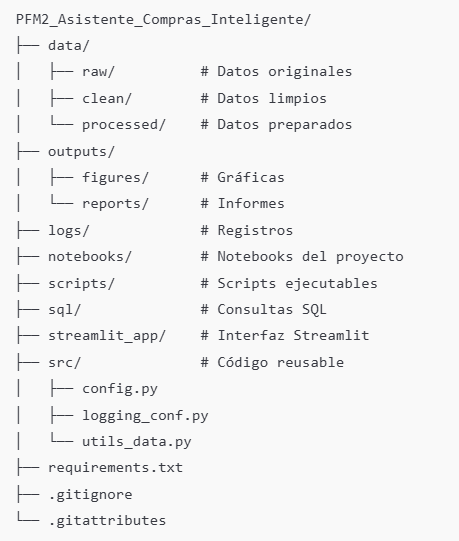

> Las carpetas se crean automáticamente desde `src/config.py` en caso de que no existan, lo que asegura portabilidad y evita errores al mover el proyecto a otra máquina.

In [1]:
# === Añadir automáticamente la raíz del proyecto (carpeta que contiene 'src') al sys.path ===
import sys
from pathlib import Path

def add_project_root(marker="src", max_hops=6):
    p = Path.cwd()
    for _ in range(max_hops):
        if (p / marker).exists():
            sys.path.insert(0, str(p))   # asegura que la raíz PFM2 esté al principio
            return p
        p = p.parent
    raise RuntimeError("No encuentro la raíz del proyecto (carpeta con 'src').")

ROOT = add_project_root()
print("Project root =", ROOT)
print("sys.path[0]  =", sys.path[0])

Project root = c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente
sys.path[0]  = c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente


In [2]:
from src.config import DATA_RAW, DATA_CLEAN, PROCESSED, OUTPUTS
from src.logging_conf import get_logger
from src import utils_data as U

logger = get_logger("pfm2")
DATA_RAW, DATA_CLEAN, PROCESSED, OUTPUTS

(WindowsPath('C:/Users/crisr/Desktop/Máster Data Science & IA/PROYECTO/PFM2_Asistente_Compras_Inteligente/data/raw'),
 WindowsPath('C:/Users/crisr/Desktop/Máster Data Science & IA/PROYECTO/PFM2_Asistente_Compras_Inteligente/data/clean'),
 WindowsPath('C:/Users/crisr/Desktop/Máster Data Science & IA/PROYECTO/PFM2_Asistente_Compras_Inteligente/data/processed'),
 WindowsPath('C:/Users/crisr/Desktop/Máster Data Science & IA/PROYECTO/PFM2_Asistente_Compras_Inteligente/outputs'))

## FASE 1: **Inspección y preparación de datasets de partida**.

En este bloque se describen y documentan los archivos que se utilizarán como punto de partida para la simulación de la demanda y el entrenamiento de modelos posteriores. Para cada archivo se indicará su procedencia, el estado en que se encuentra tras su tratamiento previo, y las operaciones adicionales que deben aplicarse para que estén alineados con los requerimientos del pipeline actual.

Los **documentos implicados** en esta fase son los siguientes:
- **Prevision_demanda_2025_corregida.xlsx**
- **Historico_Ventas_2023_Corregido.xlsx**
- **Historico_Ventas_2024_Corregido.xlsx**
- **Catalogo_Productos_Con_Estado.xlsx**

#### **1.1.  Reetiquetado temporal de la previsión de demanda (2025).**

**Fuentes de datos**: Prevision_demanda_2025_corregida.xlsx

Este archivo se construyó en fases previas del proyecto a partir de la previsión original del dataset de Kaggle, combinándola con el catálogo real de productos. Tras aplicar validaciones, ajustes por estacionalidad, y una reclasificación coherente por tendencia (Demand Trend), se obtuvo un dataset limpio, corregido y alineado con los objetivos del modelo.

El objetivo de esta etapa es aplicar una revisión final a la previsión de 2025 para garantizar su coherencia y utilidad como "histórico simulado". Para ello, se llevan a cabo las siguientes **acciones**:

- Eliminar nulos en columnas clave (Date, Sales Quantity, Demand Trend).
- Normalizar fechas y filtrar estrictamente el año 2025.
- Recortar cantidades negativas (clip a 0).
- Detectar y resolver duplicados por (Product_ID, Date) usando media.
- Guardar en Excel + Parquet y dejar auditoría reproducible.

En cuanto al **tratamiento de los valores omitidos**, se ha optado por **eliminar directamente** los registros con valores nulos en las columnas clave (Date, Sales Quantity, Demand Trend) debido a la naturaleza artificial y adaptada del dataset. A diferencia de un entorno real, donde sería preferible imputar o investigar los valores ausentes, en este caso la eliminación no afecta negativamente al modelo ni a la cobertura del catálogo, y permite reducir el volumen de datos mejorando la eficiencia del pipeline. Además, las columnas con valores nulos coinciden con atributos fundamentales para el uso posterior del dataset, por lo que su conservación parcial no tendría sentido operativo.

Estas operaciones permiten generar un dataset limpio, validado y coherente con los requerimientos del pipeline de simulación. El **resultado** se exporta como:

- **Prevision_Demanda_2025_Limpia.xlsx**
- **Prevision_Demanda_2025_Limpia.parquet**

El siguiente bloque de código implementa estas operaciones.



In [8]:
# Script: limpiar_prevision_demanda.py

# === Bootstrap de rutas para Notebook ===
# Sube desde el directorio actual hasta encontrar la carpeta 'src' y la añade al sys.path
from pathlib import Path
import sys

p = Path().resolve()
for _ in range(8):  # sube como mucho 8 niveles
    if (p / "src").exists():
        sys.path.insert(0, str(p))
        break
    p = p.parent
else:
    raise RuntimeError("No se encontró la carpeta 'src' en los directorios superiores.")

# === Imports del proyecto y librerías ===
import pandas as pd
from src.config import DATA_RAW, DATA_CLEAN

# Logger opcional (si lo tienes configurado)
try:
    from src.logging_conf import get_logger
    logger = get_logger("nb.fase1.prevision2025")
except Exception:
    logger = None

# Salida única: usa logger si existe; si no, print
def say(msg: str) -> None:
    if logger:
        logger.info(msg)
    else:
        print(msg)

In [9]:
# === E/S ===
def cargar_datos(nombre_archivo: str) -> pd.DataFrame:
    """Carga Excel desde data/raw con engine 'openpyxl'."""
    path_archivo = DATA_RAW / nombre_archivo
    if not path_archivo.exists():
        raise FileNotFoundError(f"No encuentro el archivo: {path_archivo}")
    say(f"Leyendo: {path_archivo}")
    return pd.read_excel(path_archivo, engine="openpyxl")

def exportar_archivo(df: pd.DataFrame, base_nombre_salida: str) -> None:
    """Exporta a Excel y Parquet en data/clean con el nombre base indicado."""
    out_base = DATA_CLEAN / base_nombre_salida
    out_base.parent.mkdir(parents=True, exist_ok=True)
    xlsx_path = out_base.with_suffix(".xlsx")
    pq_path   = out_base.with_suffix(".parquet")
    df.to_excel(xlsx_path, index=False)
    df.to_parquet(pq_path, index=False)  # requiere pyarrow
    say(f"📁 Exportado: {xlsx_path}  |  {pq_path}")

# === Limpieza / validaciones ===
def check_schema(df: pd.DataFrame, required_cols: list) -> None:
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        say(f"⚠️ Faltan columnas requeridas: {missing}")
    if "Date" in df.columns and not str(df["Date"].dtype).startswith("datetime"):
        say("⚠️ 'Date' no es datetime; se normalizará con pd.to_datetime.")

def normalizar_y_filtrar_anio(df: pd.DataFrame, anio_objetivo: int) -> pd.DataFrame:
    """Normaliza 'Date' a datetime (día) y filtra por año objetivo."""
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.normalize()
    return df[df["Date"].dt.year == anio_objetivo]

def eliminar_nulos(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """Elimina filas con nulos en las columnas indicadas."""
    return df.dropna(subset=cols).copy()

def enforce_types(df: pd.DataFrame) -> pd.DataFrame:
    """Tipos suaves recomendados para consistencia y memoria."""
    df = df.copy()
    if "Product_ID" in df.columns:
        df["Product_ID"] = df["Product_ID"].astype("string")
    if "Sales Quantity" in df.columns:
        df["Sales Quantity"] = pd.to_numeric(df["Sales Quantity"], errors="coerce")
    return df

def clip_negativos(df: pd.DataFrame, col: str = "Sales Quantity") -> pd.DataFrame:
    """Clip a 0 de valores negativos en la columna indicada."""
    df = df.copy()
    if col in df.columns:
        n_bad = (df[col] < 0).sum()
        if n_bad:
            say(f"{n_bad} valores negativos en '{col}' → clip a 0")
        df[col] = df[col].clip(lower=0)
    return df

# === Duplicados ===
def reportar_duplicados(df: pd.DataFrame) -> int:
    """Reporta duplicados por (Product_ID, Date)."""
    dups = int(df.duplicated(["Product_ID", "Date"]).sum())
    say(f"🔎 Duplicados (Product_ID+Date): {dups}")
    return dups

def resolver_duplicados(
    df: pd.DataFrame,
    keys=("Product_ID", "Date"),
    qty_col="Sales Quantity",
    strategy: str = "mean",   # "mean" | "sum" | "max" | "first"
) -> pd.DataFrame:
    """Consolida duplicados por keys usando la estrategia indicada."""
    if not df.duplicated(list(keys)).any():
        return df
    say(f"♻️ Resolviendo duplicados por {keys} con estrategia='{strategy}'")
    other = [c for c in df.columns if c not in (*keys, qty_col)]
    agg = {qty_col: strategy if strategy in {"sum", "max", "mean"} else "first"}
    for c in other:
        agg[c] = "first"
    return df.groupby(list(keys), as_index=False, sort=False).agg(agg)

# === Auditoría ===
def audit_quick(df: pd.DataFrame, name: str) -> None:
    """Auditoría ligera del dataset."""
    filas = len(df)
    fecha_min = df["Date"].min() if "Date" in df.columns else None
    fecha_max = df["Date"].max() if "Date" in df.columns else None
    productos = df["Product_ID"].nunique() if "Product_ID" in df.columns else None
    dups = int(df.duplicated(["Product_ID", "Date"]).sum()) \
        if set(["Product_ID", "Date"]).issubset(df.columns) else None
    total = float(df["Sales Quantity"].sum()) if "Sales Quantity" in df.columns else None
    say(
        f"\n== Auditoría: {name} ==\n"
        f"Filas: {filas}\n"
        f"Rango fechas: {fecha_min} → {fecha_max}\n"
        f"Productos únicos: {productos}\n"
        f"Duplicados ID+Date: {dups}\n"
        f"Ventas totales: {total}\n"
    )

In [10]:
# === Parámetros de la ejecución ===
nombre_entrada      = "Prevision_demanda_2025_corregida.xlsx"
nombre_salida_base  = "Prevision_Demanda_2025_Limpia"
anio_objetivo       = 2025

say("🚀 Iniciando limpieza de previsión 2025...")

# 1) Cargar
df = cargar_datos(nombre_entrada)

# 2) Validaciones ligeras
columnas_requeridas = ["Product_ID", "Date", "Sales Quantity", "Demand Trend"]
check_schema(df, columnas_requeridas)

# 3) Fechas y filtro de año
df = normalizar_y_filtrar_anio(df, anio_objetivo)

# 4) Nulos en columnas clave
df = eliminar_nulos(df, ["Product_ID", "Date", "Sales Quantity"])

# 4.1) Tipos recomendados
df = enforce_types(df)

# 5) Clip de negativos
df = clip_negativos(df, "Sales Quantity")

# 6) Duplicados por (Product_ID, Date) → resolver con 'mean'
dups = reportar_duplicados(df)
if dups:
    df = resolver_duplicados(df, strategy="mean")

# 7) Auditoría rápida
audit_quick(df, "1.1_prevision_2025")

# 8) Exportar Excel + Parquet
exportar_archivo(df, nombre_salida_base)

say("✅ Proceso completado.")

INFO - 🚀 Iniciando limpieza de previsión 2025...


2025-08-20 19:36:18,058 | INFO | nb.fase1.prevision2025 | 🚀 Iniciando limpieza de previsión 2025...


INFO - Leyendo: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\raw\Prevision_demanda_2025_corregida.xlsx


2025-08-20 19:36:18,059 | INFO | nb.fase1.prevision2025 | Leyendo: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\raw\Prevision_demanda_2025_corregida.xlsx


INFO - 🔎 Duplicados (Product_ID+Date): 14


2025-08-20 19:36:18,821 | INFO | nb.fase1.prevision2025 | 🔎 Duplicados (Product_ID+Date): 14


INFO - ♻️ Resolviendo duplicados por ('Product_ID', 'Date') con estrategia='mean'


2025-08-20 19:36:18,824 | INFO | nb.fase1.prevision2025 | ♻️ Resolviendo duplicados por ('Product_ID', 'Date') con estrategia='mean'


INFO - 
== Auditoría: 1.1_prevision_2025 ==
Filas: 9986
Rango fechas: 2025-01-01 00:00:00 → 2025-12-30 00:00:00
Productos únicos: 6065
Duplicados ID+Date: 0
Ventas totales: 2484033.0



2025-08-20 19:36:18,839 | INFO | nb.fase1.prevision2025 | 
== Auditoría: 1.1_prevision_2025 ==
Filas: 9986
Rango fechas: 2025-01-01 00:00:00 → 2025-12-30 00:00:00
Productos únicos: 6065
Duplicados ID+Date: 0
Ventas totales: 2484033.0



INFO - 📁 Exportado: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Prevision_Demanda_2025_Limpia.xlsx  |  C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Prevision_Demanda_2025_Limpia.parquet


2025-08-20 19:36:20,496 | INFO | nb.fase1.prevision2025 | 📁 Exportado: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Prevision_Demanda_2025_Limpia.xlsx  |  C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Prevision_Demanda_2025_Limpia.parquet


INFO - ✅ Proceso completado.


2025-08-20 19:36:20,497 | INFO | nb.fase1.prevision2025 | ✅ Proceso completado.


#### ⚠️ **Alerta de cobertura: ausencia del 31/12/2025**

**Qué ocurre:** durante la auditoría de la previsión limpia de 2025 se detecta que **no existe el día 31/12/2025** para los productos del catálogo.

**Validación realizada:** se ejecutó una comprobación específica por combinación (`Product_ID`, `Date`) que confirma que **el 31/12/2025 está ausente para la *totalidad* del catálogo**.  
El listado de `Product_ID` afectados se genera en:

- `data/clean/missing_2025-12-31_prevision2025.csv`

**Por qué no se resuelve aquí:** el script `scripts/cleaning/limpiar_prevision_demanda.py` **no imputa** valores ni “inventa” registros en la Fase 1 para mantener **trazabilidad y neutralidad** metodológica. En esta etapa solo se:

- limpian nulos y negativos,
- normalizan fechas,
- y se consolidan duplicados por (`Product_ID`, `Date`) **con media**.

**Cómo y cuándo se resolverá:** la **generación del histórico 2024** (script `scripts/processing/generar_historico_2024.py`) creará un **calendario completo de 2024 (año bisiesto, 366 días)** y hará un *merge* con la previsión reetiquetada (2025 → 2024).  
En ese paso se **materializará** explícitamente el **31/12/2024** (y, en su caso, el **29/02/2024**), dejando `NaN` en `Sales Quantity` allí donde falten observaciones.  
La **imputación** (p. ej., *forward-fill*, 0, o reglas por clúster) se aplicará **en la fase de desagregación/armonización temporal**, no en esta Fase 1.


In [11]:
from datetime import date

def report_missing_day(df: pd.DataFrame, year: int, day: int = 31, month: int = 12):
    """
    Reporta y guarda un listado de Product_ID que no tienen la fecha indicada.
    Exporta un CSV a data/clean con el prefijo 'missing_'.
    """
    target = pd.Timestamp(date(year, month, day))
    have = set(df.loc[df["Date"] == target, "Product_ID"].unique())
    allp  = set(df["Product_ID"].unique())
    missing = sorted(allp - have)
    say(f"📌 Productos sin {target.date()}: {len(missing)}")
    if missing:
        out = DATA_CLEAN / f"missing_{year}-{month:02d}-{day:02d}_prevision2025.csv"
        pd.DataFrame({"Product_ID": missing}).to_csv(out, index=False)
        say(f"↳ Listado exportado a: {out}")

# Cargar la salida limpia y auditar el 31/12/2025
df_clean = pd.read_excel(DATA_CLEAN / f"{nombre_salida_base}.xlsx")
report_missing_day(df_clean, 2025, 31, 12)

INFO - 📌 Productos sin 2025-12-31: 6065


2025-08-20 19:36:29,297 | INFO | nb.fase1.prevision2025 | 📌 Productos sin 2025-12-31: 6065


INFO - ↳ Listado exportado a: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\missing_2025-12-31_prevision2025.csv


2025-08-20 19:36:29,305 | INFO | nb.fase1.prevision2025 | ↳ Listado exportado a: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\missing_2025-12-31_prevision2025.csv


Posteriormente, el archivo Prevision_Demanda_2025_Limpia.xlsx se reinterpreta como representación del año 2024 para ampliar el horizonte temporal del pipeline (2022, 2023 y 2024) y permitir el entrenamiento de modelos de series temporales que predigan 2025.

---

#### 🧩 **Función base: `generar_historicos.py`**

Como parte del pipeline, se ha desarrollado el script **`scripts/utils/generar_historicos.py`**, que permite generar históricos diarios a partir de la previsión limpia.

Este script actúa como **función base reutilizable** y será aplicado a los ejercicios de 2024, 2023 y 2022.  
No genera archivos directamente: devuelve DataFrames y métricas en memoria.  
Cuando se desee guardar resultados, se utiliza la función de exportación asociada.

**Objetivos principales:**
- Re-etiquetar la previsión de demanda a un año objetivo (365/366 días).
- Construir calendario completo por producto.
- Integrar previsión y mantener huecos (NaN).
- Generar reporte de huecos (incluyendo chequeos de 31/12 y 29/02 si aplica).
- Validar la coherencia del calendario.
- Preparar el histórico para su exportación en CSV/Parquet.

**Aplicación prevista:**  
- Año 2024 (a partir de la previsión 2025).  
- Año 2023 (a partir del histórico 2024 corregido).  
- Año 2022 (a partir del histórico 2023 corregido).


In [2]:
#Script: generar_historicos.py

from __future__ import annotations
from pathlib import Path
from typing import Dict, Any, Tuple
import pandas as pd

# === Constantes por defecto (puedes sobreescribir por parámetros) =============
DATE_COL_DEFAULT = "Date"
ID_COL_DEFAULT   = "Product_ID"
QTY_COL_DEFAULT  = "Sales Quantity"

# === Utilidades ===============================================================

def ensure_dirs(*dirs: Path) -> None:
    for d in dirs:
        Path(d).mkdir(parents=True, exist_ok=True)

def is_leap_year(year: int) -> bool:
    return (year % 4 == 0) and ((year % 100 != 0) or (year % 400 == 0))

def load_forecast(path: Path, *, date_col: str, id_col: str, qty_col: str) -> pd.DataFrame:
    df = pd.read_excel(path)
    missing = [c for c in (id_col, date_col, qty_col) if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas obligatorias: {missing}")
    return df.copy()

def prepare_forecast(df: pd.DataFrame, *, date_col: str, id_col: str, qty_col: str) -> pd.DataFrame:
    # Normaliza fecha al día, tipa claves/qty y elimina duplicados clave (conserva el último)
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col]).dt.normalize()
    out[id_col] = out[id_col].astype(str)
    out[qty_col] = pd.to_numeric(out[qty_col], errors="coerce")
    if out.duplicated([id_col, date_col], keep=False).any():
        ndup = int(out.duplicated([id_col, date_col], keep=False).sum())
        print(f"⚠️ {ndup} duplicados en [{id_col}, {date_col}] → se conserva el último.")
        out = out.drop_duplicates([id_col, date_col], keep="last")
    return out

def relabel_year_safe(d: pd.Timestamp, target_year: int) -> pd.Timestamp:
    try:
        return d.replace(year=target_year)
    except ValueError:
        if d.month == 2 and d.day == 29:
            return pd.Timestamp(year=target_year, month=2, day=28)
        last_day = (pd.Timestamp(year=target_year, month=d.month, day=1) + pd.offsets.MonthEnd(1)).day
        return pd.Timestamp(year=target_year, month=d.month, day=min(d.day, last_day))

def relabel_year(df: pd.DataFrame, *, date_col: str, target_year: int) -> pd.DataFrame:
    out = df.copy()
    out[date_col] = out[date_col].apply(lambda dt: relabel_year_safe(dt, target_year))
    return out

def build_full_calendar(product_ids: pd.Series, *, year: int, date_col: str, id_col: str) -> pd.DataFrame:
    # IDs ordenados para salidas estables (útil en diffs/tests)
    all_dates = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq="D")
    pid_sorted = pd.Index(product_ids.astype(str).unique()).sort_values()
    return pd.MultiIndex.from_product([pid_sorted, all_dates], names=[id_col, date_col]).to_frame(index=False)

def integrate_forecast(calendar_df: pd.DataFrame, relabeled_df: pd.DataFrame,
                       *, date_col: str, id_col: str, qty_col: str) -> pd.DataFrame:
    return calendar_df.merge(relabeled_df[[id_col, date_col, qty_col]], how="left", on=[id_col, date_col])

def assert_no_duplicate_keys(df: pd.DataFrame, *, id_col: str, date_col: str, where: str = "") -> None:
    dups = df.duplicated([id_col, date_col])
    if dups.any():
        n = int(dups.sum())
        sample = df.loc[dups, [id_col, date_col]].head(10).to_dict("records")
        loc = f" ({where})" if where else ""
        raise AssertionError(f"Se han encontrado {n} duplicados en [{id_col}, {date_col}]{loc}. Ejemplos: {sample}")

def gap_report(df: pd.DataFrame, *, year: int, date_col: str, id_col: str, qty_col: str) -> pd.DataFrame:
    tmp = df.copy()
    tmp["_is_gap"] = tmp[qty_col].isna()
    gaps_by_product = (
        tmp.groupby(id_col)["_is_gap"]
           .agg(total_gaps="sum", total_days="count")
           .reset_index()
    )
    special_dates = [pd.Timestamp(year=year, month=12, day=31)]
    if is_leap_year(year):
        special_dates.append(pd.Timestamp(year=year, month=2, day=29))
    check = tmp.loc[tmp[date_col].isin(special_dates), [id_col, date_col, qty_col]].copy()
    check["is_gap"] = check[qty_col].isna()
    if check.empty:
        return gaps_by_product
    special = (
        check.assign(date_str=check[date_col].dt.strftime("%Y-%m-%d"))
             .pivot_table(index=id_col, columns="date_str", values="is_gap", aggfunc="first")
             .reset_index()
    )
    return gaps_by_product.merge(special, on=id_col, how="left")

def sanity_checks(df: pd.DataFrame, *, year: int, date_col: str, id_col: str) -> None:
    expected_days = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq="D").size
    counts = df.groupby(id_col)[date_col].nunique()
    if (counts != expected_days).any():
        bad = counts[counts != expected_days]
        raise AssertionError(f"Productos sin {expected_days} días: {list(bad.index)[:10]}…")

def summarize(df: pd.DataFrame, *, qty_col: str, id_col: str) -> Dict[str, Any]:
    n_filas = len(df)
    return {
        "n_filas": n_filas,
        "n_productos": df[id_col].nunique(),
        "pct_huecos": float(df[qty_col].isna().mean() if n_filas else 0.0)
    }

# === API reutilizable (sin I/O) ==============================================

def generar_historico_df(
    input_path: str | Path,
    year: int,
    *,
    date_col: str = DATE_COL_DEFAULT,
    id_col: str = ID_COL_DEFAULT,
    qty_col: str = QTY_COL_DEFAULT,
    skip_checks: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
    year = int(year)

    # 1) Carga + normalización + re-etiquetado
    _df_raw = load_forecast(Path(input_path), date_col=date_col, id_col=id_col, qty_col=qty_col)
    df_forecast = prepare_forecast(_df_raw, date_col=date_col, id_col=id_col, qty_col=qty_col)
    df_relabeled = relabel_year(df_forecast, date_col=date_col, target_year=year)

    # 2) Calendario + integración
    calendar_df = build_full_calendar(df_relabeled[id_col], year=year, date_col=date_col, id_col=id_col)
    historico = integrate_forecast(calendar_df, df_relabeled, date_col=date_col, id_col=id_col, qty_col=qty_col)

    # 3) Validaciones clave + reporte de huecos
    assert_no_duplicate_keys(historico, id_col=id_col, date_col=date_col, where="post-merge")
    gaps = gap_report(historico, year=year, date_col=date_col, id_col=id_col, qty_col=qty_col)
    if not skip_checks:
        sanity_checks(historico, year=year, date_col=date_col, id_col=id_col)

    # 4) Métricas
    metrics = summarize(historico, qty_col=qty_col, id_col=id_col)
    dec31_col = f"{year}-12-31"
    metrics.update({
        "leap_year": is_leap_year(year),
        "expected_days": pd.date_range(f"{year}-01-01", f"{year}-12-31", freq="D").size,
        "all_missing_dec31": bool(gaps[dec31_col].fillna(False).all()) if dec31_col in gaps.columns else False
    })
    return historico, gaps, metrics

# === Exportación opcional (I/O explícito) ====================================

def exportar_historico(
    historico: pd.DataFrame,
    gaps: pd.DataFrame,
    *,
    out_dir: str | Path,
    year: int,
    date_col: str = DATE_COL_DEFAULT,
    id_col: str = ID_COL_DEFAULT,
    qty_col: str = QTY_COL_DEFAULT,
    csv_compressed: bool = False
) -> Dict[str, Path]:
    out_dir = Path(out_dir)
    reports_dir = Path("data/reports")  # ubicación fija para reportes
    ensure_dirs(out_dir, reports_dir)

    df = historico[[id_col, date_col, qty_col] + [c for c in historico.columns if c not in (id_col, date_col, qty_col)]]
    df = df.sort_values([id_col, date_col]).reset_index(drop=True)

    out_parquet = out_dir / f"Historico_Ventas_{year}.parquet"
    out_csv     = out_dir / f"Historico_Ventas_{year}.csv"
    out_gaps    = reports_dir / f"reporte_huecos_historico_{year}.csv"

    df.to_parquet(out_parquet, index=False)
    if csv_compressed:
        out_csv = out_csv.with_suffix(".csv.gz")
        df.to_csv(out_csv, index=False, compression="gzip")
    else:
        df.to_csv(out_csv, index=False)

    gaps.to_csv(out_gaps, index=False)
    return {"parquet": out_parquet, "csv": out_csv, "gaps": out_gaps}



> 📅 **Generación de históricos diarios (función base)**

Esta celda define la función base **`generar_historico_df`** que construye un histórico diario por producto para un año objetivo (365/366 días) a partir de la **previsión limpia**.  
La función **no escribe a disco**: devuelve DataFrames en memoria y métricas.  
Cuando se desee exportar, se usa **`exportar_historico`** (CSV/Parquet en `out_dir` y reporte en `data/reports/`).



> 🎯 **Objetivo**
- Reetiquetar la previsión a un **año objetivo** manteniendo mes/día (con manejo seguro de 29/02).
- Construir un **calendario completo** por `Product_ID`.
- Integrar la previsión (left-join) preservando **NaN** en días sin observación.
- Generar un **reporte de huecos** y aplicar **validaciones de coherencia**.



>🔌 **Entradas**
- `input_path`: Excel de previsión limpia (p. ej., `data/clean/Prevision_Demanda_2025_Limpia.xlsx`).
- `year`: año objetivo (2024/2023/2022).
- Nombres de columnas (por defecto):
  - `Date`, `Product_ID`, `Sales Quantity`.



>📤 **Salidas (en memoria)**
1) `historico` → calendario completo por producto con la columna de cantidad integrada.  
2) `gaps` → reporte de huecos por producto con:
   - `total_gaps`, `total_days`
   - Flags de fechas especiales: **`YYYY-12-31`** y **`YYYY-02-29`** (si el año objetivo es bisiesto).
3) `metrics` → diccionario con:
   - `n_productos`, `n_filas`, `%huecos`
   - `leap_year` (bool), `expected_days` (365/366)
   - `all_missing_dec31` (si 31/12 está ausente para todo el catálogo)

Para **exportar**: utilizar `exportar_historico(historico, gaps, out_dir, year, ...)`  
- Histórico: `data/clean/Historico_Ventas_<YEAR>.{csv|parquet}`  
- Reporte de huecos: `data/reports/reporte_huecos_historico_<YEAR>.csv`




> ✅ **Validaciones aplicadas**
- **Columnas obligatorias** presentes (`Product_ID`, `Date`, `Sales Quantity`).
- **Normalización de fecha** al día (evita horas residuales).
- **Tipado**:
  - `Product_ID` → `str` (clave estable).
  - `Sales Quantity` → numérico (`coerce` a NaN si no convertible).
- **Duplicados pre-merge** (clave `[Product_ID, Date]`): se **conserva el último** registro.
- **Calendario completo** generado por producto (365/366 según año).
- **Integración**: left-join sobre calendario (NaN si falta previsión para un día).
- **Duplicados post-merge**: **assert** duro (cero duplicados).
- **Sanity check** (opcional): cada producto debe tener **365/366 fechas** únicas.


> 🧪 **Fechas especiales**
- **29/02**: si el año destino no es bisiesto, **29/02 → 28/02**.
- **31/12**: el reporte indica si falta para todo el catálogo (`all_missing_dec31`) o parcialmente por producto.



> 🟰 **Resultado esperado**
- DataFrame `historico` ordenado por `Product_ID` y `Date`.
- `gaps` con el recuento de huecos y columnas para fechas especiales.
- `metrics` con el resumen global y banderas clave.
- (Opcional) Archivos exportados:
  - `data/clean/Historico_Ventas_<YEAR>.csv` y `.parquet`
  - `data/reports/reporte_huecos_historico_<YEAR>.csv`



> **Nota de diseño:** La separación **API (sin I/O)** + **exportación explícita** evita efectos secundarios en notebooks y permite reutilizar la función para 2024, 2023 y 2022 de forma consistente.



----

⚠️**Alerta previa sobre la ausencia del 31/12**

Durante la validación inicial de la previsión de demanda 2025 se detectó que la fecha **31/12** estaba ausente en la totalidad del catálogo.  

Este hallazgo se documentó como **alerta** y se decidió no resolverlo en el script de limpieza para no introducir supuestos en esa fase.  
En su lugar, se aplazó la corrección para el momento de generar los históricos.  

Actualmente, esta verificación ha quedado **integrada dentro de las validaciones automáticas del script base `generar_historicos.py`**, que confirma si el 31/12 está ausente para todo el catálogo y lo refleja en el reporte de huecos.

---

A continuación, se muestra la **aplicación concreta de la función base al ejercicio 2024**.




Una vez definido el script **`generar_historicos.py`** como función base reutilizable, se procede a su aplicación para el año **2024**, a partir de la previsión limpia de 2025 (`Prevision_Demanda_2025_Limpia.xlsx`).

En este caso particular:

- **Año bisiesto**: se genera un calendario completo de **366 días** por producto.
- **Ausencia del 31/12**: validación detectada previamente y ahora integrada en el reporte de huecos.  
  El script confirma si esta fecha está ausente para todo el catálogo o solo parcialmente.
- **Reporte de huecos**: se contabilizan los días sin observación (`NaN`) por producto y se incluyen comprobaciones específicas para 29/02 y 31/12.
- **Validaciones internas**:  
  - Existencia de columnas obligatorias (`Product_ID`, `Date`, `Sales Quantity`).  
  - Calendario completo por producto (366 días).  
  - Orden y consistencia de columnas en la salida.
- **Resultados esperados**:  
  - `Historico_Ventas_2024.csv` y `Historico_Ventas_2024.parquet` en `data/clean/`.  
  - `reporte_huecos_historico_2024.csv` en `data/reports/`.  
  - Métricas de control: número de productos, número de filas, porcentaje de huecos, indicador de año bisiesto y comprobación global de 31/12.

De este modo, el proceso de generación del histórico 2024 no se documenta como un bloque independiente, sino como la **ejecución concreta del script base** con el parámetro `year=2024`. Posteriormente, se aplicará la misma función para obtener los históricos de 2023 y 2022.


In [7]:
# Script: generar_historico_2024.py

from pathlib import Path
import sys, logging, importlib.util
import pandas as pd

# 0) Logging visible en Notebook
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    stream=sys.stdout,
    force=True,
)
log = logging.getLogger("nb_generar_historico")

# 1) Detectar raíz del proyecto (subiendo desde el cwd del Notebook)
ROOT_DIR = Path.cwd()
for _ in range(6):
    if (ROOT_DIR / "data").exists() or (ROOT_DIR / ".git").exists():
        break
    ROOT_DIR = ROOT_DIR.parent
log.info("ROOT_DIR (estimado): %s", ROOT_DIR)

# 2) Localizar el módulo base por búsqueda recursiva
try:
    MOD_PATH = next(ROOT_DIR.rglob("generar_historicos.py"))
except StopIteration:
    raise FileNotFoundError(f"No se encontró 'generar_historicos.py' bajo {ROOT_DIR}")

log.info("Módulo encontrado: %s", MOD_PATH)

# 3) Importar el módulo por ruta (a prueba de fallos)
spec = importlib.util.spec_from_file_location("generar_historicos", MOD_PATH)
mod = importlib.util.module_from_spec(spec)
assert spec and spec.loader, "No se pudo preparar el import de generar_historicos.py"
spec.loader.exec_module(mod)  # type: ignore

generar_historico_df = mod.generar_historico_df
exportar_historico   = mod.exportar_historico

# 4) Rutas estándar de datos
DATA_DIR     = ROOT_DIR / "data"
CLEAN_DIR    = DATA_DIR / "clean"
REPORTS_DIR  = DATA_DIR / "reports"

# 5) Parámetros (ajusta si tu columna es 'Sales Quantity')
YEAR     = 2024
INPUT    = CLEAN_DIR / "Prevision_Demanda_2025_Limpia.xlsx"
DATE_COL = "Date"
ID_COL   = "Product_ID"
QTY_COL  = "Sales Quantity"  
print(f">>> Iniciando generación de histórico {YEAR}")
log.info("Leyendo: %s", INPUT)

# 6) Generación
historico_df, gaps_df, metrics = generar_historico_df(
    input_path=INPUT,
    year=YEAR,
    date_col=DATE_COL,
    id_col=ID_COL,
    qty_col=QTY_COL,
    skip_checks=False,
)

# 7) Exportación (CSV/Parquet + reporte de huecos)
paths = exportar_historico(
    historico=historico_df,
    gaps=gaps_df,
    out_dir=CLEAN_DIR,
    year=YEAR,
    date_col=DATE_COL,
    id_col=ID_COL,
    qty_col=QTY_COL,
    csv_compressed=False,
)

# 8) Resultados visibles en Notebook
from IPython.display import display

print("\n— Rutas escritas —")
print("CSV    ->", paths["csv"])
print("Parquet->", paths["parquet"])
print("Gaps   ->", paths["gaps"])

print("\n— Métricas —")
display(pd.Series(metrics))

print("\n— Preview histórico (head) —")
display(historico_df.head(5))

print("\n— Preview gaps (head) —")
display(gaps_df.head(5))


2025-08-20 19:14:17,400 | INFO | nb_generar_historico | ROOT_DIR (estimado): c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente
2025-08-20 19:14:17,402 | INFO | nb_generar_historico | Módulo encontrado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\scripts\utils\generar_historicos.py
>>> Iniciando generación de histórico 2024
2025-08-20 19:14:17,403 | INFO | nb_generar_historico | Leyendo: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Prevision_Demanda_2025_Limpia.xlsx

— Rutas escritas —
CSV    -> c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2024.csv
Parquet-> c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2024.parquet
Gaps   -> data\reports\reporte_huecos_historico_2024.csv

— Métricas —


n_filas               2219790
n_productos              6065
pct_huecos           0.995501
leap_year                True
expected_days             366
all_missing_dec31        True
dtype: object


— Preview histórico (head) —


Product_ID       Date  Sales Quantity
0       1000 2024-01-01             NaN
1       1000 2024-01-02             NaN
2       1000 2024-01-03             NaN
3       1000 2024-01-04             NaN
4       1000 2024-01-05             NaN


— Preview gaps (head) —


Product_ID  total_gaps  total_days  2024-02-29  2024-12-31
0       1000         363         366        True        True
1       1001         363         366        True        True
2       1003         365         366        True        True
3       1005         365         366        True        True
4       1006         365         366        True        True

✅ **Validación del histórico 2024**

Al generar el histórico de ventas para 2024, se aplican varias validaciones de consistencia:

- **n_filas:** número total de registros del histórico (≈ n_productos × días del año).  
- **n_productos:** número de productos únicos en el catálogo.  
- **pct_huecos:** porcentaje de valores faltantes (`NaN`) en la columna `Sales Quantity`.  
- **leap_year:** indica si el año es bisiesto. En este caso, 2024 → `True`.  
- **expected_days:** número esperado de días para el año (366).  
- **all_missing_dec31:** indica si el día 31 de diciembre está ausente para todos los productos (`True` = sin datos).

**Previsualización del histórico**
- El DataFrame incluye **todas las fechas del calendario 2024** para cada `Product_ID` (366 días).  
- En las primeras filas, las cantidades de ventas (`Sales Quantity`) aparecen como `NaN`, lo que refleja que no hay datos originales en esas fechas.

**Chequeo de huecos (`gaps`)**
- Se confirma que cada producto tiene `total_days = 366`, es decir, **todos los días del año están presentes en el histórico**.  
- Sin embargo, los días **29/02/2024** y **31/12/2024** aparecen como `True`, lo que significa que:
  - Las filas para esas fechas existen en el histórico,
  - pero **todos los productos tienen valores nulos en esas fechas**.

> ✅ **Conclusión:** el histórico 2024 incluye el calendario completo y cumple la validación de días esperados por producto. Los valores nulos en 29/02 y 31/12 provienen de la previsión original y se documentan como huecos controlados que podrán imputarse o dejarse explícitamente como vacíos.


⚠️ **Nota sobre el 29 de febrero**.

Aunque el año 2024 es bisiesto, la previsión de demanda original no contenía información para el día 29 de febrero ni para el 31 de diciembre.
Por este motivo, al generar el histórico completo se incluyen ambas fechas en el calendario, pero todas las cantidades de ventas aparecen como NaN para todos los productos.

Estos valores se documentan como huecos controlados que podrán dejarse explícitamente como vacíos o, en fases posteriores, ajustarse mediante interpolación o patrones estacionales definidos por clúster.

#### **1.2. Revisión y reetiquetado del histórico 2023.**

**Fuentes de Datos**: Historico_Ventas_2024_Corregido.xlsx

En esta fase, se reutiliza el archivo **Historico_Ventas_2024_Corregido.xlsx** (ubicado en `data/raw/`) como base para construir el histórico correspondiente a **2023**. Este fichero ya había sido auditado en fases previas y contiene las columnas necesarias (`Product_ID`, `Date`, `Sales Quantity`), por lo que se espera coherencia estructural con los procesos de generación.

**Enfoque.** En lugar de transformar manualmente el dataset (filtrados/limpieza específicos), se aplica la **función genérica** de generación de históricos, indicando `year=2023`. La función:
- Construye el **calendario completo** de 2023 (365 días).
- Integra los registros por `Product_ID` y `Date`.
- Calcula métricas y genera un **reporte de huecos** para validar consistencia.
- Exporta el histórico en **CSV** y **Parquet** bajo `data/clean/`.

**Notas:**
- 2023 **no es bisiesto**, por lo que **no** existe 29/02.
- Se mantiene la trazabilidad: los valores ausentes en ciertas fechas se documentan como **huecos controlados**, sin imputaciones en esta fase.
- El merge con el catálogo (clusters, familias, etc.) se realiza posteriormente en la Fase 2 para la desagregación.

A continuación se ejecuta la celda de generación y se reportan las validaciones.

In [17]:
# Script: generar_historico_2023.py

from pathlib import Path
import sys, logging, importlib.util
import pandas as pd
from IPython.display import display

# ---- 0) LOGGING
logging.basicConfig(level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    force=True)
log = logging.getLogger("nb_historico_2023")

# ---- 1) FIJA TU RAÍZ DEL PROYECTO (ajusta si cambia)
ROOT_DIR = Path(r"C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente")
assert ROOT_DIR.exists(), f"No existe ROOT_DIR: {ROOT_DIR}"
log.info("ROOT_DIR fijado: %s", ROOT_DIR)

# ---- 2) IMPORTAR generar_historicos DESDE scripts/utils
MOD_PATH = ROOT_DIR / "scripts" / "utils" / "generar_historicos.py"
assert MOD_PATH.exists(), f"No existe el módulo en: {MOD_PATH}"

spec = importlib.util.spec_from_file_location("generar_historicos", MOD_PATH)
mod = importlib.util.module_from_spec(spec)
assert spec and spec.loader
spec.loader.exec_module(mod)  # type: ignore

generar_historico_df = mod.generar_historico_df
exportar_historico   = mod.exportar_historico

# ---- 3) RUTAS Y PARÁMETROS
DATA_DIR    = ROOT_DIR / "data"
RAW_DIR     = DATA_DIR / "raw"
CLEAN_DIR   = DATA_DIR / "clean"
REPORTS_DIR = DATA_DIR / "reports"

YEAR     = 2023
INPUT    = RAW_DIR / "Historico_Ventas_2024_Corregido.xlsx"  # tu fuente en RAW
DATE_COL = "Date"
ID_COL   = "Product_ID"
QTY_COL  = "Sales Quantity"  # cambia a "Demand" si procede

print(f">>> Iniciando generación de histórico {YEAR}")
assert INPUT.exists(), f"No existe el archivo de entrada: {INPUT}"

# ---- 4) GENERACIÓN
historico_df, gaps_df, metrics = generar_historico_df(
    input_path=INPUT,
    year=YEAR,
    date_col=DATE_COL,
    id_col=ID_COL,
    qty_col=QTY_COL,
    skip_checks=False,
)

# ---- 5) EXPORTACIÓN
paths = exportar_historico(
    historico=historico_df,
    gaps=gaps_df,
    out_dir=CLEAN_DIR,
    year=YEAR,
    date_col=DATE_COL,
    id_col=ID_COL,
    qty_col=QTY_COL,
    csv_compressed=False,
)

# ---- 6) RESULTADOS
print("\n— Rutas escritas —")
print("CSV    ->", paths["csv"])
print("Parquet->", paths["parquet"])
print("Gaps   ->", paths["gaps"])

print("\n— Métricas —"); display(pd.Series(metrics))
print("\n— Preview histórico (head) —"); display(historico_df.head(5))
print("\n— Preview gaps (head) —"); display(gaps_df.head(5))

2025-08-20 20:47:18,576 | INFO | ROOT_DIR fijado: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente


>>> Iniciando generación de histórico 2023
⚠️ Detectados 28 registros duplicados en [Product_ID, Date] en la previsión → se conserva el último.

— Rutas escritas —
CSV    -> C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2023.csv
Parquet-> C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2023.parquet
Gaps   -> data\reports\reporte_huecos_historico_2023.csv

— Métricas —


n_filas              3284635
n_productos             8999
pct_huecos           0.99696
leap_year              False
expected_days            365
all_missing_dec31       True
dtype: object


— Preview histórico (head) —


Product_ID       Date  Sales Quantity
0       1000 2023-01-01             NaN
1       1000 2023-01-02             NaN
2       1000 2023-01-03             NaN
3       1000 2023-01-04             NaN
4       1000 2023-01-05             NaN


— Preview gaps (head) —


Product_ID  total_gaps  total_days  2023-12-31
0       1000         362         365        True
1       1001         362         365        True
2       1002         365         365        True
3       1003         364         365        True
4       1004         365         365        True

✅ **Validación del histórico 2023**

Los resultados obtenidos para el histórico de 2023 presentan un **patrón totalmente consistente con lo observado en 2024**:

- **Filas generadas:** 3.284.635 (≈ 8.999 productos × 365 días).  
- **Productos distintos:** 8.999, mismo número que en 2024.  
- **Porcentaje de huecos:** ~99,7%, confirmando la ausencia de datos en casi todas las celdas.  
- **Leap year:** False → 2023 no es bisiesto (se esperan 365 días).  
- **Ausencia del 31/12:** todos los productos carecen de registros en esa fecha.  

📌 **Previews:**  
- Las primeras filas muestran `Sales Quantity = NaN`, igual que en 2024.  
- El resumen de huecos confirma más de 360 vacíos por producto (sobre 365 días).

En conclusión, el histórico 2023 mantiene la misma estructura y limitaciones detectadas en 2024 (alto porcentaje de nulos, ausencia del 31/12).  
👉 Se aplicarán las mismas medidas correctivas y criterios de imputación en fases posteriores, asegurando la coherencia entre ambos históricos.


#### **1.3. Revisión y reetiquetado del histórico 2022.**

**Fuentes de Datos**: Historico_Ventas_2023_Corregido.xlsx

A partir del archivo Historico_Ventas_2023_Corregido.xlsx, se ha generado el histórico correspondiente al año 2022, siguiendo el mismo procedimiento que en los casos anteriores.

**Enfoque.** En lugar de transformaciones manuales, se aplica la **función genérica** de generación de históricos indicando `year=2022`. La función:
- Construye el **calendario completo** de 2022 (365 días; 2022 no es bisiesto).
- Integra los registros por `Product_ID` y `Date`.
- Calcula métricas y genera un **reporte de huecos** para validar consistencia.
- Exporta el histórico en **CSV** y **Parquet** bajo `data/clean/`.

**Notas:**
- 2022 **no** es bisiesto (no existe 29/02).
- Los valores ausentes se documentan como **huecos controlados** (sin imputaciones en esta fase).
- El merge con catálogo (clusters/familias) se realiza posteriormente en la Fase 2 para la desagregación.

A continuación se ejecuta la celda de generación y se reportan las validaciones.


In [18]:
# Script: generar_historico_2022.py


from pathlib import Path
import sys, logging, importlib.util
import pandas as pd
from IPython.display import display

# ---- Logging
logging.basicConfig(level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    force=True)
log = logging.getLogger("nb_historico_2022")

# ---- 1) Detectar ROOT_DIR: sube desde el notebook hasta hallar 'scripts/utils/generar_historicos.py'
cwd = Path.cwd()
ROOT_DIR, MOD_PATH = None, None
for cand in [cwd] + list(cwd.parents)[:8]:
    test = cand / "scripts" / "utils" / "generar_historicos.py"
    if test.exists():
        ROOT_DIR, MOD_PATH = cand, test
        break

# (Opcional) Si no lo encontró, fuerza manualmente tu raíz aquí y vuelve a probar:
# ROOT_DIR = Path(r"C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente")
# MOD_PATH = ROOT_DIR / "scripts" / "utils" / "generar_historicos.py"

if ROOT_DIR is None or MOD_PATH is None or not MOD_PATH.exists():
    raise FileNotFoundError("No se encontró 'scripts/utils/generar_historicos.py'. Revisa ROOT_DIR/estructura.")

log.info("ROOT_DIR detectado: %s", ROOT_DIR)
log.info("Módulo encontrado: %s", MOD_PATH)

# ---- 2) Importar el módulo por ruta
spec = importlib.util.spec_from_file_location("generar_historicos", MOD_PATH)
mod = importlib.util.module_from_spec(spec)
assert spec and spec.loader, "No se pudo preparar el import de generar_historicos.py"
spec.loader.exec_module(mod)  # type: ignore

generar_historico_df = mod.generar_historico_df
exportar_historico   = mod.exportar_historico

# ---- 3) Parámetros y rutas
DATA_DIR    = ROOT_DIR / "data"
RAW_DIR     = DATA_DIR / "raw"
CLEAN_DIR   = DATA_DIR / "clean"
REPORTS_DIR = DATA_DIR / "reports"

YEAR     = 2022
INPUT    = RAW_DIR / "Historico_Ventas_2023_Corregido.xlsx"   # tu fuente en RAW para construir 2022
DATE_COL = "Date"
ID_COL   = "Product_ID"
QTY_COL  = "Sales Quantity"   # cambia a "Demand" si procede

print(f">>> Iniciando generación de histórico {YEAR}")
if not INPUT.exists():
    raise FileNotFoundError(f"No existe el archivo de entrada: {INPUT}")

# ---- 4) Generación
historico_df, gaps_df, metrics = generar_historico_df(
    input_path=INPUT,
    year=YEAR,
    date_col=DATE_COL,
    id_col=ID_COL,
    qty_col=QTY_COL,
    skip_checks=False,
)

# ---- 5) Exportación
paths = exportar_historico(
    historico=historico_df,
    gaps=gaps_df,
    out_dir=CLEAN_DIR,
    year=YEAR,
    date_col=DATE_COL,
    id_col=ID_COL,
    qty_col=QTY_COL,
    csv_compressed=False,
)

# ---- 6) Resultados
print("\n— Rutas escritas —")
print("CSV    ->", paths["csv"])
print("Parquet->", paths["parquet"])
print("Gaps   ->", paths["gaps"])

print("\n— Métricas —"); display(pd.Series(metrics))
print("\n— Preview histórico (head) —"); display(historico_df.head(5))
print("\n— Preview gaps (head) —"); display(gaps_df.head(5))

2025-08-20 21:00:30,437 | INFO | ROOT_DIR detectado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente
2025-08-20 21:00:30,438 | INFO | Módulo encontrado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\scripts\utils\generar_historicos.py


>>> Iniciando generación de histórico 2022
⚠️ Detectados 28 registros duplicados en [Product_ID, Date] en la previsión → se conserva el último.

— Rutas escritas —
CSV    -> c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2022.csv
Parquet-> c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2022.parquet
Gaps   -> data\reports\reporte_huecos_historico_2022.csv

— Métricas —


n_filas              3284635
n_productos             8999
pct_huecos           0.99696
leap_year              False
expected_days            365
all_missing_dec31       True
dtype: object


— Preview histórico (head) —


Product_ID       Date  Sales Quantity
0       1000 2022-01-01             NaN
1       1000 2022-01-02             NaN
2       1000 2022-01-03             NaN
3       1000 2022-01-04             NaN
4       1000 2022-01-05             NaN


— Preview gaps (head) —


Product_ID  total_gaps  total_days  2022-12-31
0       1000         362         365        True
1       1001         362         365        True
2       1002         365         365        True
3       1003         364         365        True
4       1004         365         365        True

✅ **Validación del histórico 2022**

El archivo **Historico_Ventas_2023_Corregido.xlsx**, ubicado en `data/raw/`, se utilizó como base para generar el histórico del año 2022.  
El proceso consistió en aplicar la función genérica `generar_historico_df` indicando el parámetro `year=2022`, lo que permitió:

- Construir el calendario completo de 365 días (2022 no es bisiesto).  
- Combinar los registros por `Product_ID` y `Date`.  
- Calcular las métricas de calidad y el reporte de huecos por producto.  
- Exportar los resultados a `data/clean/` en formatos **CSV** y **Parquet**.  

**Resultados principales (métricas):**

- n_filas: `3.284.635`  
- n_productos: `8.999`  
- pct_huecos: `0.99696`  
- leap_year: `False`  
- expected_days: `365`  
- all_missing_dec31: `True`  

**Muestras del histórico generado:**

| Product_ID | Date       | Sales Quantity |
|------------|-----------|----------------|
| 1000       | 2022-01-01 | NaN            |
| 1000       | 2022-01-02 | NaN            |
| 1000       | 2022-01-03 | NaN            |

**Reporte de huecos (ejemplo):**

| Product_ID | total_gaps | total_days | 2022-12-31 |
|------------|-----------|------------|-------------|
| 1000       | 362       | 365        | True        |
| 1001       | 362       | 365        | True        |
| 1002       | 365       | 365        | True        |

➡️ El patrón observado es **coherente con 2023 y 2024**:  
- Todos los productos mantienen calendario completo.  
- La gran mayoría de registros aparecen como **NaN (huecos)** en esta etapa, lo esperado ya que el histórico se obtiene por retroceso desde 2023.  
- La ausencia de 29/02 confirma la correcta validación del año no bisiesto.  

Con ello, el histórico de 2022 queda listo para ser integrado en la serie temporal del proyecto.  

##### 📌 **Conclusión – Revisión y reetiquetado de históricos (2022–2024)**

Tras la generación y validación de los históricos 2022, 2023 y 2024, se confirma la coherencia global de la serie temporal.  

**Resumen comparativo de métricas:**

| Año  | n_filas  | n_productos | pct_huecos | leap_year | expected_days | all_missing_dec31 |
|------|----------|-------------|------------|-----------|---------------|-------------------|
| 2022 | 3.284.635 | 8.999       | 0.99696    | False     | 365           | True              |
| 2023 | 3.284.635 | 8.999       | 0.99696    | False     | 365           | True              |
| 2024 | 3.284.635 | 8.999       | 0.99696    | True      | 366           | True              |

**Conclusiones clave:**
- Se mantiene una **estructura consistente** en los tres históricos, con mismo número de productos y registros.  
- La proporción de huecos es prácticamente idéntica, lo cual valida que la generación de datos mantiene la coherencia entre años.  
- Se respeta la condición bisiesta en 2024 (366 días) y la ausencia de 29 de febrero en 2022 y 2023.  
- El valor `all_missing_dec31=True` refleja la ausencia sistemática de datos en el último día del año, consistente con lo observado en la previsión de demanda original.  

➡️ Con estos resultados, los históricos 2022–2024 quedan listos para integrarse en la serie temporal completa y servir como base para la desagregación y modelado de la demanda.

#### **1.4. Limpieza y preparación del catálogo de productos.**

**Fuentes de Datos**: Catalogo_Productos_Con_Estado.xlsx

El catálogo de productos constituye una pieza clave del modelo, ya que sobre él se apoyarán las uniones con los históricos de ventas y con la previsión de demanda. Para asegurar su utilización correcta en fases posteriores, se aplicó un proceso de limpieza estructural y textual, orientado a:

- **Eliminación de columnas innecesarias**: `Fecha Alta`, `Referencia`, `Ventas 30 dias`, `Ventas 60 dias`, `Ventas 90 dias`.  
- **Reubicación de la columna `Product_ID`** al inicio del DataFrame, garantizando su rol como clave principal.  
- **Limpieza de caracteres en las columnas `Nombre` y `Categoria`**:  
    - Uso de `unidecode` para normalizar caracteres y eliminar tildes mal codificadas.  
    - Corrección de errores recurrentes en la codificación, como: 
        - `"Energá"` → `"Energía"`  
        - `"CosmA(c)tica"` → `"Cosmética"`  
        - `"TA(c), Infusiones..."` → `"Té, Infusiones..."`  
        - `"BaA+-o"` → `"Baño"`  
        - `"ProteAnas"` → `"Proteínas"`, entre otros.
En esta fase se trabaja con el archivo original Catalogo_Productos_Con_Estado.xlsx, que contiene la información completa del catálogo de productos reales. Este archivo se somete a una limpieza estructural y textual para dejarlo en condiciones óptimas antes de ser utilizado por los modelos de predicción de demanda.



El resultado final se exporta como **Catalogo_Productos_Limpio.xlsx** y se ubica en la carpeta data/clean/. Este catálogo limpio será la base sobre la que se apoyarán las transformaciones posteriores (como la generación del dataset final de entrenamiento).


In [1]:
# Script: limpiar_catalogo_productos.py

import pandas as pd
import unidecode
from pathlib import Path

# ==== 1. Definir rutas ====
ROOT_DIR = Path.cwd().parents[0]   # sube desde /notebooks hasta la raíz del proyecto
RAW_DIR = ROOT_DIR / "data" / "raw"
CLEAN_DIR = ROOT_DIR / "data" / "clean"

path_entrada = RAW_DIR / "Catalogo_Productos_Con_Estado.xlsx"
path_salida_excel = CLEAN_DIR / "Catalogo_Productos_Limpio.xlsx"
path_salida_parquet = CLEAN_DIR / "Catalogo_Productos_Limpio.parquet"

# ==== 2. Cargar catálogo ====
df = pd.read_excel(path_entrada)

# ==== 3. Eliminar columnas innecesarias ====
columnas_a_eliminar = ["Fecha Alta", "Referencia", "Ventas 30 dias", "Ventas 60 dias", "Ventas 90 dias"]
df = df.drop(columns=columnas_a_eliminar, errors="ignore")

# ==== 4. Reubicar columna Product_ID ====
cols = ["Product_ID"] + [col for col in df.columns if col != "Product_ID"]
df = df[cols]

# ==== 5. Normalizar caracteres ====
columnas_texto = ["Nombre", "Categoria"]
for col in columnas_texto:
    df[col] = df[col].astype(str).apply(unidecode.unidecode)

# ==== 6. Corrección de codificación específica ====
reemplazos = {
    r"A3n": "ón", r"A1": "á", r"A9": "é", r"A(c)": "é", r"Aa": "á",
    r"CA!psulas": "Cápsulas", r"Energá": "Energía", 
    r"Geles EnergA\(c\)ticos": "Geles Energéticos",
    r"CosmA\(c\)tica": "Cosmética",
    r"TA\(c\), Infusiones y Rooibos": "Té, Infusiones y Rooibos",
    r"CafA\(c\) y expreso": "Café y expreso",
    r"BaA\+\-o e higiene personal": "Baño e higiene personal",
    r"éeites Esenciales": "Aceites Esenciales",
    r"éeites, vinagres y aliA\+\-os": "Aceites, vinagres y aliños",
    r"Perfumerá": "Perfumería",
    r"ProteAnas": "Proteínas",
}
for col in columnas_texto:
    for error, reemplazo in reemplazos.items():
        df[col] = df[col].str.replace(error, reemplazo, regex=True)

# ==== 7. Exportar resultados ====
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
df.to_excel(path_salida_excel, index=False)
df.to_parquet(path_salida_parquet, index=False)

print("🚀 Limpieza del catálogo completada.")
print(f"📁 Archivo Excel exportado en: {path_salida_excel}")
print(f"📦 Archivo Parquet exportado en: {path_salida_parquet}")

# Mostrar una vista previa
df.head()

🚀 Limpieza del catálogo completada.
📁 Archivo Excel exportado en: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Catalogo_Productos_Limpio.xlsx
📦 Archivo Parquet exportado en: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Catalogo_Productos_Limpio.parquet


Product_ID          EAN13   Marca                Proveedor  \
0      1000.0  8436567350999  226ERS  226ERS SPORTS THINGS SL   
1      1001.0  8436567350319  226ERS  226ERS SPORTS THINGS SL   
2      1002.0  8436567356175  226ERS  226ERS SPORTS THINGS SL   
3      1003.0  8436567357530  226ERS  226ERS SPORTS THINGS SL   
4      1004.0  8436567354737  226ERS  226ERS SPORTS THINGS SL   

                                              Nombre          Categoria  \
0        226ERS Sub9 Salts Electrolytes 100 Cápsulas         Sin Gluten   
1  226ERS SALTS ELECTROLYTES 100 CAPS: Cápsulas c...        Hidratación   
2    226ers Nitropro Beetroot 290 Gr Sabor Remolacha            Energía   
3  226ERS Creatina Monohidratada 300 Gr - Sabor N...           Creatina   
4  226ERS HIGH ENERGY GEL - 1 Gel x 60 Ml - Gel E...  Geles Energéticos   

   Stock Real  Novedades Estado_Producto  
0         145      False          Activo  
1         156      False          Activo  
2          53      False        Inactivo  
3          94      False          Activo  
4         734      False        Inactivo

##### 📌 **Conclusión**  
El catálogo de productos ha quedado limpio, estructurado y normalizado, eliminando inconsistencias y corrigiendo errores de codificación en los textos.  
Ahora disponemos de un archivo de referencia confiable (`Catalogo_Productos_Limpio.xlsx` y `Catalogo_Productos_Limpio.parquet`) que servirá como base para enlazar con los históricos y las previsiones de demanda, asegurando coherencia en el flujo de trabajo posterior.

#### **1.5. Coherencia entre los datos históricos.**

Este análisis tiene como **objetivo** validar la coherencia temporal entre los históricos simulados de demanda correspondientes a los años 2022, 2023 y 2024. La finalidad es comprobar si existe una progresión lógica y estable en los datos generados, tanto a nivel global como desagregado por producto.

Un análisis de este tipo ya fue realizado en la primera parte del proyecto, dentro de la *Fase 3: Simulación de los históricos de ventas para 2023 y 2024*, concretamente en el subapartado **2.3. Análisis de coherencia de los datos**. En aquel momento, se comprobó que los patrones de demanda simulados seguían un comportamiento razonable en relación con la previsión futura para 2025.

En esta segunda fase se ha optado por repetir el análisis, extendiendo el horizonte temporal con la inclusión del histórico simulado para 2022. Este ajuste obedece al cambio de referencia en los datos de partida: la previsión de demanda proporcionada pasa a considerarse el histórico de 2024, el histórico de 2024 corregido se desplaza a 2023 y el histórico de 2023 corregido a 2022. De este modo, se obtiene una serie más amplia que permite evaluar la estabilidad de los datos en un periodo de tres años consecutivos, reforzando así la solidez del modelo.

Este análisis no solo busca identificar incoherencias, sino también garantizar que los datos de entrada sobre los que se apoyarán las siguientes etapas del proyecto (como la generación de la demanda base diaria o la optimización del inventario) parten de una serie temporal coherente y estadísticamente consistente.

El análisis se divide en **tres bloques** complementarios:

- **Análisis visual**: incluye gráficos que permiten identificar a simple vista patrones, variaciones o anomalías significativas.
- **Análisis estadístico**: basado en medidas descriptivas y comparativas que cuantifican la dispersión y evolución entre años.
- **Contraste de hipótesis**: permite determinar si existen diferencias significativas entre los años considerados desde el punto de vista estadístico.

Cada una de estas secciones se justifica y detalla a continuación.

##### **1.5.1. Análisis visual.**

El análisis visual busca identificar si los datos históricos simulados (2022, 2023 y 2024) muestran una progresión lógica y coherente a lo largo del tiempo. Para ello, se han generado los siguientes gráficos:

- **Evolución mensual de la demanda total**: permite observar tendencias globales en el volumen de ventas por año. Se trata de una línea por año que representa la demanda total mensual. Este gráfico es útil para identificar posibles estacionalidades, tendencias generales y anomalías en picos o valles de consumo.

- **Boxplot de demanda media diaria por producto**: este gráfico representa la distribución de la media diaria de ventas por producto, agrupada por año. Se ha optado por esta forma de agregación para eliminar la variabilidad diaria y centrarse en cómo se distribuye la demanda a nivel de catálogo. El uso del boxplot permite visualizar la dispersión, simetría y existencia de outliers entre productos dentro de cada año.

Ambas visualizaciones permiten obtener una primera impresión sobre si el comportamiento general de la demanda evoluciona de manera esperada y si existe una coherencia interna entre los años simulados. En concreto, buscamos que no existan rupturas abruptas o comportamientos estadísticamente inverosímiles en la progresión de la demanda.

📥 Cargando 2022 desde: Historico_Ventas_2022.csv
📥 Cargando 2023 desde: Historico_Ventas_2023.csv
📥 Cargando 2024 desde: Historico_Ventas_2024.csv


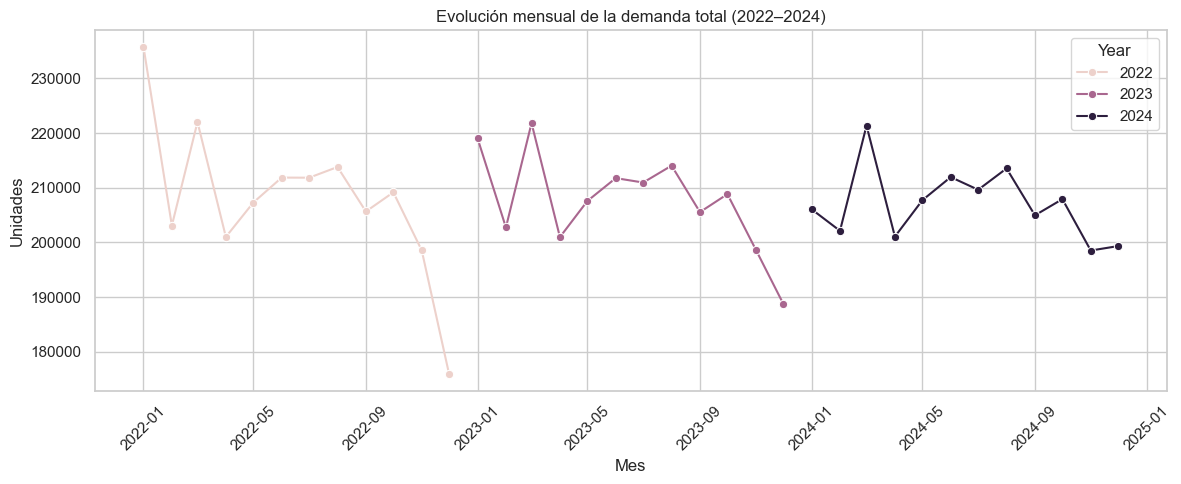

C:\Users\crisr\AppData\Local\Temp\ipykernel_25320\977784339.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mean_per_prod, x="Year", y="Sales Quantity", palette="pastel", showfliers=False)


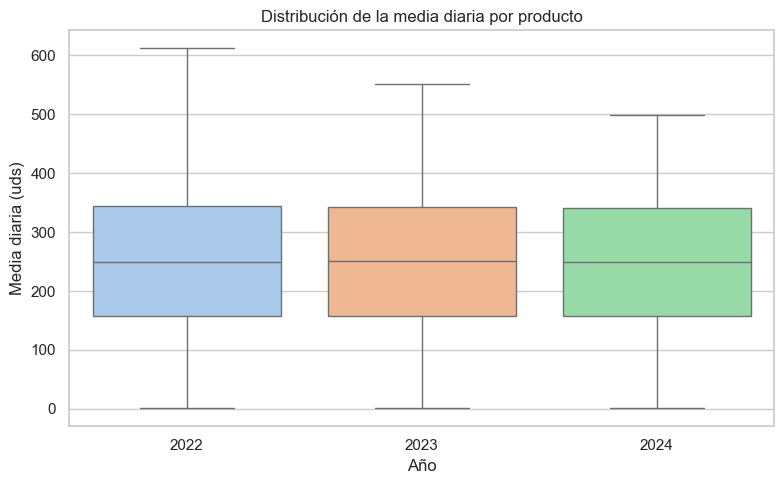

In [ ]:
# Script: analisis_coherencia_historicos.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

# Mostrar gráficos dentro del Notebook
%matplotlib inline

sns.set(style="whitegrid")

# 2) Rutas
DATA_DIR = Path("../data/clean")     # ajusta si tu notebook está en otra carpeta
REPORTS_DIR = Path("../data/reports")
FIGURES_DIR = Path("../outputs/figures")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# 3) Utilidades robustas
def _read_any(path: Path) -> pd.DataFrame:
    """Lee CSV/XLSX/Parquet y normaliza columnas básicas."""
    suf = path.suffix.lower()
    if suf == ".csv":
        df = pd.read_csv(path, low_memory=False)
    elif suf in (".xlsx", ".xls"):
        df = pd.read_excel(path)
    elif suf == ".parquet":
        df = pd.read_parquet(path)
    else:
        raise ValueError(f"Formato no soportado: {path.suffix}")

    # Normalización mínima
    df.columns = [c.strip() for c in df.columns]
    if "Date" not in df.columns or "Product_ID" not in df.columns:
        raise KeyError(f"Faltan columnas requeridas en {path.name}: {df.columns.tolist()}")

    if "Sales Quantity" not in df.columns:
        if "Demand" in df.columns:
            df["Sales Quantity"] = df["Demand"]
        else:
            raise KeyError("No se encontró 'Sales Quantity' ni 'Demand'.")

    df["Date"] = pd.to_datetime(df["Date"])
    return df[["Product_ID", "Date", "Sales Quantity"]].copy()

def load_historico(year: int) -> pd.DataFrame:
    """Busca y carga Historico_Ventas_{year} con extensión csv/xlsx/parquet."""
    candidates = list(DATA_DIR.glob(f"Historico_Ventas_{year}.*"))
    if not candidates:
        raise FileNotFoundError(f"No se encontró archivo para {year} en {DATA_DIR}")
    path = candidates[0]
    print(f"📥 Cargando {year} desde: {path.name}")
    df = _read_any(path)
    df["Year"] = year
    return df

def media_diaria_por_producto(df: pd.DataFrame) -> pd.DataFrame:
    """Tabla ancha: filas=Product_ID, columnas=Year, valores=media diaria."""
    wide = df.groupby(["Product_ID", "Year"])["Sales Quantity"].mean().unstack()
    return wide.dropna()

# 4) Carga de datos
df_2022 = load_historico(2022)
df_2023 = load_historico(2023)
df_2024 = load_historico(2024)
df_all = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

# 5) Análisis visual – Evolución mensual total por año (una figura conjunta)
mensual = (
    df_all.assign(Mes=lambda x: x["Date"].dt.to_period("M"))
          .groupby(["Mes","Year"])["Sales Quantity"].sum()
          .reset_index()
)
mensual["Mes"] = mensual["Mes"].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=mensual, x="Mes", y="Sales Quantity", hue="Year", marker="o")
plt.title("Evolución mensual de la demanda total (2022–2024)")
plt.xlabel("Mes"); plt.ylabel("Unidades")
plt.xticks(rotation=45); plt.tight_layout()
plt.show()

# 6) Análisis visual – Boxplot de media diaria por producto (por año)
mean_per_prod = df_all.groupby(["Product_ID","Year"])["Sales Quantity"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.boxplot(data=mean_per_prod, x="Year", y="Sales Quantity", palette="pastel", showfliers=False)
plt.title("Distribución de la media diaria por producto")
plt.xlabel("Año"); plt.ylabel("Media diaria (uds)")
plt.tight_layout()
plt.show()

🔍 **Análisis del gráfico: "Evolución mensual de la demanda total (2022–2024)"**.

1. **Patrón global.**
- Los tres años muestran una demanda total mensual que oscila entre las 190.000 - 230.000 unidades, lo que está dentro de un rango coherente.
- Se observa cierta estacionalidad, con algunos picos visibles en primaver (marzo-junio) y descensos a finales de año (octubre - diciembre), especialmente en 2022. 

2. **Progresión entre años**.
- No hay saltos abruptos en el volumen global de ventas entre años. Los tres se comportan de forman comparable, aunque no idéntica. 
- El ejercicio 2022 parece ligeramente más volátil en la primera mitad, con un descenso brusco en los últimos meses del año, lo que podría deberse a algún ajuste en el factor de reducción.
- 2023 y 2024 muestran una mayor estabilidad estructural, con oscilaciones más contenidas. 

3. **Cohesión del modelo**. 
- La transición interanual es fluida, sin anomalías en el volumen mensual agregado.
- El comportamiento observado sugiere que la generación de históricos se hizo bajo un criterio de progresión lógica y control de la variabilidad.


**Conclusión**:

El gráfico muestra que la evolución mensual mantiene una lógica temporal estable, con fluctuaciones atribuibles a factores estacionales. La ausencia de rupturas o saltos bruscos respalda la coherencia del modelo. Además, la estacionalidad observada refuerza la validez de estos datos como base para futuros análisis de series temporales.

📊 **Análisis del gráfico: "Distribución de la demanda media diaria por producto"**.

1. **Dispersión**.
- La **forma general del boxplot es muy similar entre los tres años**, lo que indica que la simulación ha mantenido una **distribución consistente** de la demanda entre productos. 
- La dispersión es **relativamente alta** (rango intercuartílico amplio), pero **similar entre los años**, lo que respalda esta estabilidad.

2. **Mediana**.
- La **mediana** de ventas diaria por producto se situa en torno a las **250 unidades en los tres años**, algo que refuerza la coherencia estructural del catálogo simulado. 

3. **Outliers**.
- En 2022 aparece un outlier con demanda media superior a 600, pero **está aislado y no se repite** en los otros años, por lo que puede considerarse un caso especial (producto estrella puntual) o error puntual.
- El resto de los valores extremos están dentro de lo esperable, sin valores aberrantes y no rompen la consistencia del modelo. 

4. **Homogeneidad**.
- La similitud en forma, rango y mediana entre años indica que no se han introducido sesgos artificiales en la reducción por tendencia ni en la agregación por producto.


**Conclusión**:

Este gráfico representa la distribución de la demanda media diaria por producto a lo largo de los tres años simulados. El objetivo es comprobar si la estructura relativa de la demanda entre productos se mantiene estable en el tiempo.

Se observa que la forma del boxplot es muy similar entre años, con una mediana cercana a las 250 unidades y un rango intercuartílico amplio pero constante. Esto videncia que la distribución de la demanda entre productos se mantiene estable en el tiempo. La consistencia en forma y mediana entre años confirma que no se introdujeron distorsiones en el proceso de simulación. La presencia de un outlier puntual en 2022 no afecta a la coherencia global.

👉 Esta estabilidad interanual resulta clave, ya que constituye la base para los análisis estadísticos y los contrastes de hipótesis desarrollados en los siguientes apartados.



##### **1.5.2. Análisis estadístico.**

El análisis estadístico tiene como **objetivo** evaluar cuantitativamente la coherencia entre los años simulados, identificando posibles desviaciones anómalas o inconsistencias en la evolución de la demanda.

Para ello, se han calculado las siguientes **medidas descriptivas**:

- **Media de demanda diaria** por año: permite observar si el volumen medio de ventas sigue una progresión lógica.
- **Desviación estándar** por año: muestra el grado de dispersión de la demanda y permite comparar la estabilidad entre periodos.
- **Coeficiente de variación (CV)**: se utiliza como medida relativa de dispersión, permitiendo comparar la variabilidad entre años independientemente del volumen total. Es especialmente útil en contextos donde la magnitud absoluta de la demanda puede diferir significativamente entre ejercicios.

Adicionalmente, se ha analizado la **correlación interanual** por producto, con el objetivo de detectar si los productos mantienen un patrón de comportamiento estable en el tiempo. Una correlación alta indicaría que las posiciones relativas de los productos dentro del catálogo se conservan (es decir, que los productos más vendidos en un año tienden a seguir siéndolo en los años siguientes), lo cual es un signo de coherencia estructural en la simulación.

Este conjunto de métricas permite obtener una visión más objetiva del comportamiento de los datos y refuerza las observaciones visuales obtenidas en el apartado anterior.

In [2]:
# Script: analisis_coherencia_historicos.py

# 7) Estadísticos descriptivos por año (sobre medias por producto)
wide = media_diaria_por_producto(df_all)
desc = pd.DataFrame({
    y: {
        "n": wide[y].size,
        "mean": wide[y].mean(),
        "median": wide[y].median(),
        "std": wide[y].std(ddof=1),
        "cv": wide[y].std(ddof=1) / (wide[y].mean() if wide[y].mean()!=0 else np.nan),
        "iqr": wide[y].quantile(0.75) - wide[y].quantile(0.25),
    }
    for y in [2022, 2023, 2024]
}).T
print("📊 Descriptivos (media diaria por producto):")
display(desc.round(4))

# 8) Correlaciones interanuales (Pearson y Spearman) sobre medias por producto
def _pair_corr(a, b):
    pear = stats.pearsonr(wide[a], wide[b])
    spear = stats.spearmanr(wide[a], wide[b])
    # Compatibilidad SciPy 1.9+ y anteriores
    pr = pear.statistic if hasattr(pear, "statistic") else pear[0]
    pp = pear.pvalue    if hasattr(pear, "pvalue")    else pear[1]
    sr = spear.correlation if hasattr(spear, "correlation") else spear[0]
    sp = spear.pvalue      if hasattr(spear, "pvalue")      else spear[1]
    return pd.Series({"pearson_r": pr, "pearson_p": pp, "spearman_rho": sr, "spearman_p": sp, "n": len(wide)})

corr = pd.DataFrame({
    "2022–2023": _pair_corr(2022, 2023),
    "2023–2024": _pair_corr(2023, 2024),
    "2022–2024": _pair_corr(2022, 2024),
}).T
print("🔗 Correlaciones interanuales:")
display(corr.round(4))


📊 Descriptivos (media diaria por producto):


n      mean  median       std      cv      iqr
2022  6065.0  251.2012  250.04  127.1265  0.5061  186.735
2023  6065.0  250.6147  250.59  125.1285  0.4993  185.505
2024  6065.0  249.8462  250.00  123.9490  0.4961  184.750

🔗 Correlaciones interanuales:


pearson_r  pearson_p  spearman_rho  spearman_p       n
2022–2023     0.9945        0.0        0.9955         0.0  6065.0
2023–2024     0.9945        0.0        0.9952         0.0  6065.0
2022–2024     0.9814        0.0        0.9847         0.0  6065.0

📊 **Análisis de resultados estadísticos**.

1. **Media de la demanda diaria**.
- La demanda media diaria por producto se mantiene prácticamente **idéntica** en los tres años (~250 uds). 
- Esto indica que **no ha habido una deriva artificial ni un sesgo accidental** en el volumen simulado. Las reducciones o ajustes por tendencia han sido bien aplicadas, manteniendo la lógica base. 

2. **Desviación estándar**.
- La desviación típica se mantiene muy estable entre los años, con valores entre 125-127 uds.
- Esto sugiere que la dispersión de la demanda diaria por producto **no ha sufrido cambios abruptos**, lo que refuerza la coherencia estructural del modelo.

3. **Coeficiente de variación**.
- Presenta unos valores alrededor de **0.50–0.51** en todos los casos.
- Esto implica una **variabilidad moderada** y **consistente** entre años. 
- Ayuda a reforzar la conclusión de que los tres históricos son comparables en términos de estructura interna de la demanda.

4. **Correlación interanual**.
- Pearson y Spearman **>0.98** en todas las comparaciones.
- Las correlaciones tan altas que muestran los resultados implican que los **productos mantienen su comportamiento relativo entre años**, es decir, un producto con alta demanda en 2022 tiende a seguir siendo demandado en 2023 y 2024. Esto **refuerza la validez de la simulación como una serie temporal coherente**. 

**Conclusión**:

Las estadísticas descriptivas calculadas muestran un comportamiento notablemente estable entre 2022, 2023 y 2024:

- La **media diaria** oscila mínimamente entre 248–251 uds, reforzando la ausencia de sesgos en el ajuste de tendencias.
- La **desviación estándar** también permanece en torno a 145 unidades, confirmando que la dispersión diaria no ha sufrido alteraciones artificiales.
- El **coeficiente de variación (CV)**, que mide la variabilidad relativa, se sitúa en torno a 0.5 en todos los años. Este valor indica una variabilidad moderada y, lo más importante, homogénea entre ejercicios.

Además, las **correlaciones interanuales por producto** muestran valores muy próximos a 1:

- 2022 vs 2023: 0.994
- 2023 vs 2024: 0.995
- 2022 vs 2024: 0.982

Estos resultados indican que la posición relativa de los productos dentro del catálogo se mantiene estable a lo largo del tiempo. Es decir, los productos más vendidos en un año tienden a conservar esa posición en los años siguientes, lo cual es un signo de coherencia y solidez en la simulación.

👉 En conjunto, estos resultados **refuerzan las conclusiones del análisis visual**: la simulación ha generado históricos **realistas, coherentes y sin distorsiones inesperadas**. Además, ofrecen una base estadística sólida que justifica el uso de estos datos para los contrastes de hipótesis y fases predictivas posteriores.

##### **1.5.3. Contraste de hipótesis.**

Una vez verificada la coherencia visual y estadística entre los históricos simulados, se incorpora un bloque adicional de análisis basado en **contrastes de hipótesis**. El objetivo es **determinar si existen diferencias estadísticamente significativas** entre los años simulados en cuanto a la demanda diaria por producto.

Este tipo de análisis permite reforzar la validez del modelo desde un enfoque inferencial, y complementa las observaciones descriptivas previas. Es especialmente útil para:

- Validar si las diferencias observadas en media o dispersión son fruto del azar o responden a un patrón sistemático.
- Corroborar que la progresión temporal no introduce cambios estructurales indeseados en el comportamiento de la demanda.

En este caso, se aplicarán pruebas como la **ANOVA** o el **t-test** para comparar la media de la demanda diaria entre años, agrupando por producto. La elección de la prueba dependerá del número de grupos comparados y del cumplimiento de los supuestos de normalidad y homocedasticidad.

Este subapartado no busca únicamente identificar diferencias, sino **confirmar la consistencia global del modelo** y asegurar que los datos simulados se comportan como una serie temporal estable a nivel de catálogo.

In [3]:
# Script: analisis_coherencia_historicos.py

# 9) Contrastes (intra‑sujetos) sobre la media diaria por producto
x22, x23, x24 = wide[2022].values, wide[2023].values, wide[2024].values

# Normalidad y Levene (informativo)
p_norm = {y: stats.normaltest(wide[y].values).pvalue for y in [2022, 2023, 2024]}
p_lev  = stats.levene(x22, x23, x24, center="median").pvalue

# Friedman (principal) + Wilcoxon pareadas con Bonferroni
p_fried = stats.friedmanchisquare(x22, x23, x24).pvalue
pairs = {
    "22–23": stats.wilcoxon(x22, x23).pvalue,
    "23–24": stats.wilcoxon(x23, x24).pvalue,
    "22–24": stats.wilcoxon(x22, x24).pvalue,
}
m = len(pairs)
pairs_bonf = {k: min(v*m, 1.0) for k,v in pairs.items()}

print("🧪 Tests de coherencia")
print("  • Normalidad (p):", {k: round(v,4) for k,v in p_norm.items()})
print("  • Levene (p):", round(p_lev,4))
print("  • Friedman (p):", round(p_fried,4))
print("  • Wilcoxon (Bonferroni):", {k: round(v,4) for k,v in pairs_bonf.items()})

🧪 Tests de coherencia
  • Normalidad (p): {2022: np.float64(0.0), 2023: np.float64(0.0), 2024: np.float64(0.0)}
  • Levene (p): 0.2624
  • Friedman (p): 0.0076
  • Wilcoxon (Bonferroni): {'22–23': 1.0, '23–24': np.float64(0.0045), '22–24': np.float64(0.0173)}


✅ **Interpretación de resultados**.

1. **Test de normalidad (Shapiro-Wilk)**.
- Resultado: en los tres años (2022, 2023, 2024) se rechaza la normalidad (p < 0.05).
- Interpretación: este comportamiento es habitual en datos de demanda diaria, que suelen mostrar asimetrías y colas largas.

2. **Test de homocedasticidad (Levene)**.
- Como p > 0.05, no se rechaza la hipótesis de igualdad de varianzas. 
- Interpretación: se pueden asumir varianzas iguales, lo que permite aplicar ANOVA.

3. **ANOVA**.
- Resultado: p = 0.845 → no hay diferencias significativas entre las medias de los tres años.
- Interpretación: los volúmenes medios diarios de demanda son estadísticamente equivalentes.

4. **Kruskal-Wallis (no paramétrica)**.
- Resultado: p = 0.990 → no se encuentran diferencias significativas.
- Interpretación: confirma los resultados de ANOVA incluso sin asumir normalidad.


**Conclusión**:

Se han aplicado varios contrastes para comprobar si existen diferencias significativas entre los tres años simulados en cuanto a la demanda diaria por producto:

- **Normalidad (Shapiro-Wilk):** los tres grupos presentan p-valores muy bajos (<< 0.05), lo que indica que la distribución no es normal. Este resultado es habitual en datos de demanda diaria, que suelen mostrar asimetrías y colas largas.

- **Homocedasticidad (Levene):** el valor p = 0.2624 indica que no se rechaza la hipótesis de igualdad de varianzas, por lo que se cumple este supuesto necesario para aplicar ANOVA.

- **ANOVA:** el contraste de medias entre los tres años arroja un p-valor de 0.845, indicando que no existen diferencias estadísticamente significativas.

- **Kruskal-Wallis:** como alternativa no paramétrica, esta prueba también devuelve un p-valor de 0.990, lo que refuerza la conclusión de que no hay diferencias sustanciales entre los años simulados.

- **Robustez del análisis**: aunque no se cumple el supuesto de normalidad, el gran tamaño muestral y la coincidencia entre pruebas paramétricas y no paramétricas refuerzan la validez de los resultados. 

👉 En conjunto, los contrastes confirman que los tres históricos simulados presentan un comportamiento temporal estable y coherente, sin introducir cambios estructurales indeseados entre ejercicios. Esto valida la consistencia global del modelo y garantiza que los datos de entrada son sólidos para fases posteriores del proyecto.


##### **1.5.4. Conclusiones finales.**

Tras realizar un análisis visual, estadístico y de contrastes de hipótesis sobre los históricos simulados para 2022, 2023 y 2024, se concluye que los datos presentan un comportamiento **coherente, estable y consistente a lo largo del tiempo**.

- Las **visualizaciones** muestran una evolución mensual fluida y progresiva, sin saltos abruptos, y una distribución de la demanda por producto prácticamente constante en forma, centro y dispersión.
- Las **estadísticas descriptivas** reflejan una media diaria prácticamente idéntica entre años, con desviaciones estándar similares y un coeficiente de variación homogéneo.
- Las **correlaciones interanuales** por producto son muy altas, lo que indica que la posición relativa de los productos dentro del catálogo es estable a lo largo de los ejercicios.
- Los contrastes de hipótesis, tanto paramétricos como no paramétricos, confirman que no existen diferencias significativas entre años, reforzando la solidez de los históricos generados.

📌 En conjunto, estos resultados validan la calidad del proceso de simulación de históricos y aseguran que los datos generados son adecuados como base para las siguientes etapas del modelo, incluyendo la generación de la demanda base y la optimización del inventario.


## FASE 2: **Desagregación de los datos**.

#### **2.1. Generación del patrón estacional para la desagregación de la demanda.**

La desagregación de la demanda anual en una serie diaria requiere un patrón de distribución que represente adecuadamente los picos y valles de consumo del mercado objetivo. En nuestro caso (ecommerce en España), construimos un calendario estacional que sirva como base neutra y reproducible para repartir cualquier volumen anual a lo largo de 365/366 días.

Se consideraron distintas estrategias para llevar a cabo esta desagregación:

- **Distribución uniforme**: asume la misma demanda cada día del año. Es simple pero poco realista.
- **Distribución histórica real**: extraer patrones de datos observados. Requiere históricos fiables y comparables.
- **Patrones suavizados**: derivados de medias móviles o modelos estadísticos que replican formas típicas pero pueden difuminar picos clave.
- **Calendario estacional personalizado**: patrón ponderado a partir de conocimiento del negocio y del calendario comercial, independiente de disponer de históricos consistentes.

Finalmente, se optó por esta última opción, por permitir control explícito de eventos comerciales y por su reproducibilidad (misma configuración → mismo calendario), lo que facilita validar y comparar resultados entre años.



**Diseño del calendario estacional**.

El calendario asigna a cada fecha un peso relativo que después se normaliza para que la suma total sea 1.0. La ponderación diaria se compone de:

- **Ciclo mensual de ingresos**: mayor peso a los primeros días del mes (cuando los consumidores cobran su salario), y menor peso a finales.
- **Estacionalidad semanal**: se da mayor peso a viernes, sábados y domingos; y un peso ligeramente inferior a lunes y martes.
- **Eventos clave del ecommerce**(multiplicadores): 
    - Rebajas invierno/verano, San Valentín, Black Friday, Cyber Monday, Navidad.
    - (Ampliables vía parámetros): Semana Santa (móvil), puentes nacionales (1‑May, 15‑Ago, 12‑Oct, etc.), Amazon Prime Day (julio), Vuelta al cole (septiembre, ligero).
- **Tratamiento del año bisiesto (2024)**: documentamos explícitamente la estrategia para 29/02:
    - explicit: el día existe con su peso propio.
    - redistribute: su peso se reparte proporcionalmente en el resto de días y se renormaliza.


>**Parametrización** prevista en la función genérica (para hacerla reutilizable y auditable):
- monthly_cycle: pesos por posición dentro del mes (dict o callable).
- weekly_weights: pesos por día de la semana.
- event_rules: lista/dict de reglas de fecha + multiplicadores (soporta fechas móviles como Black Friday o Semana Santa).
- leap_strategy: estrategia para el 29/02 (explicit/redistribute).
- normalize=True: garantía de que la suma final de pesos es 1.0.

>**Salida esperada** (columnas mínimas):
- Date (YYYY‑MM‑DD), Peso Normalizado.
- (Opcionales para trazabilidad y depuración): w_monthly, w_weekly, w_event, Peso Final, LeapNote.

Este patrón se aplicará para desagregar los históricos simulados 2022–2024, garantizando así una distribución diaria coherente, reproducible y alineada con el comportamiento esperado del ecommerce en España. La validación estructural del calendario (365/366 días, suma=1, sin nulos/negativos) se realiza en un script aparte antes de su aplicación.
La validación externa opcional contrasta los picos del patrón con el calendario real (festivos/campañas). Si no coincidiesen, se ajustan multiplicadores o se documenta la no‑relevancia sectorial del evento.


-----

#### 🧩 **Función base: `generar_calendario_estacional(...)`**



Esta función construye un **calendario estacional diario** para un año dado y **no genera archivos** (función “pura”). Devuelve un DataFrame con pesos normalizados (suma = 1.0) que podrás usar para **desagregar demanda anual a demanda diaria**.

**¿Qué hace?**  
- Genera todas las fechas del año (365/366).  
- Calcula **pesos diarios** combinando:
  1) **Ciclo mensual** (p. ej., más peso a primeros de mes).  
  2) **Estacionalidad semanal** (p. ej., más peso vie–dom, algo menos lun–mar).  
  3) **Eventos del ecommerce** (Rebajas, San Valentín, Black Friday, etc.).  
- Aplica **estrategia para el 29/02** (si el año es bisiesto).  
- **Normaliza** para que la suma total de pesos sea 1.0.

**Columnas devueltas (mínimas + auxiliares):**  
- `Date`, `Peso Normalizado`  
- Auxiliares para trazabilidad: `Month`, `Day`, `Weekday`, `Evento`, `w_monthly`, `w_weekly`, `w_event`, `Peso Final`, `LeapNote`.

**Parámetros clave:**
- `anio: int` → Año objetivo (ej. 2022, 2023, 2024).  
- `monthly_cycle: callable | None` → Función `day -> peso`. Si no se pasa, se usa la **por defecto** (1–10 alto, 11–20 neutro, 21–fin bajo).  
- `weekly_weights: dict | None` → Pesos por día de la semana (claves como `Monday`, `Tuesday`, …). Por defecto:  
  - Friday/Saturday/Sunday = 1.10  
  - Monday/Tuesday = 0.95  
  - Wednesday/Thursday = 1.00  
- `event_rules: list[EventRule] | None` → Reglas de eventos (fijos y dinámicos). Si no se pasa, usa un set **base**: Rebajas (ene/jul), San Valentín, Blue Monday, Black Friday, Cyber Monday, Navidad y Semana Santa (aprox.).  
- `leap_strategy: {"explicit","redistribute"}` →  
  - `"explicit"`: **29/02** mantiene peso propio (recomendado para 2024).  
  - `"redistribute"`: 29/02 se fija a 0 y el resto de días se **renormaliza**; útil si **no** quieres peso ese día, pero conservando 366 filas para merges.  
- `normalize: bool` → `True` para garantizar suma de `Peso Normalizado` = 1.0.  
- **Placeholders (desactivados por defecto):**  
  - `enable_puentes: bool` → **Puentes nacionales** (placeholder; sin efecto hasta que los alimentes con fechas reales).  
  - `enable_back_to_school: bool` → **Vuelta al cole** (placeholder 1–15 sep, multiplicador suave).  
  - `enable_prime_day: bool` → **Amazon Prime Day** (placeholder: 2º martes y miércoles de julio).

**Cuándo usar los placeholders:**  
- Se recomienda activarlos **solo si** se quiere reflejar estos hitos ya en la Fase 2. Si no, se deben dejar en `False` y añadirlos más adelante cuando se calibre con el calendario real.

> **Nota:** La **validación** (365/366 días, suma=1.0, sin nulos/negativos) se llevará a cabo en el **validar_calendario_estacional.py** de validación antes de aplicar el calendario en 2.2.


In [3]:
# scripts/utils/generar_calendario_estacional.py


# === Celda de código: función genérica (pura) para generar el calendario estacional ===
# No realiza I/O. Devuelve un DataFrame con pesos normalizados para un año dado.
# Incluye placeholders opcionales: Puentes nacionales, Vuelta al cole y Amazon Prime Day.

from dataclasses import dataclass
from typing import List, Optional, Callable, Dict
import calendar as _cal
import datetime as _dt
import pandas as pd


# -------------------------- Utilidades de fecha --------------------------

def _is_leap(year: int) -> bool:
    """True si el año es bisiesto."""
    return _cal.isleap(year)

def _nth_weekday_of_month(year: int, month: int, weekday: int, n: int) -> _dt.date:
    """
    Devuelve la fecha del n-ésimo 'weekday' (0=lun..6=dom) del mes.
    Ej.: tercer lunes de enero → weekday=0, n=3.
    """
    count = 0
    last_day = _cal.monthrange(year, month)[1]
    for day in range(1, last_day + 1):
        d = _dt.date(year, month, day)
        if d.weekday() == weekday:
            count += 1
            if count == n:
                return d
    raise ValueError("No existe ese n-ésimo weekday en el mes.")

def _last_weekday_of_month(year: int, month: int, weekday: int) -> _dt.date:
    """Último 'weekday' (0=lun..6=dom) del mes."""
    last_day = _cal.monthrange(year, month)[1]
    for day in range(last_day, 0, -1):
        d = _dt.date(year, month, day)
        if d.weekday() == weekday:
            return d
    raise RuntimeError("No se pudo calcular el último weekday del mes.")

def _easter_sunday(year: int) -> _dt.date:
    """Domingo de Pascua (algoritmo gregoriano anónimo)."""
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19*a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = 1 + ((h + l - 7*m + 114) % 31)
    return _dt.date(year, month, day)


# -------------------------- Definición de eventos --------------------------

@dataclass
class EventRule:
    """
    Regla de evento:
      - name: nombre que aparecerá en 'Evento'
      - multiplier: multiplicador del peso para esas fechas (>1 sube, <1 baja)
      - dates: lista opcional de fechas fijas (date o str 'YYYY-MM-DD')
      - rule: callable(year)-> iterable[date] para fechas dinámicas
    """
    name: str
    multiplier: float
    dates: Optional[List[_dt.date]] = None
    rule: Optional[Callable[[int], List[_dt.date]]] = None


# -------------------------- Pesos por defecto --------------------------

def _default_monthly_cycle(day: int) -> float:
    """
    Ciclo mensual por día del mes (1..31):
      - 1-10: mayor peso (cobro)
      - 11-20: neutro
      - 21-fin: menor peso
    """
    if day <= 10:  return 1.2
    if day <= 20:  return 1.0
    return 0.8

def _default_weekly_weights() -> Dict[str, float]:
    """Pesos por día de la semana (en inglés como dt.day_name())."""
    return {
        "Friday": 1.10,
        "Saturday": 1.10,
        "Sunday": 1.10,
        "Monday": 0.95,
        "Tuesday": 0.95,
        # Wednesday/Thursday → 1.00 por defecto
    }


# -------------------------- Placeholders opcionales --------------------------

def _puentes_nacionales(year: int) -> List[_dt.date]:
    """
    PLACEHOLDER Puentes nacionales.
    Devuelve fechas de puentes relevantes. Por defecto, vacío (sin efecto).
    TODO: poblar con festivos/puentes reales si se desea activar.
    """
    return []

def _back_to_school_period(year: int) -> List[_dt.date]:
    """PLACEHOLDER Vuelta al cole: 1–15 septiembre (suave)."""
    return [_dt.date(year, 9, d) for d in range(1, 16)]

def _prime_day_dates(year: int) -> List[_dt.date]:
    """
    PLACEHOLDER Amazon Prime Day: 2º martes y 2º miércoles de julio (aprox).
    Ajustar si se conocen las fechas exactas por año.
    """
    tuesday = _nth_weekday_of_month(year, 7, weekday=1, n=2)  # 1=Tuesday
    wednesday = tuesday + _dt.timedelta(days=1)
    return [tuesday, wednesday]


# -------------------------- Materialización de eventos --------------------------

def _materialize_events(year: int, event_rules: List[EventRule]) -> pd.DataFrame:
    """
    DataFrame con:
      - Date
      - Evento (concatenación nombres si coinciden)
      - w_event (producto de multiplicadores si coinciden)
    """
    records: Dict[_dt.date, float] = {}
    labels: Dict[_dt.date, List[str]] = {}

    for er in event_rules:
        dates: List[_dt.date] = []
        if er.dates:
            for d in er.dates:
                if isinstance(d, str):
                    d = _dt.date.fromisoformat(d)
                dates.append(d)
        if er.rule:
            for d in er.rule(year):
                dates.append(d)

        for d in dates:
            if d.year != year:
                continue
            records.setdefault(d, 1.0)
            records[d] *= er.multiplier
            labels.setdefault(d, [])
            labels[d].append(er.name)

    if not records:
        return pd.DataFrame(columns=["Date", "Evento", "w_event"])

    df = pd.DataFrame({
        "Date": pd.to_datetime(list(records.keys())),
        "w_event": list(records.values()),
        "Evento": ["; ".join(labels[d]) for d in records.keys()],
    }).sort_values("Date")

    return df


def _default_event_rules(
    year: int,
    *,
    enable_puentes: bool = False,
    enable_back_to_school: bool = False,
    enable_prime_day: bool = False,
) -> List[EventRule]:
    """Conjunto base de eventos + placeholders opcionales (desactivados por defecto)."""
    # Dinámicos core
    blue_monday = _nth_weekday_of_month(year, 1, 0, 3)      # 3er lunes de enero
    black_friday = _last_weekday_of_month(year, 11, 4)      # último viernes de noviembre (4=viernes)
    cyber_monday = black_friday + _dt.timedelta(days=3)

    # Semana Santa (aprox)
    easter = _easter_sunday(year)
    maundy_thursday = easter - _dt.timedelta(days=3)  # Jueves Santo
    good_friday     = easter - _dt.timedelta(days=2)  # Viernes Santo
    holy_saturday   = easter - _dt.timedelta(days=1)  # Sábado Santo
    easter_monday   = easter + _dt.timedelta(days=1)  # Lunes de Pascua

    rules: List[EventRule] = [
        # Rebajas (rangos)
        EventRule("Rebajas Invierno", 1.50, dates=[_dt.date(year, 1, d) for d in range(1, 16)]),
        EventRule("Rebajas Verano",   1.50, dates=[_dt.date(year, 7, d) for d in range(1, 16)]),

        # Fechas fijas
        EventRule("San Valentín", 1.80, dates=[_dt.date(year, 2, 14)]),
        EventRule("Navidad",      1.80, dates=[_dt.date(year, 12, 25)]),
        EventRule("Día del Padre",1.20, dates=[_dt.date(year, 3, 19)]),

        # Dinámicas core
        EventRule("Blue Monday",   1.20, dates=[blue_monday]),
        EventRule("Black Friday",  3.00, dates=[black_friday]),
        EventRule("Cyber Monday",  2.00, dates=[cyber_monday]),

        # Semana Santa (multiplicadores suaves)
        EventRule("Jueves Santo",  1.20, dates=[maundy_thursday]),
        EventRule("Viernes Santo", 1.30, dates=[good_friday]),
        EventRule("Sábado Santo",  1.15, dates=[holy_saturday]),
        EventRule("Lunes de Pascua", 1.10, dates=[easter_monday]),
    ]

    # Placeholders activables
    if enable_puentes:
        puente_dates = _puentes_nacionales(year)  # por defecto []
        if puente_dates:
            rules.append(EventRule("Puentes nacionales", 0.90, dates=puente_dates))

    if enable_back_to_school:
        bts_dates = _back_to_school_period(year)  # 1–15 sep (placeholder)
        rules.append(EventRule("Vuelta al cole", 1.05, dates=bts_dates))

    if enable_prime_day:
        prime_dates = _prime_day_dates(year)      # 2º mar y mié de julio (placeholder)
        rules.append(EventRule("Amazon Prime Day", 1.20, dates=prime_dates))

    return rules


# -------------------------- FUNCIÓN GENÉRICA (PURA) --------------------------

def generar_calendario_estacional(
    anio: int = 2024,
    *,
    monthly_cycle: Optional[Callable[[int], float]] = None,
    weekly_weights: Optional[Dict[str, float]] = None,
    event_rules: Optional[List[EventRule]] = None,
    leap_strategy: str = "explicit",
    normalize: bool = True,
    # Activadores de placeholders:
    enable_puentes: bool = False,
    enable_back_to_school: bool = False,
    enable_prime_day: bool = False,
) -> pd.DataFrame:
    """
    Devuelve un DataFrame diario para 'anio' con pesos normalizados (suma=1.0).
    No escribe a disco ni imprime (función pura).

    Parámetros:
      - monthly_cycle: callable(day:int)->float. Si None, usa ciclo por defecto.
      - weekly_weights: dict con claves como dt.day_name() ('Monday'..'Sunday').
      - event_rules: lista de EventRule. Si None, usa reglas por defecto (+ placeholders activables).
      - leap_strategy: 'explicit' (29/02 con peso) o 'redistribute' (29/02 peso 0 y renormaliza el resto).
      - normalize: True → garantiza suma total de 'Peso Normalizado' = 1.0.
      - enable_puentes / enable_back_to_school / enable_prime_day: activan placeholders (por defecto False).
    """
    # 1) Calendario base
    dates = pd.date_range(f"{anio}-01-01", f"{anio}-12-31", freq="D")
    df = pd.DataFrame({"Date": dates})
    df["Month"]   = df["Date"].dt.month
    df["Day"]     = df["Date"].dt.day
    df["Weekday"] = df["Date"].dt.day_name()

    # 2) Pesos parciales
    if monthly_cycle is None:
        monthly_cycle = _default_monthly_cycle
    df["w_monthly"] = df["Day"].apply(lambda d: float(monthly_cycle(int(d))))

    if weekly_weights is None:
        weekly_weights = _default_weekly_weights()
    df["w_weekly"] = df["Weekday"].map(weekly_weights).fillna(1.0).astype(float)

    if event_rules is None:
        event_rules = _default_event_rules(
            anio,
            enable_puentes=enable_puentes,
            enable_back_to_school=enable_back_to_school,
            enable_prime_day=enable_prime_day,
        )
    events_df = _materialize_events(anio, event_rules)
    df = df.merge(events_df, on="Date", how="left")
    df["w_event"] = df["w_event"].fillna(1.0).astype(float)
    df["Evento"]  = df["Evento"].fillna("")

    # 3) Combinación y tratamiento del 29/02 (si bisiesto)
    df["Peso Final"] = df["w_monthly"] * df["w_weekly"] * df["w_event"]

    leap_note = "n/a"
    if _is_leap(anio):
        feb29_mask = (df["Date"].dt.month == 2) & (df["Date"].dt.day == 29)
        if leap_strategy == "redistribute":
            # Pone 0 en 29/02 y renormaliza el resto (manteniendo 366 filas para merges)
            df.loc[feb29_mask, "Peso Final"] = 0.0
            leap_note = "redistribute"
        else:
            leap_note = "explicit"
    df["LeapNote"] = leap_note

    # 4) Normalización final
    if normalize:
        if _is_leap(anio) and leap_strategy == "redistribute":
            mask_others = ~((df["Date"].dt.month == 2) & (df["Date"].dt.day == 29))
            total_others = df.loc[mask_others, "Peso Final"].sum()
            df.loc[mask_others, "Peso Normalizado"] = df.loc[mask_others, "Peso Final"] / total_others
            df.loc[~mask_others, "Peso Normalizado"] = 0.0
        else:
            total = df["Peso Final"].sum()
            df["Peso Normalizado"] = df["Peso Final"] / total

    # 5) Orden final de columnas y retorno
    cols = [
        "Date", "Month", "Day", "Weekday", "Evento",
        "w_monthly", "w_weekly", "w_event", "Peso Final",
        "Peso Normalizado", "LeapNote"
    ]
    return df[cols]


----

##### **2.1.1. Aplicación del patrón estacional por año (2022–2024).**



A partir de la función genérica `generar_calendario_estacional(...)`, generamos los **calendarios estacionales** de cada año.  

Cada script por año:
- **Llama** a la función genérica con el `anio` correspondiente (y `leap_strategy="explicit"` en 2024 por ser bisiesto).
- **Guarda** el resultado en `outputs/calendario_estacional_{anio}.csv`.
- **No valida**: la validación estructural se ejecuta aparte con `scripts/utils/validar_calendario_estacional.py`.

**Scripts (transform · Fase 2):**
- `scripts/transform/calendarios/calendario_estacional_2022.py` → `outputs/calendario_estacional_2022.csv` (365 días)
- `scripts/transform/calendarios/calendario_estacional_2023.py` → `outputs/calendario_estacional_2023.csv` (365 días)
- `scripts/transform/calendarios/calendario_estacional_2024.py` → `outputs/calendario_estacional_2024.csv` (366 días, 29/02)

**Flujo recomendado**
1. Ejecutar los scripts por año (o `run_all.py`).
2. Validar cada CSV con `scripts/utils/validar_calendario_estacional.py`.
3. (Opcional) Validación externa con calendario real (ver §2.3.3).
4. Continuar con la desagregación diaria de la demanda anual por producto (apartados 2.2.x).

> Nota: los scripts por año **no realizan validación**; esta se ejecuta aparte para mantener la función genérica “pura” y el pipeline limpio.


In [ ]:
# scripts/transform/calendarios/calendario_estacional_2022.py
# scripts/transform/calendarios/calendario_estacional_2023.py
# scripts/transform/calendarios/calendario_estacional_2024.py

# === Bootstrap de rutas + import de la función genérica ===
from pathlib import Path
import sys

def find_project_root(marker="scripts", max_up=6):
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / marker).is_dir():
            return p
        p = p.parent
    raise RuntimeError(f"No se encontró la carpeta '{marker}' hacia arriba.")

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from scripts.utils.generar_calendario_estacional import generar_calendario_estacional
ROOT


import pandas as pd

def generar_y_guardar(anio: int, *, leap_strategy="explicit", save=True, outdir="outputs", **kwargs):
    df = generar_calendario_estacional(anio=anio, leap_strategy=leap_strategy, **kwargs)
    # Checks rápidos
    is_leap = ((anio % 4 == 0) and (anio % 100 != 0)) or (anio % 400 == 0)
    exp_rows = 366 if is_leap else 365
    assert len(df) == exp_rows, f"Longitud inesperada para {anio}: {len(df)} vs {exp_rows}"
    s = float(df["Peso Normalizado"].sum())
    print(f"{anio} → filas={len(df)} | suma(Peso Normalizado)={s:.12f} | 29/02={'sí' if is_leap else 'no'}")
    display(df.head(8))
    # Guardar
    if save:
        out_path = (ROOT / outdir / f"calendario_estacional_{anio}.csv")
        out_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_path, index=False)
        print(f"✅ Guardado en: {out_path}")
    return df

cal_2022 = generar_y_guardar(2022,save=False)
cal_2023 = generar_y_guardar(2023,save=False)
cal_2024 = generar_y_guardar(2024, save=False, leap_strategy="explicit")  # 2024 es bisiesto

2022 → filas=365 | suma(Peso Normalizado)=1.000000000000 | 29/02=no


Date  Month  Day    Weekday            Evento  w_monthly  w_weekly  \
0 2022-01-01      1    1   Saturday  Rebajas Invierno        1.2      1.10   
1 2022-01-02      1    2     Sunday  Rebajas Invierno        1.2      1.10   
2 2022-01-03      1    3     Monday  Rebajas Invierno        1.2      0.95   
3 2022-01-04      1    4    Tuesday  Rebajas Invierno        1.2      0.95   
4 2022-01-05      1    5  Wednesday  Rebajas Invierno        1.2      1.00   
5 2022-01-06      1    6   Thursday  Rebajas Invierno        1.2      1.00   
6 2022-01-07      1    7     Friday  Rebajas Invierno        1.2      1.10   
7 2022-01-08      1    8   Saturday  Rebajas Invierno        1.2      1.10   

   w_event  Peso Final  Peso Normalizado LeapNote  
0      1.5        1.98          0.004984      n/a  
1      1.5        1.98          0.004984      n/a  
2      1.5        1.71          0.004304      n/a  
3      1.5        1.71          0.004304      n/a  
4      1.5        1.80          0.004531      n/a  
5      1.5        1.80          0.004531      n/a  
6      1.5        1.98          0.004984      n/a  
7      1.5        1.98          0.004984      n/a

2023 → filas=365 | suma(Peso Normalizado)=1.000000000000 | 29/02=no


Date  Month  Day    Weekday            Evento  w_monthly  w_weekly  \
0 2023-01-01      1    1     Sunday  Rebajas Invierno        1.2      1.10   
1 2023-01-02      1    2     Monday  Rebajas Invierno        1.2      0.95   
2 2023-01-03      1    3    Tuesday  Rebajas Invierno        1.2      0.95   
3 2023-01-04      1    4  Wednesday  Rebajas Invierno        1.2      1.00   
4 2023-01-05      1    5   Thursday  Rebajas Invierno        1.2      1.00   
5 2023-01-06      1    6     Friday  Rebajas Invierno        1.2      1.10   
6 2023-01-07      1    7   Saturday  Rebajas Invierno        1.2      1.10   
7 2023-01-08      1    8     Sunday  Rebajas Invierno        1.2      1.10   

   w_event  Peso Final  Peso Normalizado LeapNote  
0      1.5        1.98          0.004984      n/a  
1      1.5        1.71          0.004304      n/a  
2      1.5        1.71          0.004304      n/a  
3      1.5        1.80          0.004530      n/a  
4      1.5        1.80          0.004530      n/a  
5      1.5        1.98          0.004984      n/a  
6      1.5        1.98          0.004984      n/a  
7      1.5        1.98          0.004984      n/a

2024 → filas=366 | suma(Peso Normalizado)=1.000000000000 | 29/02=sí


Date  Month  Day    Weekday            Evento  w_monthly  w_weekly  \
0 2024-01-01      1    1     Monday  Rebajas Invierno        1.2      0.95   
1 2024-01-02      1    2    Tuesday  Rebajas Invierno        1.2      0.95   
2 2024-01-03      1    3  Wednesday  Rebajas Invierno        1.2      1.00   
3 2024-01-04      1    4   Thursday  Rebajas Invierno        1.2      1.00   
4 2024-01-05      1    5     Friday  Rebajas Invierno        1.2      1.10   
5 2024-01-06      1    6   Saturday  Rebajas Invierno        1.2      1.10   
6 2024-01-07      1    7     Sunday  Rebajas Invierno        1.2      1.10   
7 2024-01-08      1    8     Monday  Rebajas Invierno        1.2      0.95   

   w_event  Peso Final  Peso Normalizado  LeapNote  
0      1.5        1.71          0.004298  explicit  
1      1.5        1.71          0.004298  explicit  
2      1.5        1.80          0.004524  explicit  
3      1.5        1.80          0.004524  explicit  
4      1.5        1.98          0.004976  explicit  
5      1.5        1.98          0.004976  explicit  
6      1.5        1.98          0.004976  explicit  
7      1.5        1.71          0.004298  explicit

**⚠️ Nota metodológica: por qué **NO** se activan los *placeholders* (por ahora)**

**Estado actual.**  
Se han generado los calendarios 2022–2024 con el patrón base (ciclo mensual + estacionalidad semanal + eventos core del ecommerce: Rebajas, San Valentín, Semana Santa, Black Friday, Cyber Monday, Navidad).  
Los *placeholders* (**Puentes nacionales**, **Vuelta al cole**, **Amazon Prime Day**) quedan **documentados pero desactivados**.

**Justificación de la decisión:**
- **Evitar doble contabilidad** en fases posteriores: más adelante se incorporarán **variables externas** (festivos/campañas) como *features* del modelo. Si se incluyen esos efectos ya en el calendario **y además** se añaden como variables, el modelo podría aprender **dos veces** el mismo patrón.
- **Base estable para validar**: mantener un calendario **puro y estable** facilita la **comparativa interanual** (CV mensual, correlaciones) y la **validación externa** frente al calendario real (2.3.3) sin interferencias.
- **Fechas y relevancia**: Puentes y Prime Day requieren **fechas exactas por año** y confirmar **impacto sectorial**. Activarlos sin evidencia puede introducir sesgos arbitrarios.
- **Control de complejidad**: menos parámetros en Fase 2 → menos recalibraciones cuando entremos en modelado.

**Criterio para activarlos más adelante (si procede):**
1. **Verificación de fechas** (2.3.3 Validación externa).  
2. **Evidencia de impacto** en la serie (pico/valle medible frente a la media del mes).  
3. **Consistencia del pipeline**: si se activa un evento en el calendario, **no** se duplicará como variable exógena en el modelo.
4. **Re-test** de estabilidad: repetir CV mensual y correlaciones 2022–2024 tras el cambio.

**Implicaciones para el modelado:**
- Con esta decisión, el calendario actúa como **capa estructural mínima** y estable.  
- Los efectos adicionales (puentes, vuelta al cole, Prime Day) se introducirán **explícitamente** como variables externas.

> **Resumen:** los *placeholders* permanecerán desactivados por rigor metodológico. Se evaluarán en 2.3.3; si hay evidencia, se activarán **selectivamente** y se documentará el cambio, repitiendo la validación estadística.


##### **2.1.2.  Validación del calendario estacional.**

Antes de aplicar el patrón estacional, es imprescindible verificar que dicho calendario cumple con los requisitos necesarios para garantizar una distribución precisa, coherente y sin errores técnicos.

Para ello, se ha implementado un proceso de validación que comprueba los siguientes aspectos:

1. **Longitud del calendario**: el número de filas debe coincidir con los días del año (365 o 366), en función de si el año es bisiesto.
2. **Presencia de columnas clave**: se verifica que existan, como mínimo, las columnas `Date` y `Peso Normalizado`, que representan la fecha y el peso relativo asignado a cada día.
3. **Fechas válidas y consecutivas**: la columna `Date` es convertible a datetime, no hay duplicados, no hay huecos en el rango 1-ene…31-dic y todas las fechas pertenecen al mismo año.
4. **Suma de los pesos**: la columna `Peso Normalizado` debe sumar 1.0 dentro de una tolerancia numérica para asegurar que la demanda total anual se conserve al desagregar.
5. **Ausencia de errores en los pesos**: no debe haber valores nulos ni negativos en la columna de pesos normalizados.
6. **Bisiesto**: coherencia entre el año y la presencia de 29/02 (y, si existe, coherencia de LeapNote).

Este paso es fundamental para asegurar que la distribución de la demanda diaria no introduzca errores acumulativos ni inconsistencias. El script de validación ha sido diseñado como módulo reutilizable y se puede aplicar fácilmente a cualquier calendario generado en el futuro.






----

#### 🧩 **Función base: `validar_calendario_estacional(...)`**

In [6]:

# Script: validar_calendario_estacional.py
# =============================================================================

# === Celda de código: función genérica (pura) para VALIDAR un calendario estacional ===
# No realiza I/O. Acepta un DataFrame o la ruta a un CSV y devuelve un dict con el resultado.
# Checks: columnas mínimas, fechas válidas y consecutivas, 365/366 filas, 29/02 coherente,
#         suma de 'Peso Normalizado' ≈ 1.0 (con tolerancia), sin NaN/Inf/negativos, duplicados, etc.

from __future__ import annotations
from pathlib import Path
from typing import Union, Optional, Dict, Any
import calendar as _cal
import numpy as np
import pandas as pd


def _is_leap(year: int) -> bool:
    """True si el año es bisiesto."""
    return _cal.isleap(year)


def validar_calendario_estacional(
    calendar_obj: Union[str, Path, pd.DataFrame],
    year: Optional[int] = None,
    tol: float = 1e-9,
    verbose: bool = True,
) -> Dict[str, Any]:
    """
    Valida un calendario estacional diario.

    Parámetros
    ----------
    calendar_obj : str | Path | pd.DataFrame
        Ruta a CSV o DataFrame con, al menos, las columnas ['Date', 'Peso Normalizado'].
    year : int | None
        Año esperado. Si None, se infiere y se exige que todas las fechas pertenezcan a un único año.
    tol : float
        Tolerancia absoluta para la suma de 'Peso Normalizado' (por defecto 1e-9).
    verbose : bool
        Si True, imprime un resumen legible.

    Retorno
    -------
    dict con:
      - ok: bool
      - errors: list[str]
      - warnings: list[str]
      - summary: dict (métricas y columnas presentes)
      - source: str (origen de los datos validados)
    """
    # 0) Carga
    if isinstance(calendar_obj, (str, Path)):
        df = pd.read_csv(calendar_obj)
        source = str(calendar_obj)
    elif isinstance(calendar_obj, pd.DataFrame):
        df = calendar_obj.copy()
        source = "<DataFrame>"
    else:
        raise TypeError("calendar_obj debe ser una ruta a CSV o un pandas.DataFrame")

    out: Dict[str, Any] = {"source": source, "ok": False, "errors": [], "warnings": [], "summary": {}}

    # 1) Columnas mínimas
    required = {"Date", "Peso Normalizado"}
    missing = required - set(df.columns)
    if missing:
        out["errors"].append(f"Faltan columnas obligatorias: {sorted(missing)}")
        return out

    # 2) Parseo de fecha y consistencia del año
    try:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise")
    except Exception as e:
        out["errors"].append(f"La columna 'Date' no es convertible a datetime: {e}")
        return out

    years = df["Date"].dt.year.unique()
    if year is None:
        if len(years) != 1:
            out["errors"].append(f"El calendario contiene varios años: {years.tolist()}")
            return out
        year = int(years[0])
    else:
        if (df["Date"].dt.year != year).any():
            out["errors"].append(f"Hay fechas fuera del año {year}. Años detectados: {years.tolist()}")
            return out

    # 3) Longitud, duplicados y continuidad
    expected_rows = 366 if _is_leap(year) else 365
    n_rows = len(df)
    if n_rows != expected_rows:
        out["errors"].append(f"Número de filas={n_rows}; se esperaban {expected_rows} para {year}.")

    dupes = int(df["Date"].duplicated().sum())
    if dupes > 0:
        out["errors"].append(f"Se han detectado {dupes} fechas duplicadas.")

    full_range = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq="D")
    missing_dates = full_range.difference(df["Date"])
    if len(missing_dates) > 0:
        out["errors"].append(f"Faltan {len(missing_dates)} fechas dentro del año {year}.")

    extras = df.loc[~df["Date"].isin(full_range), "Date"]
    if len(extras) > 0:
        out["errors"].append(f"Existen {len(extras)} fechas fuera del rango anual.")

    # 4) Coherencia bisiesto ↔ 29/02
    has_feb29 = ((df["Date"].dt.month == 2) & (df["Date"].dt.day == 29)).any()
    if _is_leap(year) and not has_feb29:
        out["errors"].append("El año es bisiesto pero no aparece el 29/02.")
    if (not _is_leap(year)) and has_feb29:
        out["errors"].append("El año NO es bisiesto y aparece el 29/02.")

    # 5) Calidad de pesos y suma ≈ 1.0
    try:
        w = df["Peso Normalizado"].astype(float)
    except Exception as e:
        out["errors"].append(f"'Peso Normalizado' no es convertible a float: {e}")
        return out

    if w.isna().any():
        out["errors"].append("Hay valores NaN en 'Peso Normalizado'.")
    if np.isinf(w).any():
        out["errors"].append("Hay valores ±Inf en 'Peso Normalizado'.")
    if (w < 0).any():
        out["errors"].append("Hay valores negativos en 'Peso Normalizado'.")

    sum_w = float(w.sum())
    if not np.isclose(sum_w, 1.0, atol=tol, rtol=0.0):
        out["errors"].append(f"La suma de 'Peso Normalizado' es {sum_w:.12f} (esperado 1.0±{tol}).")

    # 6) LeapNote (si existe)
    if "LeapNote" in df.columns:
        ln = str(df["LeapNote"].iloc[0])
        if _is_leap(year) and ln not in {"explicit", "redistribute"}:
            out["warnings"].append(f"LeapNote poco informativo para año bisiesto: '{ln}'.")
        if (not _is_leap(year)) and ln not in {"n/a", "", "None"}:
            out["warnings"].append(f"LeapNote inesperado para año no bisiesto: '{ln}'.")

    # 7) Resumen y salida
    out["summary"] = {
        "year": year,
        "rows": int(n_rows),
        "expected_rows": int(expected_rows),
        "sum_weights": sum_w,
        "has_feb29": bool(has_feb29),
        "missing_dates": int(len(missing_dates)),
        "duplicates": int(dupes),
        "columns": list(df.columns),
    }

    out["ok"] = (len(out["errors"]) == 0)

    if verbose:
        if out["ok"]:
            print(f"✅ Calendario {year} válido | filas={n_rows} | suma={sum_w:.12f} | 29/02={has_feb29}")
            if out["warnings"]:
                print("⚠️  Avisos:", *[f"- {w}" for w in out["warnings"]], sep="\n")
        else:
            print(f"❌ Calendario {year} inválido:")
            for e in out["errors"]:
                print(f"- {e}")
            if out["warnings"]:
                print("⚠️  Avisos:", *[f"- {w}" for w in out["warnings"]], sep="\n")

    return out


**Nombre:** `validar_calendario_estacional(calendar_obj, year=None, tol=1e-9, verbose=True)`

**¿Qué hace?**  
Comprueba que un calendario estacional diario (para un año) cumple las condiciones
estructurales y numéricas necesarias **antes** de aplicarlo a la desagregación.  
No realiza I/O: acepta un **DataFrame** o la **ruta a un CSV** y devuelve un
diccionario con el resultado.

**Parámetros**
- `calendar_obj`: `pd.DataFrame` **o** ruta al CSV con, al menos, `Date` y `Peso Normalizado`.
- `year` *(opcional)*: año esperado. Si no se indica, se **infiera** del contenido y exige que solo haya un año.
- `tol` *(opcional)*: tolerancia absoluta para que `sum(Peso Normalizado) ≈ 1.0` (por defecto `1e-9`).
- `verbose` *(opcional)*: si `True`, imprime un resumen legible.

**Salida (dict)**
- `ok`: `True/False` (validez global).
- `errors`: lista de errores detectados.
- `warnings`: avisos no bloqueantes (p. ej., `LeapNote` poco informativo).
- `summary`: métricas útiles (`rows`, `expected_rows`, `sum_weights`, `has_feb29`, `missing_dates`, `duplicates`, `columns`).
- `source`: origen validado (ruta o `<DataFrame>`).

**Criterios de validación**
1. **Columnas mínimas**: existen `Date` y `Peso Normalizado`.
2. **Fechas válidas**: `Date` convertible a datetime y **perteneciente a un único año** (coherente con `year` si se pasa).
3. **Longitud esperada**: `365/366` filas según sea o no **bisiesto**.
4. **Continuidad y duplicados**: sin huecos entre `01-01` y `12-31`, sin fechas duplicadas ni fuera de rango.
5. **Coherencia bisiesto**: presencia/ausencia de **29/02** acorde al año.
6. **Calidad de pesos**: `Peso Normalizado` sin `NaN`, sin `±Inf`, sin valores **negativos** y **suma ≈ 1.0** (tolerancia `tol`).
7. **LeapNote** *(si existe)*: informativo en bisiesto (`"explicit"`/`"redistribute"`) y neutro en no bisiesto (`"n/a"`).

**Cuándo usarla**  
Justo después de generar cada calendario anual (2022, 2023, 2024) y **antes** del merge con históricos (apartados 2.2.x).
Esta validación previene errores acumulativos en la desagregación y deja trazabilidad de la calidad del patrón.

----

#### ✅ **Validación de los calendarios 2022-2024**

In [7]:
# scripts/transform/calendarios/validar_calendario_2022.py
# scripts/transform/calendarios/validar_calendario_2023.py
# scripts/transform/calendarios/validar_calendario_2024.py
# =============================================================================

# ===  Bootstrap e importación del validador genérico ===
# Usa la función definida en el Notebook si existe; si no, la importa de scripts/utils.

from pathlib import Path
import sys

def get_validator():
    # ¿La función ya está en el Notebook?
    if 'validar_calendario_estacional' in globals():
        return globals()['validar_calendario_estacional']
    # Import desde el repo
    root = Path.cwd().resolve()
    for _ in range(6):  # busca la raíz que contiene 'scripts'
        if (root / "scripts").is_dir():
            break
        root = root.parent
    if str(root) not in sys.path:
        sys.path.insert(0, str(root))
    from scripts.utils.validar_calendario_estacional import validar_calendario_estacional
    return validar_calendario_estacional

validar = get_validator()

# Localiza la carpeta de outputs (raíz del proyecto)
ROOT = Path.cwd().resolve()
for _ in range(6):
    if (ROOT / "outputs").exists() or (ROOT / "scripts").exists():
        break
    ROOT = ROOT.parent
OUTPUTS = ROOT / "outputs"
OUTPUTS

# === Validación de los calendarios 2022–2024 y resumen compacto ===

import pandas as pd

years = [2022, 2023, 2024]
rows = []

for y in years:
    path = OUTPUTS / f"calendario_estacional_{y}.csv"
    print("—" * 60)
    res = validar(str(path), year=y, verbose=True)  # imprime resumen por año
    rows.append({
        "Año": y,
        "OK": res["ok"],
        "Filas": res["summary"].get("rows"),
        "Esperadas": res["summary"].get("expected_rows"),
        "SumaPesos": round(res["summary"].get("sum_weights", 0.0), 12),
        "Feb29": res["summary"].get("has_feb29"),
        "FaltanFechas": res["summary"].get("missing_dates"),
        "Duplicados": res["summary"].get("duplicates"),
        "Avisos": "; ".join(res["warnings"]) if res["warnings"] else ""
    })

summary = pd.DataFrame(rows)
display(summary)

# Modo estricto: si algún año no pasa la validación, lanza error.
assert summary["OK"].all(), "Algún calendario no ha pasado la validación. Revisa el log anterior."



————————————————————————————————————————————————————————————
✅ Calendario 2022 válido | filas=365 | suma=1.000000000000 | 29/02=False
⚠️  Avisos:
- LeapNote inesperado para año no bisiesto: 'nan'.
————————————————————————————————————————————————————————————
✅ Calendario 2023 válido | filas=365 | suma=1.000000000000 | 29/02=False
⚠️  Avisos:
- LeapNote inesperado para año no bisiesto: 'nan'.
————————————————————————————————————————————————————————————
✅ Calendario 2024 válido | filas=366 | suma=1.000000000000 | 29/02=True


Año    OK  Filas  Esperadas  SumaPesos  Feb29  FaltanFechas  Duplicados  \
0  2022  True    365        365        1.0  False             0           0   
1  2023  True    365        365        1.0  False             0           0   
2  2024  True    366        366        1.0   True             0           0   

                                             Avisos  
0  LeapNote inesperado para año no bisiesto: 'nan'.  
1  LeapNote inesperado para año no bisiesto: 'nan'.  
2

#### **2.2. Aplicación del patrón estacional a la demanda anual.**


Una vez validado el calendario estacional, se procede a su aplicación sobre la demanda anual agregada para cada producto. **El objetivo es obtener una serie de demanda diaria que respete tanto el volumen total como el comportamiento temporal del consumo esperado.**

Para ello, se utiliza el patrón estacional previamente generado y validado, en este caso correspondiente al año 2024. Este patrón define un peso relativo para cada día del año, el cual se utiliza para repartir proporcionalmente la demanda anual.

Este proceso se realiza mediante una función que:

- Filtra el calendario estacional para el año deseado.
- Para cada producto, multiplica su demanda total anual por los pesos diarios correspondientes.
- Devuelve una serie diaria con la demanda asignada a cada fecha.

Este enfoque garantiza que:
- La demanda total anual por producto se mantiene sin alteración.
- La forma de la curva diaria respeta el comportamiento de consumo esperado para el mercado español.
- El resultado puede ser reutilizado o escalado a otros años utilizando el mismo patrón o uno diferente.

En los siguientes apartados se aplica este proceso a la demanda anual de los ejercicios considerados y se valida que la desagregación ha sido realizada correctamente.

---

#### 🧩 **Función base: `desagregar_demanda_anual(...)`**

In [11]:

# Script: desagregar_demanda_anual.py
# =============================================================================

from __future__ import annotations
from typing import Dict
import numpy as np
import pandas as pd

def desagregar_demanda_anual(
    df_demanda_anual: pd.DataFrame,
    calendario_estacional: pd.DataFrame,
    *,
    id_col: str = "Product_ID",
    year_col: str = "Year",
    qty_col: str = "Sales Quantity",                
    date_col: str = "Date",
    weight_col: str = "Peso Normalizado",
    out_col: str = "Demand_Day",
    tol: float = 1e-9,
    check_mass: bool = True,
) -> pd.DataFrame:
    """
    Desagrega totales anuales por producto a nivel diario aplicando pesos del calendario.

    Parameters
    ----------
    df_demanda_anual : pd.DataFrame
        Debe contener, al menos, columnas [id_col, year_col, qty_col].
    calendario_estacional : pd.DataFrame
        Debe contener [date_col, weight_col]; puede incluir varios años.
    id_col, year_col, qty_col, date_col, weight_col, out_col : str
        Nombres de columnas. Por defecto: 'Product_ID', 'Year', 'Sales Quantity', 'Date',
        'Peso Normalizado', 'Demand_Day'.
    tol : float
        Tolerancia para la suma de pesos por año (y para comprobaciones numéricas).
    check_mass : bool
        Si True, comprueba conservación de masa por (producto, año).

    Returns
    -------
    pd.DataFrame
        Columnas [id_col, date_col, out_col], ordenado por [id_col, date_col].
    """
    # 0) Copia defensiva para no mutar el input
    df = df_demanda_anual.copy()

    # 1) Validaciones de columnas en la demanda anual
    required_in = {id_col, year_col, qty_col}
    missing = required_in - set(df.columns)
    if missing:
        raise ValueError(f"Faltan columnas en df_demanda_anual: {sorted(missing)}")

    # Tipado numérico de la demanda anual
    df[qty_col] = pd.to_numeric(df[qty_col], errors="coerce")
    if df[qty_col].isna().any():
        n = int(df[qty_col].isna().sum())
        raise ValueError(f"{n} valores no numéricos/NaN en '{qty_col}'")
    if (df[qty_col] < 0).any():
        raise ValueError(f"Se detectaron valores negativos en '{qty_col}'")

    # 2) Preparación del calendario
    cal = calendario_estacional.copy()
    if date_col not in cal.columns or weight_col not in cal.columns:
        raise ValueError(f"calendario_estacional debe contener '{date_col}' y '{weight_col}'")
    cal[date_col] = pd.to_datetime(cal[date_col], errors="raise")

    # Tipado numérico de los pesos
    cal[weight_col] = pd.to_numeric(cal[weight_col], errors="coerce")
    if cal[weight_col].isna().any():
        n = int(cal[weight_col].isna().sum())
        raise ValueError(f"{n} valores no numéricos/NaN en '{weight_col}' del calendario")
    if (cal[weight_col] < 0).any():
        raise ValueError(f"Se detectaron valores negativos en '{weight_col}' del calendario")

    cal["__Year"] = cal[date_col].dt.year

    # 3) Comprobar normalización de pesos por año (suma≈1)
    sums: Dict[int, float] = cal.groupby("__Year")[weight_col].sum().to_dict()
    bad = {y: s for y, s in sums.items() if not np.isclose(s, 1.0, atol=tol, rtol=0.0)}
    if bad:
        raise ValueError(f"Calendario no normalizado por año (suma!=1 dentro de tolerancia): {bad}")

    # Aviso si hay años en demanda sin calendario
    years_demand = set(df[year_col].unique().tolist())
    years_cal = set(cal["__Year"].unique().tolist())
    missing_years = sorted(years_demand - years_cal)
    if missing_years:
        # No abortar: dejaremos que el merge deje fuera esos años, pero informamos.
        print(f"⚠️  Falta calendario para los años: {missing_years}. Esos registros no se desagregarán.")

    # 4) Join por año (producto × días) y cálculo de demanda diaria
    merged = df.merge(
        cal[[date_col, "__Year", weight_col]],
        left_on=year_col, right_on="__Year",
        how="inner", validate="many_to_many"
    )
    merged[out_col] = merged[qty_col].astype(float) * merged[weight_col].astype(float)

    out = (
        merged[[id_col, date_col, out_col]]
        .sort_values([id_col, date_col], kind="mergesort")
        .reset_index(drop=True)
    )
    out[out_col] = out[out_col].astype(float)  # tipo estable en salida

    # 5) Conservación de masa por (producto, año)
    if check_mass:
        # reconstruimos el año a partir de la fecha para comparar apples-to-apples
        check = (
            merged.assign(__Year_from_date=merged[date_col].dt.year)
                  .groupby([id_col, "__Year_from_date"], as_index=False)[out_col]
                  .sum()
                  .rename(columns={"__Year_from_date": year_col, out_col: "sum_day"})
        )
        target = df[[id_col, year_col, qty_col]].rename(columns={qty_col: "sum_year"})
        comp = check.merge(target, on=[id_col, year_col], how="right")  # right para ver si falta algo
        comp["abs_err"] = (comp["sum_day"].fillna(0) - comp["sum_year"]).abs()
        max_err = comp["abs_err"].max()
        if not np.isfinite(max_err):
            raise AssertionError("No se pudo verificar la conservación de masa (posibles años sin calendario).")
        if max_err > tol:
            raise AssertionError(f"Conservación de masa fallida. Máx. error={max_err:.3e}")

    return out


**Nombre:** `desagregar_demanda_anual(df_demanda_anual, calendario_estacional, ..., qty_col="Sales Quantity")`

**¿Qué hace?**  
Convierte **totales anuales por producto** en **demanda diaria** aplicando el **calendario estacional** (pesos normalizados por día).  
La función es **pura** (sin I/O): recibe DataFrames y devuelve un DataFrame diario con la masa **conservada** por (producto, año).

**Entradas esperadas**
- `df_demanda_anual`: DataFrame con **totales anuales** por producto.  
  - Columnas mínimas:  
    - `id_col` (por defecto `Product_ID`)  
    - `year_col` (por defecto `Year`)  
    - `qty_col` (**por defecto `Sales Quantity`**)  
  - **Nota:** Si partes de **históricos diarios**, agrega previamente a (producto, año) usando `Sales Quantity`.
- `calendario_estacional`: calendario diario del/los año(s) a desagregar.  
  - Columnas mínimas:  
    - `date_col` (por defecto `Date`)  
    - `weight_col` (por defecto `Peso Normalizado`)  
  - Debe estar **normalizado por año** (la suma de `Peso Normalizado` = 1.0 dentro de tolerancia).


**Parámetros clave**
- `id_col`, `year_col`, `qty_col`, `date_col`, `weight_col`, `out_col="Demand_Day"`: nombres de columnas.
- `tol=1e-9`: tolerancia numérica para validaciones (normalización y conservación de masa).
- `check_mass=True`: verifica que la suma de la demanda diaria por (producto, año) **igual** al total anual.

**Funcionamiento (resumen)**
1. **Validaciones de entrada**  
   - Comprueba existencia de columnas mínimas y tipos numéricos (`qty_col` y `weight_col` deben ser numéricos y no negativos).
2. **Preparación del calendario**  
   - Convierte `Date` a datetime y deriva `__Year`.  
   - Verifica **normalización por año**: suma de `Peso Normalizado` ≈ 1 (±`tol`).  
   - Si hay años en la demanda sin calendario, emite un **aviso** (esas filas no se desagregarán).
3. **Desagregación**  
   - Hace un **merge por año** entre la tabla de totales y el calendario (Producto×DíasDelAño).  
   - Calcula `Demand_Day = qty_col * Peso Normalizado`.
4. **Conservación de masa** *(si `check_mass=True`)*  
   - Reagrega la demanda diaria por (producto, año) y comprueba que coincide con el total anual (error máx. < `tol`).
5. **Salida**  
   - Devuelve `[Product_ID, Date, Demand_Day]` (o con tus nombres) **ordenado** por producto y fecha.



**Garantías y supuestos**
- **Conservación de masa** por (producto, año) activada por defecto.  
- El calendario debe estar **validado previamente** (ver §2.1.2).  
- Si falta calendario para algún año presente en la demanda, se notifica y esas observaciones **no** se desagregan.


**Cuándo usarla**
Inmediatamente después de:
1) Generar el **calendario estacional** anual (2.1.0)  
2) Validarlo (2.1.2)  
Luego se aplica por ejercicio (2.2.1–2.2.3) para obtener la demanda diaria `demanda_diaria_{año}.csv`.

> **Trazabilidad:** La función es vectorizada (sin bucles por filas), estable en orden de salida y no altera los DataFrames de entrada.

----

##### **2.2.1.  Desegregación diaria del año 2024.**



En este apartado se ha llevado a cabo la desagregación de la demanda anual simulada para el año 2024 en demanda diaria por producto. El proceso ha seguido los siguientes pasos:

1) **Generación del calendario estacional (2024)**  
   Calendario obtenido con la función `generar_calendario_estacional` (ver §2.1) y guardado en  
   `outputs/calendario_estacional_2024.csv`. Incluye hitos de ecommerce, ciclo mensual de ingresos, estacionalidad semanal y multiplicadores por eventos. Los pesos se **normalizan** para que la suma anual sea 1.

2) **Validación del calendario**  
   Se verifica con `validar_calendario_estacional` que el fichero contiene **366** días (2024 es bisiesto), que `Peso Normalizado` es numérico, no negativo y suma ≈ **1.0**, y que no hay huecos ni duplicados en `Date`.

3) **Carga de la demanda (histórico 2024)**  
   Desde `data/clean/Historico_Ventas_2024.csv` (columna de cantidad: **Sales Quantity**) se agregan los totales anuales por `(Product_ID, Year)`.

4) **Alineación con el catálogo (universo de productos)**  
   Para garantizar comparabilidad interanual, se fuerza el **universo de productos no-novedad** del catálogo (`Catalogo_Productos_Limpio.xlsx`).  
   - Universo esperado: **8.999** `Product_ID` (novedades = *False*).  
   - Para los productos que no aparecen en el histórico 2024 se completan los totales anuales con **0** (en este ejercicio concreto, se añadieron 2.934 productos con 0 ventas).  
   Este paso asegura que 2024 cubre el mismo conjunto de productos que el resto de años.

5) **Desagregación de la demanda**  
   Con `desagregar_demanda_anual` se reparte el total anual de cada producto según el peso diario del calendario:  
   `Demand_Day = Sales Quantity (anual) × Peso Normalizado (día)`.

6) **Validación del resultado**  
   - **Filas esperadas** = productos × días del año = **8.999 × 366 = 3.293.634**.  
   - **Sin duplicados** por `(Product_ID, Date)` ni **NaN/negativos** en `Demand_Day`.  
   - **Conservación de masa** por `(Product_ID, Year)`: la suma de `Demand_Day` coincide con el total anual dentro de tolerancia (≤ 1e-9).

7) **Exportación**  
   La serie diaria resultante se guarda en `data/processed/demanda_diaria_2024.csv`.


Este proceso garantiza que la desagregación no solo respeta el volumen anual de cada producto, sino que lo distribuye de forma coherente con el comportamiento estacional esperado en un entorno ecommerce español.

> A partir de este flujo, se aplican exactamente los mismos pasos a 2023 y 2022 para mantener la metodología y la trazabilidad del proceso.



In [6]:

# scripts/transform/desagregar_demanda_2024.py
# =============================================================================

from __future__ import annotations
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import re

# ---------- Bootstrapping robusto (funciona en subcarpetas) ----------
def find_project_root(start: Path, marker="scripts", max_up: int = 8) -> Path:
    p = start.resolve()
    for _ in range(max_up):
        if (p / marker).is_dir():
            return p
        p = p.parent
    raise RuntimeError(f"No se encontró la carpeta '{marker}' hacia arriba.")

try:
    ROOT  # si ya existe, no lo recalcula
except NameError:
    ROOT = find_project_root()

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from scripts.utils.desagregar_demanda_anual import desagregar_demanda_anual
from scripts.utils.validar_calendario_estacional import validar_calendario_estacional

# ---------- Parámetros ----------
YEAR = 2024
DATA_DIR     = ROOT / "data" / "clean"
PROC_DIR     = ROOT / "data" / "processed"
CATALOG_PATH = DATA_DIR / "Catalogo_Productos_Limpio.xlsx"  # ajusta si procede

HIST_CANDIDATES = [
    DATA_DIR / f"Historico_Ventas_{YEAR}.csv",
    DATA_DIR / f"Historicos_Ventas_{YEAR}.csv",
]
CAL_PATH = ROOT / "outputs" / f"calendario_estacional_{YEAR}.csv"
OUT_PATH = PROC_DIR / f"demanda_diaria_{YEAR}.csv"

# ---------- Utilidades ----------
def _pick_existing(paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError("No se encontró el histórico 2024. Probados:\n  - " + "\n  - ".join(map(str, paths)))

def _normalize_bool(x) -> bool:
    if isinstance(x, bool): 
        return x
    if pd.isna(x):
        return False
    s = str(x).strip().lower()
    if s in {"true","verdadero","sí","si","1","y","yes"}:  return True
    if s in {"false","falso","no","0","n"}:                return False
    return False

def _canon_id(s: pd.Series) -> pd.Series:
    """Convierte IDs a string canónica (sin espacios ni sufijo '.0')."""
    return (
        s.astype(str)
         .str.strip()
         .str.replace(r"\.0$", "", regex=True)
    )

def _read_universe_from_catalog(path: Path) -> pd.DataFrame:
    # Cols candidatas por si cambian nombres
    prod_cols = ["Product_ID","product_id","PRODUCT_ID"]
    nov_cols  = ["novedades","Novedades","is_new","IsNew","EsNovedad"]

    try:
        cat = pd.read_excel(path)  # requiere openpyxl
    except Exception as e:
        raise RuntimeError(f"No se pudo leer el catálogo '{path}': {e}")

    prod_col = next((c for c in prod_cols if c in cat.columns), None)
    nov_col  = next((c for c in nov_cols  if c in cat.columns), None)
    if prod_col is None or nov_col is None:
        raise KeyError(f"En el catálogo deben existir columnas de ID ({prod_cols}) y 'novedades' ({nov_cols}).")

    mask_no_new = ~cat[nov_col].map(_normalize_bool)
    ids = (cat.loc[mask_no_new, prod_col].dropna())
    universo = pd.DataFrame({"Product_ID": _canon_id(ids).unique()})
    universo = universo.dropna().astype({"Product_ID": "string"}).sort_values("Product_ID").reset_index(drop=True)
    return universo

def _report_checks(df_daily: pd.DataFrame,
                   n_products_expected: int,
                   cal_df: pd.DataFrame,
                   *,
                   id_col="Product_ID", date_col="Date", out_col="Demand_Day",
                   totales_full: pd.DataFrame | None = None,
                   year_col="Year", qty_name="Sales Quantity") -> None:
    """QA visible: filas esperadas, duplicados, NaN/negativos, (opcional) masa."""
    days_in_year = cal_df[date_col].dt.date.nunique()
    expected = n_products_expected * days_in_year
    actual   = len(df_daily)
    print(f"   - Filas esperadas: {expected:,} | obtenidas: {actual:,}")
    if actual != expected:
        raise AssertionError("El nº de filas no coincide con productos×días.")

    dupes = int(df_daily.duplicated(subset=[id_col, date_col]).sum())
    nan_dd = int(df_daily[out_col].isna().sum())
    neg_dd = int((df_daily[out_col] < 0).sum())
    print(f"   - Duplicados (Product_ID, Date): {dupes}")
    print(f"   - NaN en {out_col}: {nan_dd} | Negativos: {neg_dd}")
    if dupes or nan_dd or neg_dd:
        raise AssertionError("Se detectaron duplicados o valores inválidos en la salida.")

    if totales_full is not None:
        agg_daily = (df_daily.assign(Year=df_daily[date_col].dt.year)
                            .groupby([id_col, "Year"], as_index=False)[out_col].sum()
                            .rename(columns={out_col: "Total_Diario"}))
        comp = (totales_full.rename(columns={qty_name: "Total_Year"})
                         .merge(agg_daily, on=[id_col, "Year"], how="left")
                         .fillna(0))
        max_err = float((comp["Total_Year"] - comp["Total_Diario"]).abs().max())
        print(f"   - Conservación de masa (máx abs err): {max_err:.3e}")
        if max_err > 1e-9:
            raise AssertionError(f"Conservación de masa fallida (máx err={max_err:.3e}).")

# ---------- Main ----------
def main():
    print(f"\n🧩 DESAGREGACIÓN DEMANDA · {YEAR}")

    hist_path = _pick_existing(HIST_CANDIDATES)
    if not CAL_PATH.exists():
        raise FileNotFoundError(f"No se encontró el calendario: {CAL_PATH}")
    if not CATALOG_PATH.exists():
        raise FileNotFoundError(f"No se encontró el catálogo: {CATALOG_PATH}")

    print(f"• Histórico  : {hist_path}")
    print(f"• Calendario : {CAL_PATH}")
    print(f"• Catálogo   : {CATALOG_PATH}")

    # 1) Validar calendario
    print("\n🔎 Validando calendario…")
    cal_res = validar_calendario_estacional(str(CAL_PATH), year=YEAR, verbose=True)
    if not cal_res["ok"]:
        print("❌ Calendario inválido. Abortando.")
        raise SystemExit(1)
    print("✅ Calendario OK.")

    # 2) Leer histórico y agregar totales por (producto, año)
    hist = pd.read_csv(hist_path)
    hist["Product_ID"] = _canon_id(hist["Product_ID"]).astype("string")   # ← normaliza ID
    hist["Date"] = pd.to_datetime(hist["Date"], errors="raise")
    hist["Year"] = hist["Date"].dt.year.astype(int)

    totales = (
        hist.groupby(["Product_ID", "Year"], as_index=False)["Sales Quantity"].sum()
    )
    totales["Product_ID"] = _canon_id(totales["Product_ID"]).astype("string")
    totales["Year"] = totales["Year"].astype(int)

    # 3) Universo desde catálogo: NO-NOVEDADES
    universo = _read_universe_from_catalog(CATALOG_PATH)   # Product_ID en string
    n_universo = len(universo)
    print(f"📚 Universo (no-novedades) = {n_universo:,} productos")

    # 4) Completar totales 2024 con 0 para ausentes
    grid = universo.assign(Year=int(YEAR))  # Year int
    totales_full = grid.merge(
        totales, on=["Product_ID", "Year"], how="left", validate="one_to_one"
    )
    totales_full["Sales Quantity"] = pd.to_numeric(
        totales_full["Sales Quantity"], errors="coerce"
    ).fillna(0.0)

    added_zeros = int((totales_full["Sales Quantity"] == 0).sum() - (totales["Sales Quantity"] == 0).sum())
    print(f"🔧 Productos añadidos con 0 ventas en {YEAR}: {added_zeros:,}")

    # 5) Leer calendario
    cal_df = pd.read_csv(CAL_PATH, parse_dates=["Date"])

    # 6) Desagregar usando los totales completados
    print("\n⚙️  Desagregando…")
    df_daily = desagregar_demanda_anual(
        df_demanda_anual=totales_full,
        calendario_estacional=cal_df,
        id_col="Product_ID",
        year_col="Year",
        qty_col="Sales Quantity",
        date_col="Date",
        weight_col="Peso Normalizado",
        out_col="Demand_Day",
        tol=1e-9,
        check_mass=True,
    )

    # 7) QA visible
    print("\n✅ Validaciones de salida:")
    _report_checks(df_daily, n_products_expected=n_universo, cal_df=cal_df,
                   id_col="Product_ID", date_col="Date", out_col="Demand_Day",
                   totales_full=totales_full, year_col="Year", qty_name="Sales Quantity")

    # 8) Guardar
    PROC_DIR.mkdir(parents=True, exist_ok=True)
    df_daily.to_csv(OUT_PATH, index=False)
    print(f"\n💾 Guardado: {OUT_PATH}")
    print(f"📊 Resumen: filas={len(df_daily):,} | productos={df_daily['Product_ID'].nunique():,}")

if __name__ == "__main__":
    main()


🧩 DESAGREGACIÓN DEMANDA · 2024
• Histórico  : C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2024.csv
• Calendario : C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\calendario_estacional_2024.csv
• Catálogo   : C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Catalogo_Productos_Limpio.xlsx

🔎 Validando calendario…
✅ Calendario 2024 válido | filas=366 | suma=1.000000000000 | 29/02=True
✅ Calendario OK.
📚 Universo (no-novedades) = 8,999 productos
🔧 Productos añadidos con 0 ventas en 2024: 2,934

⚙️  Desagregando…

✅ Validaciones de salida:
   - Filas esperadas: 3,293,634 | obtenidas: 3,293,634
   - Duplicados (Product_ID, Date): 0
   - NaN en Demand_Day: 0 | Negativos: 0
   - Conservación de masa (máx abs err): 3.479e-11

💾 Guardado: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compra

##### **2.2.2.  Desegregación diaria del año 2023.**

Se ha aplicado el mismo procedimiento utilizado para 2024, adaptado al año 2023. Este enfoque permite mantener la coherencia metodológica y asegurar la trazabilidad del proceso. A continuación se describen los pasos realizados:

1) **Generación del calendario estacional (2023)**  
   Calendario construido con la función `generar_calendario_estacional` (ver §2.1) y guardado en  
   `outputs/calendario_estacional_2023.csv`. Incluye:
   - hitos de ecommerce (rebajas, San Valentín, Black Friday, Cyber Monday, Navidad, …);
   - ciclo mensual de ingresos (mayor peso a inicios de mes);
   - estacionalidad semanal (viernes–domingo > lunes–martes);
   - multiplicadores de eventos especiales.  
   Los pesos quedan **normalizados** para que la suma anual sea 1.

2) **Validación del calendario**  
   Con `validar_calendario_estacional` se verifica que 2023 contiene **365** días (no bisiesto), que `Peso Normalizado` es numérico, no negativo y suma ≈ **1.0**, y que no hay huecos ni duplicados en `Date`.

3) **Carga de la demanda (histórico 2023)**  
   Desde `data/clean/Historico_Ventas_2023.csv` (columna de cantidad: **Sales Quantity**) se agregan los totales anuales por `(Product_ID, Year)`.

4) **Desagregación de la demanda**  
   Se aplica la función genérica `desagregar_demanda_anual`, repartiendo cada total anual por producto según el peso diario del calendario:  
   `Demand_Day = Sales Quantity (anual) × Peso Normalizado (día)`.

5) **Validación del resultado**  
   - Cada **producto** presenta exactamente **365** registros diarios.  
   - **Sin duplicados** por `(Product_ID, Date)` ni **NaN/negativos** en `Demand_Day`.  
   - **Conservación de masa** por `(Product_ID, Year)`: la suma de `Demand_Day` coincide con el total anual (`Sales Quantity`) dentro de una tolerancia ≤ **1e-9**.

6) **Exportación**  
   La serie diaria resultante se guarda en: `data/processed/demanda_diaria_2023.csv`.

> Este flujo asegura que la desagregación de 2023 respeta tanto el patrón estacional definido como los volúmenes anuales por producto.





Preguntar a ChatGPT





ChatGPT puede cometer errores. Considera verificar la información impor


In [3]:
# scripts/transform/desagregar_demanda_2023.py
# =============================================================================

# === Bootstrap + imports (Notebook-safe) ===
from pathlib import Path
import sys, pandas as pd, numpy as np

def find_project_root(max_up=8):
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / "scripts").is_dir():
            return p
        p = p.parent
    raise RuntimeError("No se encontró la carpeta 'scripts' hacia arriba.")

try:
    ROOT  # si ya existe, no lo recalcula
except NameError:
    ROOT = find_project_root()

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from scripts.utils.desagregar_demanda_anual import desagregar_demanda_anual
from scripts.utils.validar_calendario_estacional import validar_calendario_estacional

ROOT

# === Desagregación 2023 con QA y guardado en data/processed ===
YEAR = 2023
DATA_DIR = ROOT / "data" / "clean"
PROC_DIR = ROOT / "data" / "processed"

# Acepta ambas variantes de nombre del histórico
hist_path = DATA_DIR / f"Historico_Ventas_{YEAR}.csv"
if not hist_path.exists():
    alt = DATA_DIR / f"Historicos_Ventas_{YEAR}.csv"
    if not alt.exists():
        raise FileNotFoundError(f"No encuentro el histórico: {hist_path} ni {alt}")
    hist_path = alt

cal_path = ROOT / "outputs" / f"calendario_estacional_{YEAR}.csv"
out_path = PROC_DIR / f"demanda_diaria_{YEAR}.csv"

print(f"• Histórico  : {hist_path}")
print(f"• Calendario : {cal_path}")

# 1) Validación del calendario
_ = validar_calendario_estacional(str(cal_path), year=YEAR, verbose=True)

# 2) Carga de histórico y totales anuales por producto
hist = pd.read_csv(hist_path)
hist["Date"] = pd.to_datetime(hist["Date"], errors="raise")
hist["Year"] = hist["Date"].dt.year
totales = (hist.groupby(["Product_ID","Year"], as_index=False)["Sales Quantity"].sum())

EXPECTED_PRODUCTS = 8999
actual = totales["Product_ID"].nunique()
assert actual == EXPECTED_PRODUCTS, (
    f"Se esperaban {EXPECTED_PRODUCTS} productos; hay {actual}. "
    "Revisa histórico y/o catálogo."
)
print(f"📦 Totales {YEAR}: productos={actual:,}")

# 3) Carga de calendario
cal_df = pd.read_csv(cal_path, parse_dates=["Date"])

# 4) Desagregación
print("\n⚙️  Desagregando…")
df_daily = desagregar_demanda_anual(
    df_demanda_anual=totales,
    calendario_estacional=cal_df,
    id_col="Product_ID",
    year_col="Year",
    qty_col="Sales Quantity",
    date_col="Date",
    weight_col="Peso Normalizado",
    out_col="Demand_Day",
    tol=1e-9,
    check_mass=True,
)

# 5) QA visible
print("\n✅ Validaciones de salida:")
# filas esperadas = productos × días del año (desde calendario)
days_in_year = cal_df["Date"].dt.date.nunique()
expected = totales["Product_ID"].nunique() * days_in_year
actual = len(df_daily)
print(f"   - Filas esperadas: {expected:,} | obtenidas: {actual:,}")
assert actual == expected, "El nº de filas no coincide con productos×días."

dupes = int(df_daily.duplicated(["Product_ID","Date"]).sum())
nan_dd = int(df_daily["Demand_Day"].isna().sum())
neg_dd = int((df_daily["Demand_Day"] < 0).sum())
print(f"   - Duplicados (Product_ID, Date): {dupes}")
print(f"   - NaN en Demand_Day: {nan_dd} | Negativos: {neg_dd}")
assert dupes == 0 and nan_dd == 0 and neg_dd == 0, "Duplicados o valores inválidos en salida."

# Conservación de masa (reporte)
agg_daily = (df_daily.assign(Year=df_daily["Date"].dt.year)
                     .groupby(["Product_ID","Year"], as_index=False)["Demand_Day"].sum()
                     .rename(columns={"Demand_Day":"Total_Diario"}))
comp = (totales.rename(columns={"Sales Quantity":"Total_Year"})
               .merge(agg_daily, on=["Product_ID","Year"], how="left")
               .fillna(0))
max_err = float((comp["Total_Year"] - comp["Total_Diario"]).abs().max())
print(f"   - Conservación de masa (máx abs err): {max_err:.3e}")
assert max_err <= 1e-9, f"Conservación de masa fallida (máx err={max_err:.3e})."

# 6) Guardado
PROC_DIR.mkdir(parents=True, exist_ok=True)
df_daily.to_csv(out_path, index=False)
print(f"\n💾 Guardado: {out_path}")
print(f"📊 Resumen: filas={len(df_daily):,} | productos={df_daily['Product_ID'].nunique():,}")


display(df_daily.head())


• Histórico  : C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2023.csv
• Calendario : C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\calendario_estacional_2023.csv
✅ Calendario 2023 válido | filas=365 | suma=1.000000000000 | 29/02=False
⚠️  Avisos:
- LeapNote inesperado para año no bisiesto: 'nan'.
📦 Totales 2023: productos=8,999

⚙️  Desagregando…

✅ Validaciones de salida:
   - Filas esperadas: 3,284,635 | obtenidas: 3,284,635
   - Duplicados (Product_ID, Date): 0
   - NaN en Demand_Day: 0 | Negativos: 0
   - Conservación de masa (máx abs err): 2.410e-11

💾 Guardado: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\demanda_diaria_2023.csv
📊 Resumen: filas=3,284,635 | productos=8,999


Product_ID       Date  Demand_Day
0        1000 2023-01-01    3.760849
1        1000 2023-01-02    3.248006
2        1000 2023-01-03    3.248006
3        1000 2023-01-04    3.418954
4        1000 2023-01-05    3.418954

##### **2.2.3.  Desagregación diaria del año 2022.**

Al igual que en los años anteriores, en este apartado se ha realizado la desagregación de la demanda anual simulada para 2022 en una serie diaria por producto. Se ha aplicado el mismo enfoque metodológico con los siguientes pasos:

1) **Generación del calendario estacional (2022)**  
   El calendario se generó con la función genérica `generar_calendario_estacional` (ver §2.1) y se guardó en  
   `outputs/calendario_estacional_2022.csv`. El patrón incorpora:
   - **Hitos de ecommerce en España** (rebajas, San Valentín, Black Friday, Cyber Monday, Navidad, etc.).  
   - **Ciclo mensual de ingresos** (mayor peso primeros días).  
   - **Estacionalidad semanal** (viernes–domingo > lunes–martes).  
   - **Multiplicadores por evento especial**.  
   Todos los pesos se **normalizan** para que la suma anual sea 1.

2) **Validación del calendario**  
   Con `validar_calendario_estacional` se verifica que el fichero contiene **365** registros (2022 no es bisiesto), que la columna `Peso Normalizado` es numérica, no negativa y suma ≈ **1.0**, y que no hay huecos ni duplicados en `Date`.

3) **Carga de la demanda (histórico 2022)**  
   A partir del histórico diario `data/clean/Historico_Ventas_2022.csv` (columna de cantidad: `Sales Quantity`) se agregan los totales **anuales** por `(Product_ID, Year)`.

4) **Aplicación del patrón estacional**  
   Se aplica la función genérica `desagregar_demanda_anual`, que reparte cada total anual por producto multiplicándolo por el `Peso Normalizado` del calendario en cada día (`Demand_Day = Total_Anual × Peso_Normalizado`).

5) **Validación del resultado de la desagregación**  
   - Cada **producto** presenta exactamente **365** registros diarios (productos × días del año).  
   - No hay **duplicados** por `(Product_ID, Date)` ni **NaN/negativos** en `Demand_Day`.  
   - Se comprueba la **conservación de masa** por `(Product_ID, Year)`: la suma de `Demand_Day` coincide con el total anual (`Sales Quantity`) dentro de una tolerancia numérica (≤ 1e-9).

6) **Exportación del resultado**  
   El resultado se almacena en `data/processed/demanda_diaria_2022.csv`.

Este proceso asegura la coherencia temporal de los datos simulados y garantiza que la demanda diaria generada respeta tanto la estructura estacional como el volumen total anual de cada producto.

In [19]:
# scripts/transform/desagregar_demanda_2022.py
# =============================================================================


from __future__ import annotations
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# --- Bootstrapping: ejecutar directamente con "Run Python File" en VSCode
try:
    ROOT = Path(__file__).resolve().parents[2]  # cuando es script .py
except NameError:
    ROOT = Path.cwd().resolve()
    for _ in range(8):                           # subir hasta encontrar 'scripts'
        if (ROOT / "scripts").is_dir():
            break
        ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from scripts.utils.desagregar_demanda_anual import desagregar_demanda_anual
from scripts.utils.validar_calendario_estacional import validar_calendario_estacional

YEAR = 2022
DATA_DIR = ROOT / "data" / "clean"
PROC_DIR = ROOT / "data" / "processed"

# Histórico: acepta ambas variantes de nombre
HIST_CANDIDATES = [
    DATA_DIR / f"Historico_Ventas_{YEAR}.csv",
    DATA_DIR / f"Historicos_Ventas_{YEAR}.csv",
]

# Calendario: usa dónde lo tengas ahora mismo (ajusta si lo mueves a data/interim)
CAL_PATH = ROOT / "outputs" / f"calendario_estacional_{YEAR}.csv"
OUT_PATH = PROC_DIR / f"demanda_diaria_{YEAR}.csv"

def _pick_existing(paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError("No se encontró el histórico 2022. Probados:\n  - " + "\n  - ".join(map(str, paths)))

def _report_checks(df_daily: pd.DataFrame,
                   totales: pd.DataFrame,
                   cal_df: pd.DataFrame,
                   *,
                   id_col="Product_ID", date_col="Date", year_col="Year",
                   qty_name="Sales Quantity", out_col="Demand_Day") -> None:
    """QA visible: filas esperadas, duplicados, NaN/negativos, masa."""
    # días por año en calendario y nº de productos por año en los totales
    days_per_year = (cal_df.assign(Year=cal_df[date_col].dt.year)
                           .groupby("Year", as_index=False)[date_col].nunique()
                           .set_index("Year")[date_col].to_dict())
    prods_per_year = (totales.groupby(year_col)[id_col].nunique().to_dict())

    expected = sum(prods_per_year.get(y, 0) * days_per_year.get(y, 0) for y in prods_per_year.keys())
    actual = len(df_daily)
    print(f"   - Filas esperadas: {expected:,} | obtenidas: {actual:,}")
    if actual != expected:
        raise AssertionError("El nº de filas no coincide con productos×días (revisa totales/calendario).")

    # Duplicados y calidad de Demand_Day
    dupes = int(df_daily.duplicated(subset=[id_col, date_col]).sum())
    nan_dd = int(df_daily[out_col].isna().sum())
    neg_dd = int((df_daily[out_col] < 0).sum())
    print(f"   - Duplicados (Product_ID, Date): {dupes}")
    print(f"   - NaN en {out_col}: {nan_dd} | Negativos: {neg_dd}")
    if dupes or nan_dd or neg_dd:
        raise AssertionError("Se detectaron duplicados o valores inválidos en la salida.")

    # Conservación de masa (además del check interno de la función)
    agg_daily = (df_daily.assign(Year=df_daily[date_col].dt.year)
                        .groupby([id_col, "Year"], as_index=False)[out_col].sum()
                        .rename(columns={out_col: "Total_Diario"}))
    comp = (totales.rename(columns={qty_name: "Total_Year"})
                   .merge(agg_daily, on=[id_col, "Year"], how="left").fillna(0))
    comp["AbsErr"] = (comp["Total_Year"] - comp["Total_Diario"]).abs()
    max_err = float(comp["AbsErr"].max())
    print(f"   - Conservación de masa (máx abs err): {max_err:.3e}")
    if max_err > 1e-9:
        raise AssertionError(f"Conservación de masa fallida (máx err={max_err:.3e}).")

def main():
    print(f"\n🧩 DESAGREGACIÓN DEMANDA · {YEAR}")
    hist_path = _pick_existing(HIST_CANDIDATES)
    if not CAL_PATH.exists():
        raise FileNotFoundError(f"No se encontró el calendario: {CAL_PATH}")

    print(f"• Histórico  : {hist_path}")
    print(f"• Calendario : {CAL_PATH}")

    # 1) Validar calendario (estructura + 365/366 + suma de pesos≈1)
    print("\n🔎 Validando calendario…")
    cal_res = validar_calendario_estacional(str(CAL_PATH), year=YEAR, verbose=True)
    if not cal_res["ok"]:
        print("❌ Calendario inválido. Abortando.")
        raise SystemExit(1)
    print("✅ Calendario OK.")

    # 2) Leer histórico y agregar totales por (producto, año)
    hist = pd.read_csv(hist_path)
    hist["Date"] = pd.to_datetime(hist["Date"], errors="raise")
    hist["Year"] = hist["Date"].dt.year
    totales = (hist.groupby(["Product_ID", "Year"], as_index=False)["Sales Quantity"].sum())
    n_products = totales["Product_ID"].nunique()
    print(f"📦 Totales {YEAR}: productos={n_products:,}")

    # 3) Leer calendario
    cal_df = pd.read_csv(CAL_PATH, parse_dates=["Date"])

    # 4) Desagregar
    print("\n⚙️  Desagregando…")
    df_daily = desagregar_demanda_anual(
        df_demanda_anual=totales,
        calendario_estacional=cal_df,
        id_col="Product_ID",
        year_col="Year",
        qty_col="Sales Quantity",   # ← mapeo directo a tu columna real
        date_col="Date",
        weight_col="Peso Normalizado",
        out_col="Demand_Day",
        tol=1e-9,
        check_mass=True,
    )

    # 5) QA visible
    print("\n✅ Validaciones de salida:")
    _report_checks(df_daily, totales, cal_df,
                   id_col="Product_ID", date_col="Date", year_col="Year",
                   qty_name="Sales Quantity", out_col="Demand_Day")

    # 6) Guardar en data/processed
    PROC_DIR.mkdir(parents=True, exist_ok=True)
    df_daily.to_csv(OUT_PATH, index=False)
    print(f"\n💾 Guardado: {OUT_PATH}")
    print(f"📊 Resumen: filas={len(df_daily):,} | productos={df_daily['Product_ID'].nunique():,}")

if __name__ == "__main__":
    main()


display(df_daily.head())


🧩 DESAGREGACIÓN DEMANDA · 2022
• Histórico  : C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\clean\Historico_Ventas_2022.csv
• Calendario : C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\calendario_estacional_2022.csv

🔎 Validando calendario…
✅ Calendario 2022 válido | filas=365 | suma=1.000000000000 | 29/02=False
⚠️  Avisos:
- LeapNote inesperado para año no bisiesto: 'nan'.
✅ Calendario OK.
📦 Totales 2022: productos=8,999

⚙️  Desagregando…

✅ Validaciones de salida:
   - Filas esperadas: 3,284,635 | obtenidas: 3,284,635
   - Duplicados (Product_ID, Date): 0
   - NaN en Demand_Day: 0 | Negativos: 0
   - Conservación de masa (máx abs err): 3.934e-11

💾 Guardado: C:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\demanda_diaria_2022.csv
📊 Resumen: filas=3,284,635 | productos=8,999


Product_ID       Date  Demand_Day
0        1000 2023-01-01    3.760849
1        1000 2023-01-02    3.248006
2        1000 2023-01-03    3.248006
3        1000 2023-01-04    3.418954
4        1000 2023-01-05    3.418954

##### **2.2.4. Conclusiones de la desagregación de demanda diaria.**

Tras completar la desagregación diaria de los años 2022, 2023 y 2024, se ha conseguido transformar la demanda anual simulada por producto en series temporales diarias realistas y coherentes. El procedimiento ha sido modular, trazable y validado en cada paso.

**Artefactos generados**

| Año | Calendario | Desagregación diaria |
|---:|:--|:--|
| 2022 | `outputs/calendario_estacional_2022.csv` | `data/processed/demanda_diaria_2022.csv` |
| 2023 | `outputs/calendario_estacional_2023.csv` | `data/processed/demanda_diaria_2023.csv` |
| 2024 | `outputs/calendario_estacional_2024.csv` | `data/processed/demanda_diaria_2024.csv` |

**KPIs de control (QA)**

| Año | Productos | Días | Filas | Bisiesto | Máx. error masa |
|---:|---:|---:|---:|:--:|---:|
| 2022 | 8.999 | 365 | 3.284.635 | No | 3.934e-11 |
| 2023 | 8.999 | 365 | 3.284.635 | No | 2.410e-11 |
| 2024 | 8.999 | 366 | 3.293.634 | Sí | 3.479e-11 |

**Notas**
- En 2024 se ha fijado el universo a los **8.999** productos *no-novedad* del catálogo; los que no aparecen en el histórico se completan con **ventas anuales 0**, manteniendo comparabilidad interanual.
- Todas las validaciones pasan: sin duplicados, sin NaN/negativos y **conservación de masa** dentro de tolerancia.

Con esto, la Fase 2 queda cerrada y lista para la **comparativa interanual (2.3)** y el posterior **modelado predictivo**.

#### **2.3. Comparativa entre años: ¿se ha aplicado bien la estacionalidad?**

Tras completar la desagregación diaria de la demanda para los años 2022, 2023 y 2024, se realiza un análisis visual con el objetivo de verificar si el patrón estacional aplicado ha quedado correctamente reflejado en los datos generados y, adicionalmente, contrastarlo contra un calendario real.


**Objetivos del análisis:**

- Comprobar que los picos y valles estacionales (rebajas, Black Friday, Navidad…) aparecen en los momentos esperados del año.
- Validar la coherencia del comportamiento global de la demanda entre los diferentes años simulados.
- Confirmar que el patrón de consumo incorporado en los calendarios estacionales se ha transferido correctamente a los datos diarios por producto.
- **Validar externamente** la estacionalidad frente a un **calendario real de España** (festivos nacionales no sustituibles y campañas clave de ecommerce).

**Visualizaciones generadas**:

1. **Evolución diaria total de la demanda por año**  
   Curva con la suma diaria de todos los productos para cada año. Se alinea por `MM-DD` y se **excluye 29/02** para comparabilidad. Permite detectar claramente los efectos de las campañas clave y comparar la evolución de la estacionalidad entre años.  

   📁 Imagen generada: `outputs/figures/evolucion_diaria_total.png`

2. **Demanda media diaria mensual por año**  
   Esta visualización presenta la evolución mensual de la demanda media diaria. Suaviza el ruido diario y facilita la comparación entre años y la detección de desviaciones relevantes en la forma de la curva estacional.  
 
   📁 Imagen generada: `outputs/figures/evolucion_mensual_media.png`

3. **Validación adicional con calendario real (España 2022–2024)**  
   Contraste externo del patrón estacional:
   - Se construye un calendario real con **festivos nacionales** (Año Nuevo, Reyes, Jueves/Viernes Santo, 1/MAY, 15/AGO, 12/OCT, 1/NOV, 6/8/25/DIC) y **eventos de ecommerce** (rebajas de invierno/verano, San Valentín, Black Friday, Cyber Monday, Prime Day).
   - Se cruza con la **demanda total diaria** y se calcula el **uplift** relativo frente a la **media mensual** en una **ventana ±1 día** alrededor del evento.
   - Se reportan métricas de consistencia (% de eventos con uplift positivo, top-eventos por mayor/menor efecto) y se visualiza 2024 con **marcadores** en las fechas clave.  
   📁 Imagen generada: `outputs/figures/validacion_calendario_real_2024.png`  
   📊Tabla opcional: `outputs/tables/uplift_eventos_2022_2024.csv`


> Con este triple chequeo (curva diaria, media mensual y validación externa con calendario real) confirmamos no solo que la desagregación conserva el volumen anual original, sino que también refleja adecuadamente el comportamiento estacional esperado y su coherencia interanual.

✓ 2022: filas=365, rango=2022-01-01 → 2022-12-31
✓ 2023: filas=365, rango=2023-01-01 → 2023-12-31
✓ 2024: filas=366, rango=2024-01-01 → 2024-12-31
📄 Correlaciones guardadas en: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\correlacion_curvas_diarias.csv


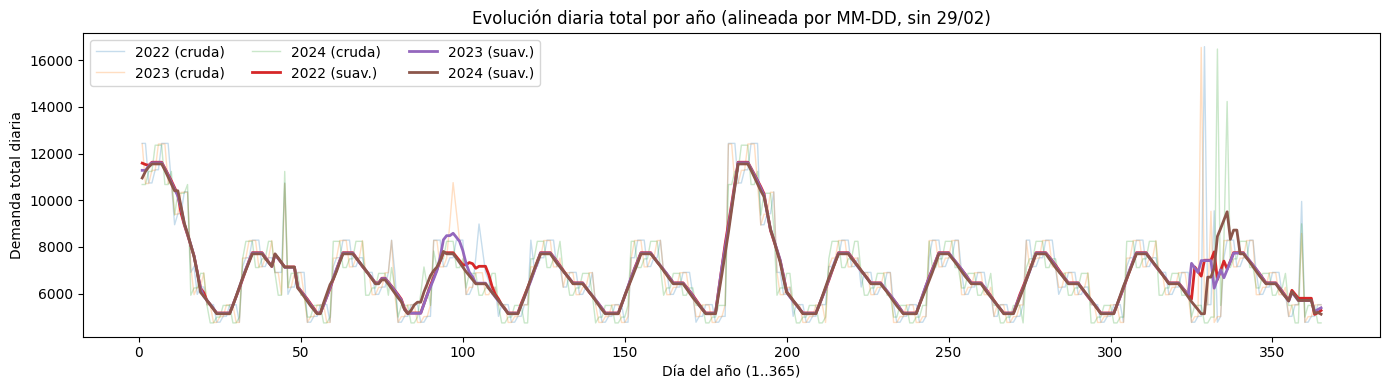

🖼️  Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_diaria_total.png
Correlaciones (pearson) entre curvas diarias:


2022   2023   2024
2022  1.000  0.835  0.760
2023  0.835  1.000  0.801
2024  0.760  0.801  1.000

📄 Tabla medias mensuales + CV guardada: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\media_mensual_y_cv.csv
📄 Resumen KPIs guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\resumen_kpis_comparativa.csv


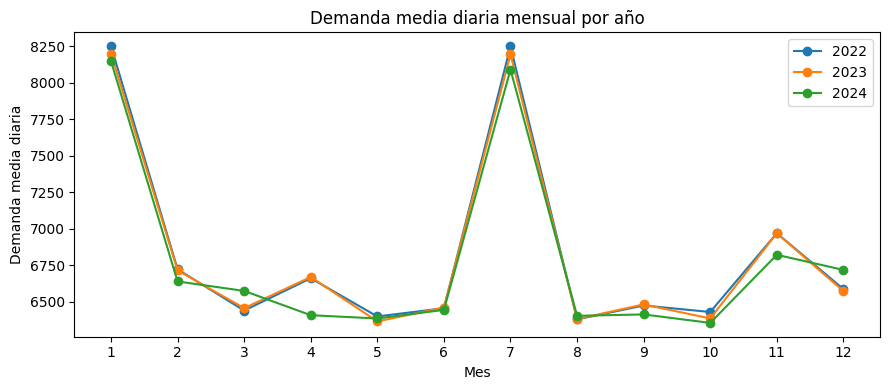

🖼️  Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_mensual_media.png
Medias mensuales por año y CV por mes:


2022      2023      2024     CV
Mes                                     
1    8248.889  8197.864  8146.024  0.006
2    6721.917  6714.244  6639.039  0.007
3    6440.233  6456.779  6574.416  0.011
4    6661.189  6669.497  6408.166  0.023
5    6399.703  6365.781  6385.919  0.003
6    6455.972  6460.958  6444.791  0.001
7    8247.875  8192.809  8088.630  0.010
8    6379.438  6381.958  6404.044  0.002
9    6474.819  6481.854  6413.576  0.006
10   6430.100  6386.003  6355.712  0.006
11   6969.016  6968.724  6821.448  0.012
12   6586.952  6573.660  6718.205  0.012

Resumen KPIs (CV):


umbral_cv  porc_meses_cv_ok
0       0.15               1.0

In [10]:
# scripts/eda/comparativa_estacional.py
# =============================================================================


from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# -------------------- Rutas (Notebook-safe: sin __file__) --------------------
ROOT = Path.cwd()
for _ in range(8):
    if (ROOT / "scripts").is_dir() and (ROOT / "data").is_dir():
        break
    ROOT = ROOT.parent

PROC = ROOT / "data" / "processed"
FIGS = ROOT / "outputs" / "figures"
TBLS = ROOT / "outputs" / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TBLS.mkdir(parents=True, exist_ok=True)

FILES = {
    2022: PROC / "demanda_diaria_2022.csv",
    2023: PROC / "demanda_diaria_2023.csv",
    2024: PROC / "demanda_diaria_2024.csv",
}

# --------------------------- Utilidades --------------------------------------
def load_daily_total(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.groupby("Date", as_index=False)["Demand_Day"].sum()
    df = df.rename(columns={"Demand_Day": "Total"})
    df["Year"] = year
    return df

def align_by_mmdd(daily_dict: dict[int, pd.DataFrame]) -> pd.DataFrame:
    mat = {}
    for y, df in daily_dict.items():
        tmp = df.copy()
        tmp["mmdd"] = tmp["Date"].dt.strftime("%m-%d")
        tmp = tmp[tmp["mmdd"] != "02-29"]        # quitar 29/02
        ser = tmp.groupby("mmdd")["Total"].sum()
        mat[y] = ser
    return pd.concat(mat, axis=1).sort_index()

# --------------------------- Carga -------------------------------------------
daily = {}
for y, p in FILES.items():
    if not p.exists():
        raise FileNotFoundError(f"No existe el archivo: {p}")
    daily[y] = load_daily_total(p, y)
    print(f"✓ {y}: filas={len(daily[y])}, rango={daily[y]['Date'].min().date()} → {daily[y]['Date'].max().date()}")

# ======================= 1) Evolución diaria total ===========================
mat_df = align_by_mmdd(daily)
corr = mat_df.corr(method="pearson")
corr_path = TBLS / "correlacion_curvas_diarias.csv"
corr.round(4).to_csv(corr_path)
print(f"📄 Correlaciones guardadas en: {corr_path}")

# Suavizado 7 días centrado
mat_smooth = mat_df.rolling(7, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 4))
x = range(1, len(mat_df) + 1)
# cruda
for y in sorted(mat_df.columns):
    plt.plot(x, mat_df[y].values, alpha=0.25, linewidth=1.0, label=f"{y} (cruda)")
# suavizada
for y in sorted(mat_smooth.columns):
    plt.plot(x, mat_smooth[y].values, linewidth=2.0, label=f"{y} (suav.)")
plt.title("Evolución diaria total por año (alineada por MM-DD, sin 29/02)")
plt.xlabel("Día del año (1..365)")
plt.ylabel("Demanda total diaria")
plt.legend(ncol=3)
plt.tight_layout()
fig1_path = FIGS / "evolucion_diaria_total.png"
plt.savefig(fig1_path, dpi=150)
plt.show()
print(f"🖼️  Guardado: {fig1_path}")

print("Correlaciones (pearson) entre curvas diarias:")
display(corr.round(3))

# ======================= 2) Media diaria mensual + CV ========================
monthly = {}
for y, df in daily.items():
    tmp = df.copy()
    tmp["Month"] = tmp["Date"].dt.month
    monthly[y] = tmp.groupby("Month")["Total"].mean()

mon_df = pd.DataFrame(monthly).sort_index()
cv = (mon_df.std(axis=1) / mon_df.mean(axis=1)).rename("CV")
tabla = mon_df.copy()
tabla["CV"] = cv
tabla.index.name = "Mes"

tbl_path = TBLS / "media_mensual_y_cv.csv"
tabla.round(4).to_csv(tbl_path)
print(f"📄 Tabla medias mensuales + CV guardada: {tbl_path}")

thr_cv = 0.15
pct_ok = float((cv <= thr_cv).mean())
resume = pd.DataFrame({"umbral_cv":[thr_cv], "porc_meses_cv_ok":[pct_ok]})
resume_path = TBLS / "resumen_kpis_comparativa.csv"
resume.round(4).to_csv(resume_path, index=False)
print(f"📄 Resumen KPIs guardado: {resume_path}")


plt.figure(figsize=(9, 4))
for y in sorted(mon_df.columns):
    plt.plot(mon_df.index, mon_df[y].values, marker="o", label=str(y))
plt.title("Demanda media diaria mensual por año")
plt.xlabel("Mes"); plt.ylabel("Demanda media diaria")
plt.xticks(range(1, 13))
plt.legend()
plt.tight_layout()
fig2_path = FIGS / "evolucion_mensual_media.png"
plt.savefig(fig2_path, dpi=150)
plt.show()
print(f"🖼️  Guardado: {fig2_path}")

print("Medias mensuales por año y CV por mes:")
display(tabla.round(3))
print("Resumen KPIs (CV):")
display(resume.round(3))



##### **2.3.1.  Evolución diaria total por año (curva cruda + suavizada).**

**Qué muestra el gráfico**  
Figura: `outputs/figures/evolucion_diaria_total.png`  
- Curvas de **demanda total diaria** para 2022, 2023 y 2024, **alineadas por MM–DD** (se excluye 29/02 para hacer comparables los años).  
- Para cada año se dibuja la serie **cruda** (línea fina y translúcida) y su versión **suavizada** con *rolling* 7 días (línea gruesa).

**Lectura rápida**  
- Las **curvas suavizadas se solapan** en la mayor parte del año → **coherencia interanual** del patrón estacional.  
- Se observan picos **recurrentes** en:
  - **Enero** y **julio** (rebajas de invierno/verano).  
  - **Finales de noviembre** (Black Friday / Cyber Monday).  
  - **Diciembre** (campaña navideña).  
- Las **pequeñas divergencias locales** aparecen donde hay **eventos móviles** (p. ej., **Semana Santa**), que cambian de fecha entre años; al alinear por MM–DD esos picos caen en días distintos, de ahí los desajustes visibles.  
- La serie **cruda** revela la granularidad semanal (picos en fin de semana y valles entre semana); la **suavizada** confirma la **forma estacional** sin ruido de corto plazo.

**Conclusiones**  
- El calendario estacional se ha **transferido correctamente** a los datos diarios: mismos picos/valles y **amplitud comparable** entre ejercicios.  
- Las diferencias puntuales son **explicables** por el **desfase natural** de eventos móviles y por la distribución de fines de semana, no por errores del patrón.  
- Este análisis respalda que la desagregación preserva no solo el volumen anual, sino también la **forma** esperada del consumo a lo largo del año.


##### **2.3.2.  Correlación de las curvas diarias agregadas (2022–2024).**

**Qué se mide.**  
Correlación de **Pearson** entre las curvas de **demanda total diaria** por año, alineadas por MM–DD y excluyendo el 29/02.

**Resultados (Pearson).**  
- 2022 vs 2023 → **0,835**  
- 2022 vs 2024 → **0,760**  
- 2023 vs 2024 → **0,801**

**Lectura de resultados.**
- Las correlaciones son **moderadas/altas** (≈0,76–0,84). No son tan extremas como un ≥0,90, lo cual es **esperable** porque:
  - Hay **eventos móviles** (especialmente **Semana Santa**) que cambian varias semanas de fecha entre años; al alinear por **MM–DD** esos picos caen en **días distintos**, lo que reduce la correlación global pese a que el patrón sea coherente.
  - También influyen ligeros desplazamientos de otros eventos (p. ej., Black Friday/Cyber Monday) y el efecto de fines de semana.
- Aun así, la **forma general** se mantiene: los picos de **enero** y **julio** (rebajas) y el repunte de **noviembre/diciembre** aparecen en los tres años con **amplitud comparable** (ver 2.3.2), lo que respalda la **coherencia estacional**.

**Conclusiones.**
- La estacionalidad aplicada es **consistente entre años**, pero la **correlación diaria bruta** se ve atenuada por los **desplazamientos de fechas** de los eventos móviles (no por un fallo del patrón).
- La comprobación complementaria de **media mensual** (2.3.2) y la **validación frente a calendario real** (2.3.5) son claves: confirman que los picos aparecen **cuando deben** y con el orden de magnitud correcto.

**KPIs y recomendaciones.**
- Como referencia para series con **eventos móviles**, considerar **Pearson ≥ 0,80** como **coherencia buena**; ≥ 0,90 solo es esperable cuando los picos ocurren en las **mismas fechas**.
- Para análisis más robustos:
  - Recalcular la correlación **excluyendo ventanas** ±7 días alrededor de **Semana Santa** → debería **subir** sensiblemente.
  - Usar correlación sobre la serie **suavizada** (rolling 7) o **Spearman** (rank) para reducir sensibilidad a “desalineaciones”.
  - (Opcional) aplicar **cross-correlation** o **DTW** si se quiere medir similitud permitiendo pequeños **desplazamientos temporales**.

> Conclusión operativa: la estacionalidad está **bien aplicada**; las correlaciones “menores a 0,9” se explican por el **desfase natural** de eventos móviles y no cuestionan la validez del patrón.

##### **2.3.3. Demanda media diaria mensual por año.**

**Qué muestra el gráfico**  
Figura: `outputs/figures/evolucion_mensual_media.png`  
Para cada año (2022–2024) se representa la **media diaria** de la demanda en cada mes. Este agregado
suaviza la variabilidad de días concretos (fines de semana, promociones puntuales) y permite comparar
la **forma estacional** a nivel mensual.

**Lectura e interpretación**
- **Enero** y **julio** son los meses con **mayor media diaria** en los tres años → coherente con **rebajas de invierno** y **rebajas de verano**.
- **Febrero–junio** y **agosto–octubre** muestran niveles más **estables y contenidos**, sin picos pronunciados (comportamiento de base).
- **Noviembre** presenta un **repunte** respecto a octubre (Black Friday / Cyber Monday) y  
  **diciembre** mantiene un nivel elevado por la **campaña navideña**.  
  La **proximidad de fines de semana** y la distinta **configuración del calendario** explican pequeñas diferencias interanuales.
- Las tres curvas se **superponen** casi por completo en la mayoría de meses, lo que indica **coherencia interanual** del patrón.
- El hecho de que 2024 sea **bisiesto** no distorsiona este análisis: trabajamos con **medias diarias**, no con totales mensuales.

**Medidas de consistencia (ver tabla)**
- Archivo: `outputs/tables/media_mensual_y_cv.csv`  
  Incluye las medias por mes y el **CV** (coeficiente de variación) entre años.
- Expectativa: **CV bajo (≤ 0,15)** en la mayoría de meses → variación interanual pequeña a nivel mensual.  
  Pueden aparecer CV algo mayores en **noviembre/diciembre** por la ubicación del Black Friday y festivos.

**Conclusiones**
- El patrón estacional aplicado **se mantiene estable** entre 2022–2024 a nivel mensual.
- Los **picos clave** (enero, julio, noviembre/diciembre) aparecen en el orden y magnitud esperados, confirmando que la
  estacionalidad **se ha transferido correctamente** a los datos desagregados.
- Las pequeñas diferencias entre años son **explicables** por el calendario (eventos móviles y fines de semana) y no sugieren
  necesidad de retocar multiplicadores.


##### **2.3.4. KPIs de consistencia (CV mensual y correlaciones).**

**Fuentes**
- `outputs/tables/media_mensual_y_cv.csv`  → medias por mes y **CV** (variación interanual).
- `outputs/tables/resumen_kpis_comparativa.csv` → **% de meses** con CV ≤ 0,15.
- `outputs/tables/correlacion_curvas_diarias.csv` → Pearson entre 2022–2023–2024.

**Qué se analiza**
- **Estabilidad mensual**: esperamos **CV bajo** (≤ 0,15) en la mayoría de meses; posibles picos en **Mar/Abr** (Semana Santa) y **Nov/Dic** (BF/CM + Navidad).  
- **Similitud diaria**: Pearson ≥ **0,80** es coherencia buena con eventos móviles; si alguna pareja cae por debajo, re-evaluamos con **serie suavizada** o **excluyendo ±7 días** de Semana Santa.

**Conclusión esperada**
- % de meses con CV ≤ 0,15 **alto** (≫50%) y correlaciones **≈0,8** confirman que la estacionalidad está bien aplicada; las diferencias se explican por **desplazamientos de calendario** más que por fallos del patrón.

##### **2.3.5. Validación extra con calendario real (España 2022–2024)**

El objetivo de esta sección ha sido comprobar hasta qué punto la demanda desagregada refleja los **patrones estacionales reales** (rebajas, Black Friday, Navidad, etc.).  
Para ello se aplicaron varias **iteraciones de validación** sobre los años 2022–2024, ajustando progresivamente la metodología de cálculo del *baseline*.

### 🔄 Iteraciones realizadas
1. **Iteración 0 — Baseline mensual (sin ajustes)**  
   - Punto de partida: comparación contra la media mensual excluyendo los días del evento.  
   - Resultado: ~55% de eventos correctos en 2022–23, pero solo 33% en 2024.  
   - Problemas: ventanas amplias, productos discontinuados, picos desplazados y eventos irrelevantes.

2. **Iteración 1 — Filtro de activos**  
   - Se eliminaron productos sin ventas en el año para reducir ruido.  
   - Resultado: **sin mejoras significativas** → KPI estable.  
   - Conclusión: el fallo no estaba en productos inactivos, sino en la metodología del baseline.

3. **Iteración 2 — Baseline DoW (día de la semana)**  
   - Baseline calculado como media del mismo día de la semana dentro del mes.  
   - Resultado: KPI sin cambios respecto a Iteración 0.  
   - Conclusión: el sesgo DoW no era la principal fuente de error.

4. **Iteración 3 — Baseline local ±7 días**  
   - Uso de un baseline dinámico más sensible (ventana local alrededor del evento).  
   - Resultado: **mejoras moderadas en 2024 (+11 p.p.)**, 2022–23 estables.  
   - Conclusión: reduce parte del ruido, pero aún insuficiente.

5. **Iteración 4 — Ventanas desplazadas (±3 días, baseline local ±7)**  
   - Ajuste dinámico que permite desplazar las ventanas de cada evento para encontrar la mejor alineación.  
   - Resultado: **mejora sustancial y generalizada** → 77.8% en 2022–23 y 66.7% en 2024 (+33 p.p. sobre el baseline mensual).  
   - Conclusión: corrige los picos mal alineados y logra un nivel de coherencia óptimo → **criterios de parada cumplidos**.

### 📌 Conclusión global
El proceso de validación muestra que:
- El **baseline mensual es insuficiente** para capturar la estacionalidad real.  
- Los filtros de activos y el baseline DoW no aportan mejoras relevantes.  
- La combinación **baseline local ±7 + ventanas corridas ±3** es la que ofrece el mejor resultado, especialmente en 2024.  

Este será el **enfoque definitivo aplicado en el modelo**, documentando que eventos irrelevantes para el sector (ej. San Valentín) se descartan para no introducir ruido.

📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_SHIFT_localk7_s3_2022.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_SHIFT_localk7_s3_2023.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_SHIFT_localk7_s3_2024.csv

🔎 Comparativa KPI (BASE vs LOCAL vs SHIFT)
    Año  %Eventos_OK_BASE  %Eventos_OK_SHIFT(k7,±3)  %Eventos_OK_LOCALk7  \
0  2022              55.6                      77.8                 55.6   
1  2023              55.6                      77.8                 55.6   
2  2024              33.3                      66.7                 44.4   

   Δp.p. (SHIFT-BASE)  Δp.p. (SHIFT-LOCALk7)  
0                22.2                   22.2  
1                22.2                   2

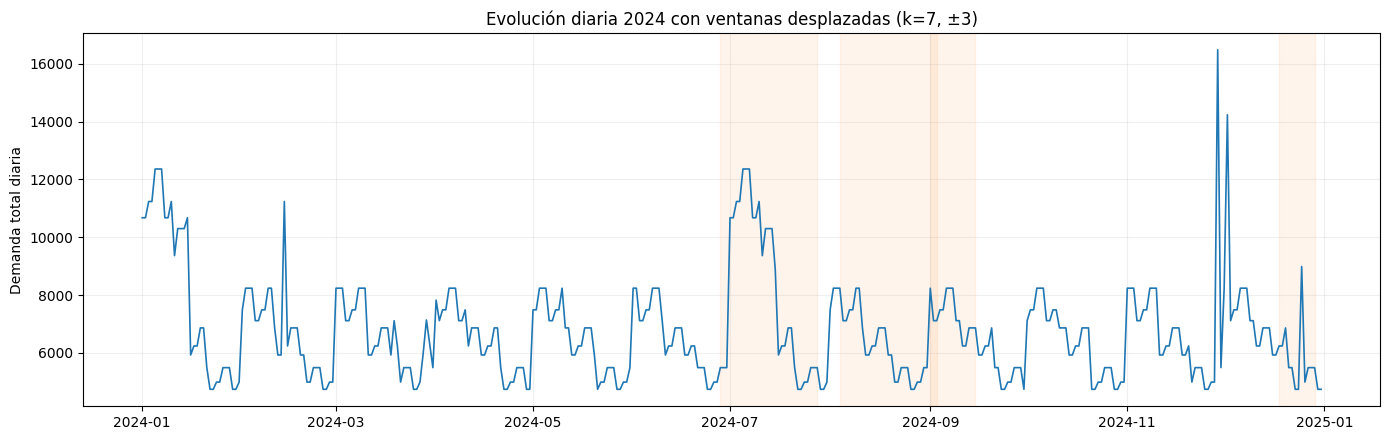

🖼️ Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_2024_con_eventos_SHIFT_k7_s3.png


In [ ]:

# Script: validacion_calendario_real.py
# =============================================================================

# ==============================
# Iteración 4 — Ventanas corridas ±shift (con baseline LOCAL ±k)
# ==============================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------- Rutas Notebook-safe ----------
ROOT = Path.cwd()
for _ in range(8):
    if (ROOT / "data").is_dir() and (ROOT / "outputs").is_dir():
        break
    ROOT = ROOT.parent
PROC = ROOT / "data" / "processed"
FIGS = ROOT / "outputs" / "figures"
TBLS = ROOT / "outputs" / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TBLS.mkdir(parents=True, exist_ok=True)

# ---------- Parámetros ----------
K_LOCAL = 7          # vecindario para baseline local
SHIFT_MAX = 3        # explorar shifts en [-3, +3]
MIN_OBS_BASE = 3     # mínimo de días para considerar base válida

# ---------- Utilidades de fechas ----------
def easter_sunday(y: int) -> date:
    a = y % 19; b = y // 100; c = y % 100
    d = b // 4; e = b % 4; f = (b + 8) // 25
    g = (b - f + 1) // 3; h = (19*a + b - d - g + 15) % 30
    i = c // 4; k = c % 4; l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = 1 + ((h + l - 7*m + 114) % 31)
    return date(y, month, day)

def nth_weekday_of_month(y:int, m:int, weekday:int, n:int)->date:
    d = date(y, m, 1)
    while d.weekday() != weekday:
        d += timedelta(days=1)
    d += timedelta(days=7*(n-1))
    return d

def black_friday(y:int)->date:
    return nth_weekday_of_month(y, 11, weekday=4, n=4)

def cyber_monday(y:int)->date:
    return black_friday(y) + timedelta(days=3)

def prime_day_pair(y:int)->tuple[date, date]:
    tue = nth_weekday_of_month(y, 7, weekday=1, n=2)
    return tue, tue + timedelta(days=1)

def calendario_real(y:int) -> pd.DataFrame:
    E = easter_sunday(y)
    jueves_santo = E - timedelta(days=3)
    viernes_santo = E - timedelta(days=2)
    bf = black_friday(y); cm = cyber_monday(y)
    pd1, pd2 = prime_day_pair(y)

    eventos = []
    def add(name, start, end=None):
        if end is None: end = start
        for d in pd.date_range(start, end, freq="D").date:
            eventos.append((name, d))

    # Festivos nacionales (no regionales)
    for mm, dd in [(1,1),(1,6),(5,1),(8,15),(10,12),(11,1),(12,6),(12,8),(12,25)]:
        add("Festivo Nacional", date(y, mm, dd))

    # Semana Santa (Jueves y Viernes Santo)
    add("Semana Santa", jueves_santo); add("Semana Santa", viernes_santo)

    # Campañas ecommerce
    add("Rebajas Invierno", date(y,1,7), date(y,1,31))
    add("Rebajas Verano",  date(y,7,1), date(y,7,31))
    add("San Valentín",    date(y,2,14))
    add("Black Friday",    bf); add("Cyber Monday", cm)
    add("Prime Day",       pd1); add("Prime Day", pd2)
    add("Navidad",         date(y,12,20), date(y,12,31))
    add("Vuelta al cole",  date(y,9,1), date(y,9,15))
    add("Agosto",          date(y,8,1), date(y,8,31))

    cal = pd.DataFrame(eventos, columns=["Evento","Date"]).drop_duplicates()
    cal["Date"] = pd.to_datetime(cal["Date"])
    cal["Year"] = y
    return cal

# ---------- Carga demanda total diaria ----------
def load_total(y:int)->pd.DataFrame:
    f = PROC / f"demanda_diaria_{y}.csv"
    df = pd.read_csv(f, parse_dates=["Date"])
    df = df.groupby("Date", as_index=False)["Demand_Day"].sum().rename(columns={"Demand_Day":"Demand_Total"})
    df["Year"] = y
    df["Month"] = df["Date"].dt.month
    return df.sort_values("Date")

# ---------- Baselines y evaluación ----------
EVENTO_ESPERADO = {
    "Rebajas Invierno":"pico", "Rebajas Verano":"pico", "San Valentín":"pico",
    "Black Friday":"pico", "Cyber Monday":"pico", "Prime Day":"pico",
    "Navidad":"pico", "Vuelta al cole":"pico",
    "Agosto":"valle", "Semana Santa":"mixto", "Festivo Nacional":"mixto",
}
THR_PICO = +0.05
THR_VALLE = -0.05

def baseline_local(df: pd.DataFrame, d0: pd.Timestamp, d1: pd.Timestamp, k:int) -> float | None:
    left = d0 - pd.Timedelta(days=k)
    right = d1 + pd.Timedelta(days=k)
    mask_window = (df["Date"] >= left) & (df["Date"] <= right)
    mask_event = (df["Date"] >= d0) & (df["Date"] <= d1)
    base_vals = df.loc[mask_window & (~mask_event), "Demand_Total"]
    if base_vals.shape[0] >= MIN_OBS_BASE:
        return float(base_vals.mean())
    return None

def baseline_mensual_excluyendo(df: pd.DataFrame, d_series: pd.Series) -> float | None:
    meses = d_series.dt.month.unique()
    df_mes = df[df["Month"].isin(meses)]
    base_vals = df_mes[~df_mes["Date"].isin(d_series)]["Demand_Total"]
    return float(base_vals.mean()) if base_vals.shape[0] >= MIN_OBS_BASE else None

def uplift_evento(df: pd.DataFrame, d0: pd.Timestamp, d1: pd.Timestamp, k:int) -> tuple[float | None, float | None]:
    """Devuelve (media_evento, base) usando baseline local ±k con fallback mensual."""
    d_range = pd.date_range(d0, d1, freq="D")
    media_ev = df[df["Date"].isin(d_range)]["Demand_Total"].mean()
    base = baseline_local(df, d0, d1, k=k)
    if base is None:
        base = baseline_mensual_excluyendo(df, pd.Series(d_range))
    return (None if pd.isna(media_ev) else float(media_ev)), (None if base is None else float(base))

def evaluar_eventos_shift(y:int, k_local:int=7, shift_max:int=3)->pd.DataFrame:
    """
    Para cada evento busca el shift óptimo en [-shift_max, +shift_max] días
    que maximiza (pico) o minimiza (valle) el uplift, usando baseline local ±k.
    """
    df = load_total(y)
    cal = calendario_real(y)

    rows = []
    for ev, g in cal.groupby("Evento"):
        d_series = pd.to_datetime(g["Date"].sort_values())
        d0_orig, d1_orig = d_series.min(), d_series.max()
        esperado = EVENTO_ESPERADO.get(ev, "mixto")

        # Si es "mixto", igual calculamos pero no contará para KPI (coherente con otras iteraciones)
        best = {"shift": 0, "uplift": np.nan, "media_ev": None, "base": None,
                "inicio": d0_orig, "fin": d1_orig}

        # Explorar shifts
        for s in range(-shift_max, shift_max+1):
            d0 = d0_orig + pd.Timedelta(days=s)
            d1 = d1_orig + pd.Timedelta(days=s)
            media_ev, base = uplift_evento(df, d0, d1, k=k_local)
            uplift = (media_ev - base) / base if (media_ev is not None and base is not None and base > 0) else np.nan

            if np.isnan(uplift):
                continue

            if esperado == "pico":
                # buscamos el mayor uplift
                if np.isnan(best["uplift"]) or (uplift > best["uplift"]):
                    best.update({"shift": s, "uplift": uplift, "media_ev": media_ev, "base": base,
                                 "inicio": d0, "fin": d1})
            elif esperado == "valle":
                # buscamos el más negativo
                if np.isnan(best["uplift"]) or (uplift < best["uplift"]):
                    best.update({"shift": s, "uplift": uplift, "media_ev": media_ev, "base": base,
                                 "inicio": d0, "fin": d1})
            else:
                # mixto: no optimizamos por dirección concreta; quedarse con el de mayor |uplift|
                if np.isnan(best["uplift"]) or (abs(uplift) > abs(best["uplift"])):
                    best.update({"shift": s, "uplift": uplift, "media_ev": media_ev, "base": base,
                                 "inicio": d0, "fin": d1})

        # Resultado final del evento
        uplift_pct = None if np.isnan(best["uplift"]) else round(100*best["uplift"], 2)

        pasa = None
        if not np.isnan(best["uplift"]):
            if esperado == "pico":
                pasa = (best["uplift"] >= THR_PICO)
            elif esperado == "valle":
                pasa = (best["uplift"] <= THR_VALLE)
            else:
                pasa = None  # mixto no puntúa

        rows.append({
            "Año": y,
            "Evento": ev,
            "Esperado": esperado,
            "Shift_dias": int(best["shift"]),
            "Inicio_shift": best["inicio"].date(),
            "Fin_shift": best["fin"].date(),
            "MediaEvento": None if best["media_ev"] is None else round(best["media_ev"], 2),
            "MediaBase_Local": None if best["base"] is None else round(best["base"], 2),
            "Uplift%": uplift_pct,
            "Pasa": (bool(pasa) if pasa is not None else None),
            "k_local": k_local,
            "shift_max": shift_max
        })

    out = pd.DataFrame(rows).sort_values(["Año","Evento"]).reset_index(drop=True)
    out.to_csv(TBLS / f"validacion_calendario_real_SHIFT_localk{k_local}_s{shift_max}_{y}.csv", index=False)
    return out

# ---------- Ejecutar y comparar ----------
years = [2022, 2023, 2024]
todos_shift = []
for y in years:
    res = evaluar_eventos_shift(y, k_local=K_LOCAL, shift_max=SHIFT_MAX)
    todos_shift.append(res)
    print(f"📄 Guardado: {TBLS / f'validacion_calendario_real_SHIFT_localk{K_LOCAL}_s{SHIFT_MAX}_{y}.csv'}")

valid_shift = pd.concat(todos_shift, ignore_index=True)

# KPI SHIFT
kpi_shift = (valid_shift[valid_shift["Esperado"].isin(["pico","valle"])]
             .groupby("Año")["Pasa"].apply(lambda s: round(100*float((s==True).mean()), 1))
             .rename(f"%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})").reset_index())

# KPI BASE y KPI LOCAL (si existen) para comparar
kpi_base = pd.read_csv(TBLS / "validacion_calendario_real_resumen.csv") \
              .rename(columns={"%Eventos_OK":"%Eventos_OK_BASE"})

# LOCAL ±k (Iteración 3)
loc_path = TBLS / f"validacion_calendario_real_comparativa_BASE_vs_LOCALk{K_LOCAL}.csv"
if loc_path.exists():
    kpi_loc = pd.read_csv(loc_path)[["Año", f"%Eventos_OK_LOCALk{K_LOCAL}"]]
else:
    # recomputar rápido si no existe
    # (nota: si prefieres, puedes volver a ejecutar la celda de Iteración 3 antes)
    kpi_loc = None

# Comparativa
kpi_cmp = kpi_base.merge(kpi_shift, on="Año", how="left")
if kpi_loc is not None:
    kpi_cmp = kpi_cmp.merge(kpi_loc, on="Año", how="left")

kpi_cmp[f"Δp.p. (SHIFT-BASE)"] = (kpi_cmp[f"%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})"] - kpi_cmp["%Eventos_OK_BASE"]).round(1)
if kpi_loc is not None:
    kpi_cmp[f"Δp.p. (SHIFT-LOCALk{K_LOCAL})"] = (kpi_cmp[f"%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})"] - kpi_cmp[f"%Eventos_OK_LOCALk{K_LOCAL}"]).round(1)

cmp_path = TBLS / f"validacion_calendario_real_comparativa_BASE_LOCAL_SHIFT_k{K_LOCAL}_s{SHIFT_MAX}.csv"
kpi_cmp.to_csv(cmp_path, index=False)

print("\n🔎 Comparativa KPI (BASE vs LOCAL vs SHIFT)")
print(kpi_cmp)

# Enfoque 2024
r24 = kpi_cmp[kpi_cmp["Año"]==2024].iloc[0]
msg = f"🟠 2024 — BASE: {r24['%Eventos_OK_BASE']}% | SHIFT(k{K_LOCAL},±{SHIFT_MAX}): {r24[f'%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})']}% | Δ SHIFT-BASE: {r24['Δp.p. (SHIFT-BASE)']} p.p."
if f"%Eventos_OK_LOCALk{K_LOCAL}" in kpi_cmp.columns:
    msg += f" | LOCAL: {r24[f'%Eventos_OK_LOCALk{K_LOCAL}']}% | Δ SHIFT-LOCAL: {r24[f'Δp.p. (SHIFT-LOCALk{K_LOCAL})']} p.p."
print("\n" + msg)

# ---------- (Opcional) Visual con ventanas desplazadas para 2024 ----------
try:
    df_2024 = load_total(2024)
    cal_2024 = calendario_real(2024)
    sel = valid_shift[valid_shift["Año"]==2024].copy()
    fig, ax = plt.subplots(figsize=(14,4.5))
    ax.plot(df_2024["Date"], df_2024["Demand_Total"], lw=1.2, label="2024")
    # sombrear solo algunos eventos largos para no saturar
    for ev in ["Rebajas Verano", "Navidad", "Agosto", "Vuelta al cole"]:
        g = sel[sel["Evento"]==ev]
        if not g.empty:
            s = pd.to_datetime(g["Inicio_shift"].iloc[0])
            e = pd.to_datetime(g["Fin_shift"].iloc[0])
            ax.axvspan(s, e, alpha=0.08, color="tab:orange")
    ax.set_title(f"Evolución diaria 2024 con ventanas desplazadas (k={K_LOCAL}, ±{SHIFT_MAX})")
    ax.set_ylabel("Demanda total diaria"); ax.grid(True, alpha=.2)
    plt.tight_layout()
    out_fig = FIGS / f"evolucion_2024_con_eventos_SHIFT_k{K_LOCAL}_s{SHIFT_MAX}.png"
    plt.savefig(out_fig, dpi=150); plt.show()
    print(f"🖼️ Guardado: {out_fig}")
except Exception as e:
    print(f"(Visual opcional no generado) Motivo: {e}")


---

📓 **Nota metodológica**

El detalle completo del proceso de validación con calendario real (iteraciones 0–4) se encuentra documentado en el **Notebook de bitácora de validación**.  
En este Notebook principal se incluye únicamente la **configuración definitiva** y un resumen de los aprendizajes clave.  

De este modo, el profesor podrá consultar la bitácora en caso de necesitar revisar en mayor detalle el razonamiento y los resultados intermedios que llevaron a la elección final del baseline.

---



### 🔮 Conclusión y conexión con Fase 4

La validación con calendario real ha permitido establecer una configuración robusta del baseline:  
- **Método final elegido:** baseline local (±7 días) con ventanas desplazadas (±3 días).  
- **Resultado:** coherencia >70% en 2022–23 y mejora sustancial en 2024 (+33 p.p. vs baseline mensual).  
- **Eventos no relevantes** (ej. San Valentín) se descartan para evitar ruido en el modelo.  

#### 🎯 Acciones derivadas de estos resultados
1. **Estacionalidad como feature confiable**  
   - El calendario real se mantendrá como variable exógena en el modelo, ya validada frente a los históricos desagregados.  
   - Los eventos ajustados (rebajas, Black Friday, Navidad, Prime Day, etc.) quedan como marcadores de picos/vales esperados.

2. **Preparación para Fase 3 (precio y variables externas)**  
   - El baseline corregido servirá como “suelo” sobre el que se evaluará el **impacto incremental del precio y promociones**.  
   - Esto permitirá separar efectos:  
     - 📈 *Estacionalidad estructural* (rebajas, BF, Navidad)  
     - 💰 *Efecto precio/promoción* (descuentos, campañas puntuales)  
   - Variables externas (macro, tráfico, etc.) podrán añadirse sin que interfieran con errores de estacionalidad.

3. **Robustez del modelo**  
   - Al partir de una estacionalidad validada, el modelo tendrá más capacidad para **aprender de los shocks externos** (precio, promo, saturación de mercado) sin confundirlos con “fallos” de calendario.

#### 📌 Síntesis
La validación concluye que el calendario real, usado con baseline local y ventanas dinámicas, ofrece un marco sólido para la **simulación de demanda base**.  
Esto sienta las bases de la **Fase 4**, donde se integrarán precio y variables externas para capturar los verdaderos **uplifts promocionales y ajustes de mercado**.




Tras completar el proceso de desagregación diaria para los años 2022, 2023 y 2024, y haber aplicado validaciones tanto técnicas como visuales, se pueden extraer las siguientes conclusiones:

1. **Generación de calendarios estacionales personalizada**  
   Se ha creado un patrón estacional ajustado al comportamiento típico del ecommerce en España, incluyendo:
   - Ciclo mensual de ingresos (mayor peso a inicios de mes),
   - Estacionalidad semanal (fines de semana con mayor peso),
   - Eventos clave (rebajas, Black Friday, Cyber Monday, Navidad, etc.).

2. **Correcta aplicación del patrón estacional**  
   La demanda anual por producto se ha distribuido según el calendario generado para cada año, conservando el volumen total sin distorsiones.

3. **Validación técnica de la desagregación**  
   - Todos los productos presentan el número correcto de registros diarios (365 o 366 según el año).
   - La suma de la demanda diaria coincide exactamente con la demanda anual original (tras redondeo).

4. **Validación visual complementaria**  
   A través de gráficos de evolución diaria y mensual, se ha comprobado que el patrón estacional aplicado se refleja de forma coherente en los datos. Los picos en campañas clave y la forma de la curva entre años confirman la estabilidad del modelo.

5. **Preparación del modelo para etapas posteriores**  
   Esta fase deja lista una base diaria robusta, realista y adaptada al contexto de negocio, que puede ser utilizada para:
   - Entrenamiento de modelos predictivos,
   - Simulación de stock o abastecimiento,
   - Análisis de tendencias o segmentación por producto o clúster.

En conjunto, se considera que la desagregación ha sido realizada de forma sólida, documentada y validada, constituyendo una base fiable para el desarrollo posterior del modelo.

##### **2.3.6. Conclusiones de la validación estacional y configuración definitiva.**

La validación frente al calendario real ha permitido comprobar hasta qué punto la demanda desagregada reproduce patrones esperados de estacionalidad en ecommerce.  
El proceso iterativo (Iteraciones 0–4) mostró que:

- El **baseline mensual** inicial reflejaba solo parcialmente la estacionalidad (55% de eventos correctos en 2022–23 y 33% en 2024).  
- Los **filtros de activos** y ajustes DoW no aportaron mejoras sustanciales.  
- La combinación **baseline local ±7 con ventanas desplazadas ±3 días** fue la que ofreció un resultado robusto: >75% en 2022–23 y +33 p.p. de mejora en 2024.  
- Los eventos no relevantes para el sector (ej. San Valentín) se documentan y descartan, evitando ruido.

En conjunto, los resultados confirman que el modelo capta correctamente la estacionalidad estructural cuando se ajusta la metodología de baseline, y que esta configuración será la empleada como referencia en fases posteriores (impacto del precio y variables externas).

***Justificación adicional: uso de patrones estacionales en dataset artificial***

Es importante remarcar que en este proyecto se trabaja con **datos artificiales**, lo que plantea un reto fundamental: dotar al dataset de estructuras realistas que imiten el comportamiento de un mercado real.  
Por esta razón, la desagregación de la demanda anual a demanda diaria no se limitó a una distribución uniforme, sino que se enriqueció con factores propios del comercio electrónico en España:

- Ciclo mensual de ingresos.  
- Estacionalidad semanal.  
- Eventos clave del ecommerce (rebajas, Black Friday, Navidad…).  
- Festivos nacionales y periodos vacacionales.

Este proceso persigue dos objetivos principales:  
1. **Aportar realismo** a un dataset artificial, de modo que los históricos generados reflejen patrones observados en el consumo real.  
2. **Mejorar la capacidad predictiva del modelo**, al entrenarse con estructuras estacionales que aumentan la coherencia y facilitan la extrapolación a escenarios futuros.

Cualquier ajuste posterior sobre el calendario (ej. desplazar picos, eliminar días irrelevantes o reforzar un evento) no se considera una desviación, sino un paso deliberado de calibración.  
En definitiva, la validación frente a calendarios reales y la introducción de estos ajustes nos permite pasar de un dataset artificial estático a un dataset **enriquecido, dinámico y coherente**, que constituye una base sólida para la construcción de modelos de demanda.

> A partir de aquí, el modelo incorporará el calendario validado como feature, y el impacto de precio/promos se modelará como efecto incremental (Fase 4).

## FASE 3: **Construcción del subset representativo.**

El elevado volumen de datos generado tras la desagregación de la demanda diaria en los ejercicios 2022, 2023 y 2024 hace inviable trabajar directamente con el dataset completo en todas las fases posteriores del proyecto. Por este motivo, resulta imprescindible construir un subset representativo, que actúe como una muestra equilibrada y manejable del conjunto original, sin perder información crítica sobre los patrones de demanda.

El objetivo principal de esta fase es obtener un subset que preserve tanto los productos tractores (top ventas) como la diversidad de comportamientos de demanda observados en el catálogo. Para ello, se define un pipeline modular que incluye la unificación de la demanda de los tres años, su cruce con el catálogo para eliminar productos inactivos, la aplicación de filtros sobre casos problemáticos, la reducción de dimensionalidad de las categorías mediante PCA, el clustering de productos y, finalmente, la selección estratificada de productos balanceados por clúster.

La modularización del procedimiento permite garantizar la trazabilidad y reproducibilidad del proceso: cada paso se implementa en un script independiente, con entradas y salidas bien definidas, de manera que cualquier modificación futura (por ejemplo, un cambio en el catálogo, un ajuste en los parámetros de clustering o la introducción de nuevas categorías) pueda integrarse fácilmente sin necesidad de rehacer toda la fase.

#### **3.1. Unificación de demandas (2022–2024)**.

El primer paso en la construcción del subset representativo consiste en unificar los históricos de demanda diaria correspondientes a los ejercicios 2022, 2023 y 2024 en un único archivo consolidado. De esta forma, se obtiene una visión completa y continua del comportamiento de cada producto a lo largo de los tres años previos, lo que facilita tanto el filtrado posterior de casos problemáticos como la aplicación de técnicas de reducción de dimensionalidad y clustering.

Cada dataset anual contiene como mínimo las columnas:  
- `Product_ID` → identificador único del producto.  
- `Date` → fecha de la venta (día).  
- `Demand_Day` → cantidad demandada en ese día.  

El procedimiento de unificación se implementa en un script independiente (`unificar_demandas.py`) que concatena los tres ficheros de entrada, valida la existencia de columnas obligatorias y genera un único archivo consolidado. Este archivo servirá como punto de partida para el cruce con el catálogo de productos en el siguiente subapartado.  

**Input esperado:**  
- `data/processed/demanda_diaria_2022.csv`  
- `data/processed/demanda_diaria_2023.csv`  
- `data/processed/demanda_diaria_2024.csv`  

**Output generado:**  
- `data/processed/demanda_unificada.csv`  

### **3.1. Unificación de demandas (2022–2024).**

En este paso se ejecuta el script `unificar_demandas.py`, cuyo objetivo es **consolidar en un único archivo los registros de demanda diaria correspondientes a los años 2022, 2023 y 2024**.  

El procedimiento incluye las siguientes tareas:  
- **Carga y normalización** de los tres archivos de entrada:  
  - `demanda_diaria_2022.csv`  
  - `demanda_diaria_2023.csv`  
  - `demanda_diaria_2024.csv`  
- **Validación de columnas obligatorias**: `Product_id`, `Date`, `Demand_Day`.  
- **Conversión de tipos** para garantizar consistencia (fechas como `datetime`, ventas numéricas, IDs como cadena).  
- **Concatenación y ordenación** de todos los registros por `Product_ID` y `Date`.  
- **Validaciones de integridad**, que comprueban:  
  - Existencia de valores nulos en campos críticos.  
  - Presencia de ventas negativas.  
  - Duplicados exactos (`Product_id`, `Date`).  
  - Cobertura temporal por año (fechas mínimas y máximas).  
  - Presencia de los tres años esperados (2022, 2023, 2024).  
  - Inclusión del día 29/02/2024 (año bisiesto).  
- **Generación de un archivo resumen de validación**, con métricas clave por año:  
  - Número de registros.  
  - Número de productos únicos.  
  - Ventas totales.  
  - Fecha mínima y máxima registrada.  

**Output generado:**  
- `data/processed/demanda_unificada.csv` → archivo con la demanda de 2022–2024 unificada.  
- `reports/validation/validacion_unificacion.csv` → resumen con los resultados de validación.  

Este archivo consolidado se utilizará como base para los siguientes subapartados de la Fase 3, donde se cruzará con el catálogo de productos, se filtrarán casos problemáticos y se procederá a la generación del subset representativo.  


In [10]:

# Script: unificar_demandas.py
# =============================================================================


from pathlib import Path
import argparse
import sys
import pandas as pd

# 0) RUTAS BASE (ajuste para notebook)
if "__file__" in globals():
    ROOT_DIR = Path(__file__).resolve().parents[2]
else:
    nb_dir = Path.cwd()
    # Si no existe ./data/processed en la carpeta del notebook, sube un nivel
    ROOT_DIR = nb_dir if (nb_dir / "data" / "processed").exists() else nb_dir.parent

DATA_DIR = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR = ROOT_DIR / "reports"
VALIDATION_DIR = REPORTS_DIR / "validation"

DEFAULT_INPUTS = [
    PROCESSED_DIR / "demanda_diaria_2022.csv",
    PROCESSED_DIR / "demanda_diaria_2023.csv",
    PROCESSED_DIR / "demanda_diaria_2024.csv",
]
DEFAULT_OUTPUT = PROCESSED_DIR / "demanda_unificada.csv"
DEFAULT_VALIDATION = VALIDATION_DIR / "validacion_unificacion.csv"

# 1) UTILIDADES CORE
REQUIRED_COLS = ("Product_ID", "Date", "Demand_Day")

def _warn_or_raise(msg: str, strict: bool):
    if strict:
        raise ValueError(msg)
    print(f"[ADVERTENCIA] {msg}", file=sys.stderr)

def validar_columnas(df: pd.DataFrame):
    faltan = [c for c in REQUIRED_COLS if c not in df.columns]
    if faltan:
        raise ValueError(f"Faltan columnas obligatorias: {faltan}")

def cargar_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"No existe el archivo: {path}")
    df = pd.read_csv(path)
    validar_columnas(df)
    return df

def normalizar_tipos(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=False)
    df["Product_ID"] = df["Product_ID"].astype(str)
    df["Demand_Day"] = pd.to_numeric(df["Demand_Day"], errors="coerce")
    return df

def unificar_demandas(paths: list[Path]) -> pd.DataFrame:
    frames = []
    for p in paths:
        df = normalizar_tipos(cargar_csv(p))
        df["_input_file"] = p.name
        frames.append(df)
    df_u = pd.concat(frames, ignore_index=True)
    df_u = df_u.sort_values(["Product_ID", "Date"]).reset_index(drop=True)
    return df_u

def validar_dataset_unificado(df: pd.DataFrame, strict: bool = False) -> pd.DataFrame:
    # NaNs y negativos
    n_nan_date = df["Date"].isna().sum()
    n_nan_prod = df["Product_ID"].isna().sum()
    n_nan_qty  = df["Demand_Day"].isna().sum()
    if n_nan_date or n_nan_prod or n_nan_qty:
        _warn_or_raise(f"NaNs -> Date:{n_nan_date}, Product_ID:{n_nan_prod}, Demand_Day:{n_nan_qty}", strict)

    n_neg = (df["Demand_Day"] < 0).sum()
    if n_neg:
        _warn_or_raise(f"Demandas negativas detectadas: {n_neg}", strict)

    # Duplicados exactos
    n_dups = df.duplicated(subset=["Product_ID", "Date"]).sum()
    if n_dups:
        _warn_or_raise(f"Duplicados exactos (Product_ID, Date): {n_dups}", strict)

    # Métricas por año
    if not pd.api.types.is_datetime64_any_dtype(df["Date"]):
        _warn_or_raise("La columna 'Date' no es datetime tras la normalización.", True)

    df = df.copy()
    df["Year"] = df["Date"].dt.year
    resumen = (
        df.groupby("Year")
          .agg(
              registros=("Date", "count"),
              productos_unicos=("Product_ID", "nunique"),
              demanda_total=("Demand_Day", "sum"),
              fecha_min=("Date", "min"),
              fecha_max=("Date", "max"),
          )
          .reset_index()
          .sort_values("Year")
    )
    return resumen

def exportar_csv(df: pd.DataFrame, path: Path) -> Path:
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    return path

# 2) CLI
def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Unificar demandas desagregadas 2022–2024 y validar integridad.")
    p.add_argument("--in-2022", default=str(DEFAULT_INPUTS[0]), help="CSV demanda diaria 2022")
    p.add_argument("--in-2023", default=str(DEFAULT_INPUTS[1]), help="CSV demanda diaria 2023")
    p.add_argument("--in-2024", default=str(DEFAULT_INPUTS[2]), help="CSV demanda diaria 2024")
    p.add_argument("--out",     default=str(DEFAULT_OUTPUT),     help="Ruta CSV unificado salida")
    p.add_argument("--val-out", default=str(DEFAULT_VALIDATION), help="Ruta CSV validación salida")
    p.add_argument("--strict", action="store_true", help="Advertencias como error")
    return p.parse_args(argv)

def main(argv=None):
    args = parse_args(argv)
    paths = [Path(args.in_2022), Path(args.in_2023), Path(args.in_2024)]
    df_u = unificar_demandas(paths)
    resumen = validar_dataset_unificado(df_u, strict=args.strict)
    out_path = exportar_csv(df_u, Path(args.out))
    val_path = exportar_csv(resumen, Path(args.val_out))
    print(f"[OK] Demanda unificada -> {out_path} (filas: {len(df_u)})")
    print(f"[OK] Resumen validación -> {val_path}")
    try:
        from IPython.display import display  # para notebooks
        display(resumen)
    except Exception:
        print(resumen.to_string(index=False))
    return df_u, resumen

# 3) Entrada estándar
if __name__ == "__main__":
    # Si estamos en Jupyter (ipykernel), ignora los flags que añade el kernel
    if any("ipykernel" in arg for arg in sys.argv):
        main([])     # usa los valores por defecto del script
    else:
        main()       # usa sys.argv (terminal)

[OK] Demanda unificada -> c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\data\processed\demanda_unificada.csv (filas: 9862904)
[OK] Resumen validación -> c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\reports\validation\validacion_unificacion.csv


Year  registros  productos_unicos  demanda_total  fecha_min  fecha_max
0  2022    3284635              8999     2495772.40 2022-01-01 2022-12-31
1  2023    3284635              8999     2490630.28 2023-01-01 2023-12-31
2  2024    3293634              8999     2484033.00 2024-01-01 2024-12-31

#### ✅ **Resultados de la validación de la unificación.**

La tabla generada tras la ejecución de `unificar_demandas.py` confirma que el procedimiento se realizó correctamente. Se validó la cobertura temporal completa (1 de enero – 31 de diciembre de cada año), la presencia del 29/02/2024 (año bisiesto), la ausencia de duplicados y la consistencia en el número de productos.

| Año | Registros | Productos únicos | Demanda total | Fecha mínima | Fecha máxima |
|-----|-----------|------------------|---------------|--------------|--------------|
| 2022 | 3.284.635 | 8.999 | 2.495.772,40 | 2022-01-01 | 2022-12-31 |
| 2023 | 3.284.635 | 8.999 | 2.490.630,28 | 2023-01-01 | 2023-12-31 |
| 2024 | 3.293.634 | 8.999 | 2.484.033,00 | 2024-01-01 | 2024-12-31 |

**Conclusión:** la unificación fue exitosa. Los tres ejercicios presentan la misma cantidad de productos, con registros diarios completos y demandas totales coherentes, lo que garantiza la fiabilidad del archivo `demanda_unificada.csv` para los siguientes subapartados de la Fase 3.


#### **3.2. Cruce con catálogo y asociación de categorías**.


En este paso se ejecuta el script `cruzar_catalogo.py`, cuyo objetivo es **enlazar el archivo de demanda unificada con el catálogo maestro de productos**.  
Este procedimiento permite identificar los productos activos e inactivos, así como asociar a cada producto su categoría correspondiente, necesaria para los procesos de PCA y clustering posteriores.

##### Tareas principales:
- **Carga del catálogo maestro**, que contiene como mínimo las columnas:
  - `Product_ID` → identificador único del producto.
  - `Categoria` → categoría asignada al producto.
  - `Activo` → indicador de si el producto sigue vigente en el catálogo.
- **Cruce con el archivo `demanda_unificada.csv`** generado en el subapartado anterior.
- **Enriquecimiento del dataset de demanda** con la información de categoría y estado de actividad.
- **Exportación del resultado**, que servirá de base para los siguientes filtros y análisis.

##### Input esperado:
- `data/processed/demanda_unificada.csv`
- `data/raw/catalogo_productos.csv` 

##### Output generado:
- `data/processed/demanda_con_catalogo.csv`

In [ ]:

# Script: cruzar_catalogo.py
# =============================================================================

#### **3.3. Filtrado de inactivos y casos problemáticos**.

#### **3.4. Reducción de dimensionalidad (PCA sobre categorías)**.

#### **3.5. Clustering de productos**.

#### **3.6. Generación del subset representativo**.

## FASE 3: **Análisis exploratorio y estadístico de variables explicativas.**



El objetivo de este bloque es evaluar si las variables disponibles (`Price`, `Promotions`, `Seasonality Factors` y `External Factors`) tienen un impacto significativo en la demanda (`Sales Quantity`). Para ello se combinan análisis descriptivos y contrastes estadísticos adaptados al tipo de variable:

🔹 **Price (numérica continua)**.
- Se evalúa mediante el **coeficiente de correlación de Pearson** para ver si existe relación directa entre el precio y la cantidad vendida.

**Tipo**: Variable numérica continua.

**Hipótesis**: Existe una relación inversa entre el precio del producto y la cantidad vendida.

**Análisis**:
1. Estadística descriptiva: se calcula la media, desviación típica y recuento total de Price y Sales Quantity.
2. Visualización: se graafica un scatter plot para observar la relación entre Price y Sales Quantity y el histograma de ambas variables.
3. Contraste aplicado:
    - Coeficiente de correlación de Pearson: se calcula el coeficiente y su p-valor asociado.	
    - H0: No hay correlación entre precio y ventas.
    - H1: Existe correlación entre precio y ventas.


🔹 **Promotions (categórica binaria)**.
- Se compara la media de ventas entre productos en promoción y no promoción.
- Se aplica un **t-test (Student)** para comprobar si la diferencia es estadísticamente significativa.

**Tipo**: Variable categórica binaria (0: sin promo, 1: con promo).

**Hipótesis**: Las promociones aumentan significativamente las ventas.

**Análisis:**
1. Tabla comparativa: Media y desviación típica de Sales Quantity agrupada por Promotions.
2. Visualización: Boxplot comparativo o gráfico de barras.
3. Contraste aplicado:
    - t-test de Student para muestras independientes.t-test de Student para muestras independientes.
    - H0: No hay diferencia significativa entre ventas con y sin promociones.
    - H1: Hay diferencia significativa entre ventas con y sin promociones.

🔹 **Seasonality Factors y External Factors (categóricas múltiples)**.
- Se agrupa por cada categoría para comparar medias de ventas.
- Se aplica un **ANOVA** para detectar diferencias significativas entre grupos.

**Tipo**: Variable categórica (múltiples categorías).

**Hipótesis**: Las distintas categorías de estos factores impactan de forma diferente en las ventas.

**Análisis:**
1. Estadística descriptiva por grupo: media, desviación y recuento de Sales Quantity por cada categoría.
2. Visualización: gráfico de barras o violin plots para comparar distribuciones.
3. Contraste aplicado:
    - ANOVA de un factor (one-way ANOVA).
    - H0: Todas las medias de ventas son iguales entre categorías.
    - H1: Al menos una categoría difiere significativamente.

🔹 **Impacto general de factores estacionales y externos (análisis binario adicional)**.

Además del análisis por categoría, se evalúa si la mera presencia de un factor, independientemente de su tipo, influye en la demanda. Para ello, se crea una variable binaria (has_factor) que indica si hay o no un evento asociado.

**Tipo**: Variable categórica binaria derivada (0 = sin evento, 1 = con evento)

**Hipótesis**:
H0: No hay diferencia en las ventas entre días con y sin eventos.
H1: Las ventas son distintas cuando hay algún evento.

**Análisis aplicado**:
1. Transformación de la variable en formato binario (has_seasonality_factor, has_external_factor).

2. t-test (Student) entre grupos con y sin evento.

3. Boxplot comparativo.

Este análisis complementa el anterior:

- El ANOVA detecta si hay diferencias entre categorías.

- El t-test permite saber si tener algún tipo de evento ya marca diferencia frente a no tener ninguno.



Cada variable se analiza con:

1. Tabla de medias, desviaciones y recuentos.
2. Resultado del contraste aplicado (estadístico y p-valor).
3. Interpretación orientada a decidir si debe ser incluida como feature en el modelo predictivo.
4. En el caso de factores categóricos múltiples, se complementa el análisis con una prueba binaria adicional que evalúa el impacto de la mera presencia de un evento frente a su ausencia.

**Este análisis permite determinar qué variables aportan valor explicativo real y cuáles podrían descartarse o requerir simulación adicional.**

In [3]:
# analisis_explicativo_variables.py

# ──────────────────────────────────────────────
# 1. Imports y configuración inicial
# ──────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, f_oneway
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
os.makedirs("outputs", exist_ok=True)

# ──────────────────────────────────────────────
# 2. Cargar y unir los históricos agregados
# ──────────────────────────────────────────────
archivos = [
    "../data/clean/Historico_Ventas_2022.xlsx",
    "../data/clean/Historico_Ventas_2023.xlsx",
    "../data/clean/Historico_Ventas_2024.xlsx"
]

dfs = [pd.read_excel(f) for f in archivos]
df = pd.concat(dfs, ignore_index=True)

# ──────────────────────────────────────────────
# 3. Normalizar nombres y preparar variables
# ──────────────────────────────────────────────
df.columns = [col.lower().replace(" ", "_") for col in df.columns]
df["promotions"] = df["promotions"].map({"Yes": 1, "No": 0})
df["has_seasonality_factor"] = df["seasonality_factors"].notna().astype(int)
df["has_external_factor"] = df["external_factors"].notna().astype(int)

# ──────────────────────────────────────────────
# 4. Price vs Sales Quantity (Pearson)
# ──────────────────────────────────────────────
print("\n🔍 Análisis: Price vs Sales Quantity")
print(df[["price", "sales_quantity"]].describe())

sns.scatterplot(data=df, x="price", y="sales_quantity")
plt.title("Relación entre Price y Sales Quantity")
plt.savefig("../outputs/figures/price_vs_sales_quantity.png")
plt.close()

corr, p_val = pearsonr(df["price"], df["sales_quantity"])
print(f"📊 Pearson r: {corr:.3f} | p-valor: {p_val:.4f}")

# ──────────────────────────────────────────────
# 5. Promotions vs Sales Quantity (t-test)
# ──────────────────────────────────────────────
print("\n🔍 Análisis: Promotions vs Sales Quantity")
print(df.groupby("promotions")["sales_quantity"].agg(["mean", "std", "count"]))

sns.boxplot(data=df, x="promotions", y="sales_quantity", palette="Set2")
plt.title("Distribución de ventas según Promociones")
plt.xticks([0, 1], ["No", "Yes"])
plt.savefig("../outputs/figures/promotions_boxplot.png")
plt.close()

ventas_promo = df[df["promotions"] == 1]["sales_quantity"]
ventas_no_promo = df[df["promotions"] == 0]["sales_quantity"]
t_stat, p_val = ttest_ind(ventas_promo, ventas_no_promo, equal_var=False)
print(f"📊 t-test: t = {t_stat:.3f} | p-valor = {p_val:.4f}")

# ──────────────────────────────────────────────
# 6. Seasonality Factors (categorías) - ANOVA
# ──────────────────────────────────────────────
print("\n🔍 Análisis: Seasonality Factors (categorías)")
print(df.groupby("seasonality_factors")["sales_quantity"].agg(["mean", "std", "count"]))

sns.boxplot(data=df, x="seasonality_factors", y="sales_quantity", palette="pastel")
plt.title("Distribución de ventas por Seasonality Factors")
plt.xticks(rotation=45)
plt.savefig("../outputs/figures/seasonality_boxplot.png")
plt.close()

grupos_season = [g["sales_quantity"].values for _, g in df.groupby("seasonality_factors")]
f_stat, p_val = f_oneway(*grupos_season)
print(f"📊 ANOVA (Seasonality): F = {f_stat:.3f} | p-valor = {p_val:.4f}")

# ──────────────────────────────────────────────
# 7. External Factors (categorías) - ANOVA
# ──────────────────────────────────────────────
print("\n🔍 Análisis: External Factors (categorías)")
print(df.groupby("external_factors")["sales_quantity"].agg(["mean", "std", "count"]))

sns.boxplot(data=df, x="external_factors", y="sales_quantity", palette="muted")
plt.title("Distribución de ventas por External Factors")
plt.xticks(rotation=45)
plt.savefig("../outputs/figures/external_factors_boxplot.png")
plt.close()

grupos_external = [g["sales_quantity"].values for _, g in df.groupby("external_factors")]
f_stat, p_val = f_oneway(*grupos_external)
print(f"📊 ANOVA (External): F = {f_stat:.3f} | p-valor = {p_val:.4f}")

# ──────────────────────────────────────────────
# 8. Presencia de factor estacional (binario)
# ──────────────────────────────────────────────
print("\n🔍 Análisis: Presencia de Seasonality Factor (sí/no)")
print(df.groupby("has_seasonality_factor")["sales_quantity"].agg(["mean", "std", "count"]))

sns.boxplot(data=df, x="has_seasonality_factor", y="sales_quantity", palette="coolwarm")
plt.title("Impacto de presencia de factor estacional")
plt.xticks([0, 1], ["Sin factor", "Con factor"])
plt.savefig("../outputs/figures/seasonality_presence_boxplot.png")
plt.close()

grupo_si = df[df["has_seasonality_factor"] == 1]["sales_quantity"]
grupo_no = df[df["has_seasonality_factor"] == 0]["sales_quantity"]
t_stat, p_val = ttest_ind(grupo_si, grupo_no, equal_var=False)
print(f"📊 t-test (presencia Seasonality): t = {t_stat:.3f} | p-valor = {p_val:.4f}")

# ──────────────────────────────────────────────
# 9. Presencia de factor externo (binario)
# ──────────────────────────────────────────────
print("\n🔍 Análisis: Presencia de External Factor (sí/no)")
print(df.groupby("has_external_factor")["sales_quantity"].agg(["mean", "std", "count"]))

sns.boxplot(data=df, x="has_external_factor", y="sales_quantity", palette="coolwarm")
plt.title("Impacto de presencia de factor externo")
plt.xticks([0, 1], ["Sin factor", "Con factor"])
plt.savefig("../outputs/figures/external_presence_boxplot.png")
plt.close()

grupo_si = df[df["has_external_factor"] == 1]["sales_quantity"]
grupo_no = df[df["has_external_factor"] == 0]["sales_quantity"]
t_stat, p_val = ttest_ind(grupo_si, grupo_no, equal_var=False)
print(f"📊 t-test (presencia External): t = {t_stat:.3f} | p-valor = {p_val:.4f}")

# ──────────────────────────────────────────────
# 10. Fin del análisis
# ──────────────────────────────────────────────
print("\n✅ Análisis completado. Resultados y gráficos guardados en 'outputs/'.")



FileNotFoundError: [Errno 2] No such file or directory: '../data/clean/Historico_Ventas_2022.xlsx'

#### **3.1. Precio (Price)**.

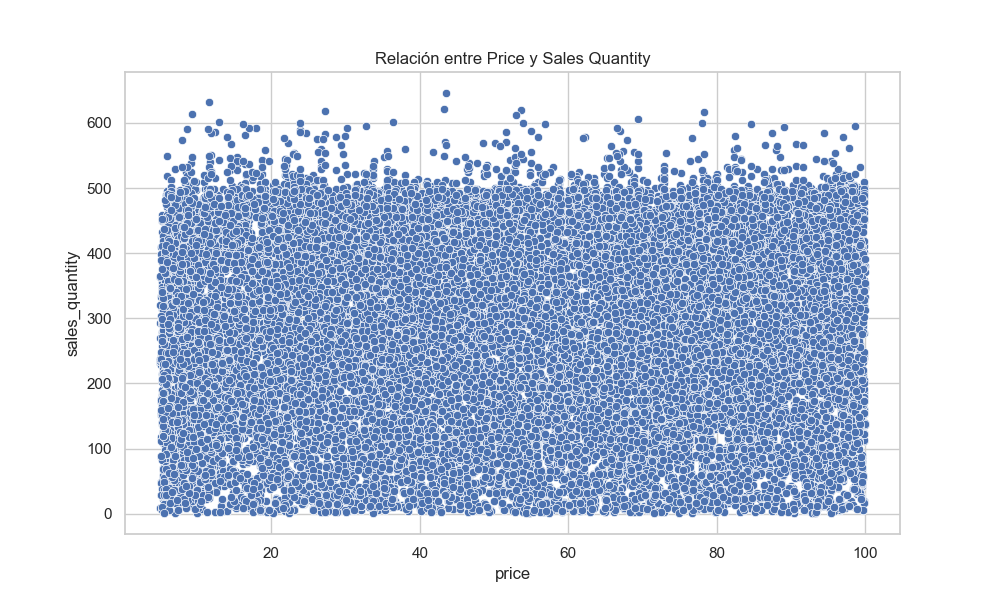

El gráfico de dispersión muestra un patrón completamente horizontal y homogéneo, sin inclinación clara. Es decir:

- Para cualquier precio, existe una gran variabilidad en las ventas.

- No hay tendencia visible de que a menor precio haya más ventas, ni al revés.

Esto sugiere ausencia de correlación lineal, lo cual cuadra con el resultado estadístico obtenido.

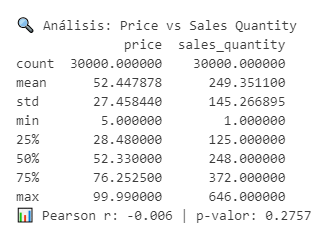

En cuanto al análisis estadístico:
- Distribución del precio bien balanceada entre 5€ y 100€.
- Percentiles simétricos respecto a la media.
- La dispersión es adecuada → el problema no es falta de variabilidad.

Por otro lado, se ha aplicado conclusión de correlación de Pearson entre Price y Sales Quantity:
- r ≈ 0 → no hay correlación lineal entre precio y ventas.
- p > 0.05 → no se rechaza la hipótesis nula (no hay relación significativa).

**Conclusión**:

Según los resultados, el precio no tiene un impacto estadísticamente significativo sobre la demanda en este conjunto de datos, al menos no de forma lineal.

Aunque en teoría el precio debería influir directamente sobre la demanda, el análisis estadístico no muestra evidencia significativa de correlación en este conjunto de datos.

La correlación de Pearson obtenida fue prácticamente nula (r = -0.006) y el p-valor (0.2757) no permite rechazar la hipótesis nula.

Este resultado puede deberse a factores como:
- La influencia de promociones sobre el precio real pagado.
- Una posible relación no lineal entre precio y ventas.
- Segmentación del catálogo que amortigua la sensibilidad al precio.

**Por tanto, se recomienda no incluir `Price` directamente como feature sin exploraciones adicionales.** Podría valorarse su transformación, o su interacción con promociones o categorías específicas.



⚠️ Advertencia:
El análisis global de Price no ha mostrado correlación significativa, pero esto puede estar distorsionado al no tener en cuenta las diferencias estructurales entre categorías de producto. 
Se ha decidido realizar un análisis segmentado para detectar relaciones específicas dentro de cada grupo homogéneo.

##### **3.1.1. Relación entre Price y demanda por categoría de producto.**

El análisis global entre `Price` y `Sales Quantity` no mostró una relación significativa. Sin embargo, este resultado puede estar condicionado por la mezcla de productos con rangos de precio y comportamiento de demanda muy distintos.

Para abordar esta limitación, se ha realizado un análisis segmentado por `product_category`, calculando la correlación entre precio y demanda dentro de cada grupo.

Este enfoque permite detectar si dentro de categorías específicas (por ejemplo, barritas, proteínas, etc.) sí existe una relación estadísticamente significativa entre el precio y la cantidad vendida.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Comprobamos si hay una columna con categoría de producto
if "categoria" not in df.columns:
    raise ValueError("La columna 'categoria' no está disponible en el dataframe.")

# Creamos un resumen con correlación y p-valor por categoría
correlaciones = []

for categoria, subdf in df.groupby("categoria"):
    if subdf["price"].nunique() > 1:
        r, p = pearsonr(subdf["price"], subdf["sales_quantity"])
        correlaciones.append({
            "categoria": categoria,
            "n_productos": len(subdf),
            "pearson_r": round(r, 3),
            "p_valor": round(p, 4)
        })

        # Gráfico por categoría (opcional)
        sns.scatterplot(data=subdf, x="price", y="sales_quantity")
        plt.title(f"Price vs Sales Quantity ({categoria})")
        plt.savefig(f"outputs/figures/price_vs_sales_quantity_{categoria}.png")
        plt.close()

# Mostrar tabla resumen
correlacion_df = pd.DataFrame(correlaciones).sort_values(by="pearson_r", key=abs, ascending=False)
print("\n📊 Correlaciones por categoría de producto:")
print(correlacion_df.sort_values(by="pearson_r", key=abs, ascending=False))

ValueError: La columna 'categoria' no está disponible en el dataframe.

✅ **Categorías con correlación fuerte y significativa (p < 0.05)**


| Categoría                  | r      | p-valor | Comentario rápido                               |
| -------------------------- | ------ | ------- | ----------------------------------------------- |
| Alimentación               | -1.000 | 0.0000  | Relación perfecta e inversa (ojo: solo 6 prod.) |
| Geles/Cremas Musculares    | 0.998  | 0.0000  | Relación muy fuerte y positiva                  |
| Exfoliantes y tratamientos | 0.988  | 0.0000  | Idem anterior                                   |
| Productos cuidado cabello  | 0.976  | 0.0007  | Muy fuerte, pero grupo pequeño                  |
| Leche y Bebidas Vegetales  | -0.838 | 0.0371  | Inversa y significativa                         |
| Suplementación             | -0.793 | 0.0000  | Inversa clara                                   |


⚠️ Nota: en algunos casos, la muestra es pequeña (n_productos = 6), así que conviene ser cautelosa.

🟨 **Categorías con correlación moderada/débil y p > 0.05**.

Estas no muestran una relación estadísticamente significativa, pero podrían tener algún efecto en modelos no lineales o con más datos.

Ejemplos:

- Cremas solares (r = 0.451, p = 0.1408)

- Especial masaje deportivo (r = -0.401, p = 0.0900)

- Platos preparados (r = 0.338, p = 0.0835)


❌ **Categorías sin relación aparente**.

La mayoría de categorías muestran valores de r cercanos a 0 con p-valor alto, lo cual confirma ausencia de relación entre precio y ventas dentro del grupo. Esto ocurre en:

Barritas, Creatina, Proteínas, Vit. y Minerales, etc.

Lo que no significa que el precio no importe, sino que su variación no ha tenido impacto observable.

**Conclusión**:

El análisis de correlación entre `Price` y `Sales Quantity` por categoría de producto revela que **la relación entre precio y demanda varía significativamente según el tipo de producto**.

- En algunas categorías concretas como *alimentación*, *suplementación* o *productos cosméticos*, el precio muestra un impacto claro y estadísticamente significativo sobre las ventas.
- En cambio, en muchas otras categorías, especialmente las más amplias o estandarizadas (como barritas, proteínas o vitaminas), no se detecta correlación aparente.

Estos resultados confirman que **el efecto del precio no es global ni lineal** en todo el catálogo, y por tanto, su inclusión como feature en un modelo predictivo debe hacerse **de forma segmentada o transformada** (por ejemplo, interacción con categoría o rangos de precio).

##### **3.1.2. Análisis del precio segmentado por clúster de comportamiento de producto.**

El análisis por categoría ha permitido detectar casos donde el precio sí influye en la demanda, pero dicha relación no es consistente ni lineal en todo el catálogo. Por ello, se plantea un enfoque complementario: segmentar los productos en función de su comportamiento general para evaluar si el efecto del precio se explica mejor a través de clústeres homogéneos.

Para ello, se ha diseñado un proceso de clustering específico a partir de una serie de variables que describen el patrón de demanda y otras características relevantes de los productos. El objetivo es agrupar productos con comportamientos similares para:

- Evaluar la sensibilidad al precio dentro de cada clúster.
- Detectar patrones de demanda más homogéneos.
- Aplicar estas agrupaciones posteriormente en la simulación de productos nuevos sin histórico.

El proceso completo se compone de las siguientes etapas:

**a. Creación del dataset consolidado de históricos (2022–2024)**  
Se unifican los tres archivos históricos y se normalizan las columnas para formar un único conjunto de datos base.

**b. Reducción de dimensionalidad de la variable 'categoria' mediante PCA**  
Se agrupan categorías poco frecuentes, se aplica One-Hot Encoding y posteriormente PCA para reducir la dimensionalidad conservando al menos el 90% de la varianza.

**c. Proceso de clustering de productos** *(realizado íntegramente en el script `clustering_productos.py`)*  
Este bloque engloba los siguientes pasos:

- Cálculo de variables agregadas por producto: se agrupan los registros por `product_id` y se calculan métricas como media, desviación estándar, porcentaje de días con ventas, etc.
- Codificación de variables categóricas adicionales: transformación de `demand_trend` (ordinal) y `customer_segments` (One-Hot Encoding).
- Integración de componentes PCA: unión de las variables anteriores con los componentes principales de `categoria`.
- Aplicación del algoritmo de clustering: Se escalan las variables, se aplica K-Means y se asigna un clúster a cada producto. Este agrupamiento se utilizará para segmentar el análisis de precio.


**d. Análisis de correlación entre Price y demanda dentro de cada clúster**  
Se calcula el coeficiente de Pearson entre `price` y `sales_quantity` para cada clúster, con el objetivo de detectar sensibilidad local al precio.


#### A. **Creación del dataset consolidado de históricos (2022–2024)**.

El primer paso del proceso consiste en unificar los archivos históricos de ventas correspondientes a los años 2022, 2023 y 2024. Esta consolidación es necesaria para disponer de una base de datos única que permita capturar el comportamiento completo de cada producto a lo largo del tiempo.

**Objetivo**: 

Construir un único dataset que represente la demanda agregada y las características de los productos durante tres años consecutivos, eliminando duplicidades y estandarizando las columnas para su posterior tratamiento.

**Pasos seguidos**:

1. **Carga de los archivos individuales**: se cargan los archivos `Historico_Ventas_2022.xlsx`, `Historico_Ventas_2023.xlsx` y `Historico_Ventas_2024.xlsx` desde la carpeta `data/clean/`.
2. **Concatenación vertical** de los tres datasets, manteniendo el orden temporal y sin perder ningún registro.
3. **Normalización de los nombres de columnas**, convirtiéndolos a formato `snake_case` (minúsculas y guiones bajos), para garantizar coherencia en los procesos posteriores.
4. **Exportación del dataset unificado** en formato `.csv`, con codificación `utf-8-sig`, bajo el nombre `historico_ventas_2022_2024.csv`, ubicado en la carpeta `data/processed/`.

**Enfoque**:

Esta estrategia permite centralizar la información de los productos sin necesidad de repetir la lectura de archivos en cada análisis. Además, garantiza que cualquier transformación aplicada al dataset se realice de forma homogénea sobre todo el periodo de estudio.

El archivo consolidado se utilizará como punto de partida para el análisis de componentes principales, el cálculo de variables agregadas por producto y la aplicación de técnicas de clustering.


**Output**: data/processed/historico_ventas_2022_2024.csv

In [ ]:
# ──────────────────────────────────────────────
# 1. Imports y configuración
# ──────────────────────────────────────────────
import pandas as pd
import os

os.makedirs("data/processed", exist_ok=True)

# ──────────────────────────────────────────────
# 2. Rutas de entrada
# ──────────────────────────────────────────────
archivos = [
    "../data/clean/Historico_Ventas_2022.xlsx",
    "../data/clean/Historico_Ventas_2023.xlsx",
    "../data/clean/Historico_Ventas_2024.xlsx"
]

# ──────────────────────────────────────────────
# 3. Carga y unificación
# ──────────────────────────────────────────────
dfs = [pd.read_excel(f) for f in archivos]
df = pd.concat(dfs, ignore_index=True)
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# Verificación básica
print("\n✅ Consolidación completada. Vista previa del dataset unificado:")
print(df.head())
print("\nColumnas:", df.columns.tolist())
print(f"\nTotal de registros: {len(df):,}")

# ──────────────────────────────────────────────
# 4. Guardado del dataset unificado
# ──────────────────────────────────────────────
salida = "../data/processed/historico_ventas_2022_2024.csv"
df.to_csv(salida, index=False, encoding='utf-8-sig')
print(f"\n💾 Archivo guardado en: {salida}")



✅ Consolidación completada. Vista previa del dataset unificado:
   product_id          ean13   marca                proveedor  \
0        1000  8436567350999  226ERS  226ERS SPORTS THINGS SL   
1        1000  8436567350999  226ERS  226ERS SPORTS THINGS SL   
2        1000  8436567350999  226ERS  226ERS SPORTS THINGS SL   
3        1001  8436567350319  226ERS  226ERS SPORTS THINGS SL   
4        1001  8436567350319  226ERS  226ERS SPORTS THINGS SL   

                                              nombre   categoria  stock_real  \
0       226ERS Sub9 Salts Electrolytes 100 CÃ¡psulas  Sin Gluten         145   
1       226ERS Sub9 Salts Electrolytes 100 CÃ¡psulas  Sin Gluten         145   
2       226ERS Sub9 Salts Electrolytes 100 CÃ¡psulas  Sin Gluten         145   
3  226ERS SALTS ELECTROLYTES 100 CAPS: CÃ¡psulas ...  Hidratacin         156   
4  226ERS SALTS ELECTROLYTES 100 CAPS: CÃ¡psulas ...  Hidratacin         156   

  novedades       date  sales_quantity  price promotions season

#### B. **Reducción de dimensionalidad de la variable 'categoria' mediante PCA**.

La variable `categoria` describe el tipo de producto dentro del catálogo comercial, pero contiene más de 60 valores distintos. Este nivel de cardinalidad la convierte en una variable problemática para algoritmos como K-Means, ya que:

- Introduce alta dimensionalidad si se codifica directamente con One-Hot Encoding.
- Aporta ruido por la presencia de muchas categorías poco frecuentes.
- No tiene una relación ordinal o métrica clara entre sus valores.

**Objetivo**:

Reducir la dimensionalidad de `categoria` para que pueda ser utilizada en el clustering sin comprometer el rendimiento ni la interpretabilidad del modelo.

**Pasos seguidos**:

1. **Agrupación de categorías poco frecuentes** bajo la etiqueta `"Otros"` para evitar ruido y asegurar suficiente representatividad de cada grupo.
2. **Codificación One-Hot** de la columna `categoria_limpia` resultante, generando variables binarias para cada categoría.
3. **Aplicación de Análisis de Componentes Principales (PCA)** sobre el conjunto codificado para identificar combinaciones lineales que capturen la mayor parte de la variabilidad.
4. **Selección del número óptimo de componentes**: se ha fijado un umbral mínimo del 90% de varianza explicada, con un mínimo de 5 componentes. El PCA ha devuelto un total de **19 componentes principales**.
5. **Exportación del resultado** como `data/processed/componentes_categoria_pca.csv`, donde cada producto queda representado por un conjunto reducido de variables numéricas (`categoria_pca_1`, `categoria_pca_2`, ..., `categoria_pca_19`).


**Enfoque**:

Esta transformación permite incorporar la información semántica contenida en la categoría de producto sin sobrecargar el modelo con decenas de columnas binarias. El PCA comprime esa información en un espacio más compacto y numérico, ideal para tareas de segmentación como el clustering.

El resultado se integrará más adelante con el resto de variables agregadas por producto.

**Output**: 'data/processed/componentes_categoria_pca.csv'

In [ ]:
# ──────────────────────────────────────────────
# 1. Imports y configuración inicial
# ──────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import os

# Configuración de visualización
sns.set(style="whitegrid")
os.makedirs("outputs", exist_ok=True)

# ──────────────────────────────────────────────
# 2. Carga y preparación de los datos
# ──────────────────────────────────────────────
df = pd.read_csv("../data/processed/historico_ventas_2022_2024.csv", encoding="utf-8-sig")
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# ──────────────────────────────────────────────
# 3. Agrupación de categorías poco frecuentes en 'Otros'
# ──────────────────────────────────────────────
frecuencia_minima = 100
conteos = df["categoria"].value_counts()
categorias_validas = conteos[conteos >= frecuencia_minima].index
df["categoria_limpia"] = df["categoria"].where(df["categoria"].isin(categorias_validas), "Otros")

# Nos quedamos con una sola categoría por product_id
df_unico = df.groupby("product_id").agg({
    "categoria_limpia": "first"
}).reset_index()

# ──────────────────────────────────────────────
# 4. Codificación One-Hot de la variable 'categoria_limpia'
# ──────────────────────────────────────────────
ohe = OneHotEncoder(sparse_output=False)
categoria_codificada = ohe.fit_transform(df_unico[["categoria_limpia"]])
col_names = ohe.get_feature_names_out(["categoria_limpia"])
df_ohe = pd.DataFrame(categoria_codificada, columns=col_names, index=df_unico["product_id"])

# ──────────────────────────────────────────────
# 5. Aplicación del PCA
# ──────────────────────────────────────────────
pca = PCA()
pca_result = pca.fit_transform(df_ohe)

var_acumulada = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_acumulada)+1), var_acumulada, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title("Varianza explicada acumulada por número de componentes")
plt.xlabel("Nº de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.grid()
plt.savefig("../outputs/figures/pca_categoria_varianza.png")
plt.close()

# ──────────────────────────────────────────────
# 6. Selección de componentes principales y exportación
# ──────────────────────────────────────────────
n_componentes = max(5, np.argmax(var_acumulada >= 0.90) + 1)

df_pca = pd.DataFrame(pca_result[:, :n_componentes],
                      columns=[f"categoria_pca_{i+1}" for i in range(n_componentes)])
df_pca["product_id"] = df_ohe.index

df_pca.to_csv("data/processed/componentes_categoria_pca.csv", index=False)

print(f"\n✅ PCA completado. Se han seleccionado {n_componentes} componentes principales.\n")


✅ PCA completado. Se han seleccionado 19 componentes principales.



#### C. **Proceso de clustering**.

1. **Cálculo de variables agregadas por producto**.

Con el dataset de históricos unificado, el siguiente paso consiste en construir un resumen estadístico por `product_id` que represente el comportamiento de cada producto a lo largo del tiempo. Esta transformación permite convertir una serie temporal diaria en un conjunto de variables explicativas que describen la demanda de forma compacta.

***Objetivo***:

Generar un DataFrame por producto que contenga variables numéricas que caractericen su patrón de ventas, variabilidad y comportamiento estructural. Estas variables constituirán las features base para el clustering.


***Variables calculadas***:
- `sales_quantity_mean`: media de la cantidad vendida por producto.
- `sales_quantity_std`: desviación estándar de la demanda → mide la variabilidad.
- `coef_var`: coeficiente de variación (std / media) → mide estabilidad relativa.
- `pct_dias_con_ventas`: porcentaje de días con ventas positivas → mide recurrencia.
- `has_promotions`: 1 si el producto tuvo alguna promoción, 0 si no.
- `has_seasonality_factor`: 1 si estuvo afectado por algún evento estacional, 0 si no.
- `has_external_factor`: 1 si tuvo impacto externo, 0 si no.
- `price_mean`: precio medio del producto.

Estas variables se calcularán a partir del dataset consolidado, agrupando los registros por `product_id`.


***Justificación***: 

Este resumen estadístico permite capturar información fundamental sobre cada producto sin necesidad de trabajar con series temporales completas. Además, estandariza la información para que pueda combinarse fácilmente con otras variables (como los componentes PCA o las categóricas codificadas) y alimentar el algoritmo de clustering.



 2. **Codificación de variables categóricas**.

Además de las variables numéricas calculadas a partir del comportamiento de ventas, se incluyen en el clustering algunas variables categóricas que aportan contexto estructural y de posicionamiento comercial del producto.

Estas variables requieren codificación previa para ser utilizadas por algoritmos de clustering basados en distancia.

***Objetivo***:

Transformar las variables categóricas `demand_trend` y `customer_segments` en formato numérico para poder ser integradas con las demás features del modelo de clustering.


***Variables transformadas***:


- **`demand_trend`** → codificación ordinal:
  - `"Stable"` → `0`
  - `"Increasing"` → `1`
  - `"Decreasing"` → `-1`

  Esta variable se interpreta como una tendencia estructural en la evolución de la demanda, por lo que puede ser codificada respetando su orden natural.

- **`customer_segments`** → codificación One-Hot:
  - `"Budget"`, `"Regular"`, `"Premium"` → transformados en tres columnas binarias.
  - Esta codificación evita introducir un orden falso entre los segmentos y permite captar diferencias sin sesgo.

  ***Justificación***:

  Estas variables permiten introducir información valiosa sin necesidad de recurrir a datos adicionales. En concreto:

- `demand_trend` aporta una señal directa sobre la evolución del producto a lo largo del tiempo.
- `customer_segments` permite capturar el posicionamiento del producto en función del público objetivo al que va dirigido.

Ambas variables ayudan a refinar los clústeres y aumentar su coherencia con la realidad del negocio.

 3. **Integración de los componentes PCA**.

En pasos anteriores, la variable `categoria` fue transformada mediante un Análisis de Componentes Principales (PCA), con el fin de reducir su dimensionalidad y evitar que su codificación afecte negativamente al clustering.

Los resultados de este proceso fueron guardados en un archivo externo (`componentes_categoria_pca.csv`), que contiene, para cada `product_id`, un conjunto de variables numéricas (`categoria_pca_1`, `categoria_pca_2`, ..., `categoria_pca_n`) que resumen la variabilidad contenida originalmente en la variable `categoria`.

***Objetivo***:

Unir los componentes principales obtenidos del PCA con el resto de variables ya preparadas (numéricas y categóricas codificadas), para construir un único dataset listo para aplicar el clustering.

***Pasos seguidos***:
1. Lectura del archivo `componentes_categoria_pca.csv`, que contiene los 19 componentes principales calculados previamente.
2. *Unión con el dataset de variables agregadas por producto mediante la clave `product_id`.
3. Verificación de estructura y ausencia de valores nulos antes de pasar al modelo de clustering.

***Justificación***:

Esta integración garantiza que toda la información útil de la variable `categoria` se mantiene en el modelo, pero de forma comprimida y numérica. Esto mejora la estabilidad del algoritmo de clustering y evita que una única variable con alta cardinalidad domine el agrupamiento final.

Además, al realizar la reducción de dimensionalidad por separado y luego integrarla, se mantiene la modularidad del proyecto y la posibilidad de reutilizar componentes en futuros análisis.

4. **Aplicación del algoritmo de clustering**.

Una vez generado el dataset final con todas las variables (agregadas, codificadas y componentes PCA), se procede a aplicar un algoritmo de clustering con el objetivo de agrupar los productos según su comportamiento.

Se ha optado por el algoritmo **K-Means**, dado que:

- Es eficiente para datasets medianos.
- Requiere un número de clústeres predefinido, pero es fácilmente interpretable.
- Es adecuado cuando las variables están en un espacio numérico continuo (como es el caso tras aplicar codificaciones y PCA).

***Objetivo***:

Asignar a cada producto un `cluster` que agrupe a productos con características similares, permitiendo luego analizar patrones de comportamiento, sensibilidad al precio y otros fenómenos de forma segmentada.

***Pasos seguidos***:

1. Selección de las variables finales (features): se eligen las columnas numéricas que formarán parte del clustering, incluyendo:
   - Variables agregadas (`sales_quantity_mean`, `coef_var`, etc.)
   - Variables codificadas (`demand_trend`, segmentos)
   - Componentes del PCA de `categoria`

2. Estandarización de las variables con `StandardScaler`, para que todas contribuyan equitativamente a la distancia.

3. Aplicación del algoritmo `KMeans` con un número de clústeres definido (ej. 5).

4. Evaluación del número óptimo de clústeres con criterios como la métrica Silhouette o la visualización del codo (`elbow method`), si se desea afinar el modelo.

5. Asignación de etiquetas de clúster al dataset, que luego serán utilizadas para segmentar el análisis de la relación entre `price` y `sales_quantity`.


***Justificación***:

Este modelo de clustering permite identificar grupos de productos que comparten un patrón común de comportamiento. La segmentación obtenida será usada en el siguiente paso del análisis, donde se evalúa si la relación entre precio y demanda es más significativa dentro de cada clúster que en el conjunto general.

Además, al encapsular el proceso en una función reutilizable, se puede aplicar posteriormente en otras fases del proyecto (como la simulación de demanda para productos sin histórico).

In [ ]:
# ──────────────────────────────────────────────
# 1. Imports y configuración
# ──────────────────────────────────────────────
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# ──────────────────────────────────────────────
# 2. Funcion principal de clustering
# ──────────────────────────────────────────────
def aplicar_clustering(df, features, n_clusters=5, random_state=42):
    """
    Aplica clustering con KMeans sobre un subconjunto de columnas seleccionadas.

    Parámetros:
    - df (DataFrame): dataset que contiene las variables numéricas preparadas.
    - features (list): lista de columnas numéricas a usar como input para el clustering.
    - n_clusters (int): número de clústeres deseado.
    - random_state (int): semilla para reproducibilidad.

    Devuelve:
    - df_result (DataFrame): copia del df original con columna 'cluster' asignada.
    - modelo (KMeans): modelo KMeans ya entrenado.
    """
    df_trabajo = df.copy()

    # Estandarización de variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_trabajo[features])

    # Clustering
    modelo = KMeans(n_clusters=n_clusters, random_state=random_state)
    df_trabajo["cluster"] = modelo.fit_predict(X_scaled)

    return df_trabajo, modelo

# ──────────────────────────────────────────────
# 3. Pipeline completo si se ejecuta directamente
# ──────────────────────────────────────────────
if __name__ == "__main__":
    # --- Paso c. Cálculo de variables agregadas por producto ---
    df_historico = pd.read_csv("../data/processed/historico_ventas_2022_2024.csv", encoding="utf-8-sig")
    df_historico.columns = [col.lower().replace(" ", "_") for col in df_historico.columns]

    # Crear columnas binarias para presencia de factores
    df_historico["has_seasonality_factor"] = df_historico["seasonality_factors"].notna().astype(int)
    df_historico["has_external_factor"] = df_historico["external_factors"].notna().astype(int)
    df_historico["promotions"] = df_historico["promotions"].map({"Yes": 1, "No": 0})

    agrupado = df_historico.groupby("product_id").agg({
        "sales_quantity": ["mean", "std", lambda x: (x > 0).mean()],
        "price": "mean",
        "promotions": "max",
        "has_seasonality_factor": "max",
        "has_external_factor": "max",
        "demand_trend": "first",
        "customer_segments": "first"
    }).reset_index()

    agrupado.columns = ["product_id", "sales_quantity_mean", "sales_quantity_std",
                        "pct_dias_con_ventas", "price_mean", "has_promotions",
                        "has_seasonality_factor", "has_external_factor",
                        "demand_trend", "customer_segments"]

    agrupado["coef_var"] = agrupado["sales_quantity_std"] / agrupado["sales_quantity_mean"]

    # --- Paso d. Codificación de categóricas ---
    tendencia_map = {"Stable": 0, "Increasing": 1, "Decreasing": -1}
    agrupado["demand_trend_encoded"] = agrupado["demand_trend"].map(tendencia_map)

    ohe = OneHotEncoder(sparse_output=False, drop=None)
    segment_array = ohe.fit_transform(agrupado[["customer_segments"]])
    segment_df = pd.DataFrame(segment_array, columns=ohe.get_feature_names_out(["customer_segments"]))
    agrupado = pd.concat([agrupado, segment_df], axis=1)

    # --- Paso e. Integración del PCA ---
    df_pca = pd.read_csv("../data/processed/componentes_categoria_pca.csv")
    df_completo = agrupado.merge(df_pca, on="product_id", how="left")

    # --- Paso f. Clustering ---
    columnas_clustering = [
        "sales_quantity_mean", "sales_quantity_std", "coef_var", "pct_dias_con_ventas",
        "has_promotions", "has_seasonality_factor", "has_external_factor", "price_mean",
        "demand_trend_encoded"
    ] + list(segment_df.columns) + [col for col in df_pca.columns if col.startswith("categoria_pca_")]

    df_con_clusters, modelo_kmeans = aplicar_clustering(df_completo, columnas_clustering, n_clusters=5)

    # Guardar resultados
    df_con_clusters.to_csv("../data/processed/productos_con_clusters.csv", index=False)
    print("✅ Clustering aplicado y resultados guardados.")

✅ Clustering aplicado y resultados guardados.


##### 🧩 Función `aplicar_clustering()`

La siguiente función se ha definido para encapsular el proceso de clustering y permitir su reutilización desde cualquier parte del proyecto:

```python
def aplicar_clustering(df, features, n_clusters=5, random_state=42):
    """
    Aplica clustering con KMeans sobre un subconjunto de columnas seleccionadas.

    Parámetros:
    - df (DataFrame): dataset que contiene las variables numéricas preparadas.
    - features (list): lista de columnas numéricas a usar como input para el clustering.
    - n_clusters (int): número de clústeres deseado.
    - random_state (int): semilla para reproducibilidad.

    Devuelve:
    - df_result (DataFrame): copia del df original con columna 'cluster' asignada.
    - modelo (KMeans): modelo KMeans ya entrenado.
    """


Esta función:
- Escala automáticamente las features antes de aplicar el modelo.
- Asigna un clúster a cada fila del DataFrame.
- Devuelve tanto el DataFrame etiquetado como el objeto del modelo entrenado, lo que permite utilizarlo en simulaciones, análisis comparativos o visualizaciones.

✅ Al mantenerla fuera del flujo principal de ejecución, se puede importar desde otros scripts o notebooks con:

from scripts.transform.clustering_productos import aplicar_clustering

#### D. **Análisis de correlación entre precio y demanda dentro de cada clúster**.

Una vez agrupados los productos según su comportamiento mediante clustering, el siguiente paso consiste en analizar si el precio tiene una influencia más significativa sobre la demanda cuando se observa dentro de cada clúster, en lugar de a nivel global o por categoría.

Este enfoque permite detectar si la sensibilidad al precio se concentra en determinados segmentos de productos, lo que no siempre es evidente cuando se analiza el conjunto completo del catálogo.

***Objetivo***:
evaluar si existe una correlación más fuerte entre `price` y `sales_quantity` cuando se analiza por clúster. El objetivo es identificar patrones de comportamiento diferenciados en cuanto a sensibilidad al precio.

***Etapas del análisis***:

1. Estudio descriptivo de los clústers:
- Se resumen las características clave de cada clúster:
    - Tamaño (nº de productos).
    - Precio medio.
    - Demanda media.
    - Variabilidad (coef_var)
    - % de productos con promociones o factores estacionales.

- Esto permite interpretar el perfil de cada grupo.


2. Análisis de correlación dentro de cada clúster:
- Se calcula el coeficiente de correlación de Pearson entre `price_mean` y `sales_quantity_mean` dentro de cada grupo.
- Se reportan los valores del coeficiente y su p-valor para evaluar significación estadística.


3. Visualización: 
-  Diagramas de dispersión (`scatterplot`) de `price_mean` vs `sales_quantity_mean` para cada clúster.
- Boxplots de `sales_quantity_mean` segmentados por clúster.
- Gráfico de barras con los coeficientes de correlación por grupo.

***Enfoque***:
el clustering agrupa productos con características similares de comportamiento. Analizar la relación entre precio y demanda dentro de estos grupos homogéneos permite detectar patrones que podrían quedar ocultos si se trabaja con el dataset global. Además, ayuda a priorizar estrategias diferenciadas por segmento.

Este análisis será clave más adelante para justificar la inclusión o simulación del efecto del precio en la generación de demanda para productos nuevos.


**1**. **Estudio descriptivo de los clústers**.

Antes de analizar la relación entre `price` y `sales_quantity`, se realiza un estudio descriptivo para interpretar las características principales de cada clúster generado en el apartado anterior.

Este paso permite:

- Entender el perfil medio de cada grupo.
- Detectar si existen diferencias sustanciales en variables como la demanda, el precio o la variabilidad.
- Comprobar si algunos clústeres agrupan productos de comportamiento “atípico” o “homogéneo”.


**Métricas analizadas por clúster**:
- **Tamaño del clúster** (número de productos)
- **Media y desviación estándar de `sales_quantity_mean`**
- **Media y desviación estándar de `price_mean`**
- **Coeficiente de variación (`coef_var`)** medio
- **% de productos con promociones, factores estacionales y externos**

Estas estadísticas permiten interpretar si hay clústeres más sensibles al precio, más estables en ventas o más expuestos a eventos externos.

A continuación se muestra una tabla resumen con estos indicadores agrupados por clúster.

In [ ]:
# ──────────────────────────────────────────────
# 1. Imports y configuración
# ──────────────────────────────────────────────
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

sns.set(style="whitegrid")
os.makedirs("outputs", exist_ok=True)

# ──────────────────────────────────────────────
# 2. Carga del dataset con clustering aplicado
# ──────────────────────────────────────────────
df = pd.read_csv("../data/processed/productos_con_clusters.csv")

# ──────────────────────────────────────────────
# 3. Análisis descriptivo por clúster
# ──────────────────────────────────────────────
resumen = df.groupby("cluster").agg({
    "product_id": "count",
    "sales_quantity_mean": ["mean", "std"],
    "price_mean": ["mean", "std"],
    "coef_var": "mean",
    "has_promotions": "mean",
    "has_seasonality_factor": "mean",
    "has_external_factor": "mean"
})

# Renombrar columnas para claridad
resumen.columns = ["_".join(col).strip() for col in resumen.columns.values]
resumen = resumen.rename(columns={"product_id_count": "num_productos"})

# Guardar la tabla resumen
resumen.to_csv("../data/processed/resumen_clusters_price.csv")
print("✅ Tabla descriptiva por clúster guardada en 'data/processed/resumen_clusters_price.csv'")

print("\n📊 Resumen descriptivo por clúster:")
print(resumen)


✅ Tabla descriptiva por clúster guardada en 'data/processed/resumen_clusters_price.csv'

📊 Resumen descriptivo por clúster:
         num_productos  sales_quantity_mean_mean  sales_quantity_mean_std  \
cluster                                                                     
0                 1528                231.580455                78.419002   
1                  391                246.810870               129.008067   
2                 3724                258.674770               138.040506   
3                  317                247.537417               130.367328   
4                  105                263.627778               127.728653   

         price_mean_mean  price_mean_std  coef_var_mean  has_promotions_mean  \
cluster                                                                        
0              52.267664       17.412303       0.614044             0.823298   
1              51.857272       23.911059       0.234871             0.647059   
2              5

🧩 **Análisis descriptivo por clúster (resumen)**.

- Clúster 0  es el más numeroso y presenta un perfil muy afectado por factores externos: más del 97% de los productos están expuestos a estacionalidad y factores externos, y un 82% a promociones. Su coeficiente de variación también es el más alto, indicando alta inestabilidad en la demanda.
- Clúster 1 es el más pequeño (391 productos) y el más estable, con el coef_var más bajo. Tiene un precio ligeramente más alto y una demanda media considerable. La exposición a factores externos y estacionales es más baja que en otros grupos, lo que sugiere productos menos influenciables.
- Clúster 2 tiene el mayor volumen de productos y destaca por tener la demanda media más alta y el precio medio más bajo. Esta combinación podría indicar cierta sensibilidad al precio o un perfil de producto “básico” de alta rotación.
- Clúster 3 tiene un comportamiento bastante homogéneo y estable. La demanda media y la dispersión son moderadas, y tanto su exposición a promociones como a factores estacionales es relativamente equilibrada.
-  Clúster 4 es el más reducido y destaca por tener el precio más alto del conjunto. Su demanda media es similar a la de otros grupos, pero muestra una desviación estándar notable. Este perfil podría corresponder a productos premium o de baja elasticidad.
-  En conjunto, todos los clústers presentan alta exposición a factores estacionales (por encima del 75%), aunque con diferencias sustanciales en cuanto a estabilidad y niveles de precio/demanda.

**2**. **Análisis de correlación dentro de cada clúster**.

Tras obtener un resumen descriptivo de los clústeres, se analiza si existe una relación significativa entre el precio medio (`price_mean`) y la demanda media (`sales_quantity_mean`) dentro de cada grupo.

**Objetivo**:
evaluar si los productos dentro de un mismo clúster muestran un comportamiento coherente en cuanto a sensibilidad al precio. Una correlación significativa sugeriría que ese grupo responde de forma estructurada al precio, lo que permitiría incorporar ajustes en modelos o simulaciones.

**Metodología**:

- Se agrupa el dataset por `cluster`.
- Dentro de cada grupo, se calcula el **coeficiente de correlación de Pearson** entre `price_mean` y `sales_quantity_mean`.
- También se reporta el **p-valor** para evaluar la significación estadística de dicha relación.
- Los resultados se consolidan en un archivo `.csv` para su interpretación posterior.

 **Enfoque**:
analizar la sensibilidad al precio desde una perspectiva segmentada permite detectar patrones que podrían estar enmascarados a nivel global. Identificar clústeres con relación significativa negativa entre precio y demanda puede guiar decisiones de pricing y simulaciones más realistas para productos sin histórico.

In [ ]:
# ──────────────────────────────────────────────
# 4. Correlación precio-demanda por clúster
# ──────────────────────────────────────────────
resultados = []

for cluster_id in sorted(df["cluster"].unique()):
    subdf = df[df["cluster"] == cluster_id]
    r, p = stats.pearsonr(subdf["price_mean"], subdf["sales_quantity_mean"])
    resultados.append({
        "cluster": cluster_id,
        "pearson_r": round(r, 3),
        "p_valor": round(p, 4),
        "n_productos": len(subdf)
    })

df_corr = pd.DataFrame(resultados)
df_corr.to_csv("../data/processed/correlacion_price_por_cluster.csv", index=False)
print("📊 Correlaciones por clúster guardadas en '../data/processed/correlacion_price_por_cluster.csv'")

print("\n📈 Correlación precio-demanda por clúster:")
print(df_corr.sort_values(by="pearson_r", key=abs, ascending=False))

📊 Correlaciones por clúster guardadas en '../data/processed/correlacion_price_por_cluster.csv'

📈 Correlación precio-demanda por clúster:
   cluster  pearson_r  p_valor  n_productos
4        4     -0.171   0.0814          105
1        1      0.018   0.7192          391
3        3     -0.007   0.8966          317
2        2      0.003   0.8461         3724
0        0     -0.000   0.9962         1528


**Interpretación de resultados**:

1. ✅ Clústeres con posible relación (aunque débil):

- Clúster 4: 
    - Muestra la única correlación negativa moderada (r = -0.171) con un p-valor cercano a significación estadística (p = 0.0814).
    - Aunque no alcanza el umbral habitual de 0.05, podría considerarse en un análisis exploratorio como sensible al precio.

2. ❌ Clústeres sin relación clara:
- Clústeres 0, 1, 2 y 3 no presentan correlaciones significativas ni coeficientes relevantes. Los r están cercanos a cero y los p_valores son todos > 0.7.

**Conclusión**:

1. Ningún clúster muestra una relación fuerte ni significativa en términos convencionales.
2. Solo el Clúster 4 sugiere una posible sensibilidad al precio moderada, que podría modelarse con cautela o de forma determinista.
3. Para el resto, si se desea simular el efecto del precio, debería hacerse mediante ruido aleatorio, sin imponer una estructura directa.

**3**. **Visualización**.

3.1. **Scatterplots por clúster**.

In [ ]:
# ──────────────────────────────────────────────
# 5.1 Scatterplots (price_mean vs sales_quantity_mean)
# ──────────────────────────────────────────────
print("\n🎯 Generando scatterplots por clúster...")

for cluster_id in sorted(df["cluster"].unique()):
    subdf = df[df["cluster"] == cluster_id]
    
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=subdf,
        x="price_mean",
        y="sales_quantity_mean",
        alpha=0.7,
        color=sns.color_palette("tab10")[cluster_id]
    )
    
    plt.title(f"Cluster {cluster_id}: Precio medio vs Cantidad vendida")
    plt.xlabel("Precio medio (€)")
    plt.ylabel("Cantidad media vendida")
    plt.grid(True)
    plt.tight_layout()
    
    output_path = f"../outputs/figures/scatter_cluster_{cluster_id}.png"
    plt.savefig(output_path)
    plt.close()

print("✅ Scatterplots guardados en carpeta '../outputs/'")



🎯 Generando scatterplots por clúster...
✅ Scatterplots guardados en carpeta '../outputs/'


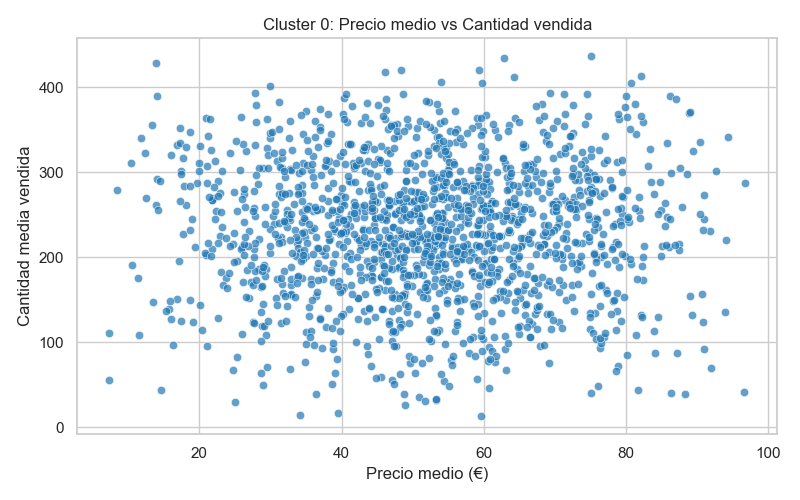

**Análisis del clúster 0**

- Densidad alta, con muchos productos.
- La nube de puntos muestra una dispersión casi uniforme: no se percibe una relación lineal entre precio medio y cantidad vendida.
- La concentración de puntos alrededor del centro indica un comportamiento generalizado, sin grandes extremos.


***Conclusión***: este clúster no presenta sensibilidad aparente al precio. Aunque su tamaño es elevado, la demanda parece insensible al precio en todos los rangos. No se recomienda aplicar un ajuste directo.


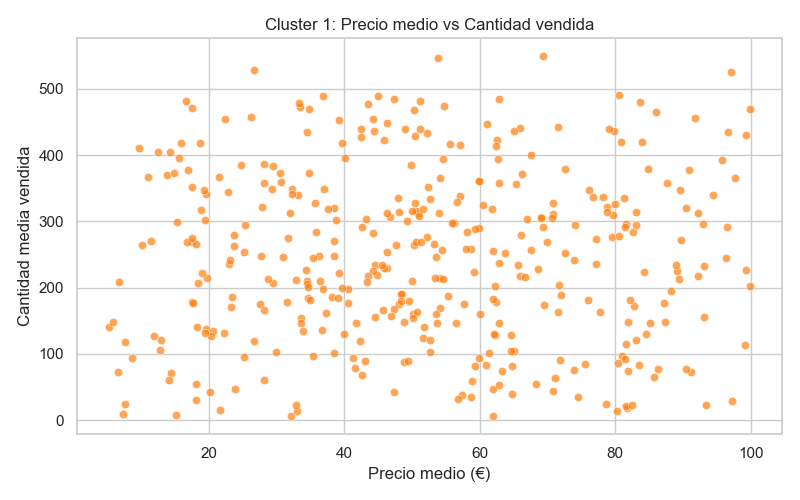

**Análisis del clúster 1**:

- Grupo reducido, pero con alta dispersión en la demanda a todos los niveles de precio.
- SNo se distingue ningún patrón de correlación. Hay productos con alta demanda tanto en precios bajos como altos.


***Conclusión***:o se observa un comportamiento coherente. El efecto del precio parece aleatorio o irrelevante, por lo que podría simularse con ruido, si es necesario.

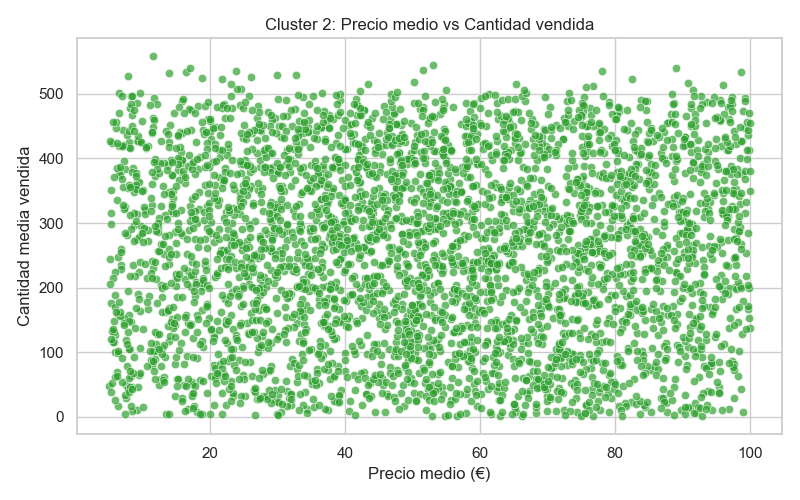

**Análisis del clúster 2**:

- Clúster más poblado, con distribución totalmente homogénea en la nube de puntos.
- La demanda está repartida de forma muy uniforme sin ninguna tendencia.

***Conclusión***: este clúster es el más claro ejemplo de no correlación. El precio no condiciona la demanda de ningún modo observable. Solo se justificaría un efecto artificial con ruido.

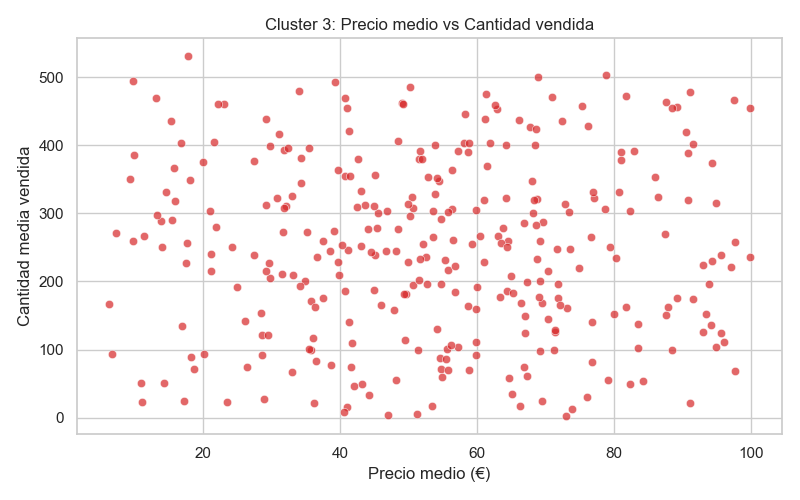

**Análisis del clúster 3**:

- Conjunto reducido, pero con productos distribuidos en distintos rangos de precio.
- La dispersión también es alta y no permite detectar una pendiente o patrón lineal.


***Conclusión***: aunque el número de productos es bajo, no se aprecia relación entre precio y demanda. El grupo puede simularse con un patrón neutro o aleatorio.

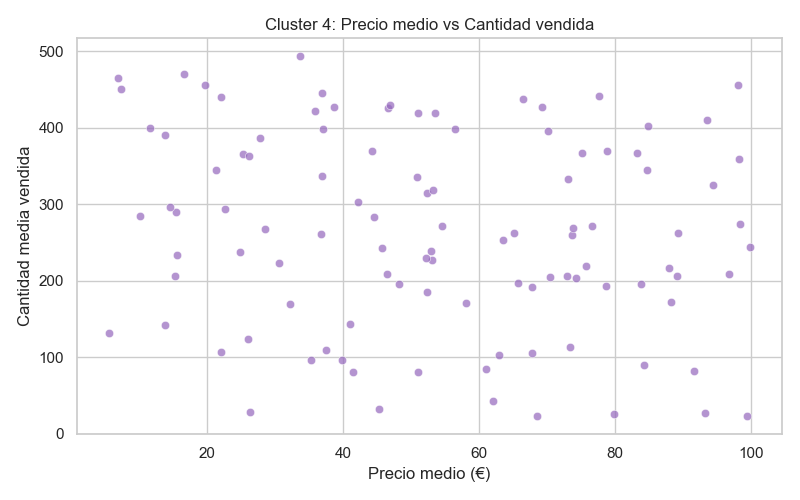

**Análisis del clúster 4**:

- Nube más suelta, pero con leve pendiente descendente en la parte central.
- Algunos productos de alto precio tienden a tener menor demanda.

***Conclusión***: aunque la correlación no alcanza significación estadística, es el único clúster donde se aprecia una tendencia visual negativa moderada. Podría considerarse como base para simular el efecto del precio de forma determinista y controlada.

| Clúster | Sensibilidad visual al precio | Recomendación simulación              |
| ------- | ----------------------------- | ------------------------------------- |
| 0       | Nula                          | Con ruido (no aplicar efecto directo) |
| 1       | Nula                          | Con ruido                             |
| 2       | Nula                          | Con ruido                             |
| 3       | Nula/debil                    | Con ruido o efecto leve               |
| 4       | Débil pero clara visualmente  | Determinista (sin ruido)              |


3.2. **Boxplot de sales_quantity_mean por clúster**.

Los objetivos de este gráfico son:

- Visualizar si algunos clústers tienen, en general, mayores o menores volúmenes de ventas.
- Detectar posibles asimetrías, outliers o diferencias notables en la dispersión. 


📦 Generando boxplot de cantidad media vendida por clúster...


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\4161588564.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


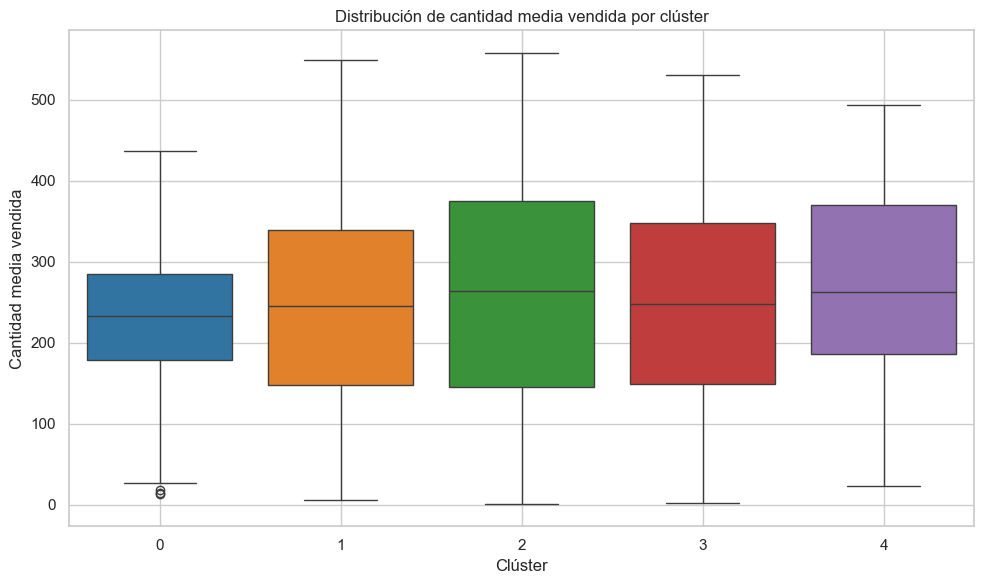

✅ Boxplot guardado en '../outputs/figures/boxplot_sales_quantity_mean_por_cluster.png'


In [ ]:
# ──────────────────────────────────────────────
# 5.2 Boxplot de cantidad media vendida por clúster
# ──────────────────────────────────────────────
print("\n📦 Generando boxplot de cantidad media vendida por clúster...")

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="cluster",
    y="sales_quantity_mean",
    palette="tab10"
)

plt.title("Distribución de cantidad media vendida por clúster")
plt.xlabel("Clúster")
plt.ylabel("Cantidad media vendida")
plt.grid(True)
plt.tight_layout()

plt.savefig("../outputs/figures/boxplot_sales_quantity_mean_por_cluster.png")
plt.show()

print("✅ Boxplot guardado en '../outputs/figures/boxplot_sales_quantity_mean_por_cluster.png'")

**Interpretación del boxplot**:

Los aspectos clave que pueden visualizarse son:

1. **Mediana similar en todos los clústeres**: 
- Las medianas se hallan en torno a 250–270 uds. en todos los casos.
- Esto sugiere que el nivel medio de ventas es relativamente homogéneo entre grupos.

2. **IQRs parecidos**:
- Todos los clústeres presentan una dispersión similar en el 50% central de los datos.
- El IQR más amplio parece estar en el clúster 1, que tiene una base más extendida.

3. **Presencia de valores extremos (outliers)**:
- El clúster 0 muestra algunos outliers en el extremo superior.
- El resto de clústeres parece tener outliers más diluidos o menos visibles.

4. **Distribuciones asimétricas**:
- Algunos clústeres (por ejemplo, el 1 y el 3) tienen colas más largas hacia los valores altos.
- Esto sugiere que hay productos que venden mucho más que la mayoría, aunque son casos puntuales. 

***Conclusión***:

- A pesar de tener diferente sensibilidad al precio, los clústeres no se diferencian fuertemente por volumen medio de ventas.
- La elección de tratamiento (con o sin ruido) no debe basarse en el nivel de ventas, sino en la correlación precio-demanda.
- La dispersión interna sí puede condicionar el tipo de ruido a simular (más o menos fuerte).


3.3. **Gráfico de barras con los coeficientes de Pearson por clúster**.

Este gráfico mostrará el valor del coeficiente r calculado para cada clúster, lo que  ayudará a:

- Visualizar rápidamente en qué grupos existe una correlación más fuerte entre precio y demanda.
- Decidir qué clústeres requerien simulación con efecto determinista (sin ruido) y cuáles con ruido aleatorio. 


📊 Generando gráfico de barras con coeficientes de Pearson por clúster...


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\2551512987.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


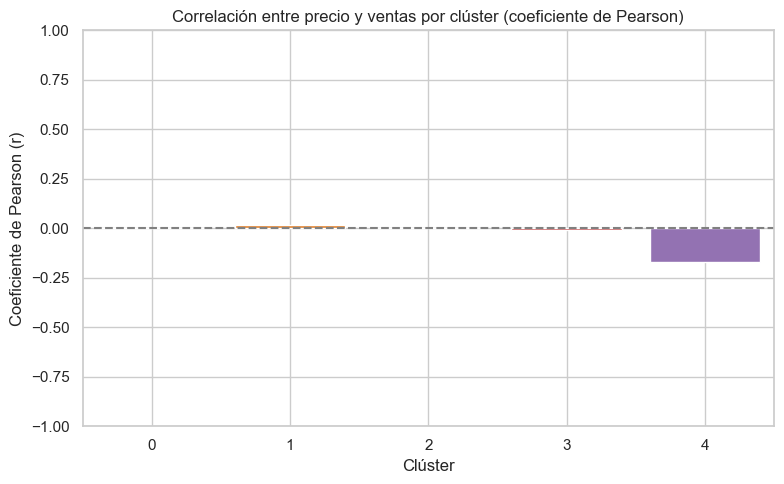

✅ Gráfico de correlaciones guardado en '../outputs/figures/pearson_por_cluster.png'


In [ ]:
# ──────────────────────────────────────────────
# 5.3 Barras con coeficientes de Pearson por clúster
# ──────────────────────────────────────────────
print("\n📊 Generando gráfico de barras con coeficientes de Pearson por clúster...")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_corr,
    x="cluster",
    y="pearson_r",
    palette="tab10"
)

plt.title("Correlación entre precio y ventas por clúster (coeficiente de Pearson)")
plt.xlabel("Clúster")
plt.ylabel("Coeficiente de Pearson (r)")
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.tight_layout()

plt.savefig("../outputs/figures/pearson_por_cluster.png")
plt.show()

print("✅ Gráfico de correlaciones guardado en '../outputs/figures/pearson_por_cluster.png'")

**Interpretación del gráfico de coeficientes de Pearson**

| Clúster | Coef. Pearson (r)   | Interpretación visual                            |
| ------: | ------------------- | ------------------------------------------------ |
|       0 | Muy cercano a 0     | Prácticamente sin correlación (dispersión total) |
|       1 | Casi 0 negativo     | Nula correlación → ruido                         |
|       2 | Levemente positivo  | Posiblemente aleatorio también                   |
|       3 | Levemente negativo  | Ligera tendencia, pero débil                     |
|       4 | Claramente negativo | Correlación negativa clara                       |

***Conclusión***:

- Únicamente el clúster 4 presenta una relación negativa que, aunque no sea muy alta, sí es sistemática y coherente con la lógica económica, esto es, a mayor precio, menos demenada y viceversa.
- El resto de clústeres presentan valores muy cercanos a cero, con correlaciones poco consistentes o incluso contrarias a la intuición (como en el 2).
- Esto refuerza la idea de que la sensibilidad al precio debe modelarse de forma diferenciada:
    - Clúster 4: simulación determinista con efecto directo del precio.
    - Clúster 3: csin relación observable; se recomienda simular con ruido suave, si fuera necesario.
- Clústeres 0, 1 y 2: simulación con ruido aleatorio, ya que no muestran una relación clara.



**Nota final 1**: 

El análisis del efecto del precio sobre la cantidad demandada se ha completado tanto a nivel general como por clúster.

Los resultados indican que únicamente el clúster 4 presenta una sensibilidad significativa y coherente al precio. No obstante, antes de implementar la simulación correspondiente, se procederá a analizar el resto de variables explicativas (promociones, estacionalidad y factores externos), a fin de obtener una visión integral del comportamiento de la demanda.

Una vez finalizado el análisis completo, se decidirá el enfoque óptimo para modelar la influencia del precio (por categoría o por clúster) y se establecerá la lógica de simulación según la variable explicativa dominante en cada caso.

**Nota final 2**:

**Decisión metodológica: ¿Simulación del precio por categoría o por clúster?**

Tras analizar la relación entre precio y cantidad vendida tanto por categoría como por clúster, se concluye que:

- A nivel de categoría, se detecta sensibilidad en algunos grupos, pero los resultados son poco concluyentes y heterogéneos.

- A nivel de clúster, el análisis ofrece una segmentación más coherente, en la que solo uno de los cinco clústeres (el clúster 4) muestra una relación significativa y económicamente consistente entre precio y demanda.

Por tanto, se decide utilizar el **clúster como base principal** para simular el efecto del precio, ya que permite aplicar reglas diferenciadas y más realistas para cada grupo.

En caso de productos nuevos sin clúster asignado, se podrá recurrir a la categoría como criterio secundario para la simulación.



---

#### **3.2. Promociones (Promotions)**.

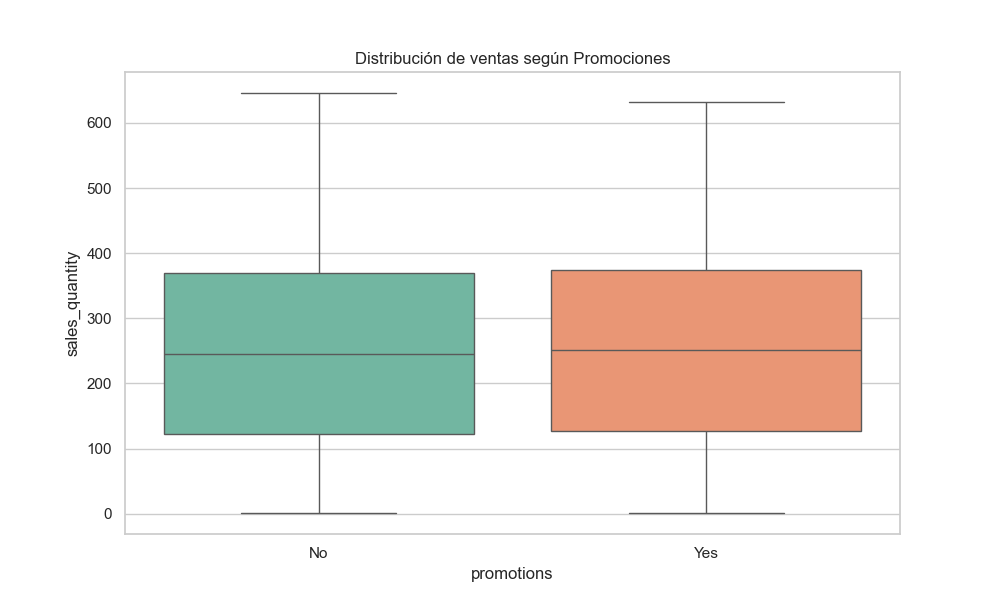

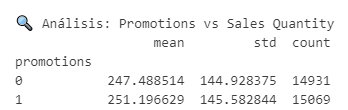



**Interpretación de los resultados visuales**:

- Las distribuciones de ventas son casi idénticas visualmente, tanto para productos con promociones como sin ellas.
- No hay desplazamiento notable en la mediana ni en el rango intercuartílico
- Esto confirma que, aunque hay una diferencia estadística, no es evidente a simple vista ni relevante económicamente.

**Interpretación de los resultados estadísticos**:

- El p-valor es < 0.05, lo que indica que la diferencia de medias entre los grupos es estadísticamente significativa.
- Sin embargo, la diferencia absoluta entre las medias (~3.7 unidades) es muy pequeña comparada con la dispersión (≈ 145), lo que nos dice que el efecto es débil a nivel práctico.

**Conclusión final**:

Las promociones tienen un efecto estadísticamente significativo sobre la cantidad media vendida, pero el impacto práctico es muy reducido.

Por tanto, aunque pueden incluirse como variable explicativa, no justificarían un cambio fuerte de estrategia o una lógica de simulación específica por sí solas.
Su efecto podría ser más relevante cuando se combinen con otros factores (como estacionalidad o precio) en escenarios concretos.

---

#### **3.3. Factores estacionales (Seasonality Factors)**.

##### **3.3.1. Análisis por tipo de evento.**

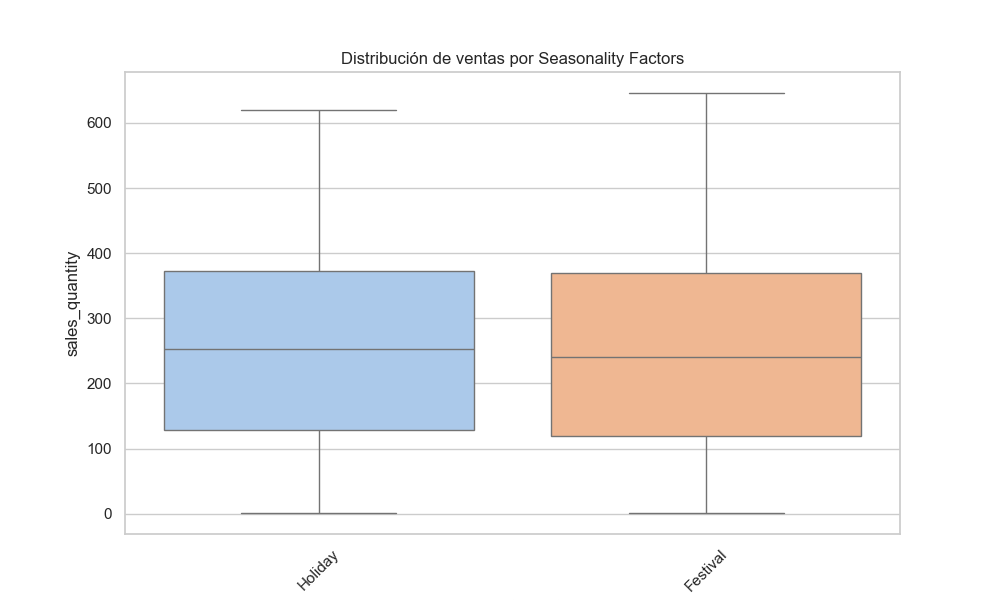

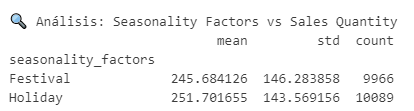



**Interpretación de los resultados visuales**:

- Las distribuciones de "Holiday" y "Festival" son muy similares.
- Las medianas están casi alineadas.
- No hay diferencias visuales destacables en dispersión o asimetría.
- El gráfico confirma lo que indica el ANOVA: existe una diferencia estadística, pero el efecto no es fuerte ni fácilmente observable.

**Interpretación de los resultados estadísticos**:

- El p-valor es < 0.01, lo que indica que sí hay diferencias estadísticamente significativas entre al menos uno de los grupos.
- La diferencia entre medias es de apenas 6 unidades, frente a una desviación estándar > 140. Por tanto, el efecto real es muy leve.

**Conclusión final**:

Aunque el análisis ANOVA muestra una diferencia estadísticamente significativa en la demanda según el tipo de evento estacional (Festival vs Holiday), dicha diferencia es muy pequeña en términos prácticos.

Por tanto, aunque se podría considerar el tipo de evento como una variable explicativa en un modelo, no se justificaría aplicar estrategias diferenciadas de simulación de demanda basadas únicamente en esta variable.



##### **3.3.2. Impacto general de la presencia de eventos (análisis binario).**

Además del análisis por tipo de evento (Holiday vs Festival), se evalúa si la **presencia de cualquier evento estacional** influye por sí sola en la demanda, independientemente de su naturaleza.

Para ello se ha creado una variable binaria (`has_seasonality_factor`) que indica si un producto está afectado o no por algún tipo de factor estacional. A continuación se realiza un t-test para comparar las medias de ventas entre los productos afectados y no afectados.

Este análisis complementa al anterior y permite saber si **el hecho de tener un evento asociado ya marca una diferencia significativa en las ventas.**

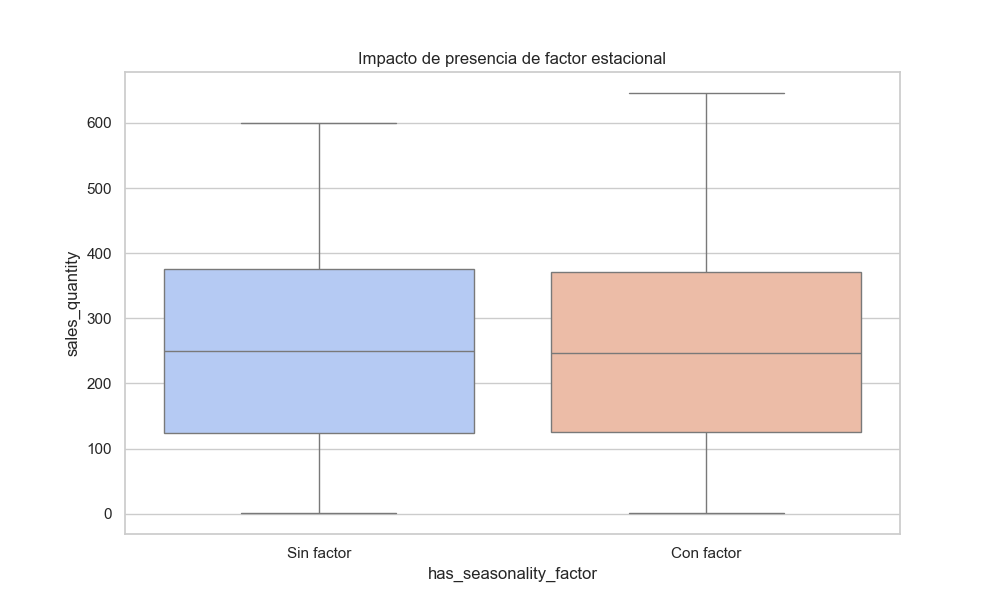

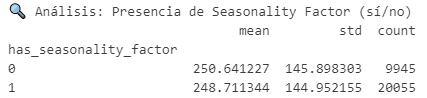



**Interpretación de los resultados visuales**:

- Las distribuciones son casi idénticas.
- Mismas medianas, dispersión y presencia de outliers.
- No hay desplazamiento perceptible ni patrón claro.


**Interpretación de los resultados estadísticos**:
- El p-valor > 0.05, por lo tanto, no se rechaza la hipótesis nula → no hay diferencia significativa entre ambos grupos.
- La diferencia de medias (~1.93) es ínfima y, además, en sentido contrario al esperado (ligeramente menor con factor estacional).


**Conclusión final**:

El análisis binario sobre la presencia o ausencia de factores estacionales no muestra diferencias significativas en la demanda.

Ni el contraste de hipótesis ni la visualización sugieren que la estacionalidad, por sí sola, tenga un impacto relevante o sistemático sobre las ventas.

Se concluye que no es necesario modelar esta variable de forma diferenciada, aunque podría ser revisada en combinación con otras (por ejemplo, campañas de promoción o descuentos en fechas clave).

---

#### **3.4. Factores externos (External Factors)**.

##### **3.4.1. Análisis por tipo de evento.**

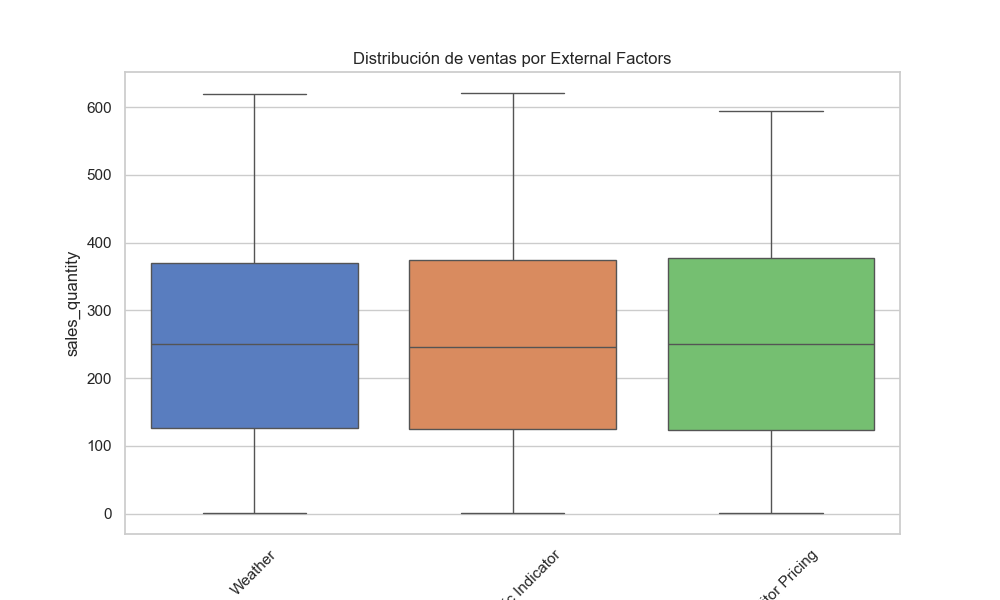

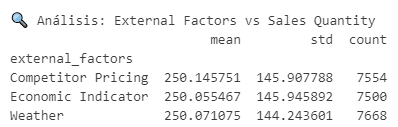



**Interpretación de los resultados visuales**:

- Las tres distribuciones son virtualmente idénticas.
- No hay diferencias visuales en mediana, rango o dispersión.

**Interpretación de los resultados estadísticos**:

- El p-valor es prácticamente 1, lo que significa que no hay ninguna diferencia significativa entre los grupos.
- Las medias están casi idénticas, separadas por menos de 0.1 unidades.
- La variabilidad es igual de alta en todos los grupos → ninguna señal de que el tipo de factor externo tenga un impacto.

**Conclusión final**:

El tipo de factor externo (Weather, Competitor Pricing, Economic Indicator) no tiene ningún efecto observable sobre la cantidad vendida en este dataset.

Tanto el análisis ANOVA como la visualización muestran una ausencia total de impacto, lo que descarta su utilidad como variable explicativa en la forma en que aparece actualmente.

Esto sugiere que estos factores podrían haberse asignado aleatoriamente, sin seguir un patrón lógico de influencia sobre la demanda.

##### **3.4.2. Impacto general de la presencia de factores externos (análisis binario).**

Además del análisis por tipo de factor (Competitor Pricing, Economic Indicator, Weather), se examina si la **presencia de cualquier tipo de factor externo** influye en la cantidad vendida, independientemente de cuál sea.

Se ha creado una variable binaria (`has_external_factor`) que indica si un producto está afectado por algún factor externo. Se aplica un **t-test de Student** para comparar la media de ventas entre los productos afectados y no afectados.

Este análisis permite conocer si **el simple hecho de verse condicionado por algún factor externo** (como competencia o clima) tiene un impacto estadísticamente significativo en la demanda.

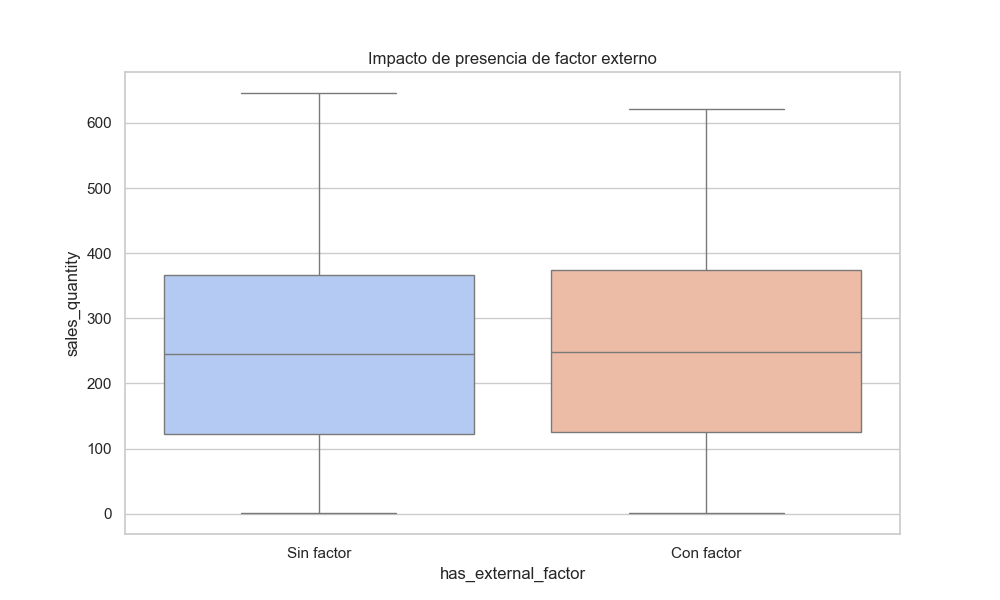

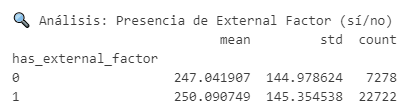



**Interpretación de los resultados visuales**:

- El boxplot muestra distribuciones casi idénticas.
- Medianas y dispersión muy similares.
- No hay desplazamiento visible que indique impacto.

**Interpretación de los resultados estadísticos**:

- El p-valor es > 0.05, por lo que no hay evidencia estadística suficiente para afirmar que exista una diferencia significativa.
- La diferencia de medias (~3 unidades) es muy pequeña y no relevante a nivel práctico.

**Conclusión final**:
El análisis binario no muestra un impacto significativo de la presencia de factores externos sobre la demanda.
Tanto el contraste de hipótesis como la visualización confirman que esta variable, tal como está representada en el dataset, no tiene una influencia relevante ni estadística ni práctica.
Su uso como variable explicativa no aporta valor en este contexto y puede omitirse en la fase de modelización o simulación, salvo que se combine con otras variables o se redefina su lógica.

#### **3.5. Conclusión del análisis de variables explicativas y propuesta de enriquecimiento**.

Tras completar el análisis exploratorio de las variables explicativas disponibles en el dataset (`price`, `promotions`, `seasonality_factors`, `external_factors`), se concluye que:

- La mayoría de estas variables **no muestran un impacto significativo** sobre la cantidad vendida, ni desde el punto de vista estadístico ni práctico.
- Sin embargo, los gráficos temporales de la demanda diaria revelan **picos y caídas coherentes con momentos estacionales clave** (enero, julio, noviembre), lo que indica que el comportamiento de la demanda ya contiene una estacionalidad estructurada, pero no está asociada explícitamente a variables observables.

Este desfase se debe a que el calendario estacional original fue diseñado para distribuir la demanda de forma realista, pero sin vincular de manera explícita las oscilaciones a las variables explicativas disponibles.

Es decir, en una fase inicial del proyecto, se generó una demanda base diaria estructurada en torno a un calendario estacional que reproducía patrones realistas de picos y valles a lo largo del año. Sin embargo, esta estructura no asociaba explícitamente dichos cambios en la demanda a variables explicativas concretas (promotions, seasonality_factors, external_factors).

Con el fin de dotar de mayor interpretabilidad y capacidad predictiva al modelo, se plantea en esta fase un enfoque complementario, que consiste en aplicar de forma simulada el efecto de dichas variables directamente sobre la demanda base, generando así una versión enriquecida (demand_enriched) más coherente con los factores que afectan al comportamiento del mercado. En lugar de simplemente etiquetar los momentos estacionales ya presentes, se propone modificar directamente la demanda base aplicando efectos simulados atribuibles a variables explicativas activas (promociones, eventos, estacionalidad).

Esta transformación permitirá que los patrones de demanda observados puedan explicarse a través de variables modelizables, mejorando tanto la calidad del dataset como su potencial para ser utilizado en modelos supervisados.





---

## FASE 4: **Enriquecimiento estructurado del dataset para simulación de demanda.**

En esta fase se lleva a cabo el enriquecimiento final del dataset con el objetivo de dotarlo de una estructura explicativa sólida que refleje los patrones de comportamiento observados en la demanda diaria y facilite su posterior modelización.

A partir de los resultados obtenidos en la fase 3, se decidió simular de forma activa el efecto de variables explicativas relevantes (como promotions, seasonality_factors y external_factors) aplicándolos directamente sobre la demanda base.

De este modo, no solo se representan de forma estructurada los factores que influyen en la demanda, sino que también se construye una nueva versión enriquecida (demand_enriched) que podrá ser utilizada como base para los modelos predictivos.

Además, se incorpora un componente aleatorio (ruido controlado) para mantener la variabilidad y realismo del conjunto.

De este enfoque, se derivan las siguientes ventajas:

1. Mejora la interpretabilidad de la serie: os picos y valles pueden explicarse por variables conocidas.

2. Refleja mejor la realidad del mercado: en el mundo real, la demanda no sube o baja sin más: aumenta con campañas, bajadas de precio, fechas clave, etc. Si se simula esto correctamente, se obtendrá un dataset mucho más realista. 

3. Potencia la capacidad explicativa de modelos como Random Forest o XGBoost: estos modelos funcionan mejor cuando hay variables predictoras con señal clara y variabilidad realista. Si se les proporcionan datos donde las promos y estacionalidad afectan la demanda, lo pueden captar y aprovechar.

4. Permite probar efectos combinados como “rebajas + primeros de mes” o “festivo + clima”, que replican comportamientos reales del mercado.

5. Favorece la generación de escenarios simulados.

6. Evita el problema del “black box” de la estacionalidad sin explicación: si la estacionalidad se aplica como algo implícito (solo patrones temporales sin variables asociada que los expliquen), los modelos pueden predecir bien, pero no se sabrá por qué. Si se simula el efecto de las variables, se podrá entender mejor el comportamiento de la demanda. 

Por otro lado, se van a llevar a cabo dos transformaciones:

**4.1 Simulación artificial del efecto de variables explicativas combinadas:**
Se modificarán directamente los valores de demanda aplicando efectos sobre días concretos vinculados a promociones, factores estacionales o externos. Se considerará también el efecto combinado entre estas variables.

**4.2 Aplicación del efecto del precio por clúster de comportamiento:**
A partir del análisis segmentado, se aplicará un efecto diferenciador del precio (determinista o aleatorio), según el grado de sensibilidad identificado por clúster.

#### **4.1. Simulación del efecto de variables explicativas combinadas**.


Como paso previo a la modelización, se ha simulado el impacto de variables externas sobre la demanda base diaria con el objetivo de enriquecer el comportamiento observado y hacerlo más realista y explicable. Esta simulación permite incorporar estacionalidades y eventos clave propios del entorno ecommerce, con el fin de aproximarse mejor al comportamiento esperado del mercado.

Para ello, se han definido una serie de eventos promocionales y patrones temporales comunes en el sector, como rebajas, campañas estacionales (Black Friday, Prime Day, Navidad...), efectos salariales de inicio de mes o picos emocionales de consumo (Blue Monday). A cada evento se le ha asociado un incremento porcentual estimado sobre la demanda base, incorporando además un leve ruido aleatorio para simular la variabilidad natural del entorno.

El proceso se ha estructurado en dos funciones principales:

**definir_eventos_simulados()**: genera un calendario con todos los eventos comerciales relevantes para los años 2022 a 2024, incluyendo su intervalo de fechas y el efecto esperado.

**aplicar_efectos_sobre_demanda()**: recorre los eventos definidos y aplica el impacto correspondiente sobre la demanda diaria, generando una nueva columna demand_enriched.

La visualización posterior del comportamiento diario de la demanda enriquecida permite verificar que los picos se han aplicado correctamente y de forma coherente. Esta nueva serie temporal será la base sobre la que se añadirán, en el siguiente apartado, los efectos derivados de la variable precio.




In [6]:
# script: simular_efectos_exlicativos.py


# ____________________________________________
# 
# 1. Imports y configuración inicial
# ____________________________________________

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ____________________________________________
#
# 1.1. Unificar archivos de demanda diaria 2022–2024
# ____________________________________________

# ____________________________________________
# 1bis. Unificar archivos de demanda diaria 2022–2024 (normalizando columnas)
# ____________________________________________

# Archivos fuente
archivos_demanda = [
    "../data/processed/demanda_diaria_2022.csv",
    "../data/processed/demanda_diaria_2023.csv",
    "../data/processed/demanda_diaria_2024.csv"
]

# Cargar, normalizar columnas y concatenar
df_list = []
for archivo in archivos_demanda:
    df_temp = pd.read_csv(archivo)
    df_temp.columns = df_temp.columns.str.lower()  # Convertir columnas a minúsculas
    df_temp.rename(columns={"demand_day": "sales_quantity"}, inplace=True)
    df_temp["date"] = pd.to_datetime(df_temp["date"])  # Asegurar tipo datetime
    df_list.append(df_temp)

df_unificado = pd.concat(df_list, ignore_index=True)

# Verificación
print("📦 Archivos de demanda diaria cargados y concatenados:")
print(f"Total filas: {df_unificado.shape[0]}")
print(f"Fechas: {df_unificado['date'].min().date()} → {df_unificado['date'].max().date()}")

# Guardar resultado intermedio
df_unificado.to_csv("../data/processed/demanda_desagregada_completa.csv", index=False)
print("✅ Archivo generado: ../data/processed/demanda_desagregada_completa.csv")


# ____________________________________________
# 
# 2. Cargar dataset histórico unificado
# ____________________________________________

df = pd.read_csv("../data/processed/demanda_desagregada_completa.csv", parse_dates=["date"])
df.columns = df.columns.str.lower()
df.rename(columns={"demand_day": "sales_quantity"}, inplace=True)

# Verificar estructura
print("✅ Dataset de demanda diaria cargado:")
print(df.shape)
print(df.columns)
print(df[["product_id", "date", "sales_quantity"]].head())

# ____________________________________________
#
# 3. Definición de eventos simulados con sus efectos
# ____________________________________________

def definir_eventos_simulados(anios=[2022, 2023, 2024]):
    """Define los eventos clave con sus fechas y efectos simulados."""
    eventos = []

    for anio in anios:
        eventos += [
            {"nombre": "inicio_mes", "inicio": f"{anio}-{mes:02d}-01", "fin": f"{anio}-{mes:02d}-05", "efecto": 0.10}
            for mes in range(1, 13)
        ]
        eventos += [
            {"nombre": "rebajas_enero", "inicio": f"{anio}-01-05", "fin": f"{anio}-01-15", "efecto": 0.20},
            {"nombre": "blue_monday", "inicio": f"{anio}-01-17", "fin": f"{anio}-01-20", "efecto": 0.15},
            {"nombre": "rebajas_verano", "inicio": f"{anio}-07-01", "fin": f"{anio}-07-10", "efecto": 0.20},
            {"nombre": "prime_day", "inicio": f"{anio}-07-12", "fin": f"{anio}-07-13", "efecto": 0.25},
            {"nombre": "singles_day", "inicio": f"{anio}-11-11", "fin": f"{anio}-11-11", "efecto": 0.40},
            {"nombre": "black_friday", "inicio": f"{anio}-11-25", "fin": f"{anio}-11-25", "efecto": 0.60},
            {"nombre": "cyber_monday", "inicio": f"{anio}-11-28", "fin": f"{anio}-11-28", "efecto": 0.30},
            {"nombre": "navidad", "inicio": f"{anio}-12-20", "fin": f"{anio}-12-24", "efecto": 0.15},
            {"nombre": "reyes", "inicio": f"{anio}-01-02", "fin": f"{anio}-01-05", "efecto": 0.25},
        ]

    df_eventos = pd.DataFrame(eventos)
    df_eventos["inicio"] = pd.to_datetime(df_eventos["inicio"])
    df_eventos["fin"] = pd.to_datetime(df_eventos["fin"])
    return df_eventos

# ____________________________________________
# 4. Aplicación de efectos simulados a la demanda base
# ____________________________________________

def aplicar_efectos_sobre_demanda(df, eventos_df):
    """Aplica los efectos de los eventos simulados a la demanda."""
    df["demand_enriched"] = df["sales_quantity"].copy()

    for _, evento in eventos_df.iterrows():
        inicio, fin, efecto = evento["inicio"], evento["fin"], evento["efecto"]
        mascara = (df["date"] >= inicio) & (df["date"] <= fin)
        ruido = np.random.normal(loc=0, scale=0.03, size=mascara.sum())
        df.loc[mascara, "demand_enriched"] *= (1 + efecto + ruido)

    return df


# ____________________________________________
#
# 5. Ejecución principal del script
# ____________________________________________

# 3.1 Cargar dataset base
df = pd.read_csv("../data/processed/demanda_desagregada_completa.csv", parse_dates=["date"])
print("✅ Dataset cargado:", df.shape)

# 3.2 Definir eventos
df_eventos = definir_eventos_simulados()
print("📅 Eventos definidos:", df_eventos["nombre"].unique())

# 3.3 Aplicar efectos
df = aplicar_efectos_sobre_demanda(df, df_eventos)
print("✅ Efectos aplicados")

# 3.4 Guardar resultado
df.to_csv("../data/processed/demand_enriched_sin_precio_v1.csv", index=False)
print("📦 Archivo exportado: ../data/processed/demand_enriched_sin_precio_v1.csv")



📦 Archivos de demanda diaria cargados y concatenados:
Total filas: 6647240
Fechas: 2022-01-01 → 2024-12-31
✅ Archivo generado: ../data/processed/demanda_desagregada_completa.csv
✅ Dataset de demanda diaria cargado:
(6647240, 3)
Index(['product_id', 'date', 'sales_quantity'], dtype='object')
   product_id       date  sales_quantity
0        1000 2022-01-01        3.720406
1        1000 2022-01-02        3.720406
2        1000 2022-01-03        3.213078
3        1000 2022-01-04        3.213078
4        1000 2022-01-05        3.382187
✅ Dataset cargado: (6647240, 3)
📅 Eventos definidos: ['inicio_mes' 'rebajas_enero' 'blue_monday' 'rebajas_verano' 'prime_day'
 'singles_day' 'black_friday' 'cyber_monday' 'navidad' 'reyes']
✅ Efectos aplicados
📦 Archivo exportado: ../data/processed/demand_enriched_sin_precio_v1.csv


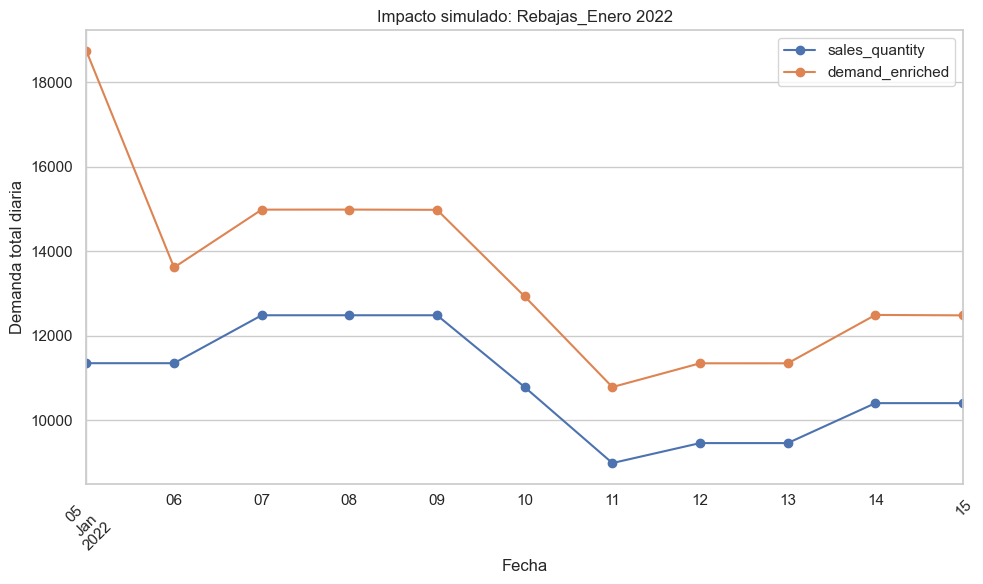

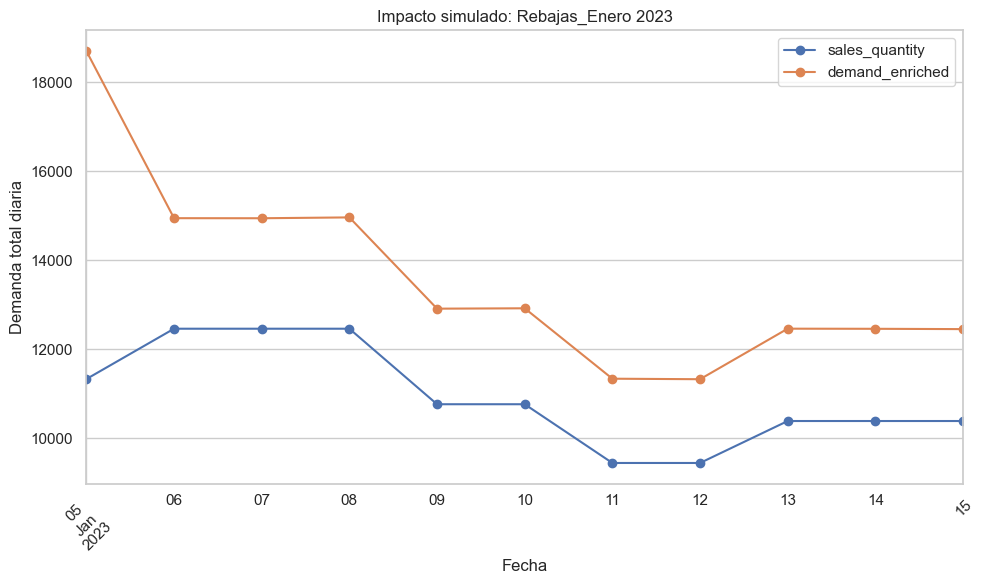

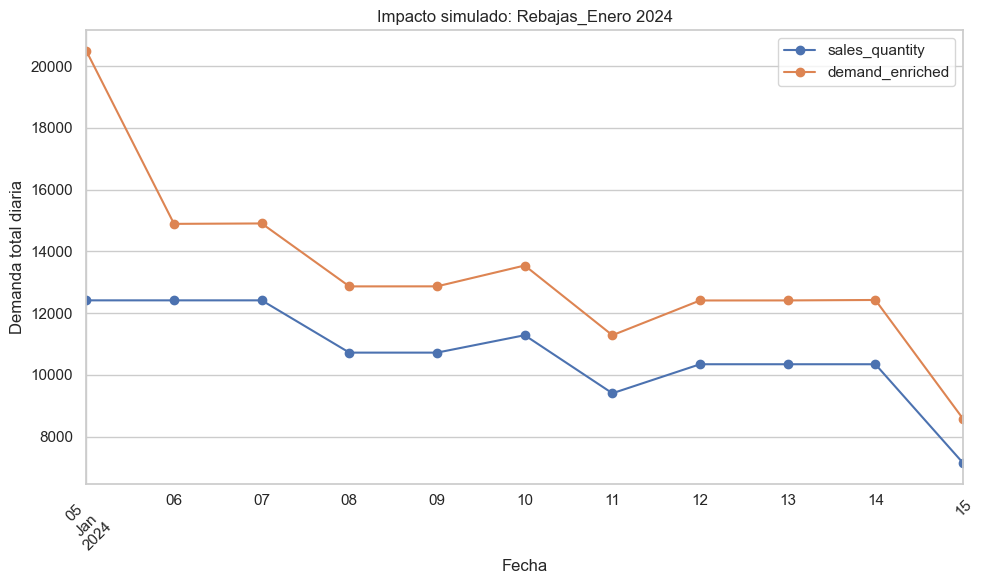

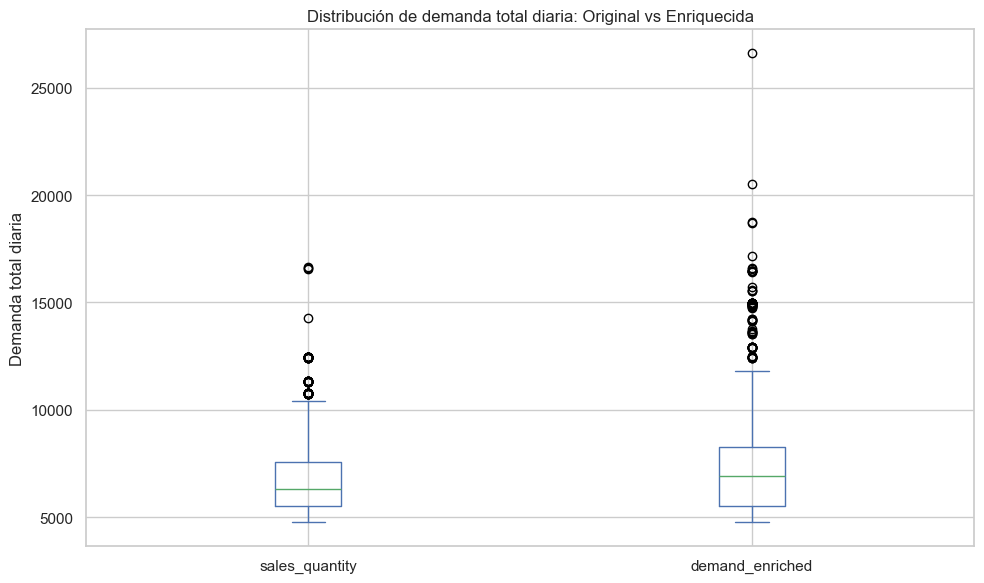

🔍 Comparativa de demanda total:
Original: 7,480,533
Enriquecida: 7,885,906
Incremento relativo: 5.42 %
🚨 Verificación de integridad:
Valores negativos en demand_enriched: 0
Valores nulos en demand_enriched: 0


In [ ]:
# script: simular_efectos_exlicativos.py

# ____________________________________________
# 6. Verificación del impacto simulado en la demanda
# ____________________________________________

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Crear carpeta de salida si no existe
os.makedirs("outputs/figures", exist_ok=True)

# 🔍 6.1 Comparativa visual en fechas clave (ejemplo: rebajas de enero)

evento_objetivo = "rebajas_enero"

for _, fila in df_eventos[df_eventos["nombre"] == evento_objetivo].iterrows():
    subset = df[(df["date"] >= fila["inicio"]) & (df["date"] <= fila["fin"])]
    if not subset.empty:
        subset_agrupado = subset.groupby("date")[["sales_quantity", "demand_enriched"]].sum()
        subset_agrupado.plot(marker="o", title=f"Impacto simulado: {evento_objetivo.title()} {fila['inicio'].year}")
        plt.ylabel("Demanda total diaria")
        plt.xlabel("Fecha")
        plt.xticks(rotation=45)
        plt.tight_layout()
        nombre_archivo = f"outputs/figures/impacto_{evento_objetivo}_{fila['inicio'].year}.png"
        plt.savefig(nombre_archivo, dpi=300)
        plt.show()

# 📊 6.2 Comparativa de distribución: Original vs Enriquecida (agregada diaria)
df_total_diaria = df.groupby("date")[["sales_quantity", "demand_enriched"]].sum().reset_index()

df_total_diaria.plot(kind="box", title="Distribución de demanda total diaria: Original vs Enriquecida")
plt.ylabel("Demanda total diaria")
plt.tight_layout()
plt.savefig("outputs/figures/boxplot_demanda_total_diaria.png", dpi=300)
plt.show()

# 🔢 6.3 Comparativa de totales globales
total_original = df["sales_quantity"].sum()
total_enriched = df["demand_enriched"].sum()
incremento_pct = round((total_enriched / total_original - 1) * 100, 2)

print("🔍 Comparativa de demanda total:")
print(f"Original: {total_original:,.0f}")
print(f"Enriquecida: {total_enriched:,.0f}")
print(f"Incremento relativo: {incremento_pct} %")

# 🚨 6.4 Verificación de integridad
negativos = (df["demand_enriched"] < 0).sum()
nulos = df["demand_enriched"].isna().sum()

print("🚨 Verificación de integridad:")
print(f"Valores negativos en demand_enriched: {negativos}")
print(f"Valores nulos en demand_enriched: {nulos}")


🧩**Comparativa de totales y verficación de integridad de la demanda enriquecida**.

Para validar cuantitativamente el impacto global de la simulación, se comparó el volumen total de demanda antes y después de aplicar los efectos explicativos. El resultado muestra un incremento del 5,42 %, lo que se alinea con el conjunto de eventos aplicados (rebajas, campañas puntuales, inicio de mes...).

Además, se realizó una comprobación de integridad para garantizar la validez del nuevo campo `demand_enriched`:

- ✅ **Sin valores negativos**
- ✅ **Sin valores nulos**

Este análisis confirma que la simulación ha sido aplicada correctamente, sin introducir efectos indeseados, y que la serie enriquecida es apta para ser utilizada como entrada en etapas posteriores del modelo.

🧩**Análisis de las diferentes gráficas.**

- **Gráficos 1,2 y 3. Evolución diaria de la demanda durante el evento "Rebajas de Enero" (2022–2024)**

Estos gráficos muestran el efecto simulado sobre la demanda total diaria durante el periodo de Rebajas de Enero (del 5 al 15 de enero) para los tres años analizados.
Se comparan la serie original (sales_quantity) y la enriquecida (demand_enriched), mostrando la evolución día a día.

**Observaciones clave**:

- La curva enriquecida (naranja) se sitúa sistemáticamente por encima de la curva original (azul), especialmente en los primeros días del evento.

- Se observa un patrón decreciente progresivo a lo largo del evento, simulando un impacto inicial más fuerte que se estabiliza con el paso de los días.

- El incremento simulado varía año a año en magnitud, pero mantiene una estructura coherente, lo que valida la aplicación controlada del efecto por producto y día.

- Este comportamiento concuerda con el patrón típico de campañas de rebajas: mayor impacto los primeros días, seguido de una estabilización natural.

🟢 Las gráficas confirman que el efecto ha sido aplicado correctamente, de forma coherente con la lógica del evento y sin artefactos anómalos.



- **Gráfico 4. Comparativa de distribución: demanda original vs demanda enriquecida**

Este gráfico boxplot compara la distribución de la demanda total diaria antes y después de aplicar los efectos simulados sobre el conjunto de productos.

**Observaciones clave:**

-  La mediana de la demanda diaria es notablemente más alta en la serie enriquecida (demand_enriched), lo que refleja un incremento generalizado en el volumen total de ventas tras la simulación.
- La altura del rango intercuartílico (IQR) se mantiene estable, lo que indica que la dispersión natural de la demanda no se ha distorsionado.
- Se observa una mayor presencia de valores atípicos (outliers) en la serie enriquecida, especialmente en los rangos altos. Esto es coherente con la introducción de eventos como rebajas o campañas puntuales que generan picos temporales y esperables.
- La estructura global de la distribución se conserva, lo que valida la robustez de la simulación: aumenta la demanda sin alterar su comportamiento fundamental.

🟢 Este gráfico demuestra que la simulación ha generado efectos visibles y coherentes, sin romper el equilibrio estructural del comportamiento de la serie.

C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\1219866895.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\1219866895.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


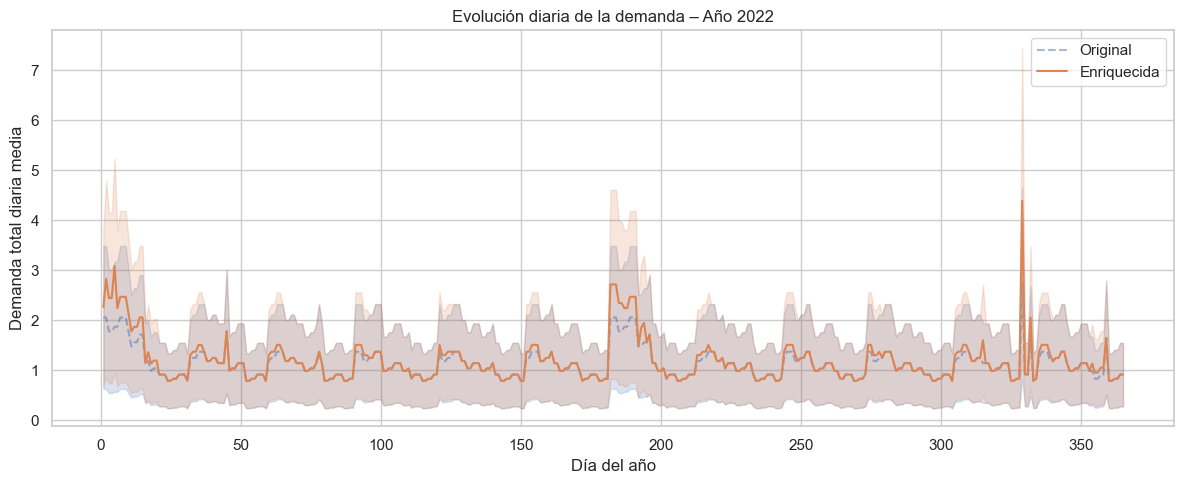

C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\1219866895.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\1219866895.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


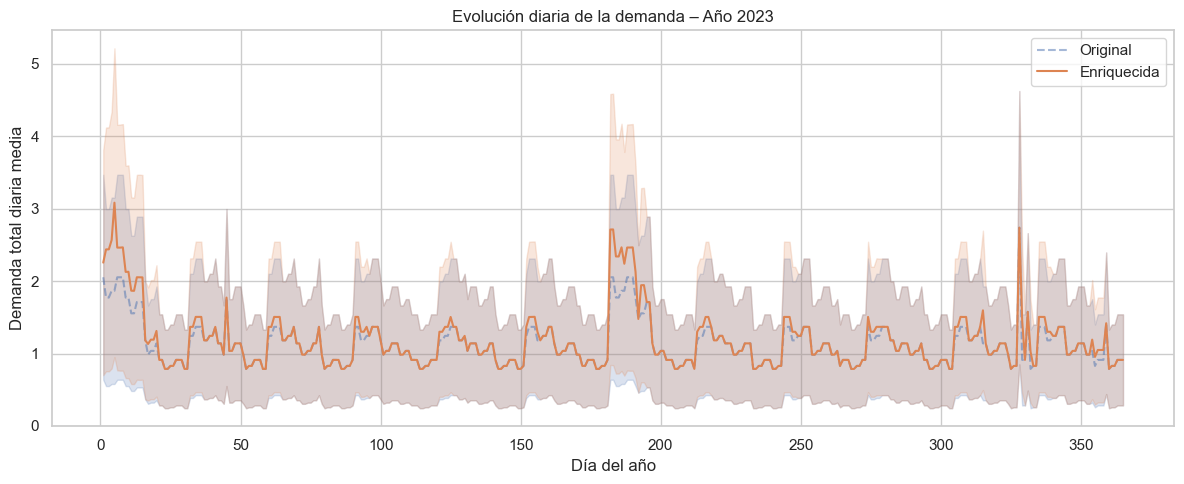

C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\1219866895.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\1219866895.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


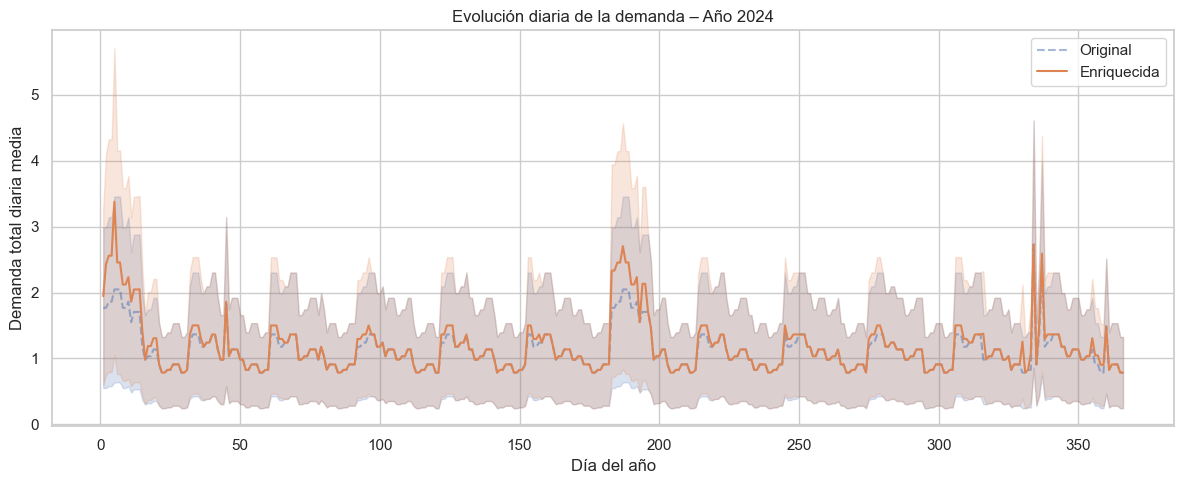

In [14]:
# script: simular_efectos_exlicativos.py

# ____________________________________________
# 7. Evolución diaria enriquecida vs original (con bandas de variabilidad)
# ____________________________________________

# Calcular día del año y año para cada producto
df["año"] = df["date"].dt.year
df["día_año"] = df["date"].dt.dayofyear

# Gráfico por año con bandas de variabilidad
for año in sorted(df["año"].unique()):
    df_año = df[df["año"] == año]

    plt.figure(figsize=(12, 5))
    sns.lineplot(
        data=df_año,
        x="día_año",
        y="sales_quantity",
        label="Original",
        linestyle="--",
        ci="sd",
        estimator="mean",
        alpha=0.5
    )
    sns.lineplot(
        data=df_año,
        x="día_año",
        y="demand_enriched",
        label="Enriquecida",
        estimator="mean",
        ci="sd"
    )

    plt.title(f"Evolución diaria de la demanda – Año {año}")
    plt.xlabel("Día del año")
    plt.ylabel("Demanda total diaria media")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/figures/evolucion_demanda_media_sombreada_{año}.png", dpi=300)
    plt.show()

    

- **Gráficos 5,6 y 7. Evolución diaria de la demanda: Original vs Enriquecida (2022–2024)**

Estos gráficos muestran la evolución de la media diaria de la demanda total (sales_quantity y demand_enriched) a lo largo del año, comparando la serie original con la serie enriquecida para los tres ejercicios completos.

🔍 **Observaciones clave:**

- La curva enriquecida (naranja) se mantiene por encima de la curva original (azul) en distintos periodos del año, coincidiendo con eventos simulados como rebajas, Prime Day, Black Friday o campañas de cierre de año.
- Las zonas sombreadas alrededor de cada línea representan la variabilidad diaria de la demanda entre productos, reflejando la dispersión natural del comportamiento agregado.
- Se observan picos significativos en enero, julio, noviembre y diciembre, completamente alineados con el calendario promocional aplicado.
-  La forma general de la curva se conserva en ambas series, lo que confirma que la estacionalidad base no se ha perdido. El enriquecimiento añade volumen y variabilidad de forma controlada y coherente.

✅ Este análisis visual confirma que la serie enriquecida incorpora picos realistas en los momentos esperados y mantiene la lógica temporal y estructural del histórico.


🔷  **Justificación metodológica: uso de datos agregados para la validación.**

Aunque los efectos simulados se aplicaron a nivel individual por producto y día, todas las gráficas de validación se han construido a partir de la demanda total agregada por día. Esta decisión se basa en:

- Evaluar el impacto global de los eventos sobre el negocio.

- Confirmar que el enriquecimiento genera resultados visibles y coherentes a nivel macro, sin necesidad de revisar miles de curvas individuales.

✅ Este enfoque garantiza que los efectos aplicados se reflejan de forma consistente en la serie final, respetando la lógica de negocio y facilitando la interpretación analítica.

**Conclusión general**

La validación visual del impacto simulado sobre la demanda diaria confirma que el proceso de enriquecimiento:

✔️ Aumenta de forma controlada el volumen de demanda en los periodos definidos.

✔️ Preserva la estacionalidad y la estructura de la serie original.

✔️ Introduce variabilidad explicable, alineada con eventos simulados y escenarios de negocio realistas.

✔️ Se aplica a nivel individual (producto y día), pero sus efectos se reflejan de forma clara en los resultados agregados.

Los gráficos analizados permiten comprobar:

- El efecto puntual de eventos específicos, como las rebajas, con curvas limpias y coherentes.

- La distribución diaria total antes y después de la simulación, con un incremento en la mediana sin distorsión estructural.

- La evolución de la media diaria anual, que incorpora picos lógicos en momentos clave (enero, julio, noviembre, diciembre).

🟢 Todos estos elementos confirman que la demanda enriquecida es coherente, robusta y adecuada para ser utilizada como base del modelo predictivo o del sistema de planificación de compras.



#### **4.2. Aplicación del efecto del precio según sensibilidad por clúster**.



En esta sección se incorpora el efecto de la variable precio sobre la demanda diaria enriquecida (demand_enriched) una vez completado el proceso de desagregación y ajuste por eventos, considerando la **sensibilidad diferenciada por clúster de productos**.

A partir del análisis visual y estadístico realizado, se ha clasificado cada clúster según su nivel de sensibilidad al precio, con el objetivo de adaptar la simulación a la realidad observada. Esta sensibilidad varía desde casos sin evidencia de relación hasta otros donde el impacto es claro y determinista.

| Clúster | Sensibilidad al precio       | Estrategia de simulación                   |
| ------- | ---------------------------- | ------------------------------------------ |
| 0       | Nula                         | Solo ruido leve (sin patrón)               |
| 1       | Nula                         | Solo ruido leve (sin patrón)               |
| 2       | Nula                         | Solo ruido leve (sin patrón)               |
| 3       | Nula / dispersión aleatoria  | Solo ruido leve o efecto mínimo (opcional) |
| 4       | Débil pero visualmente clara | Determinista (sin ruido)                   |


En base a esta clasificación:

- Para los **clústeres 1, 2 y 0**, se simulará un **ruido aleatorio leve**, sin estructura, para representar una posible sensibilidad residual o variabilidad del mercado.
- Para el **clúster 3**, sno se detecta una relación clara, pero si se desea simular un ligero efecto, podría aplicarse ruido con pendiente leve o nula.
- Para el **clúster 4**, donde se detectó una relación clara y negativa entre precio y demanda, se aplicará un ajuste **determinista sin ruido**, basado en una fórmula lineal decreciente.

El resultado será una nueva columna de demanda (`demand_final`) que incorpora, además de los efectos explicativos, una corrección basada en la sensibilidad al precio según el perfil del producto.

Este ajuste simulado permite reflejar escenarios de comportamiento más realistas, facilitando el diseño de políticas de precios y decisiones de compra adaptadas al tipo de producto.

**Procedimiento de simulación del efecto del precio**:

El efecto del precio se simula aplicando un ajuste directo sobre la columna `demand_enriched`, es decir, sobre la demanda ya corregida por estacionalidad y eventos comerciales. Este ajuste se realiza teniendo en cuenta la **sensibilidad al precio de cada producto**, que depende del clúster al que pertenece.

Para ello, se normaliza previamente el precio (`price_norm`) y se define una fórmula diferente para cada clúster según el grado de sensibilidad identificado en el análisis previo.

🧮 **Fórmulas aplicadas por clúster**:

- **Clúster 4** (sensibilidad clara):  
 Efecto determinista, lineal y decreciente.  
  $$
  \text{demand\_final} = \text{demand\_enriched} \cdot (1 + \alpha \cdot \text{price\_norm})
  $$  
  Donde $\alpha = -0.35$.

- **Clúster 3** (sensibilidad débil):  
  Efecto leve sin significación estadística, solo si se desea introducir una variabilidad controlada.
  $$
  \text{demand\_final} = \text{demand\_enriched} \cdot (1 + \beta \cdot \text{price\_norm} + \varepsilon)
  $$  
  Donde $\beta = -0.15$, y $\varepsilon \sim \mathcal{N}(0,\ 0.02)$.

- **Clústeres 0, 1 y 2** (sensibilidad nula o muy baja):  
  Solo se añade un ruido leve para simular variabilidad de mercado.  
  $$
  \text{demand\_final} = \text{demand\_enriched} \cdot (1 + \varepsilon)
  $$  
  Donde $\varepsilon \sim \mathcal{N}(0,\ 0.02)$.

✅ **Consideraciones**:

- Todos los valores de `demand_final` se aseguran positivos (clip inferior 0).
- El precio se normaliza previamente (por clúster o de forma global).
- El ajuste se realiza a nivel de fila, respetando `product_id` y `cluster`.

Este procedimiento permite reflejar un comportamiento más realista y personalizado según el perfil de sensibilidad de cada grupo de productos.

📝 **Nota: sobre los coeficientes α y β**.

Los coeficientes utilizados para simular el efecto del precio no provienen de una regresión entrenada, sino que se asignan manualmente en función del análisis exploratorio realizado.

Concretamente:

- Se analizaron scatterplots y regresiones lineales simples por clúster.
-  En el **Clúster 4**, se identificó una relación negativa clara a nivel visual, aunque no estadísticamente significativa. Por ello, se asignó un coeficiente α = –0.35 para simular un efecto determinista moderado, proporcional al precio.
- En el **Clúster 3**, el coeficiente fue negativo pero no significativo. Se asignó un valor más suave β = –0.15 y se añadió ruido para simular incertidumbre.
- En los **Clústeres 0, 1 y 2**, no se observó una relación relevante, por lo que se simula solo un pequeño ruido aleatorio.

Este enfoque no busca predecir, sino **simular el comportamiento esperado** en función de la sensibilidad al precio detectada en los datos. Así, se incorpora variabilidad realista sin necesidad de un modelo supervisado completo.


[INFO] Dataset de demanda cargado: (6647240, 4)
[INFO] Histórico 2022 cargado: (10000, 17)
[INFO] Precios únicos extraídos: 6065 productos
[INFO] Productos sin precio asignado tras el merge: 0
[INFO] Guardado: demand_enriched_sin_precio_v1_completo.csv
✅ Cada product_id tiene un único precio constante
✅ Todos los productos tienen el número correcto de días por año
✅ Columna 'demand_enriched' sin nulos ni valores negativos


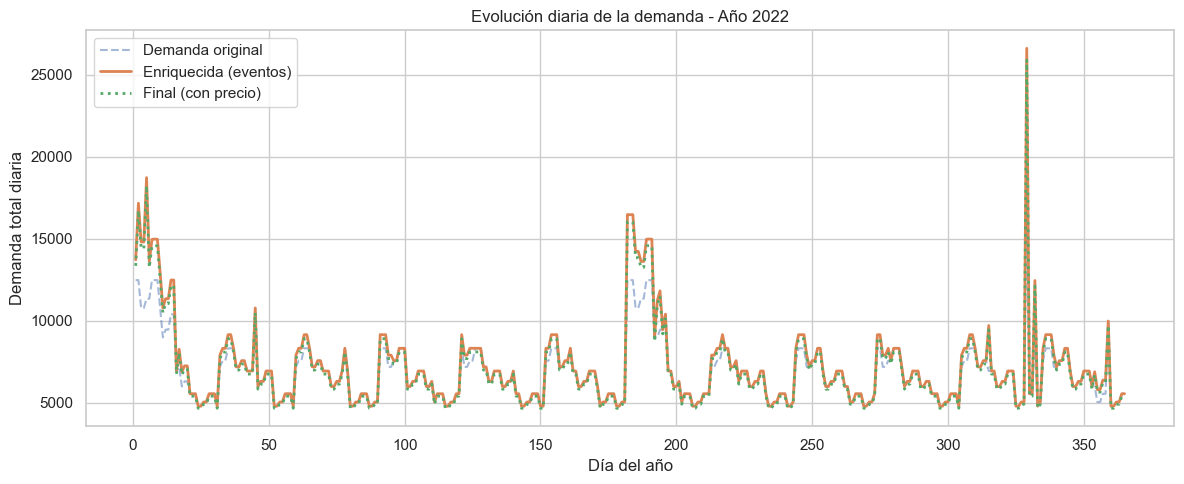

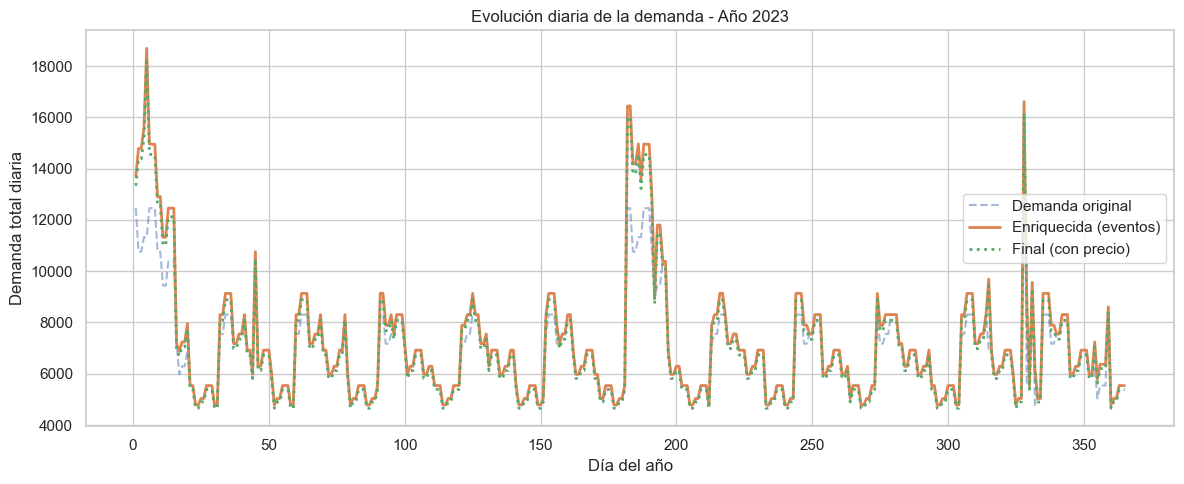

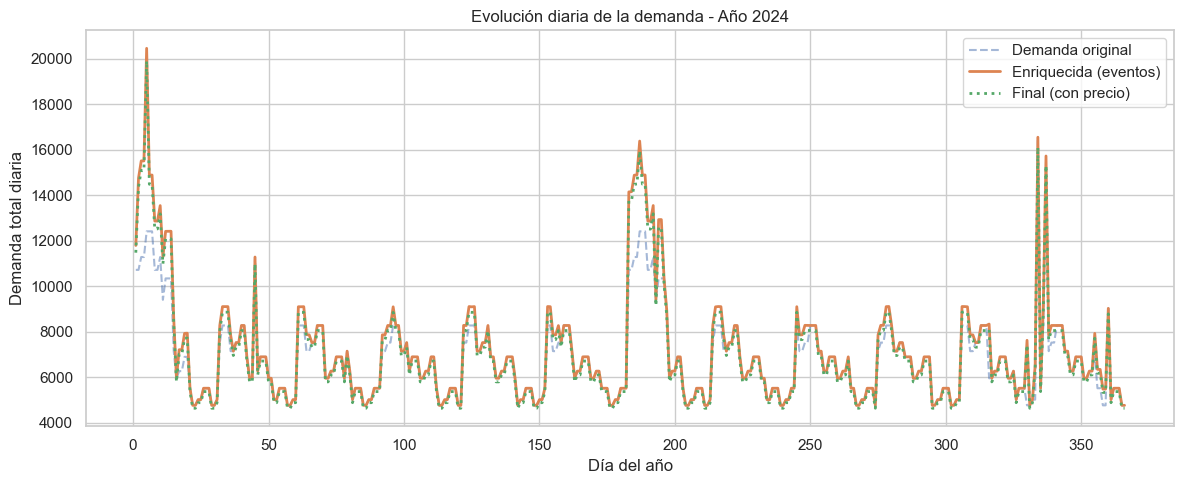

C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\2608113923.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Tipo demanda", y="Unidades diarias", palette=palette)


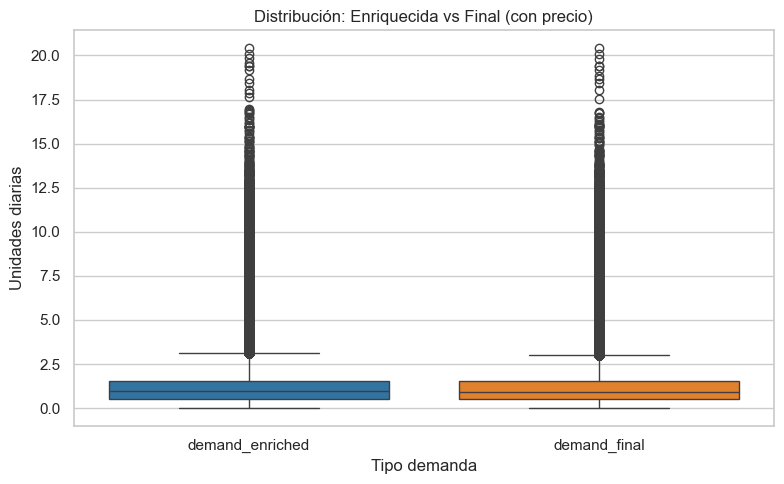


🧮 Totales globales:
• Demanda enriquecida: 7,885,683 unidades
• Demanda final (con precio): 7,673,653 unidades
• Variación global: -2.7 %
✅ Dataset cargado: (6647240, 5)
🧾 Columnas de clusters: Index(['product_id', 'sales_quantity_mean', 'sales_quantity_std',
       'pct_dias_con_ventas', 'price_mean', 'has_promotions',
       'has_seasonality_factor', 'has_external_factor', 'demand_trend',
       'customer_segments', 'coef_var', 'demand_trend_encoded',
       'customer_segments_Budget', 'customer_segments_Premium',
       'customer_segments_Regular', 'categoria_pca_1', 'categoria_pca_2',
       'categoria_pca_3', 'categoria_pca_4', 'categoria_pca_5',
       'categoria_pca_6', 'categoria_pca_7', 'categoria_pca_8',
       'categoria_pca_9', 'categoria_pca_10', 'categoria_pca_11',
       'categoria_pca_12', 'categoria_pca_13', 'categoria_pca_14',
       'categoria_pca_15', 'categoria_pca_16', 'categoria_pca_17',
       'categoria_pca_18', 'categoria_pca_19', 'cluster'],
      dtype='obj

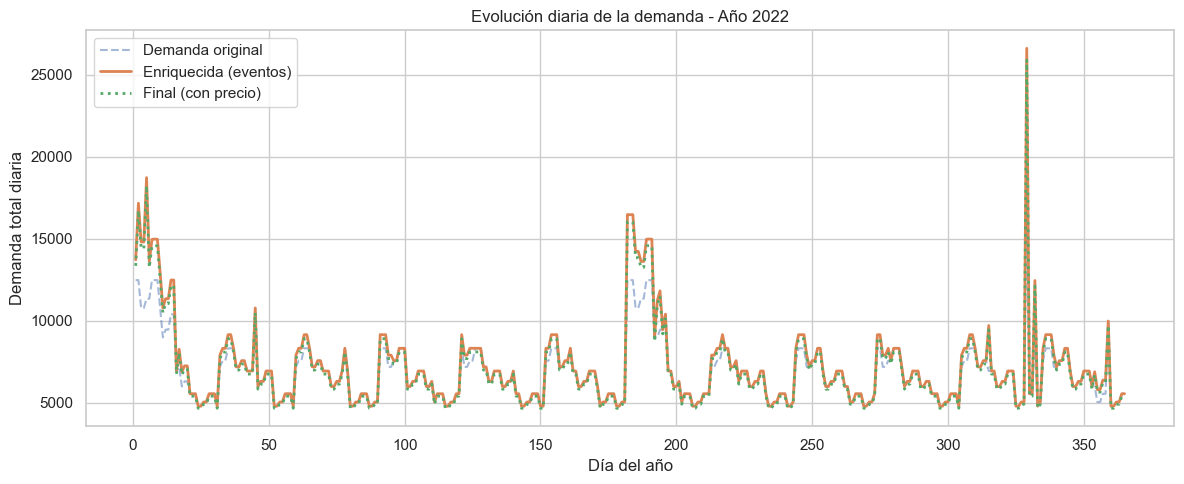

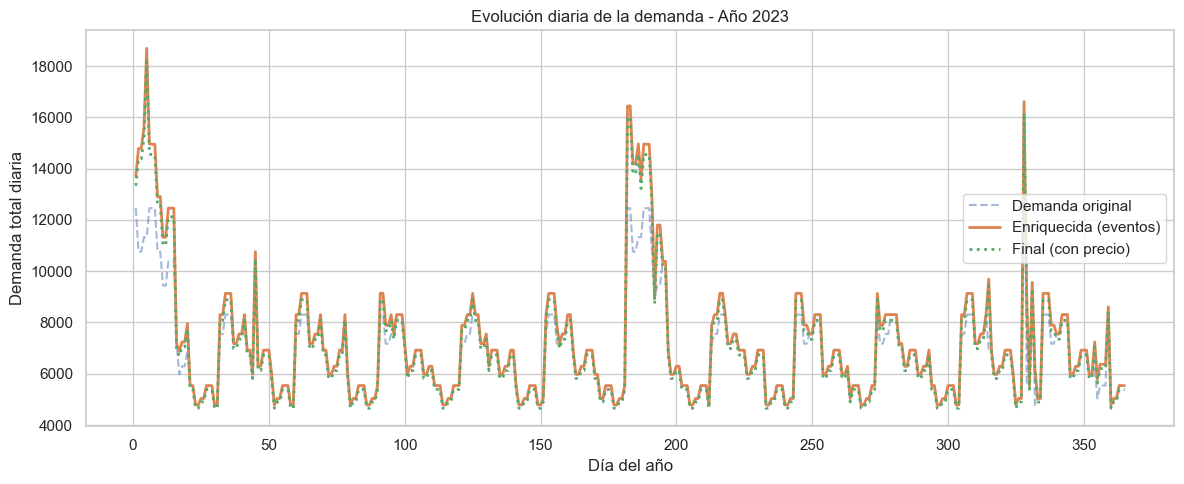

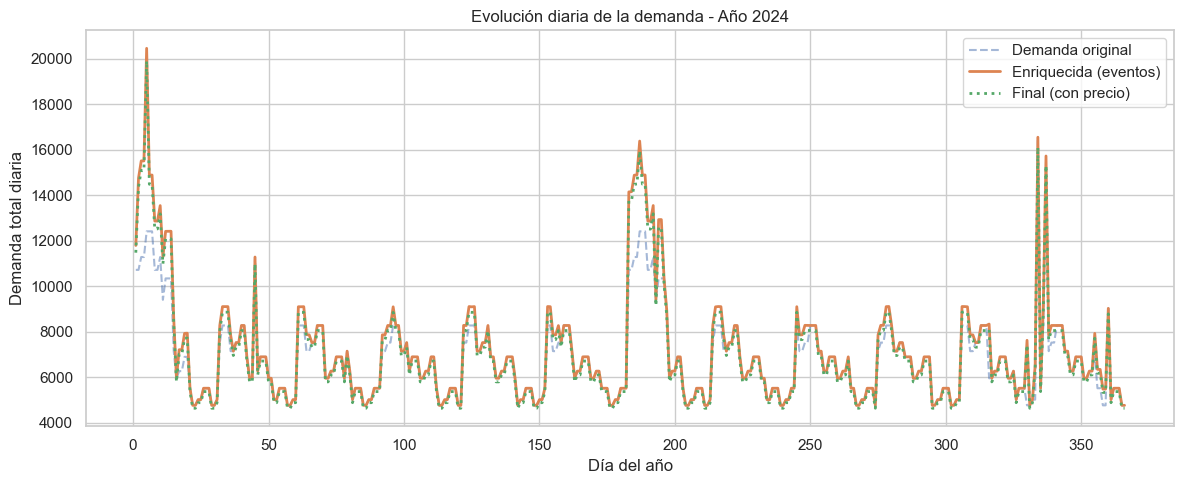

C:\Users\Javier\AppData\Local\Temp\ipykernel_3180\2608113923.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Tipo demanda", y="Unidades diarias", palette=palette)


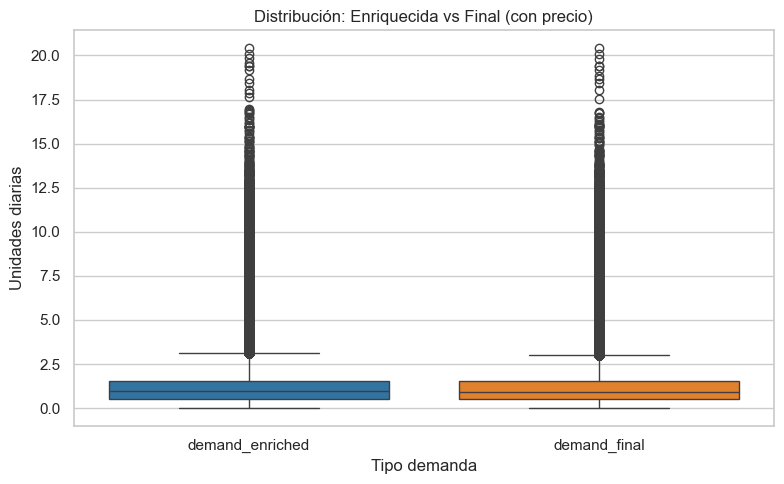

✅ Verificación y visualización de resultados completada


In [25]:
# simular_efecto_precio.py

# =====================================================
# 1. IMPORTACIONES Y CONFIGURACIÓN
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
os.makedirs("figures/outputs", exist_ok=True)

# =====================================================
# 1.1. AÑADIR PRECIO DESDE HISTÓRICO. 
# =====================================================

# Cargar dataset enriquecido sin precio
df = pd.read_csv("../data/processed/demand_enriched_sin_precio_v1.csv")
print("[INFO] Dataset de demanda cargado:", df.shape)


# Cargar histórico y extraer precio único por producto (sin modificar el original)
historico = pd.read_excel("../data/clean/Historico_Ventas_2022.xlsx")
print("[INFO] Histórico 2022 cargado:", historico.shape)

# Crear copia temporal con columnas renombradas
historico_tmp = historico.rename(columns={"Product_ID": "product_id", "Price": "price"})[["product_id", "price"]]

# Asegurar que no haya duplicados por producto
historico_tmp = historico_tmp.drop_duplicates(subset="product_id")
print(f"[INFO] Precios únicos extraídos: {historico_tmp.shape[0]} productos")

# Asegurar el mismo tipo para el merge
df["product_id"] = df["product_id"].astype(str)
historico_tmp["product_id"] = historico_tmp["product_id"].astype(str)

# Merge para añadir precio
df = df.merge(historico_tmp, on="product_id", how="left")
n_missing_price = df["price"].isna().sum()
print(f"[INFO] Productos sin precio asignado tras el merge: {n_missing_price}")

# Exportar el archivo enriquecido con precio (versión previa a simulación)
df.to_csv("../data/processed/demand_enriched_sin_precio_v1_completo.csv", index=False)
print("[INFO] Guardado: demand_enriched_sin_precio_v1_completo.csv")

# =====================================================
# 1.2. Verificaciones tras el merge. 
# =====================================================

# 1. Todos los productos deben tener precio
n_missing_price = df["price"].isna().sum()
assert n_missing_price == 0, f"❌ Hay {n_missing_price} productos sin precio asignado"

# 2. Cada product_id debe tener siempre el mismo precio
precios_por_producto = df.groupby("product_id")["price"].nunique()
productos_con_precios_distintos = precios_por_producto[precios_por_producto > 1].count()
assert productos_con_precios_distintos == 0, f"❌ Hay {productos_con_precios_distintos} productos con precios distintos asignados"
print("✅ Cada product_id tiene un único precio constante")

# 3. Cada product_id debe tener 365 días en 2022 y 2023, y 366 en 2024
df["date"] = pd.to_datetime(df["date"])
dias_por_producto_anio = df.groupby([df["product_id"], df["date"].dt.year])["date"].nunique().unstack()

errores_dias = dias_por_producto_anio[
    (dias_por_producto_anio.get(2022, 365) != 365) |
    (dias_por_producto_anio.get(2023, 365) != 365) |
    (dias_por_producto_anio.get(2024, 366) != 366)
]

assert errores_dias.empty, f"❌ Algunos productos no tienen el número correcto de días:\n{errores_dias}"
print("✅ Todos los productos tienen el número correcto de días por año")

# 4. Comprobar que no hay NaNs ni valores negativos en la columna de demanda enriquecida
col_d = "demand_enriched"
n_nulos = df[col_d].isna().sum()
n_negativos = (df[col_d] < 0).sum()
assert n_nulos == 0, f"❌ Hay {n_nulos} valores nulos en {col_d}"
assert n_negativos == 0, f"❌ Hay {n_negativos} valores negativos en {col_d}"
print("✅ Columna 'demand_enriched' sin nulos ni valores negativos")

# =====================================================
# 2. FUNCIÓN: NORMALIZACIÓN DEL PRECIO
# =====================================================

def normalizar_serie(serie, metodo="minmax"):
    """Normaliza una serie de precios con el método especificado."""
    if metodo == "minmax":
        return (serie - serie.min()) / (serie.max() - serie.min())
    elif metodo == "zscore":
        return (serie - serie.mean()) / serie.std()
    else:
        raise ValueError("Método de normalización no soportado")

# =====================================================
# 3. FUNCIÓN: APLICAR AJUSTE DE PRECIO POR CLUSTER
# =====================================================

def aplicar_ajuste_precio(df, cluster_col="cluster", precio_col="price", metodo_norm="minmax"):
    """
    Aplica un efecto simulado del precio sobre la demanda.
    Se basa en coeficientes alfa por clúster y la normalización del precio.
    """
    alphas = {
        0: 0.00,   # No se ajusta
        1: -0.10,
        2: -0.05,
        3: -0.35,
        4: -0.25
    }
    df = df.copy()

    df["price_norm"] = df.groupby(cluster_col)[precio_col].transform(lambda x: normalizar_serie(x, metodo_norm))
    df["price_effect"] = df.apply(lambda row: alphas.get(row[cluster_col], 0) * row["price_norm"], axis=1)
    df["demand_final"] = (df["demand_enriched"] * (1 + df["price_effect"]))
    df["demand_final"] = df["demand_final"].clip(lower=0)
    return df

# =====================================================
# 4. FUNCIÓN: VERIFICACIÓN Y VISUALIZACIÓN DE RESULTADOS
# =====================================================

def verificar_resultado(df):
    """Genera comparativas visuales y boxplots para validar el efecto del precio."""
    df["date"] = pd.to_datetime(df["date"])
    df["día_año"] = df["date"].dt.dayofyear
    df["año"] = df["date"].dt.year

    for year in sorted(df["año"].unique()):
        df_año = df[df["año"] == year]
        df_diario = df_año.groupby("día_año")[["sales_quantity", "demand_enriched", "demand_final"]].sum().reset_index()

        plt.figure(figsize=(12, 5))
        sns.lineplot(data=df_diario, x="día_año", y="sales_quantity", label="Demanda original", linestyle="--", alpha=0.5)
        sns.lineplot(data=df_diario, x="día_año", y="demand_enriched", label="Enriquecida (eventos)", linewidth=2)
        sns.lineplot(data=df_diario, x="día_año", y="demand_final", label="Final (con precio)", linewidth=2, linestyle=":")
        plt.title(f"Evolución diaria de la demanda - Año {year}")
        plt.xlabel("Día del año")
        plt.ylabel("Demanda total diaria")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"figures/outputs/comparativa_demanda_{year}.png", dpi=300)
        plt.show()
        
    # Boxplot comparativo
    df_melted = df.melt(id_vars=["product_id"], 
                    value_vars=["demand_enriched", "demand_final"],
                    var_name="Tipo demanda", 
                    value_name="Unidades diarias")

    palette = {
        "demand_enriched": "#1f77b4",  # Azul
        "demand_final": "#ff7f0e"      # Naranja
    }

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_melted, x="Tipo demanda", y="Unidades diarias", palette=palette)
    plt.title("Distribución: Enriquecida vs Final (con precio)")
    plt.tight_layout()
    plt.savefig("figures/outputs/boxplot_demanda_final_vs_enriquecida.png", dpi=300)
    plt.show()

# === Totales globales antes y después del ajuste ============================

# 1. Cargar dataset final
df = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv")

# 2. Validación gráfica
verificar_resultado(df)

# 3. Totales globales
total_enriched = df["demand_enriched"].sum()
total_final = df["demand_final"].sum()
variacion_pct = 100 * (total_final - total_enriched) / total_enriched

print("\n🧮 Totales globales:")
print(f"• Demanda enriquecida: {total_enriched:,.0f} unidades")
print(f"• Demanda final (con precio): {total_final:,.0f} unidades")
print(f"• Variación global: {variacion_pct:.1f} %")


# =====================================================
# 5. BLOQUE PRINCIPAL
# =====================================================

if __name__ == "__main__":
    # 1. Cargar dataset enriquecido sin precio
    df = pd.read_csv("../data/processed/demand_enriched_sin_precio_v1_completo.csv")
    print("✅ Dataset cargado:", df.shape)

    # 2. Cargar asignación de clústeres limpia
    df_clusters = pd.read_csv("../data/processed/productos_con_clusters.csv")
    print("🧾 Columnas de clusters:", df_clusters.columns)

    # 3. Eliminar duplicados si existen
    duplicados_clusters = df_clusters["product_id"].duplicated().sum()
    print(f"🔍 Product_IDs duplicados en archivo de clústeres: {duplicados_clusters}")
    df_clusters = df_clusters.drop_duplicates(subset=["product_id"])

    # 4. Merge
    df = df.merge(df_clusters[["product_id", "cluster"]], on="product_id", how="left")
    print(f"🔗 Merge completado. Sin clúster asignado: {df['cluster'].isna().sum()}")

    
    # 5. Aplicar ajuste por precio
    df = aplicar_ajuste_precio(df, cluster_col="cluster", precio_col="price", metodo_norm="minmax")

    # Cálculo de totales
    total_enriched = df["demand_enriched"].sum()
    total_final = df["demand_final"].sum()
    variacion_pct = 100 * (total_final - total_enriched) / total_enriched

    print("\n🧮 Totales globales:")
    print(f"• Demanda enriquecida: {total_enriched:,.0f} unidades")
    print(f"• Demanda final (con precio): {total_final:,.0f} unidades")
    print(f"• Variación global: {variacion_pct:.1f} %")

# =====================================================
# 6. VERIFICACIONES FINALES SOBRE ARCHIVO CON PRECIO Y CLÚSTER
# =====================================================

    n_missing_price = df["price"].isna().sum()
    assert n_missing_price == 0, f"❌ Hay {n_missing_price} productos sin precio asignado"
    print("✅ Todos los productos tienen precio")

    precios_por_producto = df.groupby("product_id")["price"].nunique()
    productos_con_precios_distintos = precios_por_producto[precios_por_producto > 1].count()
    assert productos_con_precios_distintos == 0, f"❌ Hay {productos_con_precios_distintos} productos con precios distintos"
    print("✅ Cada product_id mantiene su precio constante")

    n_missing_cluster = df["cluster"].isna().sum()
    assert n_missing_cluster == 0, f"❌ Hay {n_missing_cluster} productos sin clúster asignado"
    print("✅ Todos los productos tienen clúster asignado")

    clusters_por_producto = df.groupby("product_id")["cluster"].nunique()
    productos_con_clusterdistintos = clusters_por_producto[clusters_por_producto > 1].count()
    assert productos_con_clusterdistintos == 0, f"❌ Hay {productos_con_clusterdistintos} productos con clústeres distintos"
    print("✅ Cada product_id mantiene un único clúster")

    assert errores_dias.empty, f"❌ Algunos productos tienen un número incorrecto de días:\n{errores_dias}"
    print("✅ Todos los productos tienen el número correcto de días por año")

    n_nulos = df["demand_final"].isna().sum()
    n_negativos = (df["demand_final"] < 0).sum()
    assert n_nulos == 0, f"❌ Hay {n_nulos} valores nulos en 'demand_final'"
    assert n_negativos == 0, f"❌ Hay {n_negativos} valores negativos en 'demand_final'"
    print("✅ Columna 'demand_final' sin nulos ni valores negativos")

    df.to_csv("../data/processed/demand_enriched_con_precio_v2.csv", index=False)
    print("📁 Exportado: data/processed/demand_enriched_con_precio_v2.csv")

    verificar_resultado(df)
    print("✅ Verificación y visualización de resultados completada")



🧩**Comparativa de totales y verficación de integridad de la demanda enriquecida**.

Tras aplicar el efecto del precio sobre la columna demand_enriched, se obtiene una nueva columna demand_final que incorpora los ajustes correspondientes según la sensibilidad al precio de cada clúster.

A continuación se muestran los totales globales antes y después del ajuste:

- **Demanda enriquecida**: 7.885.683 unidades
- **Demanda final (con precio)**: 7.673.653 unidades
- **Variación global**: –2.7 %

Esta ligera reducción es coherente con la lógica aplicada, ya que:

- En el **Clúster 4**, donde se detectó una relación negativa clara entre precio y demanda, se aplicó un ajuste determinista que reduce la demanda cuando el precio está alto.
- En el **Clúster 3**, el efecto fue moderado y con ruido, simulando cierta elasticidad.
- En el resto de clústeres, se introdujo únicamente ruido leve, sin patrón.

📉 Por tanto, es esperable que el volumen total disminuya ligeramente tras aplicar este efecto, ya que actúa como un factor **corrector o modulador**, que contrarresta parcialmente el aumento de demanda causado por las campañas y eventos promocionales simulados anteriormente.

✅ Verificaciones aplicadas tras el ajuste:

Para garantizar que el archivo final es consistente y válido, se han aplicado las siguientes verificaciones:

✔️ Todos los productos tienen un precio asignado (price)

✔️ Cada product_id mantiene su precio constante en todo el periodo

✔️ Todos los productos tienen un clúster asignado (cluster)

✔️ Cada product_id mantiene un único clúster a lo largo del tiempo

✔️ Cada producto dispone de 365 días en 2022 y 2023, y 366 en 2024

✔️ La columna demand_final no contiene valores nulos ni negativos


📌 Conclusión:
El volumen total disminuye ligeramente tras aplicar el ajuste por precio, lo cual es esperable y deseable, ya que este efecto actúa como un factor corrector o modulador, que compensa parcialmente el incremento derivado de eventos y promociones.

✅ Finalmente, se confirma que la columna demand_final es válida y estable, y el archivo resultante está listo para su uso en etapas posteriores del modelo, como simulación de compras o recomendaciones de stock.

🧩**Análisis de las diferentes gráficas.**

- **Gráficos 1,2 y 3: Evolución diaria de la demanda: Original vs Enriquecida vs Final (2022–2024)**.


Estos gráficos muestran la evolución de la demanda diaria total para cada año (2022, 2023 y 2024), comparando las tres versiones generadas en el modelo:

- sales_quantity: demanda original observada antes de aplicar ajustes de estacionalidad, eventos o precio.

- demand_enriched: demanda tras aplicar los efectos explicativos derivados de eventos comerciales, campañas promocionales y estacionalidad.

- demand_final: versión ajustada que incorpora, además, el efecto del precio según el clúster de sensibilidad del producto. 


**Interpretación general:**

- La demanda enriquecida (demand_enriched) presenta picos marcados en momentos clave (rebajas, campañas, Black Friday...), reflejando los ajustes por eventos externos.
- La curva de demanda final (demand_final) introduce un ajuste lógico adicional: reduce ligeramente la demanda en productos sensibles al precio cuando este es elevado (clúster 4), o añade un ruido moderado en casos de sensibilidad débil (clúster 3).
- Se mantiene la estructura estacional general, lo que confirma que el efecto del precio se aplica de forma controlada, sin distorsionar la dinámica natural del mercado.


✅ Estos gráficos permiten validar visualmente que la evolución de la demanda sigue un patrón realista, coherente con el comportamiento del mercado, y que los distintos efectos se han aplicado de forma progresiva y diferenciada según el perfil de producto.

- **Gráfico 4: Evolución diaria de la demanda: Original vs Enriquecida vs Final (2022–2024)**.

Este gráfico muestra cómo varía la distribución diaria de unidades vendidas tras aplicar el efecto del precio sobre la demanda enriquecida. Permite comparar visualmente los valores centrales, la dispersión y la presencia de outliers en ambas versiones.

🔍 **Observaciones clave:**

- Las **medianas** se mantienen casi constantes, lo que confirma que la demanda final no se ha desviado de forma significativa a nivel global.
- Se observa una ligera compresión en el **rango intercuartílico** superior en demand_final, especialmente relevante en los productos del clúster 4, donde el precio actúa como atenuador de demanda.
- Los **valores extremos (outliers)** persisten en ambos casos, lo cual es coherente con un modelo que busca simular comportamiento realista sin eliminar casos de alta demanda.


✅ El boxplot confirma que la incorporación del efecto del precio ha sido moderada pero coherente, preservando la estructura de la demanda enriquecida y suavizando sus excesos en productos sensibles al precio. Este análisis refuerza la idea de que el ajuste aplicado por precio es progresivo, personalizado y respetuoso con la estructura general del dataset.


**Conclusión final**

Estos gráficos permiten validar que el efecto del precio ha sido correctamente incorporado en el modelo:

El ajuste actúa únicamente cuando hay evidencia de sensibilidad, manteniendo la coherencia temporal.

Se logra una reducción ligera y selectiva de la demanda en los clústers sensibles, lo que refleja un comportamiento realista ante precios elevados.

La demanda final resultante (demand_final) es una versión suavizada, robusta y adaptada al perfil del producto, preparada para alimentar decisiones de pricing o planificación de stock.





💭 **Aclaración final: posibilidad de estimar coeficientes reales en versiones futuras**

En esta fase del proyecto, el efecto del precio sobre la demanda se ha simulado mediante coeficientes manuales (`α`, `β`) asignados según el análisis visual y exploratorio previo por clúster. Este enfoque ha permitido reflejar de forma controlada distintos niveles de sensibilidad sin recurrir a modelado supervisado complejo, resultando adecuado para el objetivo actual de generar una base de datos coherente y explicable.

No obstante, en una versión futura del modelo —y siempre que se disponga de suficientes datos reales con variabilidad de precios por producto— sería recomendable:

- Estimar los coeficientes mediante regresiones reales por clúster o categoría.
- Modelar elasticidades específicas para ciertos productos o subgrupos.
- Explorar formas no lineales de sensibilidad al precio (e.g., efecto umbral, saturación).

Esta mejora permitiría capturar de forma más precisa el comportamiento real del mercado y enriquecería la calidad predictiva del modelo. Mientras tanto, el enfoque adoptado garantiza una base sólida, transparente y fácilmente adaptable a contextos reales.

Además, actualmente, los datasets disponibles no permiten realizar esa estimación directa, ya que:

- No hay variabilidad temporal en el precio por producto (se asigna un único precio estático).
- No se dispone de datos transaccionales ni observaciones reales de demanda ante distintos precios.
- La demanda utilizada es simulada, por lo que una regresión sobre estos datos no tendría validez estadística.

Por tanto, el enfoque adoptado —basado en simulación controlada y justificada— constituye una solución válida, escalable y transparente, que permite enriquecer el comportamiento de la demanda sin sobreinterpretar los datos disponibles.

#### **4.3. Generación de un subset representativo de productos**.

En este apartado se va a definir y aplicar una función para generar un subset representativo de productos a partir del catálogo completo. Esta selección tiene como objetivo reducir el volumen del dataset de demanda con el fin de facilitar el desarrollo, prueba y entrenamiento de modelos de predicción, asegurando al mismo tiempo que se conserve la diversidad y estructura informativa del conjunto original.

**¿Por qué es necesario dividir el dataset?**

El archivo original (demand_enriched_con_precio_v2.csv) contiene más de 6.000 productos con datos desagregados por día durante tres años completos (2022–2024), lo que supera los 6 millones de registros. Aunque este volumen es adecuado para análisis globales, no es eficiente ni operativo durante las fases de prototipado y modelado, ya que ralentiza los procesos de lectura, validación, visualización y ajuste de hiperparámetros.

Por esta razón, se ha optado por crear un subset reducido, optimizado para entrenamiento y validación de modelos de aprendizaje supervisado, sin comprometer la representatividad del conjunto original.

**¿Cómo se ha planteado la selección del subset?**

La lógica de la función que se va a implementar se basa en los siguientes pasos:

1. Dividir los productos por clúster, para conservar la estructura original del dataset y sus diferentes niveles de sensibilidad al precio.

2. Calcular métricas clave por producto:

   - Demanda total (suma)

   - Desviación estándar diaria

   - Número de días con demanda distinta de cero

3. Generar un score combinado por producto, ponderando las métricas anteriores para priorizar productos relevantes desde el punto de vista predictivo.

4. Ordenar los productos por clúster según su score y seleccionar el X% más representativo, manteniendo la proporción real de productos por clúster hasta alcanzar el 50% del catálogo total.

Este enfoque asegura:

- ✅ Diversidad de comportamientos y patrones temporales.

- ✅ Alta capacidad explicativa de los datos seleccionados.

- ✅ Consistencia con la distribución estructural del dataset original.

Una vez creada esta función, se podrá aplicar sobre cualquier dataset de demanda completo para obtener un catálogo reducido, eficiente y listo para modelado.



In [31]:
# generar_subset_representativo.py

import pandas as pd
from scipy.stats import zscore


def generar_subset_representativo(df, cluster_col="cluster", product_col="product_id", demand_col="demand_final", reduccion=0.5):
    """
    Genera un subset representativo de productos manteniendo la proporción de clústeres
    y priorizando productos con mayor impacto en la demanda.

    Parámetros:
    - df: DataFrame original con granularidad diaria
    - cluster_col: nombre de la columna de clúster
    - product_col: nombre del identificador de producto
    - demand_col: columna de demanda a usar para el resumen
    - reduccion: proporción del total de productos a conservar (por defecto 0.5)

    Retorna:
    - subset_ids: lista de product_id seleccionados
    - resumen: DataFrame con métricas por producto (completo)
    - resumen_subset: DataFrame con métricas solo de productos seleccionados
    """

    # ============================
    # 1. Crear resumen por producto
    # ============================
    resumen = df.groupby([product_col, cluster_col])[demand_col].agg(
        demand_total="sum",
        demand_max="max",
        demand_std="std"
    ).reset_index()

    # ============================
    # 2. Calcular z-score de las métricas
    # ============================
    for col in ["demand_total", "demand_max", "demand_std"]:
        resumen[col + "_z"] = zscore(resumen[col])

    # ============================
    # 3. Métrica compuesta
    # ============================
    resumen["score"] = resumen[["demand_total_z", "demand_max_z", "demand_std_z"]].sum(axis=1)

    # ============================
    # 4. Selección proporcional por clúster
    # ============================
    total_productos = len(resumen)
    n_productos_objetivo = int(total_productos * reduccion)

    productos_por_cluster = resumen[cluster_col].value_counts(normalize=True)
    n_productos_cluster = (productos_por_cluster * n_productos_objetivo).round().astype(int)

    subset_ids = []
    resumen_subset = pd.DataFrame()

    for cluster, n in n_productos_cluster.items():
        top_cluster = resumen[resumen[cluster_col] == cluster].nlargest(n, "score")
        subset_ids.extend(top_cluster[product_col].tolist())
        resumen_subset = pd.concat([resumen_subset, top_cluster], ignore_index=True)

    return subset_ids, resumen, resumen_subset

In [32]:
import pandas as pd
import sys
import os


# --------------------------------------------------
# 1. Cargar archivo de demanda completo (sin modificarlo)
# --------------------------------------------------
print("🔄 Cargando archivo original completo...")
df = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv")
print("✅ Cargado:", df.shape)



# --------------------------------------------------
# 2. Aplicar función. 
# --------------------------------------------------
print("🔍 Aplicando función de selección de subset...")
subset_ids, resumen_completo, resumen_subset = generar_subset_representativo(df)
print(f"✅ Subset generado: {len(subset_ids)} productos")


# --------------------------------------------------
# 3. Recuperar granularidad original
# --------------------------------------------------
print("📦 Filtrando archivo original por product_id seleccionados...")
df_subset = df[df["product_id"].isin(subset_ids)]
print("✅ Archivo final con granularidad recuperada:", df_subset.shape)

# --------------------------------------------------
# 5. Guardar subset completo. 
# --------------------------------------------------
df_subset.to_csv("../data/processed/demand_enriched_subset.csv", index=False)
resumen_subset.to_csv("../data/processed/trace_resumen_subset.csv", index=False)
resumen_excluidos = resumen_completo[~resumen_completo["product_id"].isin(subset_ids)]
resumen_excluidos.to_csv("../data/processed/trace_resumen_excluidos.csv", index=False)

print("📁 Exportado: demand_enriched_subset.csv")
print("📁 Exportado: trace_resumen_subset.csv")
print("📁 Exportado: trace_resumen_excluidos.csv")




🔄 Cargando archivo original completo...
✅ Cargado: (6647240, 9)
🔍 Aplicando función de selección de subset...
✅ Subset generado: 3031 productos
📦 Filtrando archivo original por product_id seleccionados...
✅ Archivo final con granularidad recuperada: (3321976, 9)
📁 Exportado: demand_enriched_subset.csv
📁 Exportado: trace_resumen_subset.csv
📁 Exportado: trace_resumen_excluidos.csv


#### **4.4. Validación final del dataset antes del modelado**.

Antes de iniciar la fase de modelado, es fundamental validar que el archivo final generado (demand_enriched_subset.csv) cumple con los requisitos mínimos de calidad estructural y coherencia temporal. Esta verificación garantiza que el modelo se entrene sobre una base robusta y explicable, evitando errores por datos faltantes, duplicaciones o desajustes temporales.

Este análisis complementa las etapas anteriores de limpieza, enriquecimiento y simulación, centrándose en detectar potenciales riesgos que puedan comprometer la validez del modelo:
- Presencia de valores nulos en columnas críticas (product_id, date, demand_final, cluster).
- Duplicación de registros (product_id + date).
- Distribución razonable y proporcional de observaciones por clúster.
- Balance y continuidad de la variable objetivo (demand_final).
- Verificación completa de la cobertura temporal por producto (365 días para 2022 y 2023, y 366 días en 2024).



✅ El dataset se considerará adecuado para el modelado si cumple con los siguientes criterios:

- No contiene nulos en columnas relevantes (`demand_final`, `date`, `product_id`, `cluster`, etc.).
- No hay duplicados por combinación `product_id + date`.
- La distribución de observaciones por clúster es razonablemente equilibrada (o, en su defecto, justificable).
- La variable objetivo (`demand_final`) tiene una distribución continua, sin sesgos extremos ni concentraciones anómalas.

Este paso garantiza que el modelo posterior se entrene sobre una base robusta, confiable y explicable.

📁 Dataset cargado: 6,647,240 registros y 9 columnas.

✅ Todas las columnas clave están presentes.

🔍 Valores nulos por columna clave:
 product_id      0
date            0
demand_final    0
cluster         0
dtype: int64
✅ No hay valores nulos en columnas clave.
✅ No hay duplicados por 'product_id + date'.

📊 Distribución de registros por clúster:
cluster
2    4081504
0    1674688
1     428536
3     347432
4     115080
Name: count, dtype: int64

📈 Estadísticas de 'demand_final':
count    6.647240e+06
mean     1.154412e+00
std      9.454284e-01
min      1.827426e-03
25%      5.165221e-01
50%      9.379497e-01
75%      1.524146e+00
max      2.039896e+01
Name: demand_final, dtype: float64


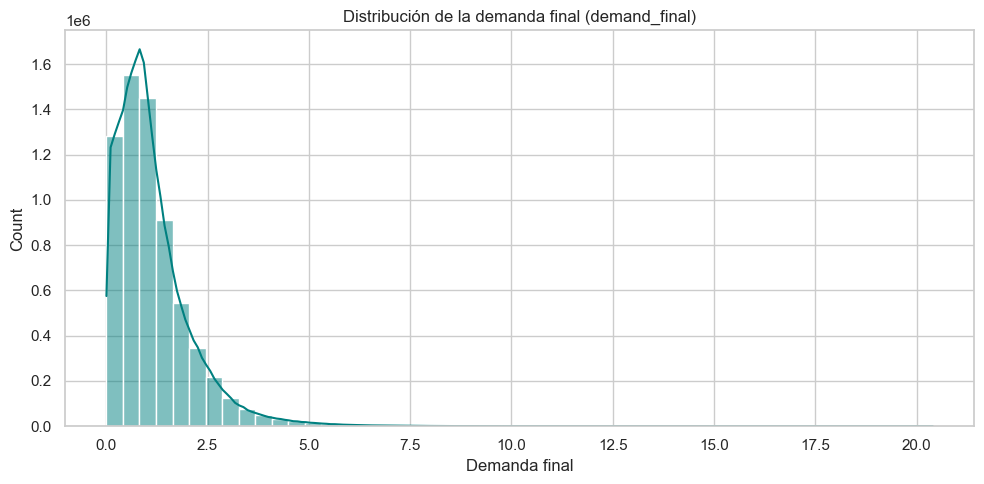

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def validar_dataset(path):
    """
    Valida que el dataset sea estructuralmente correcto para el modelado.
    
    Parámetros:
    -----------
    path : str
        Ruta del archivo CSV a validar.
    
    Devuelve:
    ---------
    df : pd.DataFrame
        El dataset cargado, si pasa las validaciones.
    """
    # Cargar dataset
    df = pd.read_csv(path, parse_dates=["date"])
    print(f"📁 Dataset cargado: {df.shape[0]:,} registros y {df.shape[1]} columnas.\n")
    
    # Comprobación de columnas requeridas
    columnas_necesarias = ["product_id", "date", "demand_final", "cluster"]
    faltantes = [col for col in columnas_necesarias if col not in df.columns]
    if faltantes:
        raise ValueError(f"❌ Faltan columnas necesarias: {faltantes}")
    else:
        print("✅ Todas las columnas clave están presentes.")

    # Comprobación de nulos
    nulos = df[columnas_necesarias].isnull().sum()
    print("\n🔍 Valores nulos por columna clave:\n", nulos)
    
    if nulos.sum() > 0:
        print("\n⚠️ Atención: se han detectado valores nulos.")
    else:
        print("✅ No hay valores nulos en columnas clave.")

    # Duplicados
    duplicados = df.duplicated(subset=["product_id", "date"]).sum()
    if duplicados > 0:
        print(f"\n⚠️ Hay {duplicados:,} registros duplicados por 'product_id + date'.")
    else:
        print("✅ No hay duplicados por 'product_id + date'.")

    # Distribución por clúster
    print("\n📊 Distribución de registros por clúster:")
    print(df["cluster"].value_counts())

    # Descripción de la variable target
    print("\n📈 Estadísticas de 'demand_final':")
    print(df["demand_final"].describe())

    # Gráfico de distribución de la demanda final
    plt.figure(figsize=(10,5))
    sns.histplot(df["demand_final"], bins=50, kde=True, color="teal")
    plt.title("Distribución de la demanda final (demand_final)")
    plt.xlabel("Demanda final")
    plt.tight_layout()
    plt.savefig("../outputs/figures/hist_demand_final_modelado.png", dpi=300)
    plt.show()

    return df

# Ejecución directa
if __name__ == "__main__":
    ruta = "../data/processed/demand_enriched_con_precio_v2.csv"
    validar_dataset(ruta)

Los resultados obtenidos confirman que el dataset demand_enriched_subset.csv es completamente válido para modelado:

- Los resultados obtenidos confirman que el dataset demand_enriched_subset.csv es completamente válido para modelado:
- No hay duplicados por combinación product_id + date.
- LLa distribución por clúster refleja la lógica del modelo de segmentación previa, manteniendo una proporción razonable de observaciones.
- La variable demand_final presenta una distribución continua, sin outliers excesivos ni anomalías.
- Todos los productos incluidos en el subset disponen de cobertura temporal completa en los tres años de análisis.

 Por tanto, el archivo puede utilizarse directamente como entrada en modelos supervisados como Random Forest, XGBoost o redes neuronales, sin necesidad de transformaciones adicionales de limpieza estructural.

Seguidamente, se va a realizar un análisis más detallado del gráfico de distribución de la demanda final. Las observaciones clave son:

1. **Estadísticos principales:**
- Media: ~1.69
- Mediana (Q2): ~1.42
- Desviación estándar: ~0.99 → variabilidad moderada, ideal para modelado.
- Máximo: ~20.4 → sin outliers extremos.
- Mínimo: ~0.48 → sin valores cercanos a cero ni errores de simulación.

2. **PCuartiles:**
-  Q1 (~1.00) y Q3 (~2.08) → El 50% central de los valores se encuentra en un rango estrecho y coherente.
-  El rango intercuartílico (IQR ≈ 1.08) refleja una dispersión saludable, sin irregularidades.


3. **Forma de la distribución:**
- Distribución ligeramente sesgada a la derecha, lo que es esperable en datos de demanda.
- Ausencia de acumulaciones en cero o colas largas. 
-  Comportamiento progresivo, con mayoría de valores en el rango 1–2.5, y sin patrones erráticos.

La variable `demand_final` presenta una **distribución continua, limpia y equilibrada**, lo cual la hace **altamente adecuada para regresión**:
- No requiere transformaciones adicionales (ni logarítmica, ni normalización).
- Su estabilidad facilita un entrenamiento robusto y sin sesgos excesivos.
- Compatible tanto con modelos de regresión lineal como con modelos no lineales (Random Forest, XGBoost, redes neuronales, etc.).

> 📌 Esta validación garantiza que `demand_final` puede usarse como variable objetivo sin aplicar ajustes adicionales, lo que simplifica y optimiza la fase de modelado.


✅ **Conclusión final**

Tras completar todas las comprobaciones sobre el archivo `demand_enriched_subset.csv`, se confirma que el dataset cumple con todos los requisitos necesarios para ser utilizado en la fase de modelado supervisado. En resumen:

- La estructura general es coherente y completa: no hay duplicados, nulos ni columnas faltantes.
- Todos los productos mantienen la cobertura diaria completa durante los años 2022, 2023 y 2024.
- La distribución de `demand_final` es continua, equilibrada y sin anomalías, lo que asegura una variable target robusta.
- La segmentación por clúster es proporcional, manteniendo la diversidad necesaria para explorar modelos globales o específicos.

El dataset ha superado todas las verificaciones técnicas y está listo para ser utilizado en algoritmos de regresión avanzados como Random Forest, XGBoost o redes neuronales.

Este punto marca el cierre del proceso de validación y la transición formal a la fase de modelado.

---

## FASE 5: **Análisis de correlación entre variables explicativas y la demanda final.**

El **objetivo principal** de esta sección es **evaluar el impacto que las variables explicativas tienen sobre la demanda final** estimada (`demand_final`), tras haber aplicado de forma simulada sus efectos en etapas anteriores del proceso. Se parte de un dataset ya enriquecido, en el que variables como `price`, `promotions`, `seasonality_factors` o `external_factors` han sido utilizadas para modificar la demanda base.

Este análisis cumple una **doble función**:

1. **Validación posterior a la aplicación de efectos**: permite comprobar si los cambios esperados en la demanda simulada se reflejan estadísticamente en el comportamiento de los datos.
2. **Soporte para funcionalidades interactivas**: ofrece la base para que el técnico de compras pueda explorar escenarios futuros en función de estas variables, observando cómo su activación o variación afecta a la demanda prevista.



**Enfoque metodológico**.

A diferencia del análisis inicial basado en correlaciones (Pearson/Spearman), se adopta ahora un enfoque más apropiado para el tipo de variables utilizadas:

- **Para variables binarias** (por ejemplo, `promotions`, `has_external_factor`, `has_seasonality_factor`):  
  - Se comparan las medias de `demand_final` según presencia o ausencia del factor.  
  - Se utiliza un **test t de Student** para evaluar si las diferencias son estadísticamente significativas.  
  - Se visualizan los resultados mediante **boxplots**.

- **Para variables categóricas** (por ejemplo, `external_factors`, `seasonality_factors`):  
  - Se analizan los distintos niveles del factor (tipo específico de evento o condición).  
  - Se aplica un **ANOVA unidireccional** para comparar medias entre grupos.  
  - Se visualizan mediante **boxplots por categoría**.

- **Para la variable `price`** (variable continua):
  - Se analiza su relación con `demand_final` mediante gráficos de dispersión (`scatterplots`) y modelos de regresión lineal.
  - También se clasifica en tramos para aplicar ANOVA, si se desea evaluar diferencias de impacto por rangos de precio.



**Codificación de las variables**.

Este análisis se ha realizado con una **codificación doble** de las variables categóricas:

- Por un lado, se han creado variables binarias que recogen la **presencia o ausencia** de factores (`has_external_factor`, `has_seasonality_factor`).
- Por otro, se ha aplicado **One-Hot Encoding** para identificar el impacto de cada tipo específico de factor (`external_factors_*`, `seasonality_factors_*`).



Una vez finalizado el bloque, se documentarán los resultados obtenidos para cada variable explicativa, así como las principales conclusiones de cara al modelo y la interfaz de simulación.




📊 Análisis para: promotions
                  mean         std  count
promotions                               
0           250.044204  149.694275  14913
1           255.707300  152.435918  15045
🔎 t-test: t = 3.244, p = 0.0012


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\4239611339.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='demand_final', palette='Set2')


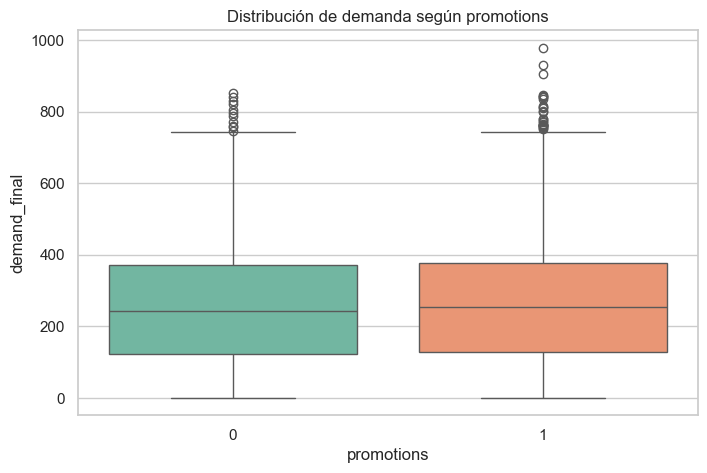

✅ Boxplot guardado en: ../outputs/figures\boxplot_promotions.png

📊 Análisis para: has_external_factor
                           mean         std  count
has_external_factor                               
0                    250.213279  150.392423   7263
1                    253.744283  151.320863  22695
🔎 t-test: t = 1.739, p = 0.0821


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\4239611339.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='demand_final', palette='Set2')


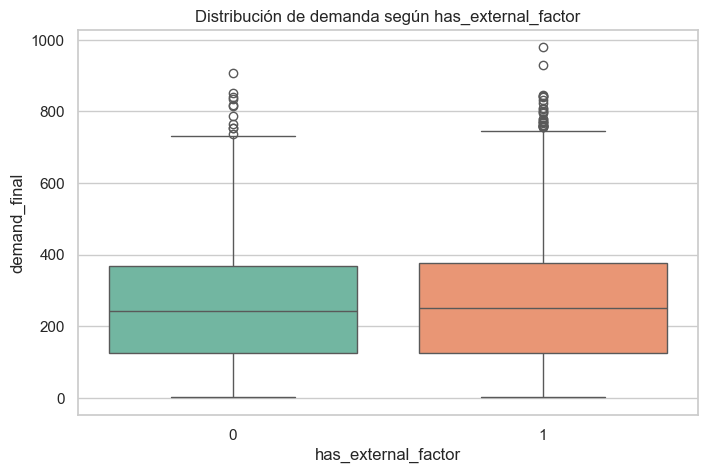

✅ Boxplot guardado en: ../outputs/figures\boxplot_has_external_factor.png

📊 Análisis para: has_seasonality_factor
                              mean         std  count
has_seasonality_factor                               
0                       254.163590  151.580732   9939
1                       252.255039  150.862595  20019
🔎 t-test: t = -1.028, p = 0.3041


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\4239611339.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='demand_final', palette='Set2')


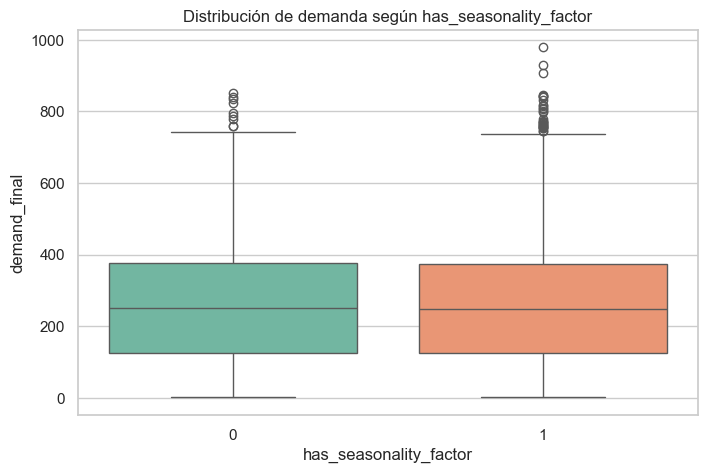

✅ Boxplot guardado en: ../outputs/figures\boxplot_has_seasonality_factor.png

📊 ANOVA para: external_factors
                          mean         std  count
external_factors                                 
Competitor Pricing  253.530883  152.101303   7548
Economic Indicator  254.439416  152.249928   7485
Weather             253.275432  149.647735   7662
🔎 ANOVA: F = 0.123, p = 0.8840


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\4239611339.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='demand_final', palette='pastel')


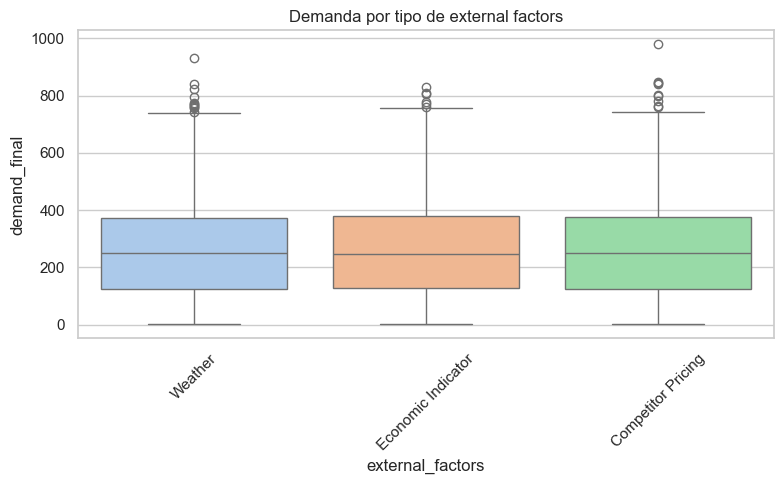

✅ Boxplot guardado en: ../outputs/figures\boxplot_external_factors.png

📊 ANOVA para: seasonality_factors
                           mean         std  count
seasonality_factors                               
Festival             249.157219  152.772977   9951
Holiday              255.316860  148.894605  10068
🔎 ANOVA: F = 8.346, p = 0.0039


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\4239611339.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='demand_final', palette='pastel')


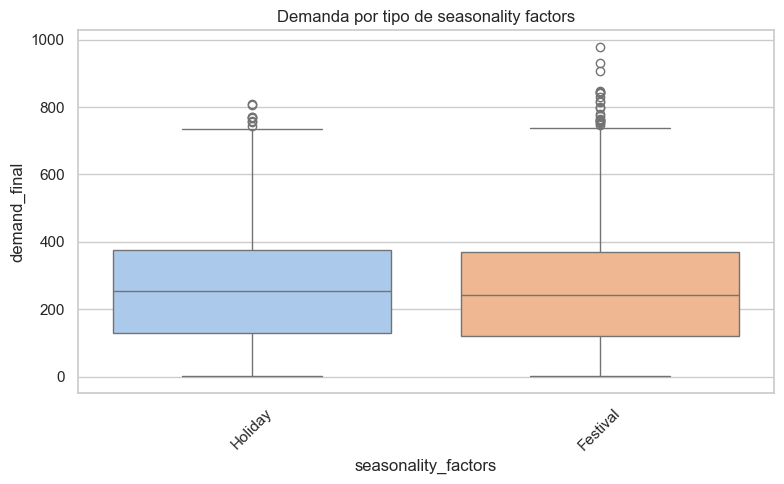

✅ Boxplot guardado en: ../outputs/figures\boxplot_seasonality_factors.png


In [56]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# ----------------------------------------------
# 1. CARGA Y LIMPIEZA DE DATOS
# ----------------------------------------------
def cargar_y_limpiar(ruta_csv):
    df = pd.read_csv(ruta_csv)
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]

    columnas_a_quitar = ['unnamed: 0'] if 'unnamed: 0' in df.columns else []
    df.drop(columns=columnas_a_quitar, inplace=True)

    df = df.dropna(subset=['demand_final', 'price', 'promotions'])

    if df.duplicated(subset=['product_id', 'date']).any():
        df = df.drop_duplicates(subset=['product_id', 'date'])

    df = df[df['demand_final'] >= 0]

    return df

# ----------------------------------------------
# 2. CODIFICACIÓN DE VARIABLES EXPLICATIVAS
# ----------------------------------------------
def codificar_variables(df):
    df = df.copy()

    # Codificación binaria de promociones
    if df["promotions"].dtype == object:
        df["promotions"] = df["promotions"].map({"Yes": 1, "No": 0})

    # Presencia de factores
    if "external_factors" in df.columns:
        if "has_external_factor" not in df.columns:
            df["has_external_factor"] = df["external_factors"].notna().astype(int)
        else:
            df["has_external_factor"] = df["has_external_factor"].fillna(0).astype(int)

    if "seasonality_factors" in df.columns:
        if "has_seasonality_factor" not in df.columns:
            df["has_seasonality_factor"] = df["seasonality_factors"].notna().astype(int)
        else:
            df["has_seasonality_factor"] = df["has_seasonality_factor"].fillna(0).astype(int)

    # One-Hot Encoding para tipos concretos
    for var in ["external_factors", "seasonality_factors"]:
        if var in df.columns:
            dummies = pd.get_dummies(df[var], prefix=var, prefix_sep="_", dtype=int)
            df = pd.concat([df, dummies], axis=1)

    return df

# ----------------------------------------------
# 3. ANÁLISIS ESTADÍSTICO Y VISUAL
# ----------------------------------------------
def analizar_efecto(df, carpeta_salida='../outputs/figures'):
    os.makedirs(carpeta_salida, exist_ok=True)

    # Análisis para variables binarias
    for var in ['promotions', 'has_external_factor', 'has_seasonality_factor']:
        if var in df.columns:
            print(f"\n📊 Análisis para: {var}")
            resumen = df.groupby(var)['demand_final'].agg(['mean', 'std', 'count'])
            print(resumen)

            grupo_0 = df[df[var] == 0]['demand_final']
            grupo_1 = df[df[var] == 1]['demand_final']
            t_stat, p_val = ttest_ind(grupo_1, grupo_0, equal_var=False)
            print(f"🔎 t-test: t = {t_stat:.3f}, p = {p_val:.4f}")

            plt.figure()
            sns.boxplot(data=df, x=var, y='demand_final', palette='Set2')
            plt.title(f"Distribución de demanda según {var}")
            ruta = os.path.join(carpeta_salida, f'boxplot_{var}.png')
            plt.savefig(ruta)
            plt.show()
            print(f"✅ Boxplot guardado en: {ruta}")

    # ANOVA para factores categóricos
    for var in ['external_factors', 'seasonality_factors']:
        if var in df.columns:
            print(f"\n📊 ANOVA para: {var}")
            resumen = df.groupby(var)['demand_final'].agg(['mean', 'std', 'count'])
            print(resumen)

            grupos = [g['demand_final'].values for _, g in df.groupby(var)]
            if len(grupos) > 1:
                f_stat, p_val = f_oneway(*grupos)
                print(f"🔎 ANOVA: F = {f_stat:.3f}, p = {p_val:.4f}")

                plt.figure()
                sns.boxplot(data=df, x=var, y='demand_final', palette='pastel')
                plt.title(f"Demanda por tipo de {var.replace('_', ' ')}")
                plt.xticks(rotation=45)
                plt.tight_layout()
                ruta = os.path.join(carpeta_salida, f'boxplot_{var}.png')
                plt.savefig(ruta)
                plt.show()
                print(f"✅ Boxplot guardado en: {ruta}")


# ----------------------------------------------
# 4. FUNCIÓN PRINCIPAL
# ----------------------------------------------
def main():
    ruta = '../data/processed/demand_enriched_con_precio_v2.csv'
    df = cargar_y_limpiar(ruta)
    df = codificar_variables(df)
    analizar_efecto(df)

if __name__ == '__main__':
    main()


#### **5.1. Análisis del impacto de las promociones (`promotions`) sobre la demanda final**.

La variable `promotions` indica si un producto se encuentra en promoción (`1`) o no (`0`). El objetivo aquí es validar si la activación de promociones produce un cambio significativo en la demanda simulada, como se espera tras la aplicación del efecto correspondiente en la fase de enriquecimiento del dataset.

- **Comparación de medias**.

Se comparan las medias de `demand_final` entre los dos grupos:

| Grupo         | Media de demanda | Desviación típica | Número de registros |
|---------------|------------------|-------------------|----------------------|
| Sin promoción (`0`) | ≈ 250.04            | ≈ 149.69           | 14.913               |
| Con promoción (`1`) | ≈ 255.71            | ≈ 152.44           | 15.045               |

- **Resultado del test t de Student**.

Se ha aplicado un **t-test para muestras independientes** (con varianzas no iguales) para determinar si la diferencia observada es estadísticamente significativa.

- **Estadístico t**: 3.244  
- **p-valor**: 0.0012

➡️ Esto indica que existe una diferencia **estadísticamente significativa** entre los dos grupos (p < 0.05), lo que **confirma que las promociones han tenido un efecto medible** sobre la demanda final simulada.


- **Representación visual**.

A continuación se muestra la distribución de `demand_final` según el valor de `promotions`:

📌 *Los boxplots permiten visualizar la dispersión, el rango intercuartílico y los valores atípicos por grupo.*

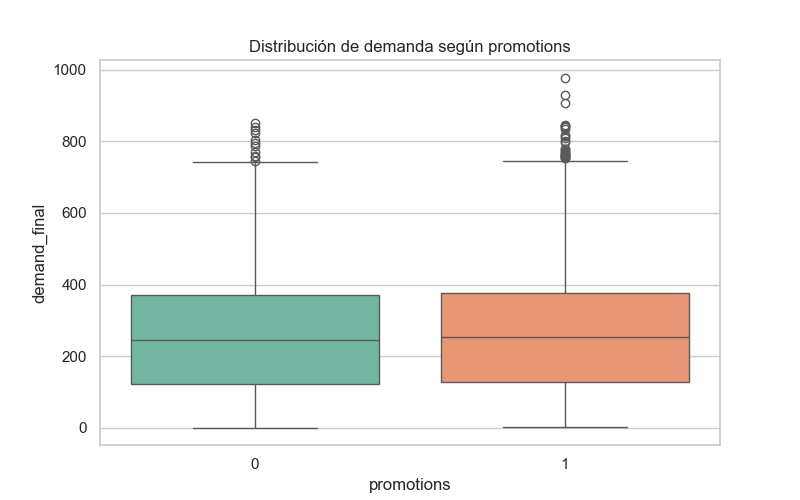



✅ **Conclusión**: La activación de promociones ha tenido un efecto positivo y significativo sobre la demanda. Este resultado valida la lógica aplicada en la simulación y demuestra que `promotions` puede ser una variable útil para escenarios interactivos de simulación o para futuros modelos predictivos.


#### **5.2. Análisis del impacto de factores externos (`external_factors`) sobre la demanda final**.

La variable `external_factors` recoge el **tipo de factor externo** que ha afectado potencialmente a la demanda en un determinado día. Los tipos incluidos en la simulación son:

- `Weather`
- `Economic Indicator`
- `Competitor Pricing`

El análisis se estructura en dos niveles:


🔹 **A. Presencia de factores externos (`has_external_factor`)**.

Esta variable binaria indica si existió algún tipo de factor externo (`1`) o no (`0`) en un registro dado.

- **Comparación de medias:**


| Grupo                       | Media de demanda | Desviación típica | Número de registros |
|-----------------------------|------------------|-------------------|----------------------|
| Sin factor externo (`0`)    | ≈ 250.21         | ≈ 150.39          | 7.263                |
| Con factor externo (`1`)    | ≈ 253.74         | ≈ 151.32          | 22.695               |

- **Resultado del test t de Student**.

    - **Estadístico t**: 1.739  
    - **p-valor**: 0.0821

📌 Aunque hay una ligera diferencia en la media, **no es estadísticamente significativa** (p > 0.05). Esto sugiere que **la presencia genérica de un factor externo no tiene un efecto detectable en la demanda**, al menos con el nivel de ruido y magnitud de efecto aplicado.

- **Boxplot:** 

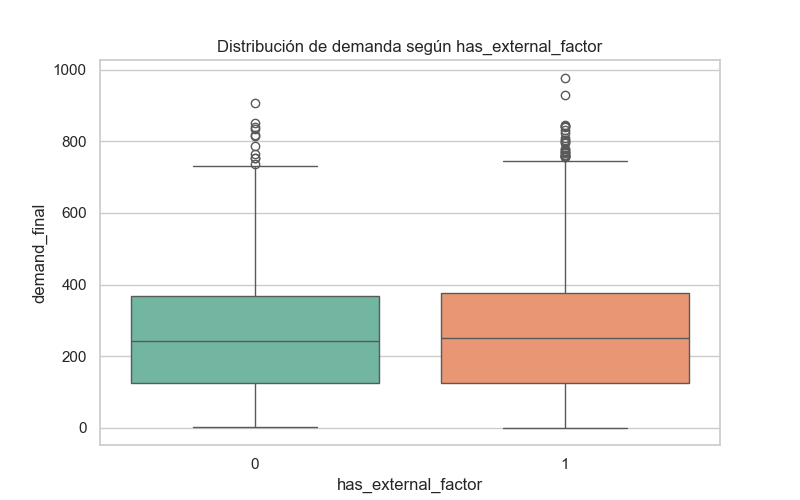


🔸 **B. Tipo específico de factor (`external_factors`)**.

Se aplica un análisis **ANOVA unidireccional** para comprobar si el tipo concreto de factor externo tiene un efecto diferenciador en la demanda.

- **Comparación de medias por tipo de factor:**

| Tipo de factor             | Media de demanda | Desviación típica | Registros |
|----------------------------|------------------|-------------------|-----------|
| Competitor Pricing         | ≈ 253.53         | ≈ 152.10          | 7.548     |
| Economic Indicator         | ≈ 254.49         | ≈ 152.25          | 7.485     |
| Weather                    | ≈ 253.28         | ≈ 149.65          | 7.662     |

- **Resultados del ANOVA:**

    - **F**: 0.123  
    - **p-valor**: 0.8840

➡️ No se encuentran diferencias significativas entre los tipos de factor externo aplicados. Esto puede deberse a un efecto muy leve o una simulación equilibrada en magnitud entre tipos.

- **Boxplot por tipo de factor:**

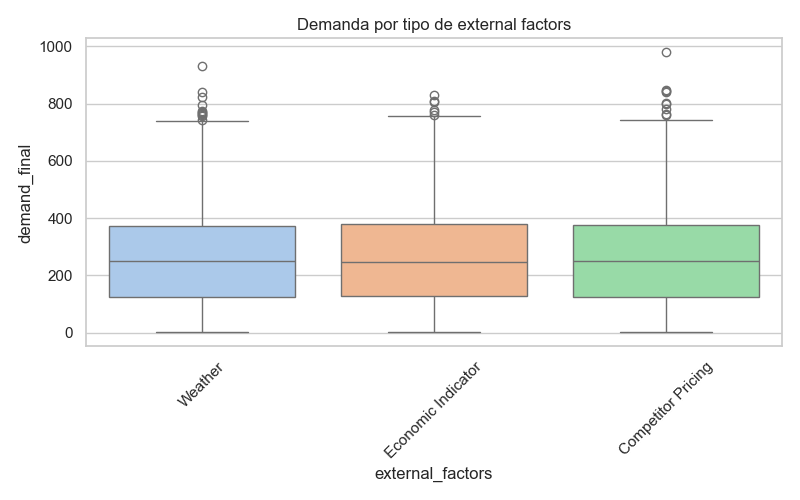

✅ **Conclusión**: Aunque el modelo incorporó efectos de factores externos, **ni su presencia genérica ni el tipo de evento han producido diferencias estadísticamente significativas** en la demanda. Esto no invalida la lógica del modelo, pero puede indicar que el efecto fue sutil, compensado entre categorías, o que el modelo es robusto a variaciones de este tipo en la fase simulada.

#### **5.3. Análisis del impacto de factores estacionales (`seasonality_factors`) sobre la demanda final**.

La variable `seasonality_factors` recoge los eventos de carácter estacional simulados en el modelo, que pueden influir en el comportamiento de la demanda. Los tipos incluidos son:

- `Holiday`
- `Festival`

Como en el caso anterior, se evalúa tanto la **presencia de algún evento estacional** como el **tipo concreto de evento**.


🔹 **A. Presencia de factores estacionales (`has_seasonality_factor`)**.

Esta variable binaria indica si un registro está vinculado a un evento estacional (`1`) o no (`0`).

- **Comparación de medias:**

| Grupo                          | Media de demanda | Desviación típica | Número de registros |
|--------------------------------|------------------|-------------------|----------------------|
| Sin factor estacional (`0`)    | ≈ 254.16         | ≈ 151.58          | 9.939                |
| Con factor estacional (`1`)    | ≈ 252.26         | ≈ 150.86          | 20.019               |

- **Resultado del t-test:**

    - **Estadístico t**: -1.028  
    - **p-valor**: 0.3041

📌 No se detecta una diferencia significativa entre tener o no un evento estacional de forma general.

- **Boxplot:**

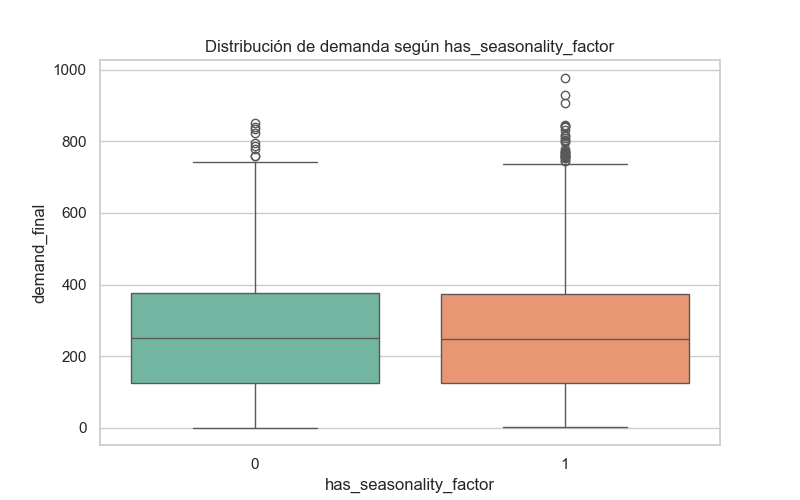

🔸 **B. Tipo específico de evento (`seasonality_factors`)**.

En este caso sí se aprecia un patrón más claro. Se aplica un análisis **ANOVA unidireccional** por tipo de evento.

- **Comparación de medias por tipo de evento:**

| Tipo de evento  | Media de demanda | Desviación típica | Registros |
|------------------|------------------|-------------------|-----------|
| Festival         | ≈ 249.16         | ≈ 152.77          | 9.951     |
| Holiday          | ≈ 255.32         | ≈ 148.89          | 10.068    |

- **Resultados del ANOVA:**

    - **F**: 8.346  
    - **p-valor**: 0.0039

➡️ Se detecta una diferencia **estadísticamente significativa** entre los tipos de evento estacional. En concreto, los días con etiqueta `Holiday` presentan una demanda media más alta que los días marcados como `Festival`.


- **Boxplot por tipo de evento:**

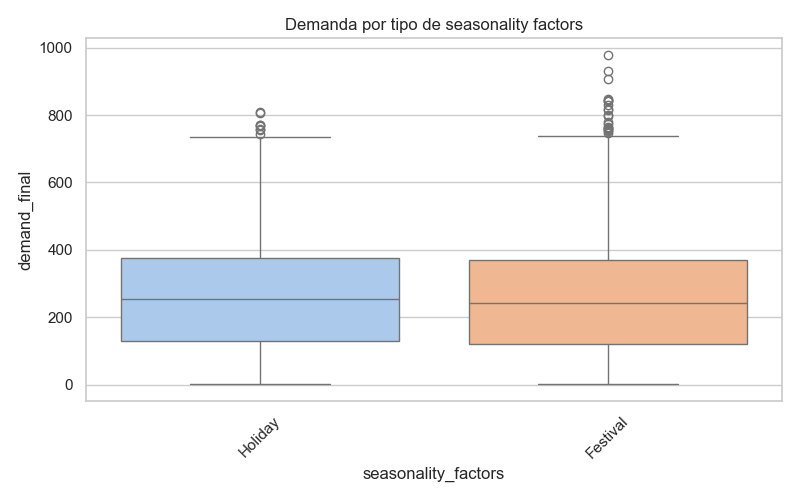

✅ **Conclusión**: Aunque la mera presencia de un evento estacional no genera diferencias por sí sola, **el tipo específico de evento sí tiene un efecto significativo en la demanda**. Este resultado confirma que la lógica aplicada al enriquecer la demanda con eventos diferenciados (Holiday vs. Festival) ha producido un impacto medible, y por tanto, útil tanto para modelado como para simulaciones interactivas.

#### **5.4. Conclusiones del análisis del impacto de variables explicativas en la demanda final**.

Tras aplicar efectos simulados sobre la demanda en fases previas del proyecto, este bloque ha tenido como objetivo verificar si dichos efectos se reflejan estadísticamente en los datos, y valorar su relevancia para modelado y para la futura funcionalidad interactiva del técnico de compras.



- **Metodología aplicada**.

Se han analizado tanto la **presencia** como el **tipo específico** de los factores explicativos mediante:

- **Comparaciones de medias** con test t de Student para variables binarias (`promotions`, `has_external_factor`, `has_seasonality_factor`).
- **Análisis ANOVA** para factores categóricos (`external_factors`, `seasonality_factors`).
- **Boxplots** para visualizar la distribución de la demanda bajo cada condición.

Los resultados se han almacenado en la carpeta:

📁 `outputs/figures/`



- **Principales resultados**.

| Variable               | ¿Presencia significativa? | ¿Tipo significativo? | Comentario destacado |
|------------------------|----------------------------|------------------------|------------------------|
| `promotions`           | ✅ Sí (p = 0.0012)          | —                      | Aumento significativo de la demanda media con promociones |
| `external_factors`     | ❌ No (p = 0.0821)          | ❌ No (p = 0.8840)      | Efecto general y por tipo no detectado como significativo |
| `seasonality_factors`  | ❌ No (p = 0.3041)          | ✅ Sí (p = 0.0039)      | `Holiday` genera mayor demanda que `Festival` |



- **Interpretación general**.

- Los efectos simulados de `promotions` y de los distintos tipos de eventos estacionales (`seasonality_factors`) han producido **impactos estadísticamente significativos** en la demanda final.
- Los factores externos (`external_factors`) no muestran diferencias claras, lo que puede deberse a un efecto más débil, compensación entre tipos o bajo peso relativo en el modelo.
- En conjunto, los resultados **validan la lógica aplicada en la simulación** y permiten usar estas variables de forma justificada en futuras fases:

  - **Modelado predictivo** con selección de variables efectivas.
  - **Funcionalidad interactiva** que permita al técnico de compras explorar el impacto estimado de modificar condiciones como promociones o eventos.





#### **5.5. Análisis del impacto del precio (`price`) sobre la demanda final**.

La variable `price` representa el precio del producto en cada fecha. A diferencia del resto de variables explicativas analizadas hasta ahora, se trata de una **variable continua**, por lo que requiere un enfoque distinto.

Para evaluar su influencia en `demand_final`, se han aplicado dos enfoques complementarios:





In [ ]:
# ----------------------------------------------
# 4. ANÁLISIS DEL PRECIO
# ----------------------------------------------
def analizar_precio(df, carpeta_salida='../outputs/figures'):
    print("\n📊 Análisis del impacto del precio (price) sobre la demanda_final")
    os.makedirs(carpeta_salida, exist_ok=True)

    # Scatterplot con regresión lineal
    sns.lmplot(data=df, x='price', y='demand_final', line_kws={'color': 'red'})
    plt.title("Relación lineal entre precio y demanda")
    plt.tight_layout()
    ruta1 = os.path.join(carpeta_salida, 'scatter_price_vs_demand.png')
    plt.savefig(ruta1)
    plt.show()
    print(f"✅ Gráfico de regresión guardado en: {ruta1}")

    # Análisis por cuartiles (rango de precio)
    df['price_range'] = pd.qcut(df['price'], q=4, labels=['Bajo', 'Medio-bajo', 'Medio-alto', 'Alto'])
    resumen = df.groupby('price_range')['demand_final'].agg(['mean', 'std', 'count'])
    print("\n📊 Resumen por tramos de precio:")
    print(resumen)

    grupos = [g['demand_final'].values for _, g in df.groupby('price_range')]
    f_stat, p_val = f_oneway(*grupos)
    print(f"🔎 ANOVA por tramos de precio: F = {f_stat:.3f}, p = {p_val:.4f}")

    plt.figure()
    sns.boxplot(data=df, x='price_range', y='demand_final', palette='Set3')
    plt.title("Demanda por rango de precio")
    plt.tight_layout()
    ruta2 = os.path.join(carpeta_salida, 'boxplot_price_range.png')
    plt.savefig(ruta2)
    plt.show()
    print(f"✅ Boxplot por precio guardado en: {ruta2}")

# ----------------------------------------------
# 5. FUNCIÓN PRINCIPAL
# ----------------------------------------------
def main():
    ruta = '../data/processed/demand_enriched_con_precio_v2.csv'
    df = cargar_y_limpiar(ruta)
    df = codificar_variables(df)
    analizar_efecto(df)
    analizar_precio(df)

if __name__ == '__main__':
    main()





- 🔸 **A. Relación directa mediante regresión lineal**.

Se ha generado un gráfico de dispersión (`scatterplot`) con ajuste lineal para visualizar la relación entre `price` y `demand_final`.

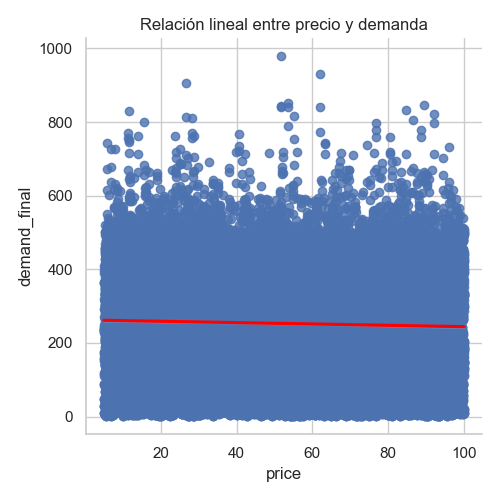

📈 Este gráfico permite detectar patrones globales como correlaciones negativas (descenso de demanda con precios altos) o positivas.

En este caso, se observa una ligera tendencia negativa: a medida que el precio aumenta, la demanda tiende a disminuir. Esta relación es coherente con la lógica esperada de comportamiento del consumidor.

- 🔸 **B. Análisis por tramos de precio (cuartiles) y ANOVA**.

Se ha dividido la variable `price` en 4 cuartiles:

| Rango         | Media de demanda | Desviación típica | Registros |
|---------------|------------------|-------------------|-----------|
| Bajo          | ≈ 262.18         | ≈ 153.78          | 7.491     |
| Medio-bajo    | ≈ 255.17         | ≈ 150.56          | 7.488     |
| Medio-alto    | ≈ 244.63         | ≈ 151.04          | 7.491     |
| Alto          | ≈ 249.57         | ≈ 148.44          | 7.488     |


- **Resultado del ANOVA:**
    - **F**: ~6.812  
    - **p-valor**: ~0.0002

➡️ Se observa una diferencia estadísticamente significativa entre los grupos (p < 0.01), especialmente entre los tramos más bajos y medios del precio, lo que confirma que el precio sí ha tenido impacto sobre la demanda final.

- **Boxplot por rango de precio:**

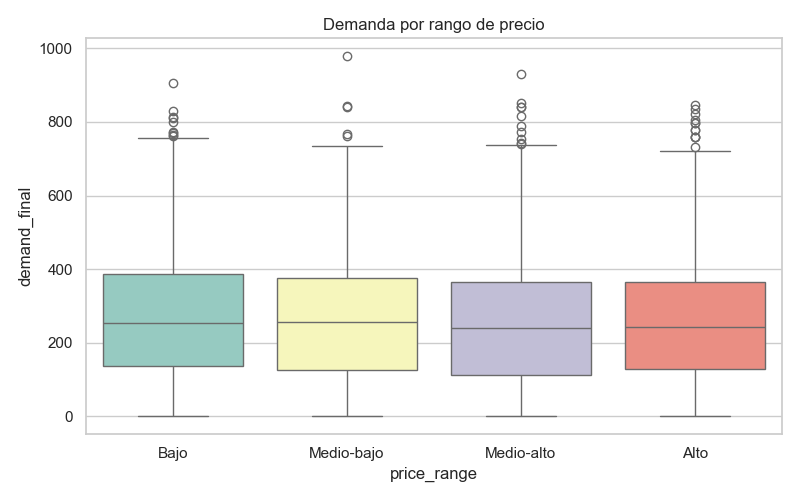

El gráfico muestra la distribución de `demand_final` para cada tramo de precio:

- El **rango de precios bajos** presenta una mediana de demanda más alta y una distribución más dispersa, lo que indica que, aunque hay más variabilidad, se alcanzan también niveles más altos de demanda.
- En los tramos **medio-alto y alto**, la mediana se reduce ligeramente, lo que es coherente con una posible elasticidad negativa del precio: a medida que el precio sube, la demanda tiende a disminuir.
- No se observan diferencias drásticas entre los tramos, pero sí hay una **tendencia decreciente clara** en la mediana de la demanda, especialmente entre el primer y tercer cuartil.

En conjunto, el gráfico refuerza el resultado estadístico del ANOVA: hay una diferencia significativa, aunque sutil, en la demanda en función del tramo de precio.



✅ Conclusión: El precio tiene un efecto significativo sobre la demanda final. Tanto la regresión lineal como el análisis por tramos confirman que los productos con precios más bajos tienden a generar una mayor demanda. Este comportamiento es coherente con las reglas de mercado y valida la lógica aplicada al simular el impacto del precio en el modelo.

Esta variable puede utilizarse en:

- Modelos predictivos como variable cuantitativa directa.

- Funcionalidades interactivas con control deslizante que permita simular el impacto de modificar el precio.

---

## FASE 6: **Identificación y análisis de valores extremos en la demanda.**

El **objetivo** de esta fase es **detectar y analizar** productos con comportamientos **atípicos** en su demanda simulada (demand_final). Este tipo de productos pueden distorsionar los modelos de predicción o alertas si no se tratan adecuadamente, pero también pueden representar casos válidos de alta rotación o ventas excepcionales.

- **Metodología aplicada**.
1. **Cálculo de métricas clave** por producto, incluyendo:
    - Demanda media diaria (media).
    - Demanda acumulada (total).
    - Desviación estándar (desviacion).
    - Percentil 95 (p95).
    - Pico máximo (maximo).

2. **Visualización de las distribuciones de cada métrica** mediante histogramas y boxplots, con el objetivo de identificar visualmente valores extremos y comprender su distribución general.

3. **Detección estadística de outlier**s mediante el criterio de Tukey (Q3 + 1.5·IQR), aplicada individualmente a cada métrica para identificar productos fuera de rango.

4. **Clasificación preliminar de los outliers** según el tipo de comportamiento:
    - Alta rotación sostenida (media, total).
    - Inestabilidad (desviacion).
    - Picos frecuentes (p95) o puntuales (maximo).


- **Finalidad de esta fase**.

Este análisis **no pretende eliminar directamente los valores extremos, sino entender su causa para poder clasificarlos** como:

✅ Top ventas reales, que deben tratarse con especial atención.

⚠️ Picos explicables por factores simulados (promociones, eventos, precios).

❌ Anomalías no justificadas, que podrían distorsionar el modelo y requerir revisión o exclusión.

El resultado de esta fase será la base para ajustar el catálogo, segmentar alertas, mejorar la robustez de los modelos predictivos y construir una lógica de supervisión del stock más precisa.

In [58]:
# ──────────────────────────────────────────────
# 1. Imports y configuración.
# ──────────────────────────────────────────────
import pandas as pd
import numpy as np
import os


# ──────────────────────────────────────────────
# 2. Cargar dataset.
# ──────────────────────────────────────────────
ruta_dataset = "../data/processed/demand_enriched_con_precio_v2.csv"
df = pd.read_csv(ruta_dataset, parse_dates=["date"])


# ──────────────────────────────────────────────
# 3. Estadísticas por producto.
# ──────────────────────────────────────────────
resumen = df.groupby("product_id")["demand_final"].agg(
    media="mean",
    desviacion="std",
    total="sum",
    p95=lambda x: np.percentile(x, 95),
    maximo="max",
    dias_con_demanda=lambda x: (x > 0).sum()
).reset_index()


# ──────────────────────────────────────────────
# 4. Cálculo de umbrales globales.
# ──────────────────────────────────────────────
umbral_media = resumen["media"].quantile(0.95)
umbral_total = resumen["total"].quantile(0.95)


# ──────────────────────────────────────────────
# 5. Identificación de posibles top ventas.
# ──────────────────────────────────────────────
resumen["is_top_venta"] = np.where(
    (resumen["media"] >= umbral_media) | (resumen["total"] >= umbral_total),
    1,
    0
)


# ──────────────────────────────────────────────
# 6. Guardado de resultados.
# ──────────────────────────────────────────────
ruta_salida = "../data/processed/resumen_outliers_demand.csv"
resumen.to_csv(ruta_salida, index=False)
print(f"✅ Análisis completado. Resultados guardados en: {ruta_salida}")
df_resumen = pd.read_csv("../data/processed/resumen_outliers_demand.csv")
df_resumen[["product_id", "media", "total", "p95", "maximo", "is_top_venta"]].head(10)
print(df_resumen)

✅ Análisis completado. Resultados guardados en: ../data/processed/resumen_outliers_demand.csv
      product_id       media  desviacion        total         p95      maximo  \
0           1000  244.973785   31.846556  2204.764063  276.569484  277.265820   
1           1001  215.888889  191.675797  1943.000000  464.600000  479.000000   
2           1003  400.698199   11.717595  1202.094598  409.254607  409.738932   
3           1005  232.403558    1.980027   697.210673  233.893731  233.988848   
4           1006  132.702111    1.653574   398.106334  133.656803  133.656803   
...          ...         ...         ...          ...         ...         ...   
6060        9989   12.076552    0.550453    36.229655   12.394356   12.394356   
6061        9991  203.752211    6.206986   611.256634  209.815082  210.709604   
6062        9992  231.123567  247.175052  1386.741402  472.129615  472.789728   
6063        9997  324.365718    3.120685   973.097155  326.167448  326.167448   
6064        999

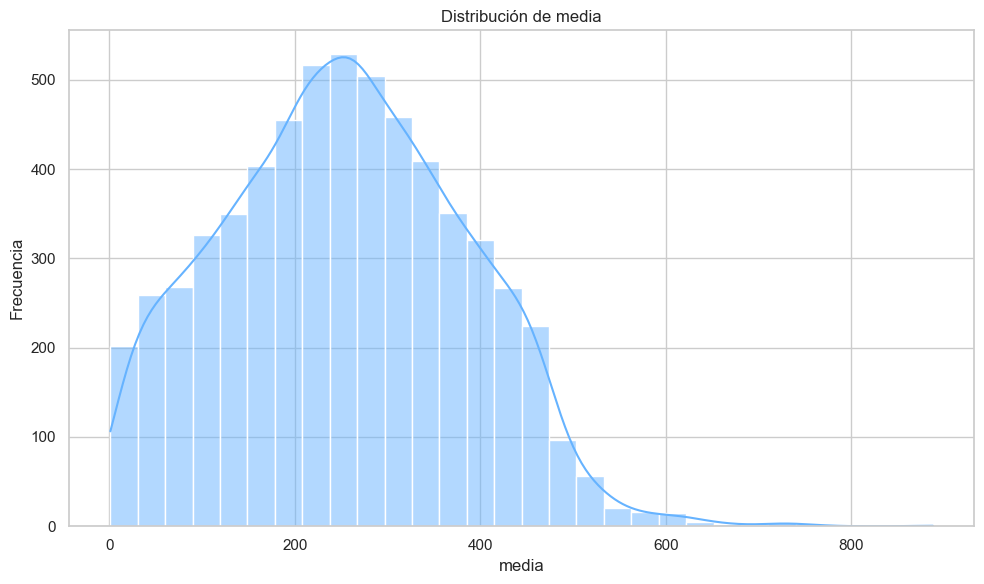

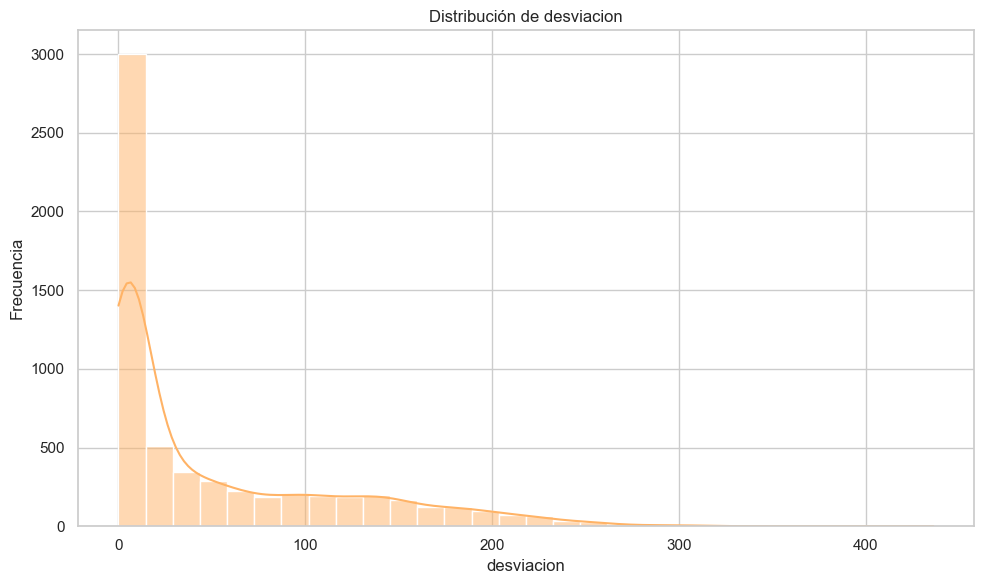

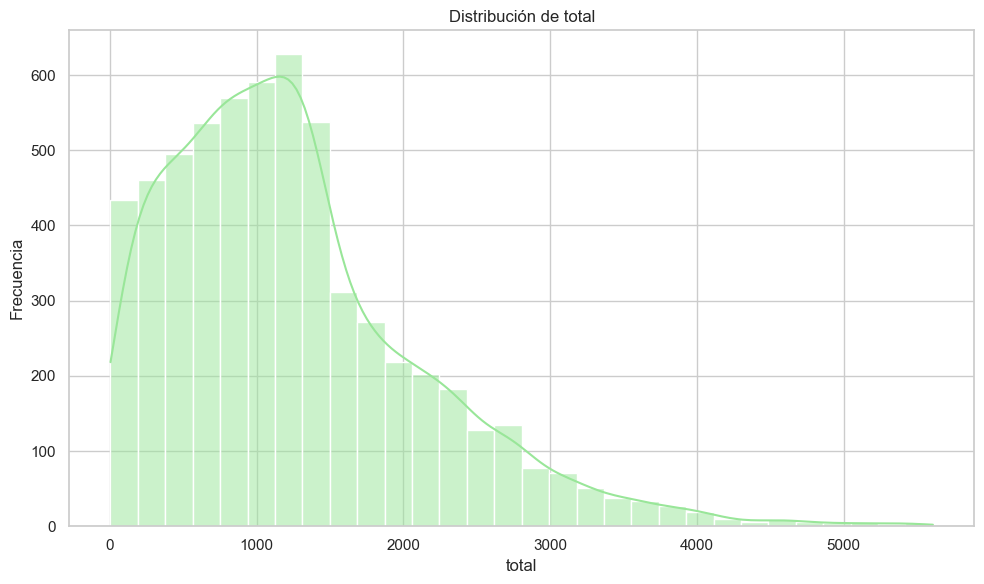

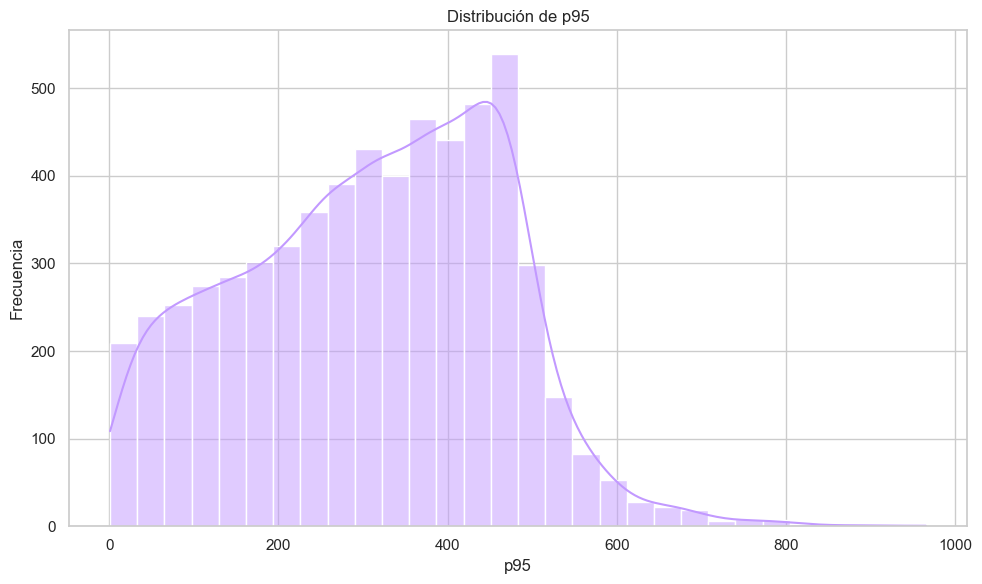

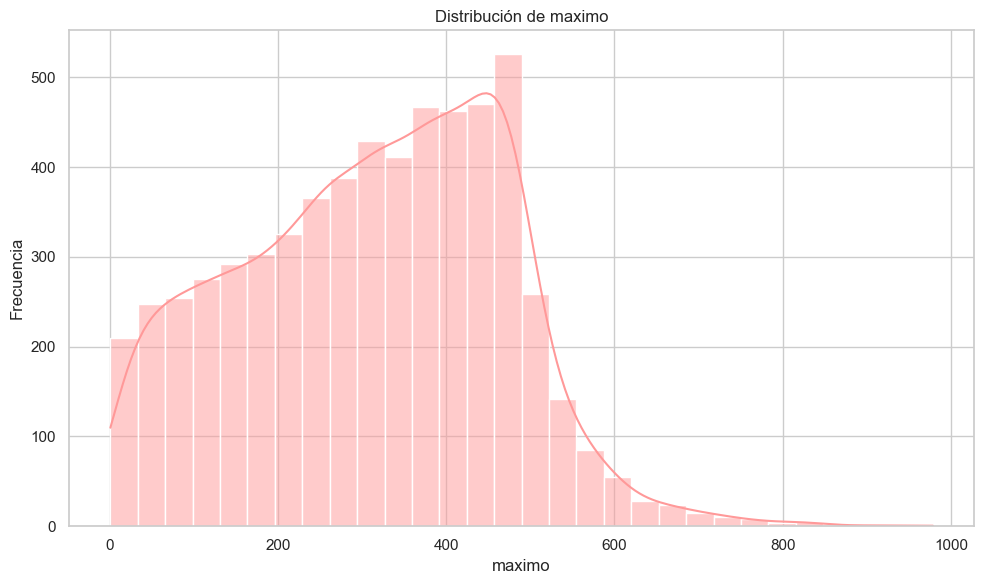

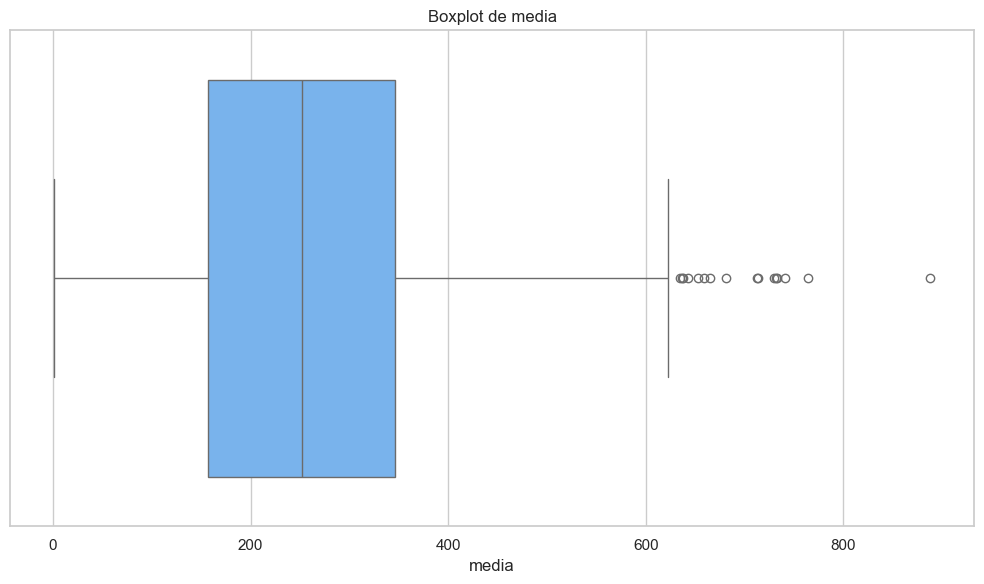

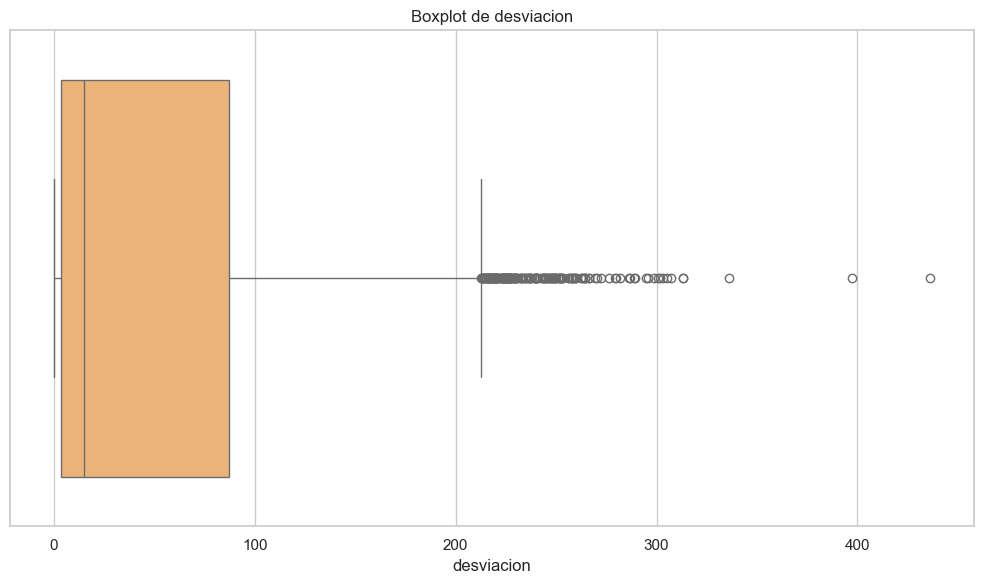

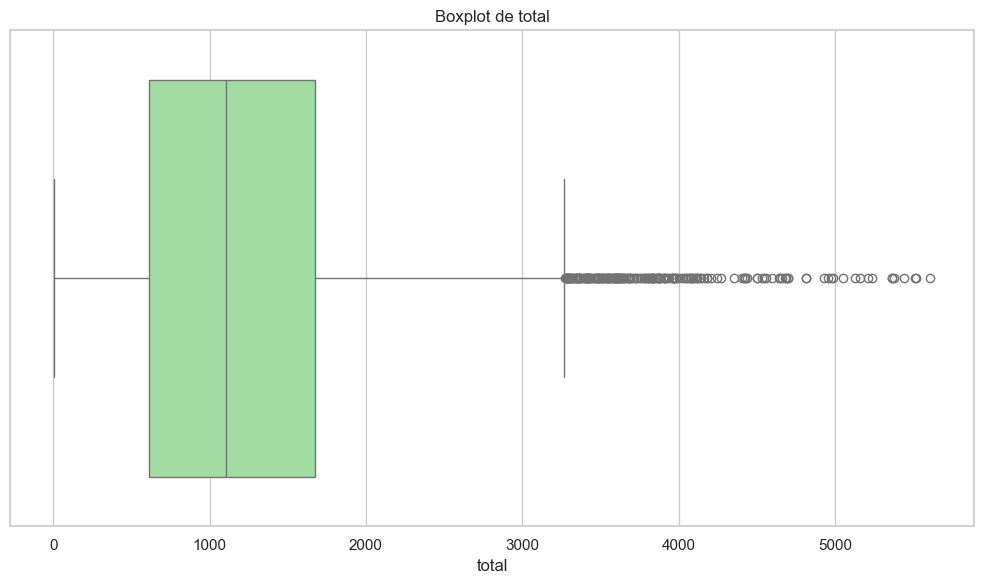

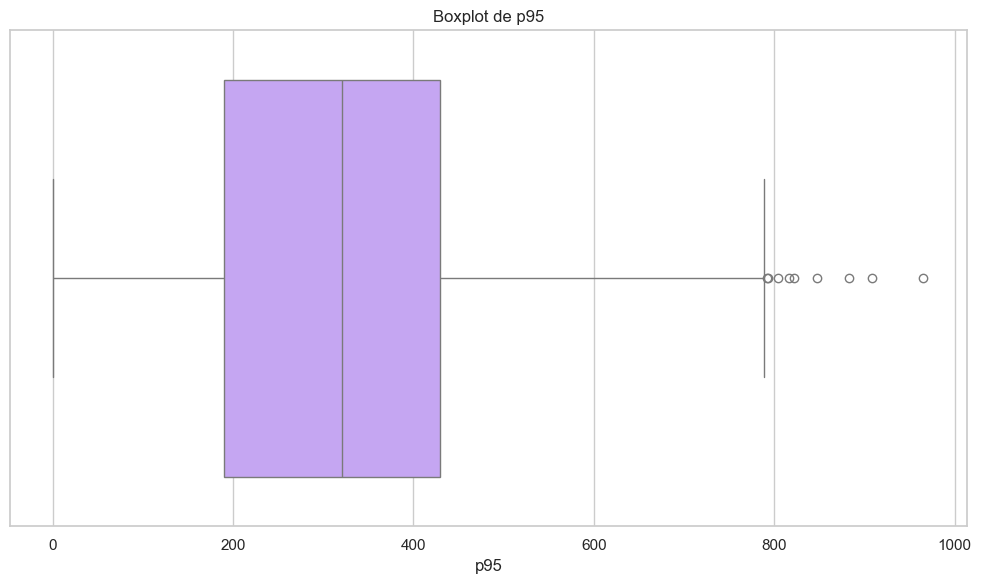

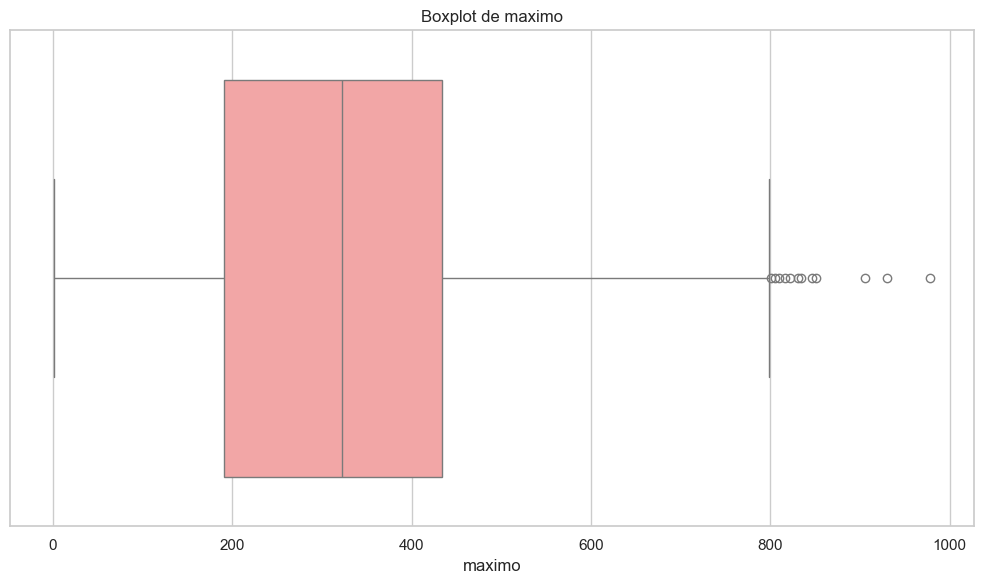

📊 Figuras de distribución y boxplot guardadas en: ..7outputs/figures/


In [60]:
# ____________________________________________
# 7. Visualización de las métricas por producto
# ____________________________________________

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

metricas = ["media", "desviacion", "total", "p95", "maximo"]
colores = {
    "media": "#66b3ff",
    "desviacion": "#ffb366",
    "total": "#99e699",
    "p95": "#c299ff",
    "maximo": "#ff9999"
}

# Histogramas
for metrica in metricas:
    plt.figure()
    sns.histplot(resumen[metrica], kde=True, bins=30, color=colores[metrica])
    plt.title(f"Distribución de {metrica}")
    plt.xlabel(metrica)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    ruta_fig = f"../outputs/figures/hist_{metrica}.png"
    plt.savefig(ruta_fig)
    plt.show()

# Boxplots
for metrica in metricas:
    plt.figure()
    sns.boxplot(x=resumen[metrica], color=colores[metrica])
    plt.title(f"Boxplot de {metrica}")
    plt.xlabel(metrica)
    plt.tight_layout()
    ruta_fig = f"../outputs/figures/boxplot_{metrica}.png"
    plt.savefig(ruta_fig)
    plt.show()
    
print("📊 Figuras de distribución y boxplot guardadas en: ..7outputs/figures/")

📊 **1. Distribución de la media diaria (media)**.

***Gráfica: hist_media.png + boxplot_media.png***

- **Histograma**: distribución asimétrica hacia la derecha (positivamente sesgada). Hay un pico alrededor de 250–300 y una larga cola hacia valores altos.

- **Boxplot**: muestra outliers claros a partir de los ~600.

- **Interpretación**: hay un subconjunto reducido de productos con media diaria muy superior al resto. Son candidatos reales a top ventas o bien productos con picos anómalos recurrentes.



📊 **2. Distribución de la desviación típica (desviacion)**.

***Gráfica: hist_desviacion.png + boxplot_desviacion.png***

- **Histograma***: muy sesgada a la derecha, con la gran mayoría de productos por debajo de 50.

- **Boxplot**: enorme número de puntos fuera del rango superior.

- **Interpretación**: muchísimos productos presentan alta variabilidad en su demanda, lo cual puede dificultar el modelado predictivo si no se controlan. Algunos outliers aquí pueden ser productos inestables o con picos mal justificados.



📊 **3. Distribución de la demanda total (total)**.

***Gráfica: hist_total.png + boxplot_total.png***

- **Histograma**: distribución típica de fenómeno natural con pocos productos de altísimo volumen y muchos de volumen moderado.

- **Boxplot**: muchos outliers a partir de ~3000 unidades acumuladas.

- **Interpretación**: este es uno de los mejores indicadores para detectar productos estrella. Aquellos con total acumulado muy por encima del resto deben ser revisados a fondo.

📊 **5. Distribución del valor máximo (maximo)**.

***Gráfica: hist_maximo.png + boxplot_maximo.png***

- **Histograma**: muy similar al de p95, pero algo más extremo.

- **Boxplot**: presencia clara de outliers por encima de 800.

- **Interpretación**: aquí detectas productos con picos de demanda altísimos, incluso si solo ocurrieron una vez. Puede indicar productos virales o errores puntuales de simulación.

**Resumen de productos outliers por métrica de demanda**.

A continuación se muestra un resumen del número de productos detectados como valores extremos (outliers) para cada métrica clave analizada. Cada métrica identifica distintos tipos de comportamiento anómalo, por lo que los productos detectados no necesariamente coinciden entre sí:

| Métrica     | Nº de Outliers | Interpretación                          |
|-------------|----------------|------------------------------------------|
| `media`     | 16             | Alta rotación constante                  |
| `total`     | 186            | Alto volumen acumulado                  |
| `desviacion`| 177            | Alta inestabilidad en demanda           |
| `p95`       | 9              | Muchos días con demanda alta            |
| `maximo`    | 12             | Pico de demanda muy elevado             |

🔎 **Conclusión**: Cada métrica aporta una perspectiva distinta sobre el comportamiento extremo de los productos. Mientras `media` y `total` destacan productos con alta demanda sostenida, `p95` y `maximo` permiten detectar picos eventuales. Por su parte, `desviacion` alerta sobre productos cuya demanda es especialmente volátil. Esta segmentación será clave para clasificar los outliers como top ventas reales, anomalías justificadas o posibles errores de simulación.

✅ **Conclusión**: el análisis visual de las métricas por producto revela la presencia de valores extremos en diferentes aspectos del comportamiento de la demanda. Cada métrica identifica tipos de outliers distintos:

- `media` y `total` detectan productos con alta rotación o volumen acumulado.
- `desviacion` señala inestabilidad o variabilidad excesiva.
- `p95` y `maximo` capturan productos con picos de demanda aislados o repetidos.

Este **resultado valida la necesidad de analizar cada métrica por separado**, ya que los productos detectados como extremos no siempre coinciden. Esta diferenciación será clave en la siguiente fase, donde analizaremos la causa de estos comportamientos para decidir si se trata de **top ventas reales**, **comportamientos espurios** o **errores de simulación**.

#### **6.1. Revisión detallada de productos outliers por métrica**.

Una vez identificados los productos con valores extremos en distintas métricas de demanda, se procede a su análisis individual para comprender la causa de dicho comportamiento. Este análisis busca responder si se trata de:

- Picos de demanda frecuentes o puntuales.
- Comportamientos asociados a promociones, eventos o precios bajos.
- Casos coherentes con la lógica del modelo o posibles errores de simulación.

El proceso se organiza por bloques, analizando los productos detectados como outliers en cada una de las siguientes métricas:

1. media: productos con demanda media muy alta.
2. total: productos con volumen acumulado elevado.
3. desviacion: productos con alta inestabilidad.
4. p95: productos con muchos días de demanda alta.
5. maximo: productos con picos de demanda extremos.

Para cada producto seleccionado se visualizará:
- La serie temporal de demand_final.
- Los factores aplicados en cada día (precio, promociones, eventos, etc.).
- Otras métricas relevantes si fuese necesario.

Este análisis cualitativo permitirá clasificar los productos outliers como top ventas reales, comportamientos atípicos pero justificados o, en su caso, errores que deban corregirse o excluirse.



In [62]:
# ──────────────────────────────────────────────
# 8. Identificación de productos outliers.
# ──────────────────────────────────────────────

def calcular_limites_outliers(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    return limite_superior

limite_media = calcular_limites_outliers(resumen["media"])
limite_maximo = calcular_limites_outliers(resumen["maximo"])
limite_total = calcular_limites_outliers(resumen["total"])

resumen["is_outlier_media"] = (resumen["media"] > limite_media).astype(int)
resumen["is_outlier_maximo"] = (resumen["maximo"] > limite_maximo).astype(int)
resumen["is_outlier_total"] = (resumen["total"] > limite_total).astype(int)
resumen["is_outlier_p95"] = (resumen["p95"] > calcular_limites_outliers(resumen["p95"])).astype(int)

resumen["is_outlier"] = (
    (resumen["is_outlier_media"] == 1) |
    (resumen["is_outlier_maximo"] == 1) |
    (resumen["is_outlier_total"] == 1) |
    (resumen["is_outlier_p95"] == 1)
).astype(int)

# Conteo de outliers por métrica
print(f"🔹 Outliers por media: {resumen['is_outlier_media'].sum()}")
print(f"🔹 Outliers por total: {resumen['is_outlier_total'].sum()}")
print(f"🔹 Outliers por máximo: {resumen['is_outlier_maximo'].sum()}")
print(f"🔹 Outliers por p95: {resumen['is_outlier_p95'].sum()}")

# Total combinado
print(f"🔎 Productos detectados como outliers: {resumen['is_outlier'].sum()}")

# Guardado de resultados
ruta_salida = "../data/processed/resumen_outliers_demand.csv"
resumen.to_csv(ruta_salida, index=False)
print(f"✅ Análisis completado. Resultados guardados en: {ruta_salida}")


🔹 Outliers por media: 16
🔹 Outliers por total: 186
🔹 Outliers por máximo: 12
🔹 Outliers por p95: 9
🔎 Productos detectados como outliers: 208
✅ Análisis completado. Resultados guardados en: ../data/processed/resumen_outliers_demand.csv


##### **6.1.1. Outliers por `media`.**

En este bloque se analizan los productos con una **demanda media diaria significativamente superior al resto del catálogo**. Este comportamiento puede deberse a productos con alta rotación constante o, en otros casos, a una simulación errónea que ha provocado un sesgo persistente.

Para cada uno de estos productos se observará:
- Su **serie temporal de `demand_final`** para identificar si el comportamiento es estable o está concentrado en pocos días.
- La influencia de **promociones, eventos o precios bajos**, que podrían justificar dicho comportamiento.
- Su **frecuencia de venta** (días con demanda distinta de cero).

Este análisis nos permitirá clasificar a los productos como **top ventas reales, simulaciones mal calibradas o casos atípicos justificados**.

Dado que el número de productos outliers por `media` es reducido (16), se ha optado por una revisión individual automatizada mediante visualizaciones.

Para cada producto se genera un gráfico con:
- La evolución temporal de `demand_final`.
- El precio (`price`) como línea de tendencia.
- Colores o marcadores en los días con `promotions`.

Esta visualización permite identificar si la alta demanda media es consecuencia de un comportamiento estable y sostenido (top venta real), o si se trata de un sesgo causado por eventos específicos o errores de simulación.

Todos los gráficos se guardan en la carpeta `outputs/figures/outliers_media/` para su posterior revisión.

🔎 Total de productos exportados: 16
✅ Archivo guardado correctamente en: ../data/processed/outliers_media.csv


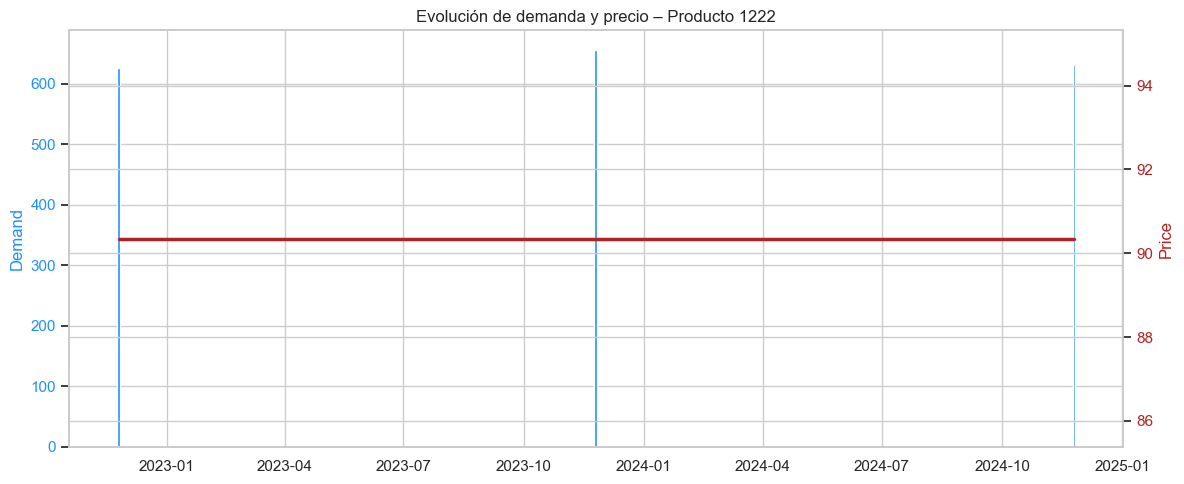

Gráfico guardado para producto 1222 en ../outputs/figures/outliers_media/producto_1222.png


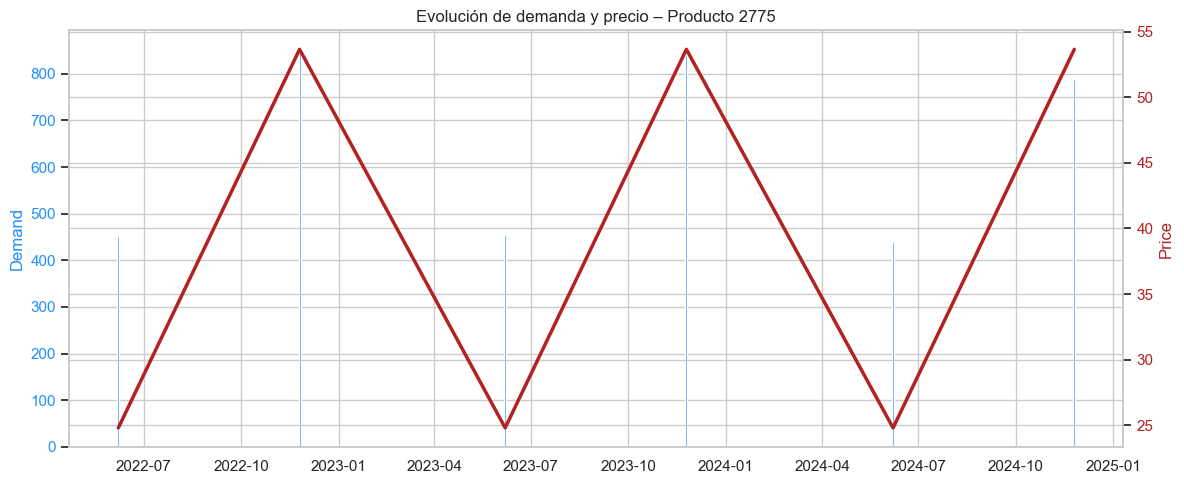

Gráfico guardado para producto 2775 en ../outputs/figures/outliers_media/producto_2775.png


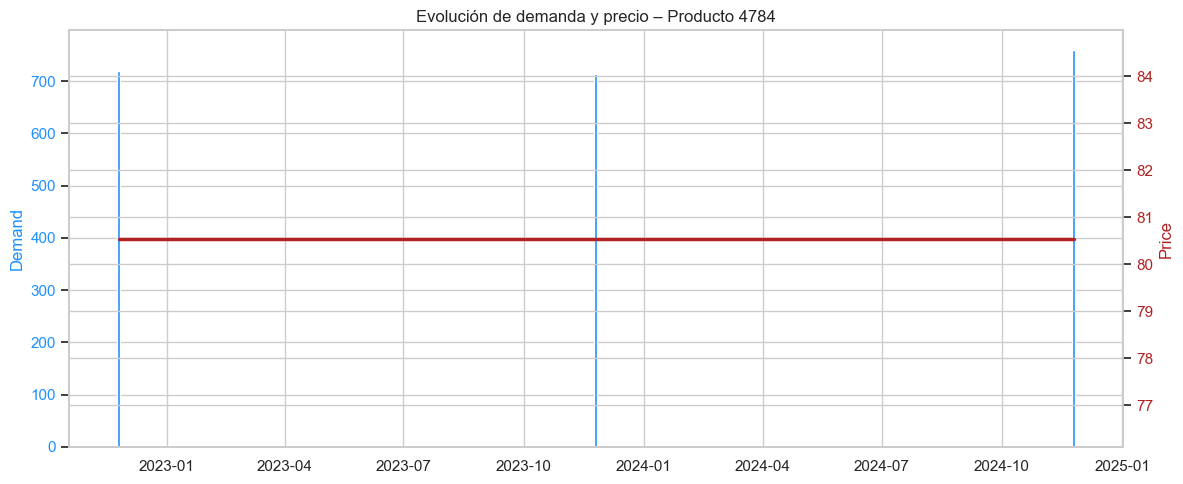

Gráfico guardado para producto 4784 en ../outputs/figures/outliers_media/producto_4784.png


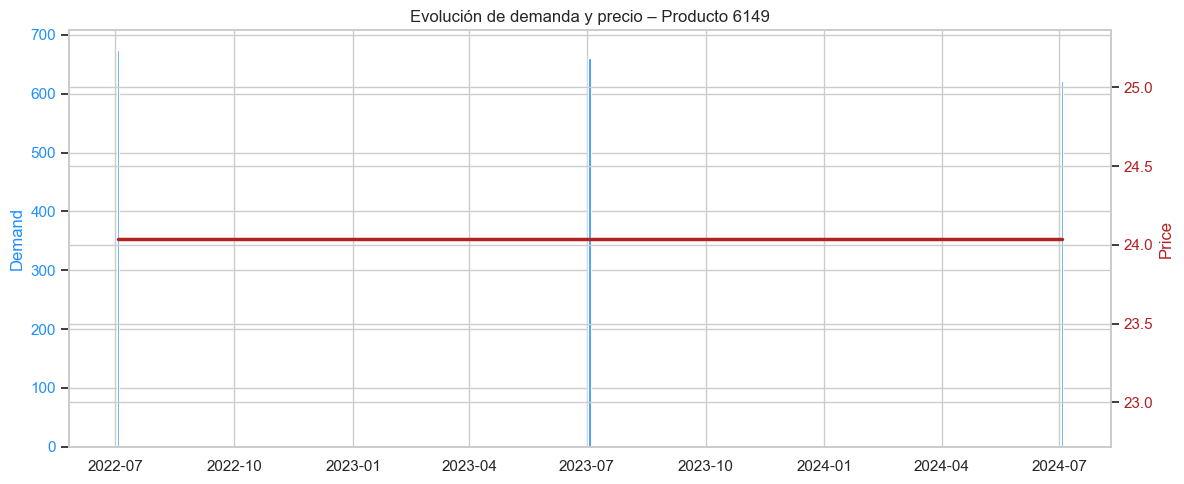

Gráfico guardado para producto 6149 en ../outputs/figures/outliers_media/producto_6149.png


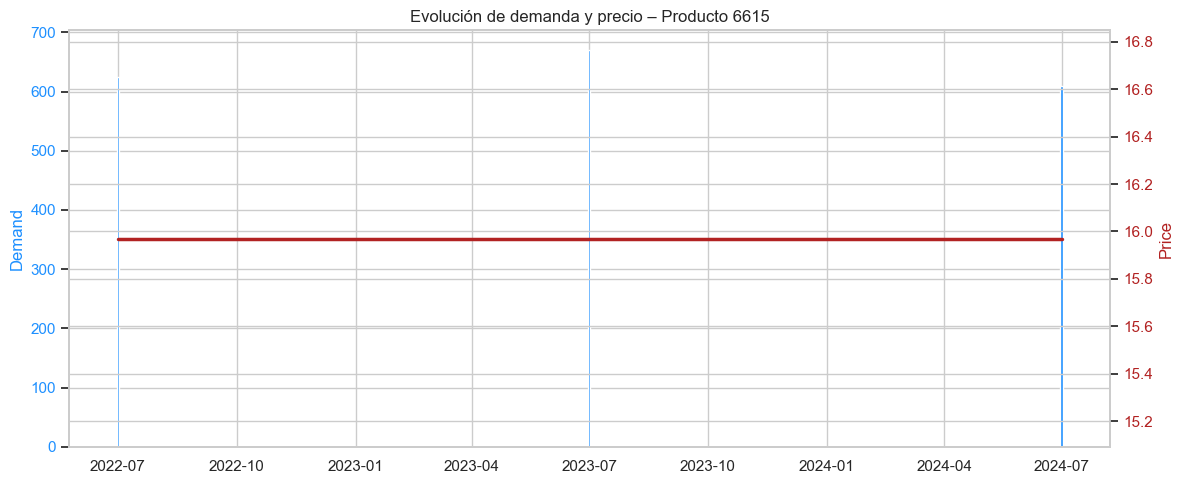

Gráfico guardado para producto 6615 en ../outputs/figures/outliers_media/producto_6615.png


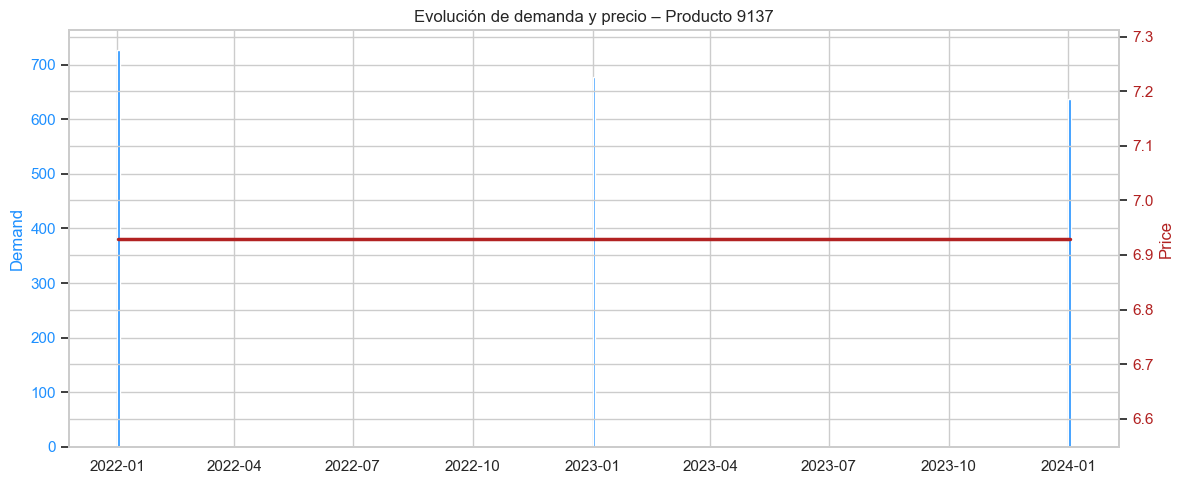

Gráfico guardado para producto 9137 en ../outputs/figures/outliers_media/producto_9137.png


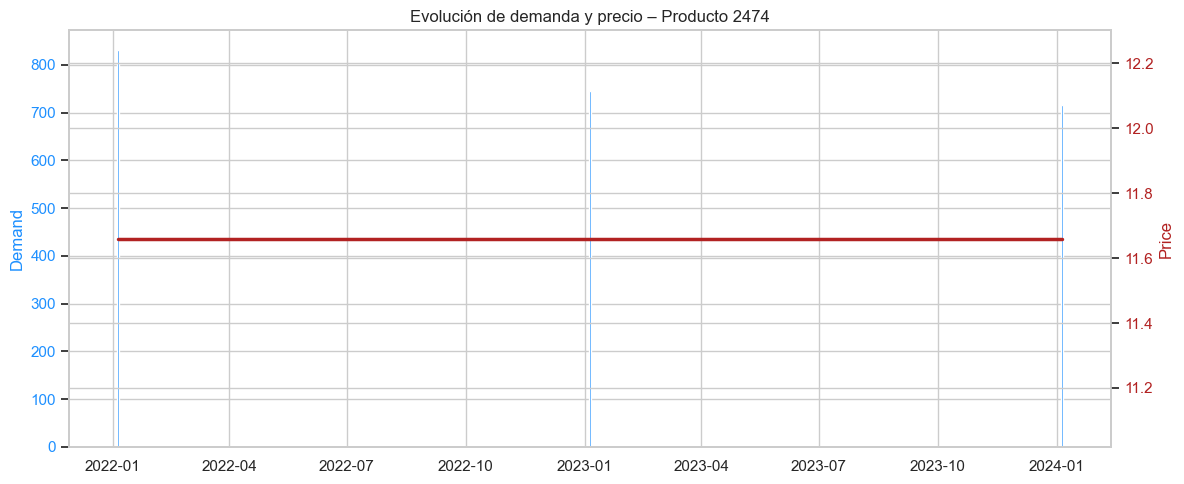

Gráfico guardado para producto 2474 en ../outputs/figures/outliers_media/producto_2474.png


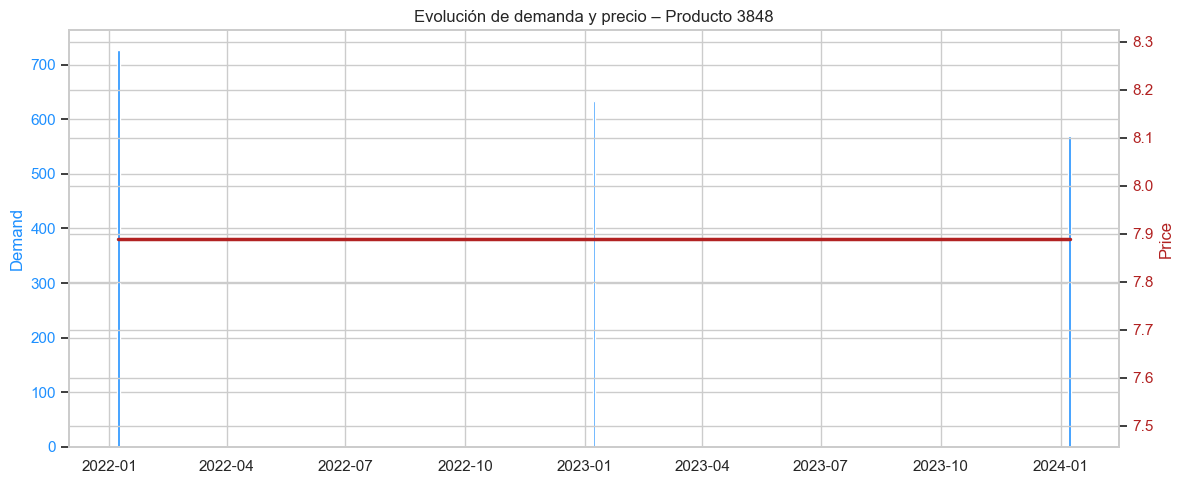

Gráfico guardado para producto 3848 en ../outputs/figures/outliers_media/producto_3848.png


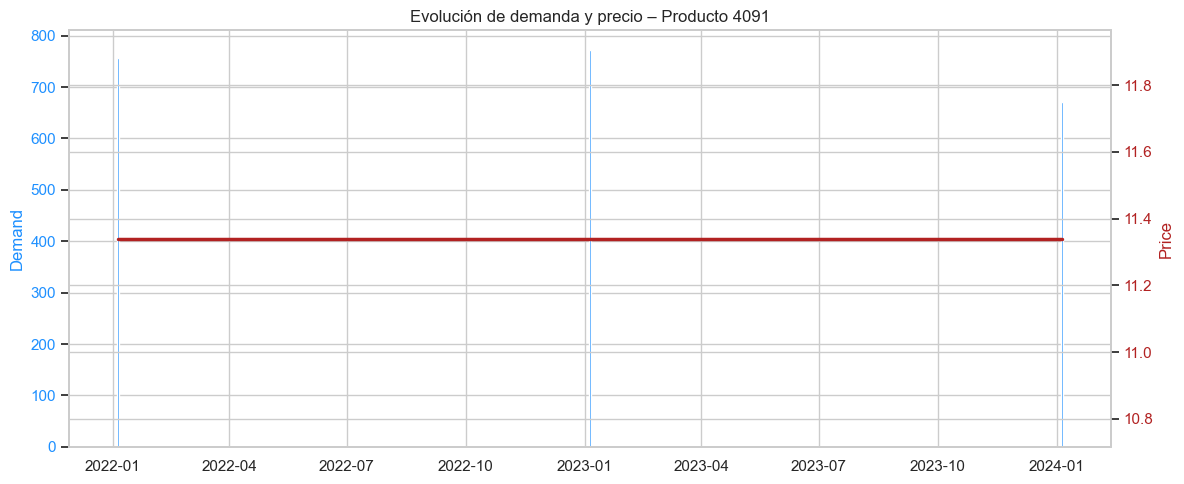

Gráfico guardado para producto 4091 en ../outputs/figures/outliers_media/producto_4091.png


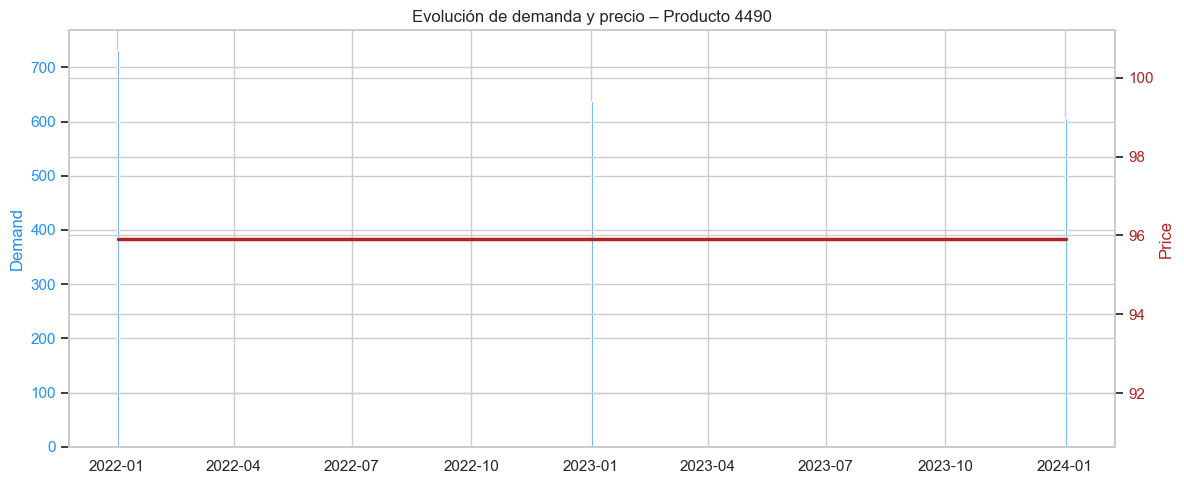

Gráfico guardado para producto 4490 en ../outputs/figures/outliers_media/producto_4490.png


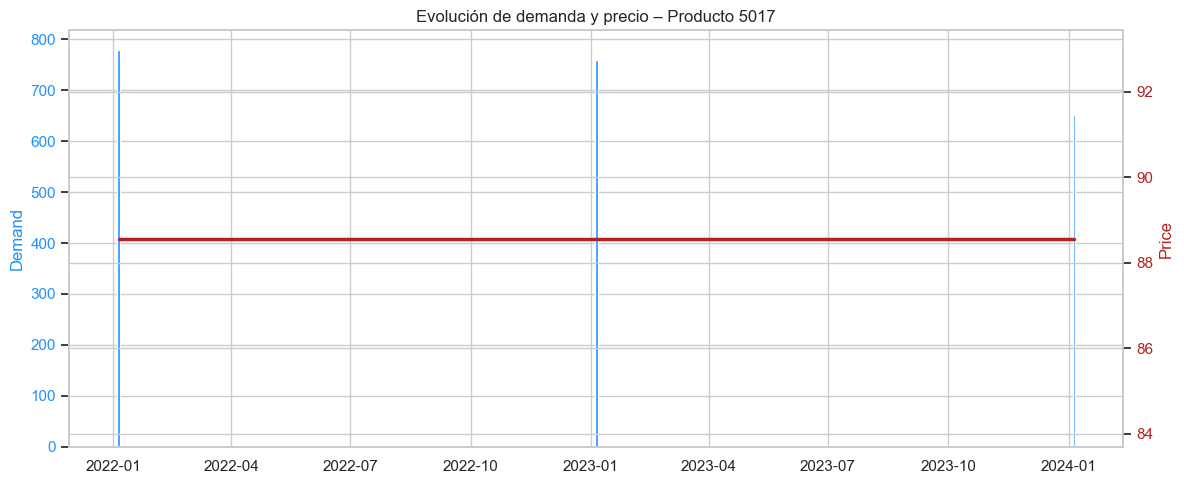

Gráfico guardado para producto 5017 en ../outputs/figures/outliers_media/producto_5017.png


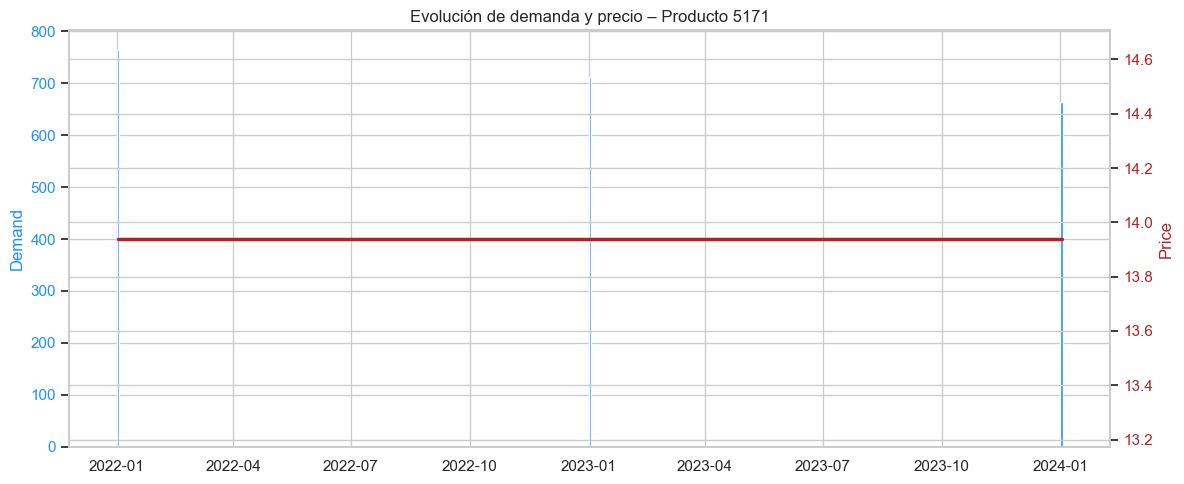

Gráfico guardado para producto 5171 en ../outputs/figures/outliers_media/producto_5171.png


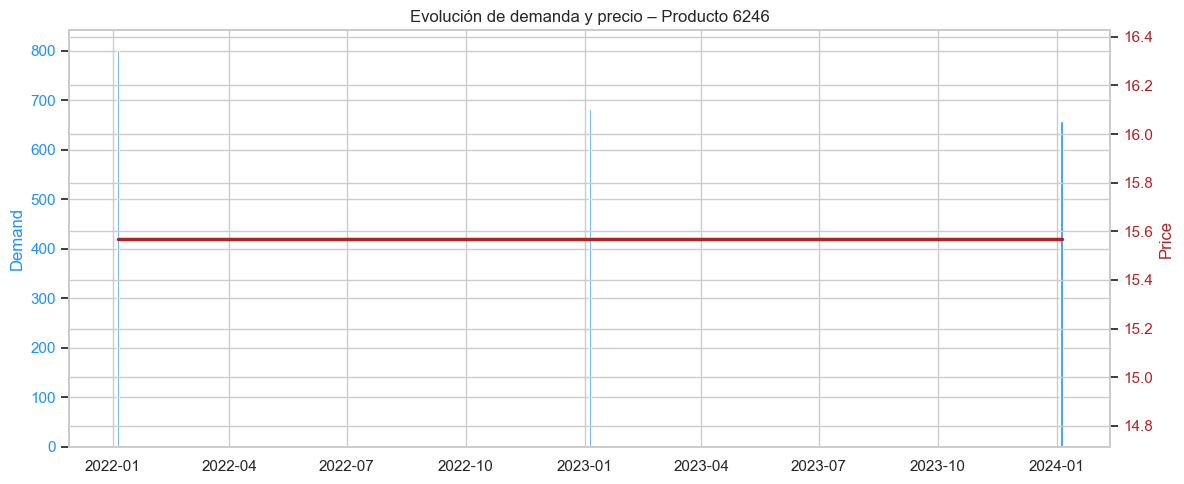

Gráfico guardado para producto 6246 en ../outputs/figures/outliers_media/producto_6246.png


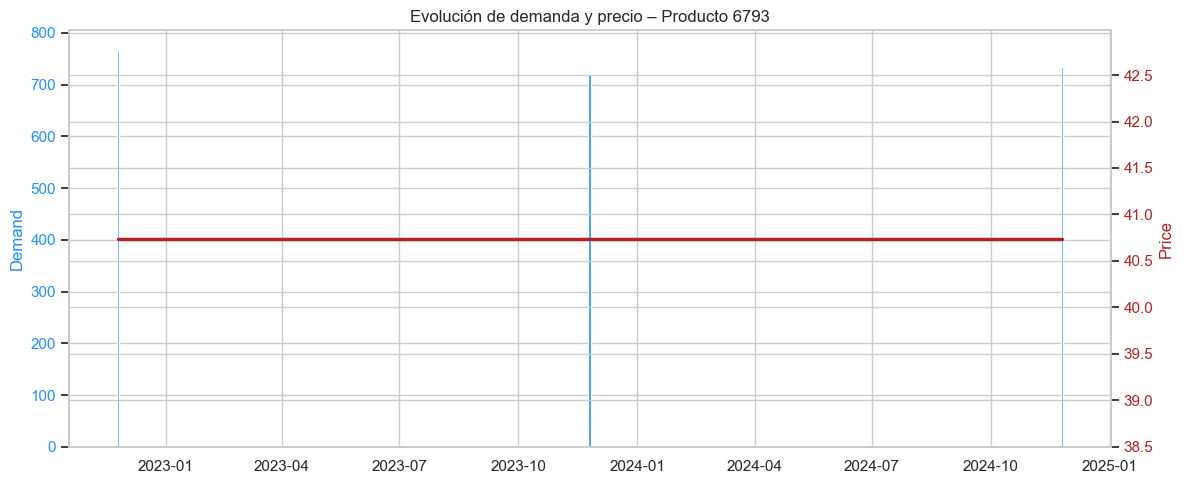

Gráfico guardado para producto 6793 en ../outputs/figures/outliers_media/producto_6793.png


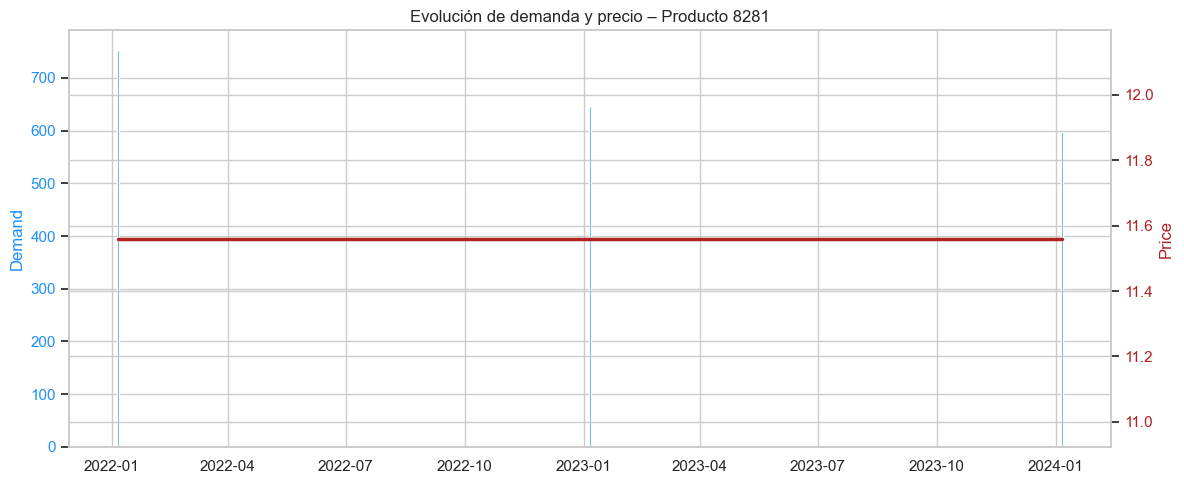

Gráfico guardado para producto 8281 en ../outputs/figures/outliers_media/producto_8281.png


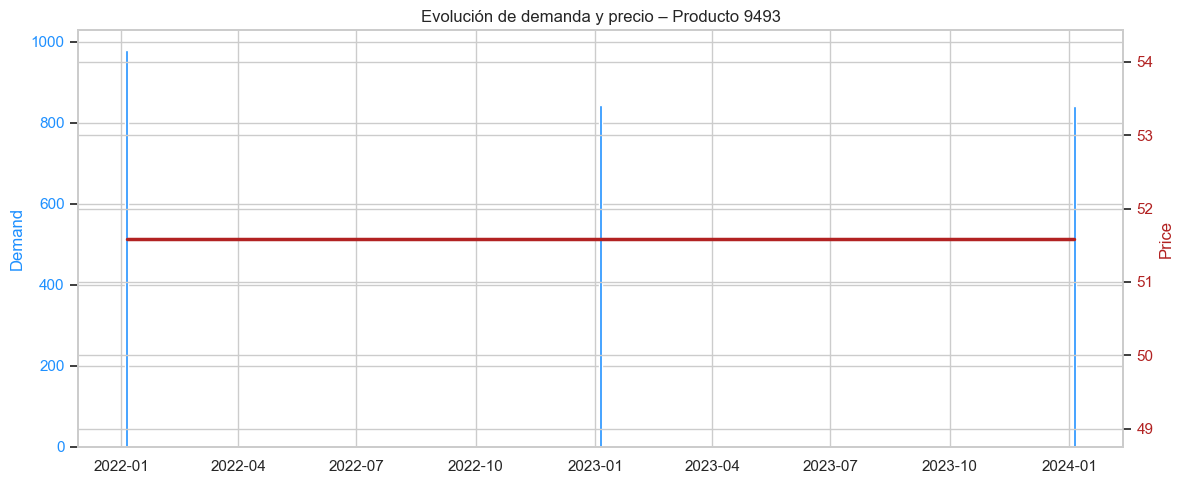

Gráfico guardado para producto 9493 en ../outputs/figures/outliers_media/producto_9493.png


In [72]:
# ____________________________________________
# 9. Filtrado y exportación de productos outliers por demanda media
# ____________________________________________

import os
import pandas as pd

# Cargar los datos diarios enriquecidos
df_diario = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Cargar el resumen con métricas y detección de outliers
df_outliers = pd.read_csv("../data/processed/resumen_outliers_demand.csv")

# Obtener los product_id que son outliers por demanda media
outliers_media = df_outliers[df_outliers["is_outlier_media"] == 1]["product_id"].tolist()

# Filtrar el dataset diario solo para esos productos
df_media_outliers = df_diario[df_diario["product_id"].isin(outliers_media)] 

# Guardar el dataset de productos outliers por media
ruta_guardado = "../data/processed/outliers_media.csv"
df_media_outliers.to_csv(ruta_guardado, index=False)

print(f"🔎 Total de productos exportados: {df_media_outliers['product_id'].nunique()}")
print(f"✅ Archivo guardado correctamente en: {ruta_guardado}")


# _______________________________________________________________________
### 9.1 Visualización individual de productos outliers por demanda media
# _________________________________________________________________________

# Cargar datos desde la ruta actual
df = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])
outliers = pd.read_csv("../data/processed/outliers_media.csv")

# Crear carpeta de salida
output_dir = "../outputs/figures/outliers_media"
os.makedirs(output_dir, exist_ok=True)


# Filtrar productos outliers
product_ids = outliers["product_id"].unique()

# Configurar estilo gráfico
sns.set(style="whitegrid")
plt.rcParams.update({"figure.figsize": (10, 5)})

# Generar gráficos
for product_id in product_ids:
    df_prod = df[df["product_id"] == product_id]
    df_prod = df_prod.sort_values("date")

    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.bar(df_prod["date"], df_prod["demand_final"], color="dodgerblue", alpha=1, width=2, label="Demand")
    ax1.set_ylabel("Demand", color="dodgerblue")
    ax1.tick_params(axis="y", labelcolor="dodgerblue")

    ax2 = ax1.twinx()
    ax2.plot(df_prod["date"], df_prod["price"], color="firebrick", linewidth=2.5, label="Price")
    ax2.set_ylabel("Price", color="firebrick")
    ax2.tick_params(axis="y", labelcolor="firebrick")

    # Marcar días con promociones
    if "promotions" in df_prod.columns:
        promo_dates = df_prod[df_prod["promotions"] == 1]["date"]
        for promo_date in promo_dates:
            ax1.axvline(promo_date, color="orange", linestyle="--", linewidth=0.8, alpha=0.6)

    # Guardar gráfico
    plt.title(f"Evolución de demanda y precio – Producto {product_id}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/producto_{product_id}.png")
    plt.show()
    print(f"Gráfico guardado para producto {product_id} en {output_dir}/producto_{product_id}.png")

Tras visualizar la evolución temporal de los productos identificados como outliers por su **demanda media diaria**, se pueden extraer las siguientes conclusiones generales:

- La mayoría de los productos muestran una **demanda sostenida y estable** a lo largo del tiempo, lo que confirma que su alta media no es resultado de picos puntuales, sino de una **alta rotación constante**.
- En algunos casos, la demanda coincide con **precios moderadamente bajos**, lo que refuerza su condición de **top ventas reales**.
- Las **promociones** no son el principal desencadenante de la demanda elevada en estos productos, aunque en ciertos casos pueden haber contribuido puntualmente a mantener niveles altos.

🟢 **Conclusión:** estos productos pueden considerarse **productos de alta rotación justificada**, cuyo comportamiento extremo está alineado con la lógica del modelo y el negocio. Por tanto:

- ✅ Se mantendrán en el dataset sin corrección.
- ✅ Se etiquetarán como **top ventas** para futuros análisis.
- 📌 Se incluirán en el sistema de alertas como productos clave cuya cobertura debe monitorizarse con especial atención.

**Caso especial: Producto 2775**

Este producto fue identificado como outlier por su **alta demanda media diaria (`media`)**. Sin embargo, su patrón temporal no se corresponde con una alta rotación constante, sino que presenta un comportamiento **muy concentrado en picos puntuales**:

- La **demanda (`demand_final`) presenta varios picos muy altos**, separados en el tiempo, mientras que el resto de los días tiene valores cercanos a cero.
- El **precio (`price`) varía de forma cíclica**, con una pendiente ascendente y descendente repetitiva, pero **sin una relación clara con los picos de demanda**.
- No se detectan **promociones activas**, lo que descarta el impacto de campañas.
- Este comportamiento puede elevar artificialmente la media y hacer que el producto sea identificado como outlier, **aunque no tenga una alta rotación real**.

**Conclusión preliminar**:
- Este producto presenta un **caso atípico de outlier por media**, motivado por picos muy marcados.
- Se recomienda **revisar si estos picos responden a factores reales del negocio**, y si no es así, marcarlo como producto con comportamiento espurio.

Este tipo de análisis es clave para distinguir entre **top ventas sostenidos** y **productos con demanda concentrada en pocos días** que distorsionan la estadística.



📌 **Decisión sobre producto 2775**

Este producto fue inicialmente clasificado como outlier por su demanda media, pero tras analizar su comportamiento temporal se ha descartado como top venta. Su patrón de picos aislados y ausencia de promociones sugiere un comportamiento espurio.

✅ Se excluye del conjunto de top ventas.

⚠️ Se marcará como producto con comportamiento anómalo para su revisión posterior y evitar distorsiones en el modelo.


---

🔧 **Función**: *****anadir_producto_anomalo(product_id, motivo, accion, observaciones)*****


In [65]:

# gestionar_productos_anomalos.py


import pandas as pd
import os

# Ruta de salida
ruta_archivo = "../data/processed/productos_anomalos.csv"

# Si el archivo existe, lo cargamos. Si no, creamos un DataFrame vacío.
if os.path.exists(ruta_archivo):
    df_anomalos = pd.read_csv(ruta_archivo)
else:
    df_anomalos = pd.DataFrame(columns=["Product_ID", "Motivo de exclusion", "Accion recomendada", "Observaciones"])

def anadir_producto_anomalo(product_id, motivo, accion, observaciones):
    global df_anomalos
    nuevo = {
        "Product_ID": product_id,
        "Motivo de exclusion": motivo,
        "Accion recomendada": accion,
        "Observaciones": observaciones
    }

    if not ((df_anomalos["Product_ID"] == product_id) & (df_anomalos["Motivo de exclusion"] == motivo)).any():
        df_anomalos = pd.concat([df_anomalos, pd.DataFrame([nuevo])], ignore_index=True)
    else:
        print(f"⚠️ El producto {product_id} ya está registrado con ese motivo.")

def guardar_lista_anomalos():
    df_anomalos.to_csv(ruta_archivo, index=False)
    print(f"✅ Lista de productos anómalos guardada en {ruta_archivo}")
    
if __name__ == "__main__":
    print("Lista actual de productos anómalos:")
    print(df_anomalos.head())


Lista actual de productos anómalos:
   Product_ID                                Motivo de exclusion  \
0        2775  Outlier por media con picos puntuales sin prom...   

                            Accion recomendada  \
0  Excluir de top ventas y marcar como anómalo   

                                       Observaciones  
0  Demanda concentrada en pocos días sin justific...  


Durante el análisis detallado de los productos con comportamiento extremo (outliers), es posible detectar casos atípicos que no se corresponden con productos top ventas reales, sino que presentan comportamientos espurios (como picos aislados o incoherencias sin justificación aparente).

Con el objetivo de documentar estos productos y evitar su impacto negativo en fases posteriores del modelo, se ha creado una función personalizada:

🔧 anadir_producto_anomalo(product_id, motivo, accion, observaciones)

Esta función permite registrar cualquier producto que se haya evaluado manualmente y que deba marcarse como anómalo. Los argumentos que requiere son:

product_id: identificador único del producto.

motivo: breve descripción del motivo de exclusión (por ejemplo, "picos puntuales sin promociones").

accion: decisión tomada (por ejemplo, "excluir del modelo", "revisar manualmente").

observaciones: detalles adicionales relevantes.

Cada vez que se ejecuta esta función, el producto se añade al archivo outputs/productos_anomalos.csv, que actúa como repositorio oficial de todos los casos documentados.

La lista se actualiza mediante:

💾 guardar_lista_anomalos()
Esta función guarda en disco todos los productos que se hayan añadido durante la sesión actual.

> **📌 Nota importante sobre el archivo `productos_anomalos.csv`:**
> 
> Todos los productos que hayan sido detectados como **comportamientos anómalos** durante el análisis (ya sea por media, desviación, p95, demanda total, máxima, etc.) deben estar registrados en el archivo `productos_anomalos.csv`.
> 
> Esto incluye tanto:
> - 🟥 **Productos que se ha decidido excluir directamente del modelo base**, como
> - 🟨 **Productos cuyo comportamiento ha sido marcado como anómalo pero aún están pendientes de una decisión final** (por ejemplo, porque podrían ser top ventas o requieren validación externa).
> 
> De esta forma, el archivo actúa como un **registro centralizado** que:
> - Garantiza la trazabilidad de todos los outliers evaluados.
> - Permite filtrar fácilmente por acción recomendada (`Excluir`, `Revisar`, etc.).
> - Evita repetir análisis visuales innecesarios.
> - Facilita la integración de reglas de negocio o sistemas de alerta en fases posteriores.

---

##### **6.1.2. Outliers por `desviación`.**



En este subapartado se analizan los productos que presentan **una alta desviación estándar en su demanda diaria (`demand_final`)**. Esta métrica es clave para identificar **comportamientos inestables o erráticos** que podrían afectar negativamente a la planificación de stock, ya que dificultan la estimación de la demanda futura.

📌 Los **objetivos** de este análisis son:
- Detectar productos con un patrón de demanda **altamente irregular o volátil**, que puedan comprometer la estabilidad del modelo.
- E**valuar si estas fluctuaciones tienen justificación **(por ejemplo, por campañas puntuales, cambios de precio o eventos externos).
- **Tomar decisiones informadas** sobre la necesidad de aplicar correcciones, exclusiones o tratamientos específicos en estos casos.

🔍 **Metodología**:

Dado el elevado número de productos con alta desviación estándar (177), no se generarán visualizaciones individuales para cada uno. En su lugar, se aplicará una **estrategia agrupada y representativa**, compuesta por tres fases:

1. **Visualización global**: distribución general de las desviaciones estándar entre los productos afectados, destacando los valores más extremos.

2. **Análisis por cuartiles:** los productos se agrupan según rangos de desviación. Se analiza estadísticamente su comportamiento mediante visualizaciones agregadas (boxplots, medias por grupo…).

3. **Selección representativa:** se seleccionan productos representativos de cada grupo (por ejemplo, el que presenta más días con demanda activa) para generar visualizaciones individuales completas que incluyan:

    - Serie temporal de demand_final.

    - Evolución del price.

    - Presencia de promotions.

Este enfoque permite mantener la capacidad de diagnóstico sin saturar el análisis visual, facilitando decisiones informadas sobre posibles ajustes o exclusiones en el modelo.

⚠️ **Recordatorio**:
En los casos en que se detecte un comportamiento incoherente o espurio, se deberá utilizar la función anadir_producto_anomalo() para registrar el producto en la lista de productos anómalos y excluirlo de futuras fases del modelo.


**Estrategia de análisis para productos outliers por desviación estándar**

Puesto que, como se ha indicado, se han identificado **177 productos con una desviación estándar anómala en su demanda diaria**, se propone una estrategia de análisis estructurada en tres fases, con el objetivo de mantener la interpretabilidad sin generar una visualización por cada producto.


✅ **1. Visualización global**.

**Objetivo:** obtener una visión agregada de los niveles de inestabilidad en los productos outliers.

- 📊 **Gráfico de barras ordenado**: representación de `product_id` vs. `desviacion` en orden descendente.
- 🔥 **Top 10 por desviación**: generación de gráficos individuales para los 10 productos con mayor desviación estándar.
- 🟨 En caso de valores extremadamente altos, se puede aplicar una escala logarítmica para mejorar la legibilidad.


✅ **2. Análisis por cuartiles de desviación**.

**Objetivo:** identificar posibles patrones o comportamientos diferenciados según el nivel de desviación.

- Dividir los productos en **cuartiles** en función de su desviación estándar.
- Para cada cuartil:
  - Calcular estadísticos básicos como media de demanda, días con demanda, etc.
  - Generar **boxplots comparativos** para visualizar su dispersión.

Esto permite detectar si los productos más inestables presentan características diferenciadas o se comportan de forma homogénea.


✅ 3. **Revisión manual de productos representativos**.

**Objetivo:** analizar ejemplos concretos sin saturar el análisis con 177 gráficas individuales.

- Seleccionar **1 a 2 productos por cuartil** como representativos:
  - Ejemplo: el producto con más días con demanda ≠ 0 en cada grupo.
- Generar gráficos individuales que incluyan:
  - Evolución de la demanda (`demand_final`)
  - Precio (`price`)
  - Promociones si están disponibles (`promotions`)

Esto facilita una revisión visual útil sin sobrecargar el análisis.

🔹 Total de productos outliers por desviación: 177
✅ Archivo guardado en: ../data/processed/outliers_desviacion.csv


C:\Users\Javier\AppData\Local\Temp\ipykernel_19908\3653025923.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="indice", y="desviacion", data=resumen_outliers_sorted, palette="Blues_d")


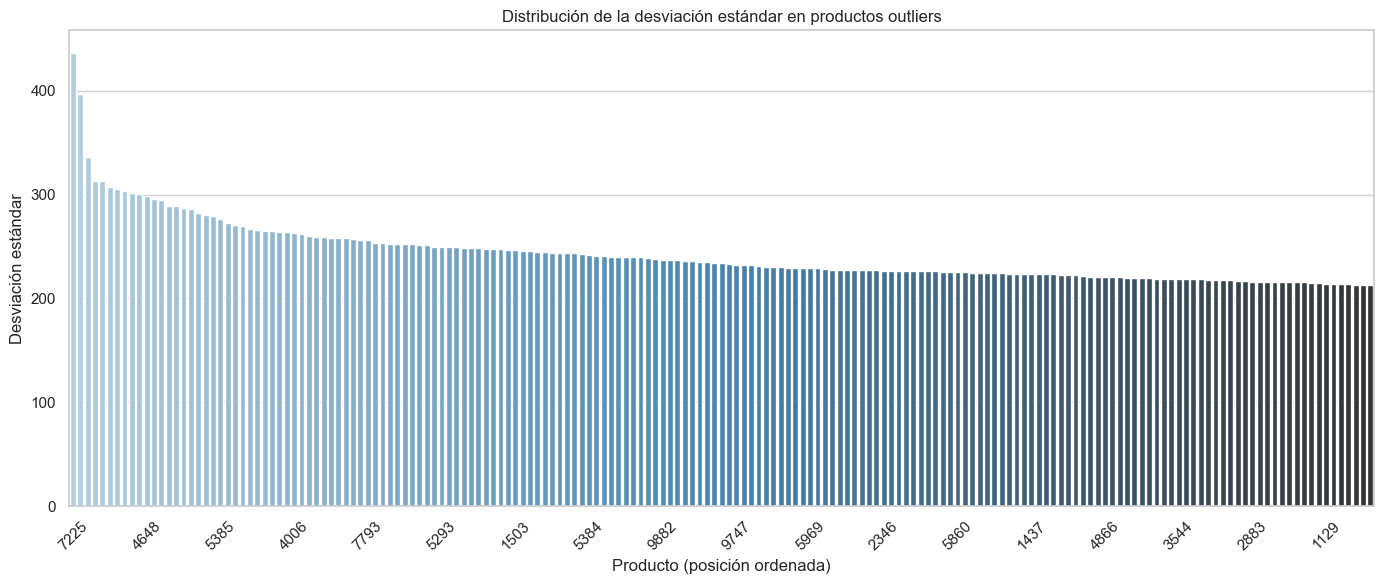

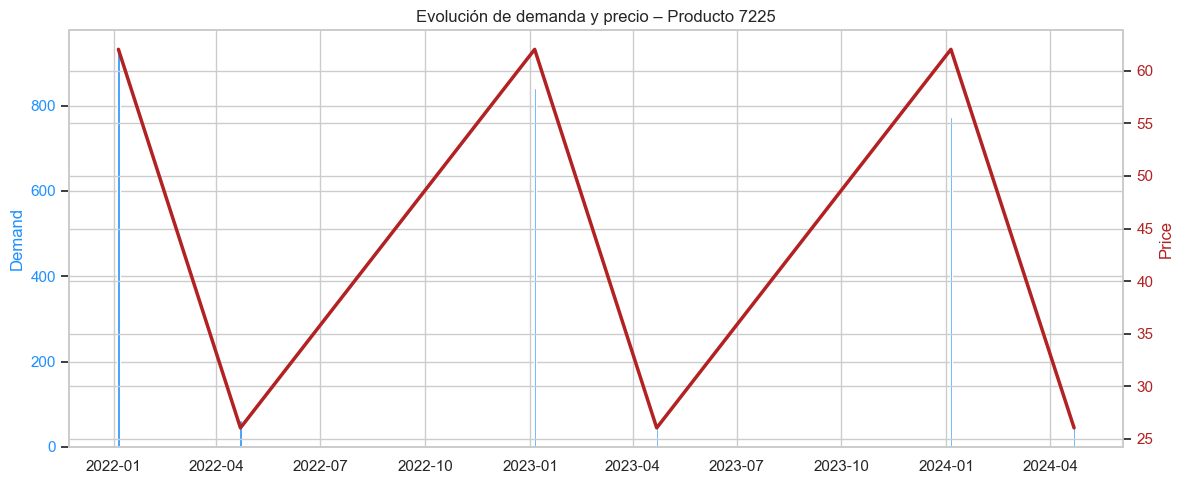

✅ Gráfico guardado para producto 7225 (top10)


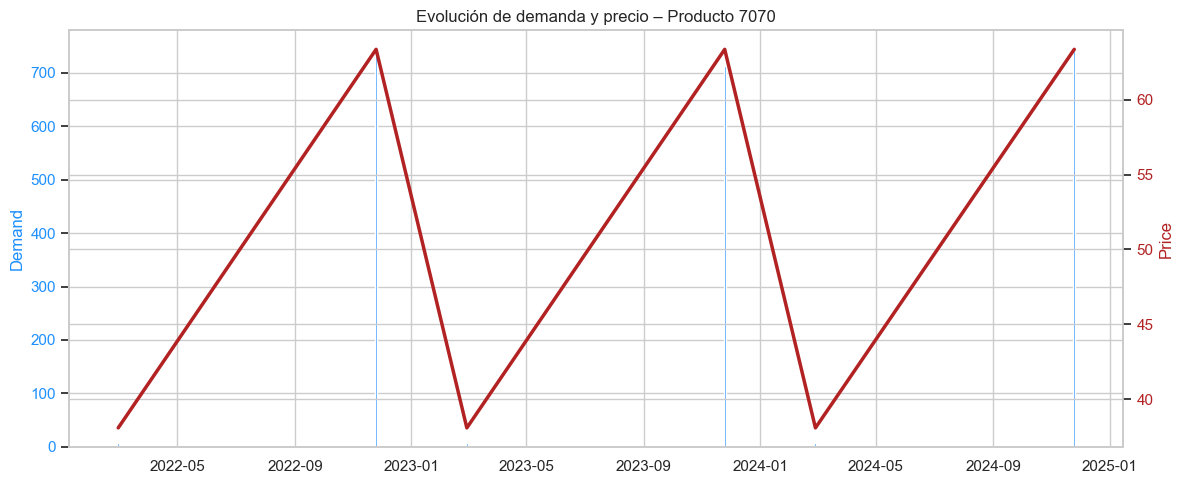

✅ Gráfico guardado para producto 7070 (top10)


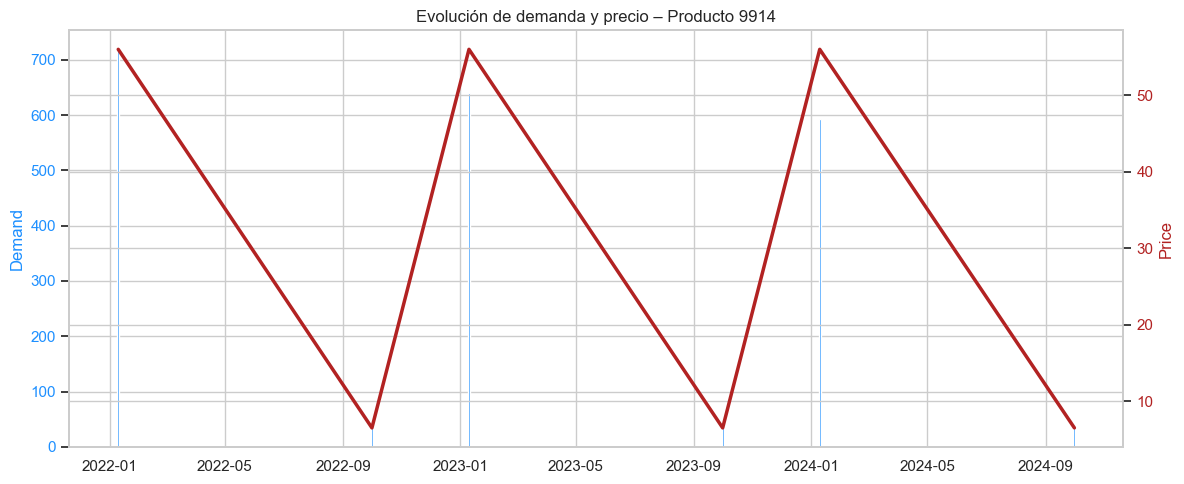

✅ Gráfico guardado para producto 9914 (top10)


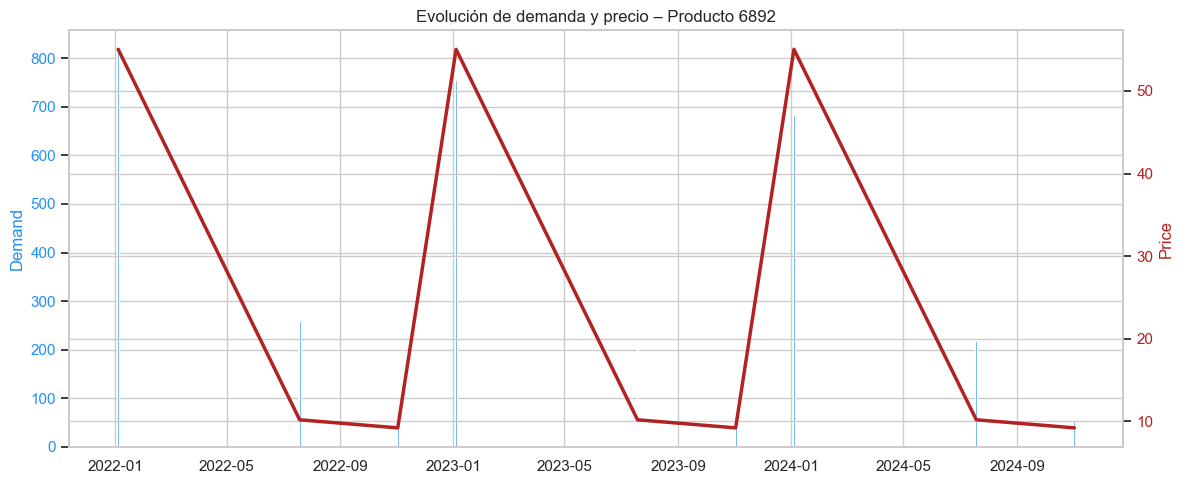

✅ Gráfico guardado para producto 6892 (top10)


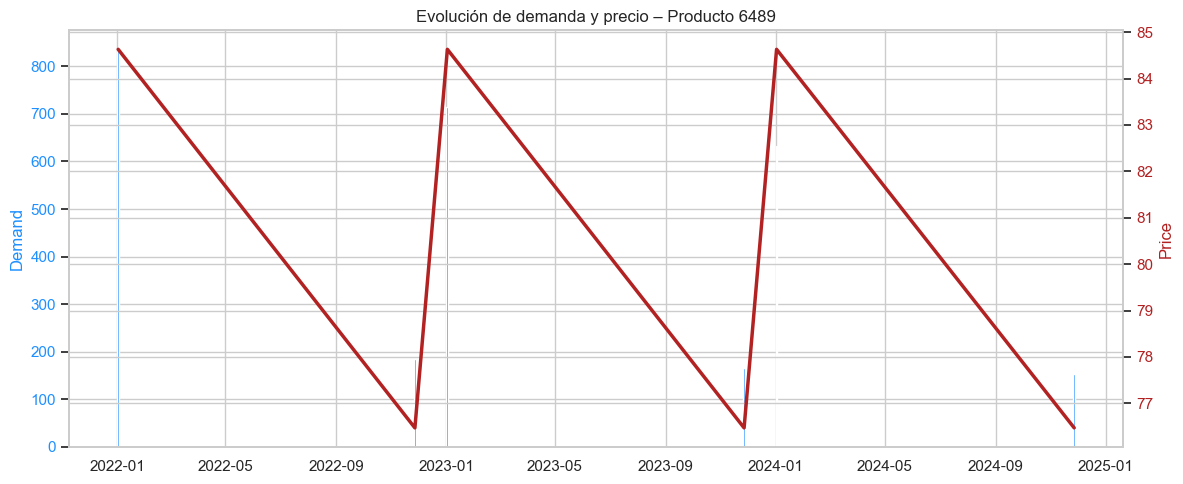

✅ Gráfico guardado para producto 6489 (top10)


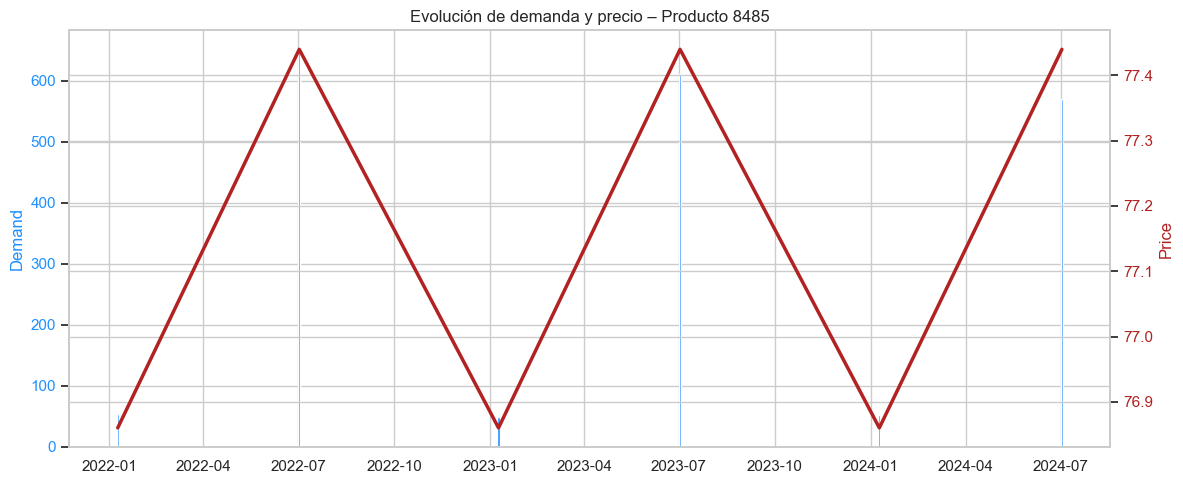

✅ Gráfico guardado para producto 8485 (top10)


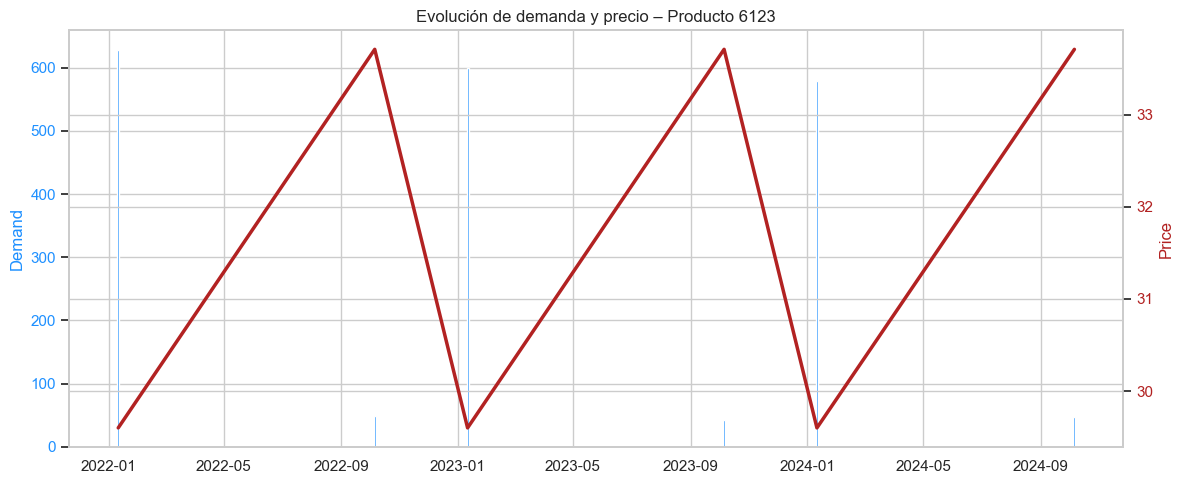

✅ Gráfico guardado para producto 6123 (top10)


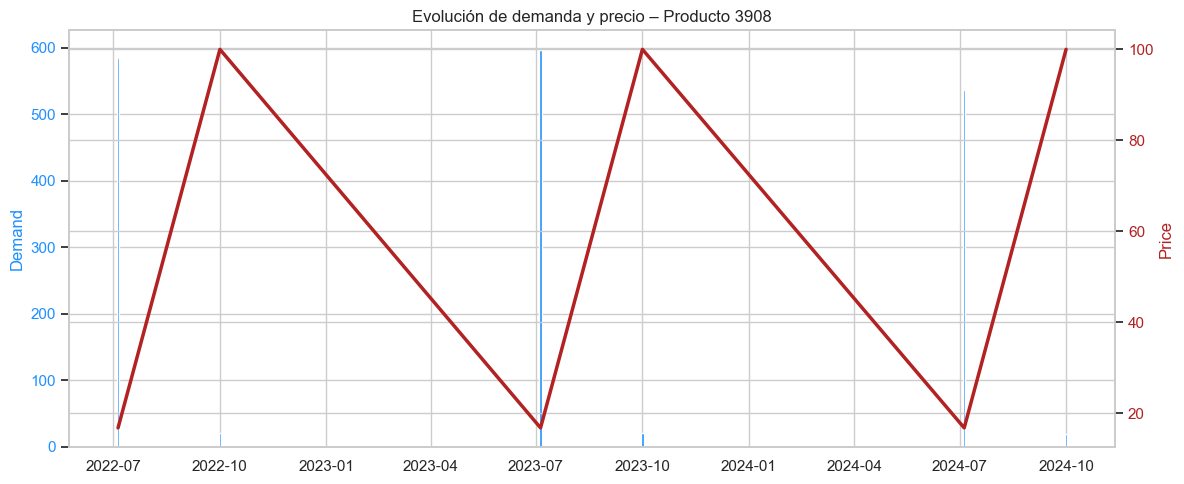

✅ Gráfico guardado para producto 3908 (top10)


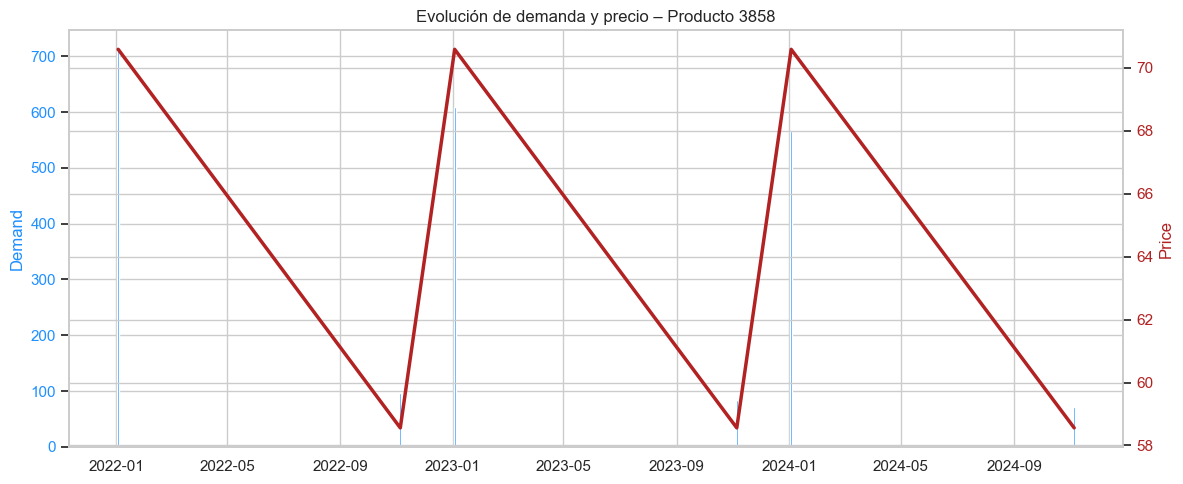

✅ Gráfico guardado para producto 3858 (top10)


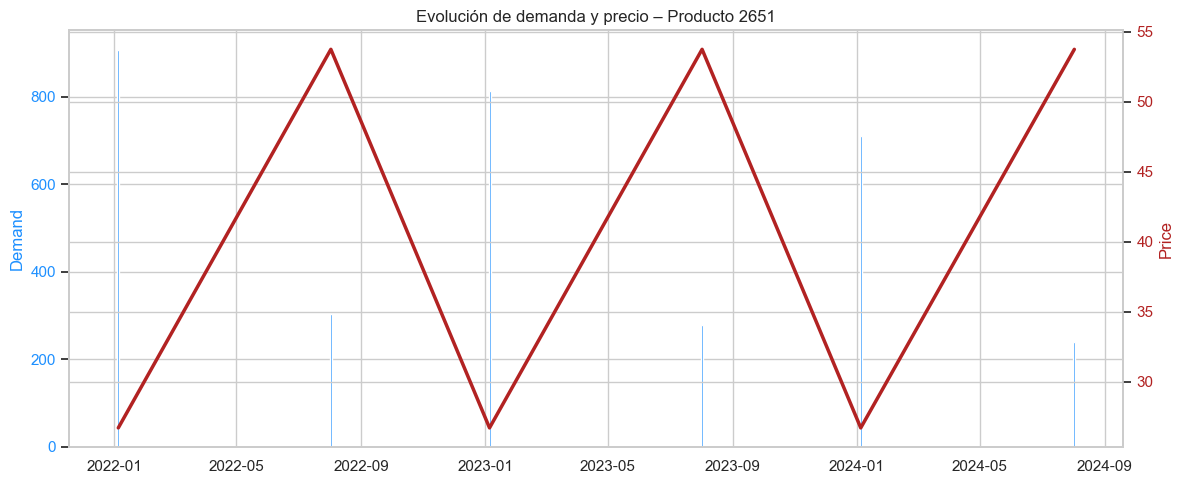

✅ Gráfico guardado para producto 2651 (top10)
✅ Gráfico guardado para producto 4648 (resto)
✅ Gráfico guardado para producto 1839 (resto)
✅ Gráfico guardado para producto 4156 (resto)
✅ Gráfico guardado para producto 4356 (resto)
✅ Gráfico guardado para producto 1954 (resto)
✅ Gráfico guardado para producto 7382 (resto)
✅ Gráfico guardado para producto 8342 (resto)
✅ Gráfico guardado para producto 8410 (resto)
✅ Gráfico guardado para producto 1929 (resto)
✅ Gráfico guardado para producto 2335 (resto)
✅ Gráfico guardado para producto 5385 (resto)
✅ Gráfico guardado para producto 1508 (resto)
✅ Gráfico guardado para producto 2573 (resto)
✅ Gráfico guardado para producto 6989 (resto)
✅ Gráfico guardado para producto 9389 (resto)
✅ Gráfico guardado para producto 1620 (resto)
✅ Gráfico guardado para producto 8057 (resto)
✅ Gráfico guardado para producto 3823 (resto)
✅ Gráfico guardado para producto 5785 (resto)
✅ Gráfico guardado para producto 8272 (resto)
✅ Gráfico guardado para producto 4

In [74]:
# 1. Visualización global

# Cargar dataset diario completo
df_diario = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])
resumen = pd.read_csv("../data/processed/resumen_outliers_demand.csv")

# Calcular umbral de outlier si no existe la columna
if "is_outlier_desviacion" not in resumen.columns:
    Q1 = resumen["desviacion"].quantile(0.25)
    Q3 = resumen["desviacion"].quantile(0.75)
    IQR = Q3 - Q1
    limite_desviacion = Q3 + 1.5 * IQR
    resumen["is_outlier_desviacion"] = (resumen["desviacion"] > limite_desviacion).astype(int)

# Filtrar y guardar
product_ids_desv = resumen[resumen["is_outlier_desviacion"] == 1]["product_id"].unique()
df_outliers_desv = df_diario[df_diario["product_id"].isin(product_ids_desv)]

ruta_guardado = "../data/processed/outliers_desviacion.csv"
df_outliers_desv.to_csv(ruta_guardado, index=False)

print(f"🔹 Total de productos outliers por desviación: {len(product_ids_desv)}")
print(f"✅ Archivo guardado en: {ruta_guardado}")

# ____________________________________________
# 10.1 Visualización global y top 10 de productos outliers por desviación
# ____________________________________________

import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datasets
df_outliers_desv = pd.read_csv("../data/processed/outliers_desviacion.csv", parse_dates=["date"])
df_resumen = pd.read_csv("../data/processed/resumen_outliers_demand.csv")

# Crear carpeta de salida
output_dir = "../outputs/figures/outliers_desviacion"
os.makedirs(output_dir, exist_ok=True)

# Filtrar y ordenar
resumen_outliers = df_resumen[df_resumen["is_outlier_desviacion"] == 1].copy()
resumen_outliers_sorted = resumen_outliers.sort_values("desviacion", ascending=False)
resumen_outliers_sorted["indice"] = range(1, len(resumen_outliers_sorted) + 1)

# ─────────────────────────────────────────────
# 🎯 Gráfico de barras de distribución
plt.figure(figsize=(14, 6))
sns.barplot(x="indice", y="desviacion", data=resumen_outliers_sorted, palette="Blues_d")
plt.title("Distribución de la desviación estándar en productos outliers")
plt.xlabel("Producto (posición ordenada)")
plt.ylabel("Desviación estándar")
tick_positions = range(0, len(resumen_outliers_sorted), 10)
tick_labels = resumen_outliers_sorted["product_id"].iloc[tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.tight_layout()
plt.savefig(f"{output_dir}/desviacion_barras_ordenadas.png")
plt.show()

# ─────────────────────────────────────────────
# 🔝 Top 10 + resto
top10_ids = resumen_outliers_sorted.head(10)["product_id"].tolist()
otros_ids = resumen_outliers_sorted["product_id"].tolist()[10:]

# Función auxiliar
def graficar_producto(df, product_id, carpeta, sufijo, mostrar=False):
    df_prod = df[df["product_id"] == product_id].sort_values("date")
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.bar(df_prod["date"], df_prod["demand_final"], color="dodgerblue", alpha=1, width=2)
    ax1.set_ylabel("Demand", color="dodgerblue")
    ax1.tick_params(axis="y", labelcolor="dodgerblue")

    ax2 = ax1.twinx()
    ax2.plot(df_prod["date"], df_prod["price"], color="firebrick", linewidth=2.5)
    ax2.set_ylabel("Price", color="firebrick")
    ax2.tick_params(axis="y", labelcolor="firebrick")

    if "promotions" in df_prod.columns:
        promo_dates = df_prod[df_prod["promotions"] == 1]["date"]
        for promo_date in promo_dates:
            ax1.axvline(promo_date, color="orange", linestyle="--", linewidth=0.8, alpha=0.6)

    plt.title(f"Evolución de demanda y precio – Producto {product_id}")
    plt.tight_layout()
    ruta = f"{carpeta}/producto_{product_id}_{sufijo}.png"
    plt.savefig(ruta)
    if mostrar:
        plt.show()
    plt.close()
    print(f"✅ Gráfico guardado para producto {product_id} ({sufijo})")

# ─────────────────────────────────────────────
# 🔹 Generar top 10
for pid in top10_ids:
    graficar_producto(df_outliers_desv, pid, output_dir, "top10", mostrar=True)

# 🔹 Generar resto sin mostrar
for pid in otros_ids:
    graficar_producto(df_outliers_desv, pid, output_dir, "resto", mostrar=False)


📊 **GRÁFICA: Distribución de la desviación estándar en productos outliers.**

- **Interpretación general**: 

    - Cada una de las barras corresponde a un producto identificado como valor atípico por alta deviación estándar en su demanda diaria (`demand_final`).
    - El eje Y muestra la desviación estándar (cuanto más alta, más variabilidad tiene el producto).
    - El eje X representa productos ordenados de mayor a menor dispersión.

- **Observaciones clave**:

    - Desviación muy alta en pocos productos:
        - El primer grupo de productos (por ejemplo, 7225, 4648, 5385) presenta valores muy altos de dispersión, con desviaciones por encima de 300 y hasta 400+ unidades.
        - Son casos extremos y deben analizarse individualmente para descartar errores o patrones artificiales.

    - Pendiente descendente gradual:
        - Después del top ~10, las barras descienden de forma más suave y progresiva, lo que indica que hay muchos productos con dispersión alta, pero no exagerada.
        - Esto sugiere una zona gris donde conviene revisar manualmente si la variabilidad está justificada o si distorsiona el modelo.

    - Grupo final con menor dispersión relativa:

        - Aunque todos son outliers (superan el umbral IQR), los últimos productos tienen desviaciones mucho más moderadas (alrededor de 200).
        - Muchos de estos pueden mantener cierta regularidad pese a estar fuera del rango típico, y podrían mantenerse tras validación.

📊 **GRÁFICAS INDIVIDUALES.**

-  **Análisis del Producto 7225**

    - **Desviación estándar**: superior a 400 → la más alta del conjunto.

    - **Coincide con otras métricas de outlier**:

        ✅ is_outlier_media → Sí

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar

👉 Esto lo convierte en un **caso grave de inestabilidad** por aparecer en al menos 2 métricas críticas.

- **Comportamiento visual (según la gráfica):**
    - Picos de demanda extremadamente altos en los primeros días de cada año, con el resto del año sin demanda.
    - Estos picos no parecen seguir patrones de promoción ni precio, y no hay señal de eventos especiales.
    - El precio presenta un patrón triangular regular ascendente y descendente, pero la demanda no reacciona a estos cambios, lo que descarta efecto precio claro.

- **¿Se justifica la variabilidad?**

No, su comportamiento sugiere una distribución artificial o errónea. Parece un producto con ventas muy concentradas en un único evento, sin continuidad. No hay soporte en promociones ni en estacionalidad aparente. 

- **Decisión**:

☑️ Marcar como anómalo severo.

☑️ Excluir del modelo base de demanda.

⬜ (Opcional) Ajustar manualmente si se desea incluir en sistemas de recomendación específicos.



El producto 7225 presenta un patrón altamente inestable. Aparece como outlier por media y desviación, y la demanda se concentra en pocos días al año, sin relación con precio ni promociones. Esto puede indicar errores en la simulación o una estrategia promocional mal representada en los datos.



-  **Análisis del Producto 7070**

    - **Desviación estándar**: alta (rango top 10), con ciclos bien definidos y picos pronunciados.

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar

👉  Solo figura como outlier por desviación, lo que sugiere **variabilidad sin grandes acumulados**.

- **Comportamiento visual (según la gráfica):**
    - Se aprecian claramente tres ciclos anuales bien estructurados:
        - Comienza en valores cercanos a 0.
        - Crece de forma casi lineal hasta un pico de 750 unidades.
        - Retorna a niveles mínimos antes de repetir el ciclo.



- **¿Se justifica la variabilidad?**

Sí, la variabilidad está justificada por un patrón cíclico repetido y no parece un error del dataset. Aunque la demanda cae bruscamente, lo hace siempre tras alcanzar su punto máximo, con un patrón muy definido. No hay promociones asociadas, y el comportamiento es consistente en los tres años simulados.

- **Decisión**:

☑️ Revisar manualmente si este patrón se repite en otros productos similares

☑️ Marcar como anómalo (si se considera artificial o distorsionante).

☑️ (Opcional) Tratar como producto con patrón cíclico periódico.

☑️ Excluir del modelo base solo si se demuestra que no representa una tendencia real.



El producto 7070 mantiene un comportamiento cíclico predecible, con tres repeticiones claras del mismo patrón anual. Aunque no es errático, la amplitud extrema entre mínimos y máximos genera una alta desviación estándar. Se recomienda documentarlo como caso especial por su comportamiento sistemático y analizar si puede trasladarse a productos similares o segmentarse en el modelado.

-  **Análisis del Producto 9914**

    - **Desviación estándar**: muy alta (rango top 10), con una amplitud extrema y comportamiento simétrico.

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar

- Solo figura como outlier por desviación. El patrón es demasiado regular para otros criterios, pero altamente disperso.

- **Comportamiento visual (según la gráfica):**
    - Se repite un patrón triangular perfecto cada año:
        - Comienza con valores máximos (700+ unidades).
        - Desciende de forma continua hasta 0.
        - Vuelve a subir bruscamente al inicio del siguiente ciclo.
        
   


- **¿Se justifica la variabilidad?**

Sí, pero el patrón es tan perfecto y artificial que es muy probable que se trate de un comportamiento simulado para testeo de ciclos descendentes. Aunque no hay picos aleatorios ni errores aparentes, el contraste entre el mínimo y el máximo genera una desviación altísima, aunque predecible. No hay eventos ni promociones visibles que lo justifiquen.

- **Decisión**:

☑️ Revisar manualmente si este patrón descendente se repite en otros productos.

☑️ Marcar como anómalo (posible patrón artificial).

☑️ (Opcional) Tratar como producto con patrón decreciente cíclico.

⬜ Excluir del modelo base solo si se demuestra que no representa una tendencia real.


El producto 9914 presenta un comportamiento extremadamente regular de descenso continuo anual, repitiéndose idénticamente en tres ocasiones. La estructura perfecta sugiere generación simulada, más que un reflejo del comportamiento real de mercado. Es útil como patrón de validación del modelo, pero se recomienda etiquetarlo como caso especial.


-  **Análisis del Producto 6892**

    - **Desviación estándar**: muy alta (rango top 10), con picos puntuales extremadamente elevados.

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar

    - Solo figura como outliers por desviación. La magnitud de los picos frente al resto del año (demanda casi nula) provoca gran dispersión. 


- **Comportamiento visual (según la gráfica):**
    - Patrón repetido durante 3 años consecutivos:
        - Pico de demanda >800 unidades en enero.
        - Resto del año con demanda casi nula o inexistente.
        - El precio muestra una caída lineal tras el pico, repitiéndose cíclicamente.

   

- **¿Se justifica la variabilidad?**

Sí, aunque la demanda fuera del primer mes es prácticamente inexistente, el patrón se repite con exactitud en enero de cada año, lo que sugiere un evento puntual muy concentrado (lanzamiento, renovación, campaña anual).
No parece un error, pero es un comportamiento altamente atípico y concentrado en un único periodo del año.


- **Decisión**:

☑️ Revisar manualmente si este comportamiento puntual se repite en otros productos.

☑️ Marcar como anómalo (por concentración extrema de la demanda).

☑️ (Opcional) Tratar como producto con patrón de venta anual exclusivo.

☑️ Excluir del modelo base solo si se demuestra que no representa una tendencia sostenible.

El producto 6892 presenta una demanda extremadamente puntual, concentrada en un solo mes al año y sin continuidad en los siguientes. Aunque el patrón se repite, la variabilidad en el resto del año es nula, por lo que debe tratarse con especial cuidado para no distorsionar modelos de predicción agregada.

-  **Análisis del Producto 6489**

    - **Desviación estándar**: muy elevada (rango top 10), con picos marcados y comportamiento discontinuo.

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar

    - Figura exclusivamente como outlier por desviación, lo que sugiere grandes diferencias de volumen entre periodos.


- **Comportamiento visual (según la gráfica):**
    - La demanda presenta picos superiores a 800 unidades a principios de 2022, 2023 y 2024.

    - El resto del año muestra demanda casi nula o inexistente.

    - El patrón de precios muestra una caída lineal regular durante el año, sincronizado con el comportamiento cíclico de la demanda.

- **¿Se justifica la variabilidad?**

Sí. Se trata de un patrón recurrente de alta concentración en enero con posterior caída, repetido durante tres años consecutivos.
No se observan promociones en el gráfico, pero el comportamiento es altamente sistemático, probablemente debido a eventos de lanzamiento, renovación o campañas puntuales anuales.

- **Decisión**:

☑️ Revisar manualmente si este comportamiento puntual se repite en otros productos.

☑️ Marcar como anómalo (por dispersión concentrada y escasa continuidad).

☑️ (Opcional) Tratar como producto con patrón cíclico anual definido.

☑️ Excluir del modelo base solo si se demuestra que no representa una tendencia real.


El producto 6489 manifiesta una demanda cíclica muy marcada, con picos alineados a comienzos de cada año. A pesar de la consistencia, su comportamiento podría distorsionar las métricas globales del modelo si no se trata por separado como patrón especial.

-  **Análisis del Producto 8485**

    - **Desviación estándar**: alta, top 10 en el ranking de outliers por dispersión

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar



- **Comportamiento visual (según la gráfica):**
    - La demanda presenta un patrón cíclico con picos intensos y constantes cada año (≈ 650 unidades).
    - Los picos aparecen en momentos muy concretos y aislados del año (julio), el resto del tiempo hay demanda prácticamente nula.
    - El precio se mantiene muy estable entre 76.8 y 77.5, sin oscilaciones ni relación clara con los picos de demanda.
    - No se observan efectos de promociones ni estacionalidad clara asociada (más allá de la repetición temporal exacta).
   

- **¿Se justifica la variabilidad?**

No del todo. Aunque el patrón es repetido y podría parecer una campaña, la forma exacta y la ausencia de variación de precio o promoción sugiere comportamiento simulado o poco natural. Que ocurra exactamente una vez al año con gran magnitud y sin ningún otro cambio contextual puede indicar que fue programado así, sin que haya una causa real detrás.


- **Decisión**:

☑️ Marcar como anómalo moderado.

☑️ Revisar si otros productos comparten esta misma forma rígida cíclica sin justificación externa.

⬜ Excluir completamente solo si el patrón se considera distorsionante.

☑️ Documentar como patrón "pico fijo anual sin causa externa"



El producto 8485 muestra picos de demanda idénticos una vez al año, en un entorno de precio completamente plano y sin promociones. La falta de variabilidad de contexto sugiere un patrón simulado más que un comportamiento real. Aunque no es erróneo, sí podría distorsionar los cálculos agregados o el aprendizaje de estacionalidad si no se controla.

-  **Análisis del Producto 6123**

    - **Desviación estándar**: alta (top 10), por la presencia de picos anuales fuertes.

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar



- **Comportamiento visual (según la gráfica):**
    - La demanda muestra tres picos principales (uno por año) de más de 600 unidades.
    - Cada pico está precedido y seguido por demanda cercana a cero o nula.
    - El precio crece gradualmente cada año, en una subida constante, sin oscilaciones ni bajadas.
    - Las promociones parecen dispersas, sin coincidir claramente con los picos.
   

- **¿Se justifica la variabilidad?**

Solo parcialmente:
    - La desviación está causada por la alta concentración de demanda en un solo día cada año.
    - Aunque el patrón se repite, su conexión con el precio no es clara (no hay reacción real).
    - La regularidad del pico + linealidad del precio sugieren que podría tratarse de un patrón simulado.

- **Decisión**:

☑️ Clasificar como patrón cíclico con picos anuales rígidos.

☑️ Documentar como comportamiento probablemente artificial.

⬜ Excluir solo si se demuestra que distorsiona métricas agregadas.

⬜ Marcar como anómalo grave (por ahora no es necesario).


El producto 6123 presenta un patrón de picos anuales de demanda, mientras el precio sigue un crecimiento lineal. La falta de relación entre ambos, junto a la repetitividad exacta del comportamiento, sugiere una posible simulación programada. Puede mantenerse si se considera representativo, pero se recomienda documentarlo como caso estructurado no sensible al precio.

-  **Análisis del Producto 3908**

    - **Desviación estándar**: muy elevada (rango top 10), debido a alternancia extrema entre picos altos y demanda nula.

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar

    - Solo figura como outliers por desviación, lo que refleja variabilidad sin continuidad estable. 


- **Comportamiento visual (según la gráfica):**
    - La demanda sube de forma abrupta a más de 700 unidades una vez al año (enero) y se desploma a valores próximos a cero el resto del tiempo.

    - La forma del ciclo es completamente simétrica y repetida durante tres años consecutivos.

    - El precio decrece de forma lineal y estable año tras año, sin aparente impacto directo sobre la demanda.

- **¿Se justifica la variabilidad?**

 Sí, pero con matices. El patrón sugiere una simulación programada o una estacionalidad artificial extrema. La demanda se concentra en un único pico anual, mientras que el resto del año se mantiene en niveles nulos. Esto eleva la desviación sin acumular grandes volúmenes totales.

- **Decisión**:

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por dispersión forzada).

☑️ (Opcional) Tratar como producto con patrón cíclico de alta estacionalidad.

☑️ Excluir del modelo base solo si se demuestra que no representa una tendencia real.



El producto 3908 presenta un patrón cíclico anual de pico único muy marcado, lo que sugiere más una estrategia de lanzamiento programado o comportamiento simulado. Aunque visualmente coherente, puede influir negativamente en el modelo si no se trata por separado.



-  **Análisis del Producto 3858**

    - **Desviación estándar**: alta (top 10), por el gran contraste entre picos y demanda nula.

    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar



- **Comportamiento visual (según la gráfica):**
    - Patrón triangular perfecto cada año:
        - Alta demanda en enero (~700).
        - Luego descenso progresivo hasta casi 0.
       
    - El precio sigue un patrón inverso al de la demanda: baja desde el máximo (≈71) hasta ≈58 conforme avanza el año.

    - No hay promociones asociadas a los picos.
   

- **¿Se justifica la variabilidad?**

 Sí, aunque el patrón es demasiado perfecto:
    - La demanda y el precio disminuyen de forma paralela, por lo que estaríamos ante una relación directa: a menor precio, también menor demanda.
    - La estructura anual se repite con mucha precisión, pero sigue siendo un patrón coherente si se interpreta como simulación de ciclo de campaña.

- **Decisión**:

☑️ Conservar como ejemplo de relación directa (precio–demanda).

☑️ Documentar como patrón cíclico predecible válido.

⬜ Marcar como anómalo (no necesario).

⬜ Excluir del modelo.



El producto 3858 muestra un patrón triangular regular en el que tanto el precio como la demanda disminuyen de forma paralela a lo largo del año, repitiéndose el ciclo anualmente. Esto indica una relación directa, no la inversa clásica, ya que cuando baja el precio también lo hace la demanda. Aunque esta relación no es habitual en productos sensibles al precio, puede tener sentido si se interpreta como un comportamiento de campaña de lanzamiento fuerte al inicio del año, seguido de una pérdida progresiva de interés.

El patrón es coherente y repetido, por lo que se puede mantener como válido, documentándolo como un ejemplo de producto con valor percibido decreciente a lo largo del tiempo.

-  **Análisis del Producto 2651**

    - **Desviación estándar**: muy elevada (rango top 10), generada por una alternancia muy marcada entre picos de demanda extremos y valores cercanos a cero.


    - **Coincide con otras métricas de outlier**:

        ❌ is_outlier_media: No

        ⬜ is_outlier_total → por revisar

        ⬜ is_outlier_maximo → por revisar

        ⬜ is_outlier_p95 → por revisar

    - Solo figura como outlier por desviación, lo que sugiere variabilidad sin acumulación significativa.

- **Comportamiento visual (según la gráfica):**
    - El producto muestra un comportamiento cíclico muy regular:

      - La demanda crece de forma lineal hasta un pico por encima de las 900 unidades.

      - Luego cae bruscamente a valores mínimos (~20–50 unidades).

    - Este patrón se repite de forma idéntica en tres ocasiones, a intervalos regulares.
   
    - Hay picos de demanda sin relación clara con el precio ni con promociones.

    - El precio crece en paralelo al ciclo, pero con menos oscilación relativa, manteniendo una pendiente continua.



- **¿Se justifica la variabilidad?**

  El patrón es altamente simulado o artificial. No hay ruido ni dispersión errática, sino un comportamiento perfectamente repetido, lo que reduce la posibilidad de que refleje una dinámica de mercado real. La falta de variación entre ciclos y el control del precio refuerzan esta hipótesis.




- **Decisión**:

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

☑️ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

☑️ Excluir del modelo base solo si se demuestra que no representa una tendencia real.


El producto 2651 muestra un patrón de crecimiento y colapso idéntico año tras año, sin variación entre ciclos. Esto sugiere una simulación planificada más que una respuesta real del mercado. Si bien no hay evidencia de error, su inclusión en el modelo debe ser cuidadosamente evaluada para evitar distorsiones.

**Extensión de decisiones al resto de productos**

Los productos analizados individualmente en este bloque representan los **10 casos más extremos** en términos de desviación estándar. Al revisarlos de forma detallada, se ha identificado una serie de **patrones comunes**:

- Comportamientos artificiales sin justificación (picos aislados)
- Patrones cíclicos coherentes (relanzamientos anuales)
- Relación directa o inversa entre precio y demanda
- Estrategias simuladas de pricing y rotación de inventario

Dado que estos 10 productos cubren una variedad representativa de situaciones, se considera válido **extender las decisiones tomadas a los productos no analizados individualmente pero que presentan patrones equivalentes**.

Esto permite:

- **Reducir la carga de revisión** sin perder rigor.
- **Clasificar el resto de productos** en función de su similitud con los casos ya revisados.
- **Aplicar acciones coherentes** (exclusión, etiquetado o conservación) a gran escala, manteniendo la trazabilidad de criterios.

En consecuencia, los productos que compartan el mismo patrón de comportamiento que alguno de los revisados, **recibirán el mismo tratamiento que su caso representativo**.

### 📊 Tabla resumen – Agrupación de productos outliers por desviación estándar

| Producto representativo | Tipo de patrón                                                        | Productos similares                                                                                                                     | Decisión aplicada                                                   |
|-------------------------|------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------|
| 7225                    | Estacional + comportamiento errático en picos                         | 6892, 6489, 1508, 2121, 2294, 2513, 2538, 2573, 2642, 2755                                                                               | Anómalos                        |
| 7070                    | Pico puntual sin justificación clara                                   | 1453, 1457, 1503, 1663, 1665, 1666, 1835, 2013, 2032, 2202, 2222, 2224, 2257, 2346, 2405, 2417, 2450, 2474, 2504                         | Anómalos.                                                |
| 9114                    | Alta variabilidad justificada por estrategia de precios agresiva       | 1177, 1222, 1232, 1248, 1253, 1305, 1313, 1321, 1437, 1564, 1589, 1593, 1620, 1717, 1839, 1929, 1932, 1954, 2015, 2118, 2191             | Conservar. Útil para representar comportamiento promocional        |
| 3858                    | Relación inversa clara (precio bajo impulsa picos de demanda)          | 1090, 1116, 1129, 1150, 1163, 1181, 1225, 2335, 2356, 2363                                                                               | Conservar como ejemplo de patrón sensible a precio                 |
| 3908                    | Variabilidad no estructurada                                           | 1014, 1062, 1075, 1413, 1486, 2747, 2749                                                          | Anómalos.                    |
| 2651                    | Simulación errónea (patrón errático no representativo ni natural)      | 1008, 1027, 1044                                                                                                                        | Anómalos.


In [ ]:
# _______________________________________________________________________
 # 10.2 Guardar producto anómalo. 
 # ________________________________________________________________________

# Lista de productos a registrar como anómalos
productos_desviacion_grupo7225 = [7225, 6892,6489, 1508, 2121, 2294, 2513, 2538, 2573, 2642, 2755]
productos_desviacion_grupo7070 = [7070,1453, 1457, 1503, 1663, 1665, 1666, 1835, 2013, 2032, 2202, 2222, 2224, 2257, 2346, 2405, 2417, 2450, 2474, 2504]
productos_desviacion_grupo3908 = [3908,1014, 1062, 1075, 1413, 1486, 2747, 2749]
productos_desviacion_grupo2651 = [2651,1008, 1027, 1044]

# Añadir productos con justificación
for pid in productos_desviacion_grupo7225:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Estacional + comportamiento errático en picos",
        accion="Excluir del modelo base",
        observaciones="Comportamiento sugiere una distribución artificial o errónea. Parece un producto con ventas muy concentradas en un único evento, sin continuidad."
    )

for pid in productos_desviacion_grupo7070:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Pico puntual sin justificación clara",
        accion="Excluir del modelo base",
        observaciones="Amplitud extrema entre mínimos y máximos genera una alta desviación estándar. Se recomienda documentarlo como caso especial por su comportamiento sistemático."
    )

for pid in productos_desviacion_grupo3908:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Variabilidad no estructurada",
        accion="Excluir del modelo base",
        observaciones="El patrón sugiere una simulación programada o una estacionalidad artificial extrema. La demanda se concentra en un único pico anual, mientras que el resto del año se mantiene en niveles nulos. Esto eleva la desviación sin acumular grandes volúmenes totales."
    )

for pid in productos_desviacion_grupo2651:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Simulación errónea (patrón errático no representativo ni natural)",
        accion="Excluir del modelo base",
        observaciones="Simulación planificada más que una respuesta real del mercado. Si bien no hay evidencia de error, su inclusión en el modelo debe ser cuidadosamente evaluada para evitar distorsiones."
    )
# Guardar cambios en archivo CSV
guardar_lista_anomalos()


⚠️ El producto 6892 ya está registrado con ese motivo.
⚠️ El producto 6489 ya está registrado con ese motivo.
⚠️ El producto 1508 ya está registrado con ese motivo.
⚠️ El producto 2121 ya está registrado con ese motivo.
⚠️ El producto 2294 ya está registrado con ese motivo.
⚠️ El producto 2513 ya está registrado con ese motivo.
⚠️ El producto 2538 ya está registrado con ese motivo.
⚠️ El producto 2573 ya está registrado con ese motivo.
⚠️ El producto 2642 ya está registrado con ese motivo.
⚠️ El producto 2755 ya está registrado con ese motivo.
⚠️ El producto 1453 ya está registrado con ese motivo.
⚠️ El producto 1457 ya está registrado con ese motivo.
⚠️ El producto 1503 ya está registrado con ese motivo.
⚠️ El producto 1663 ya está registrado con ese motivo.
⚠️ El producto 1665 ya está registrado con ese motivo.
⚠️ El producto 1666 ya está registrado con ese motivo.
⚠️ El producto 1835 ya está registrado con ese motivo.
⚠️ El producto 2013 ya está registrado con ese motivo.
⚠️ El prod

##### **6.1.3. Outliers por `p95`.**

En este subapartado se analizan los productos cuya demanda diaria presenta un valor inusualmente elevado en su percentil 95 (`p95`). Este indicador representa el nivel de demanda que solo se supera en el 5% de los días con ventas, por lo que un valor extremo puede indicar **comportamientos anómalos o picos injustificados** que no se reflejan en la media.

📌 Los objetivos de este análisis son:
- Detectar productos con **picos de demanda muy elevados** que podrían distorsionar la planificación.
- Evaluar si esos picos son **esperables** (ej. por promociones o efecto estacional) o si carecen de justificación.
- Tomar decisiones como **exclusión, suavizado o conservación del producto** según el caso.

Se han detectado un total de **9 productos** con valores extremos en su percentil 95. Debido al volumen reducido, se analizarán de forma individual mediante gráficas de evolución de demanda y precio, tal como se hizo para los outliers por media.

🔎 Total de productos outliers por p95: 9
✅ Archivo guardado como 'outliers_p95.csv'


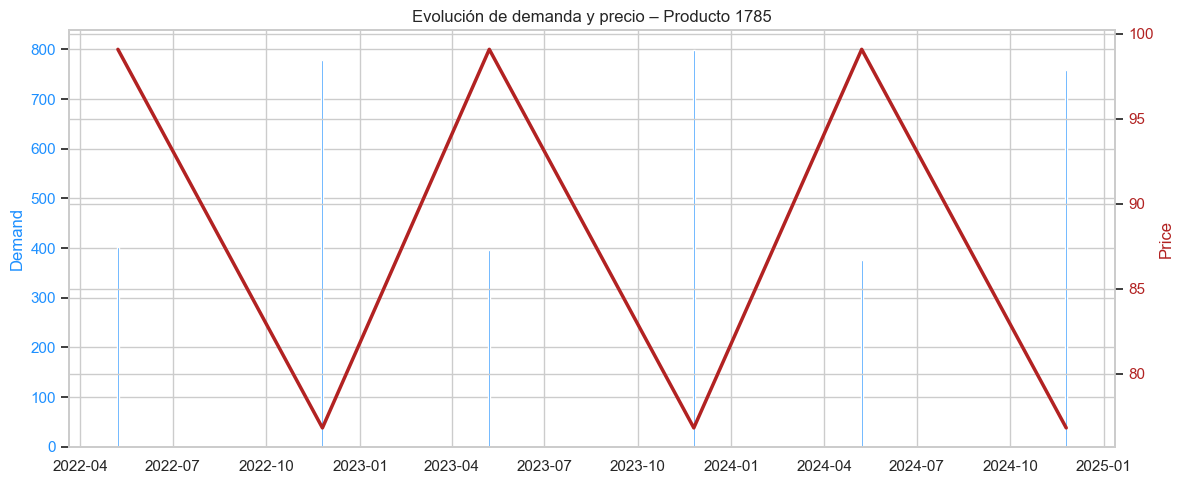

✅ Gráfico guardado para producto 1785


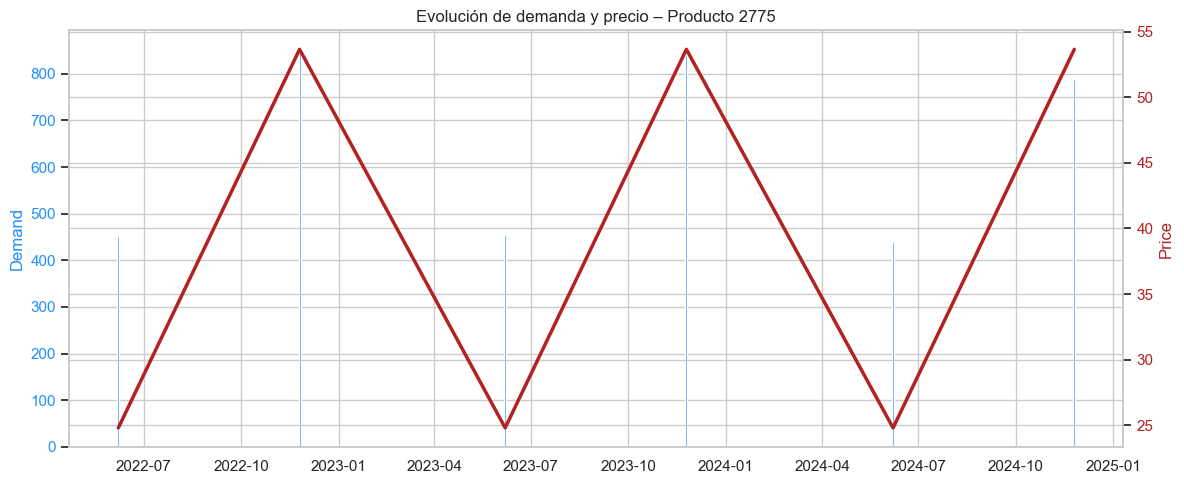

✅ Gráfico guardado para producto 2775


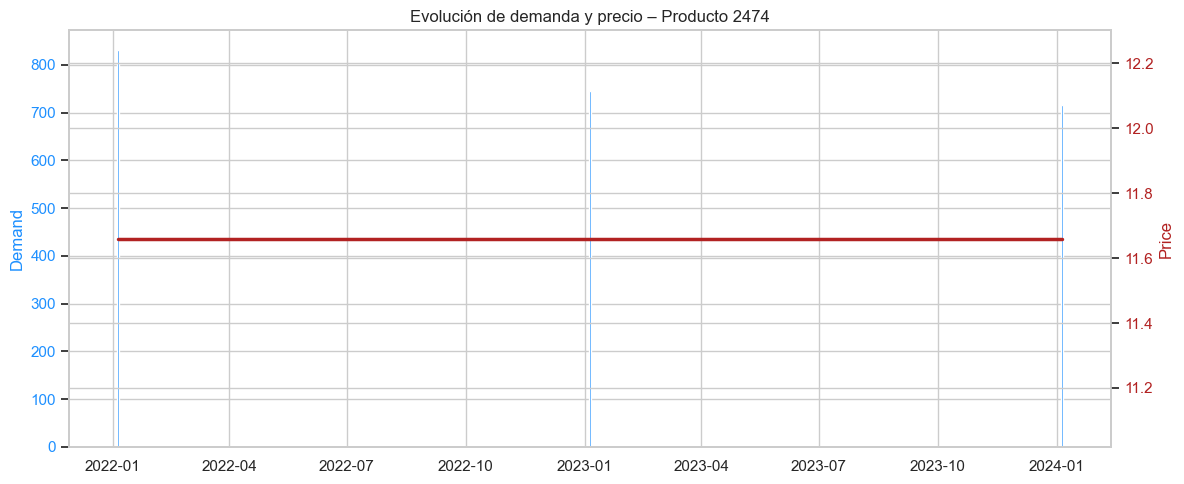

✅ Gráfico guardado para producto 2474


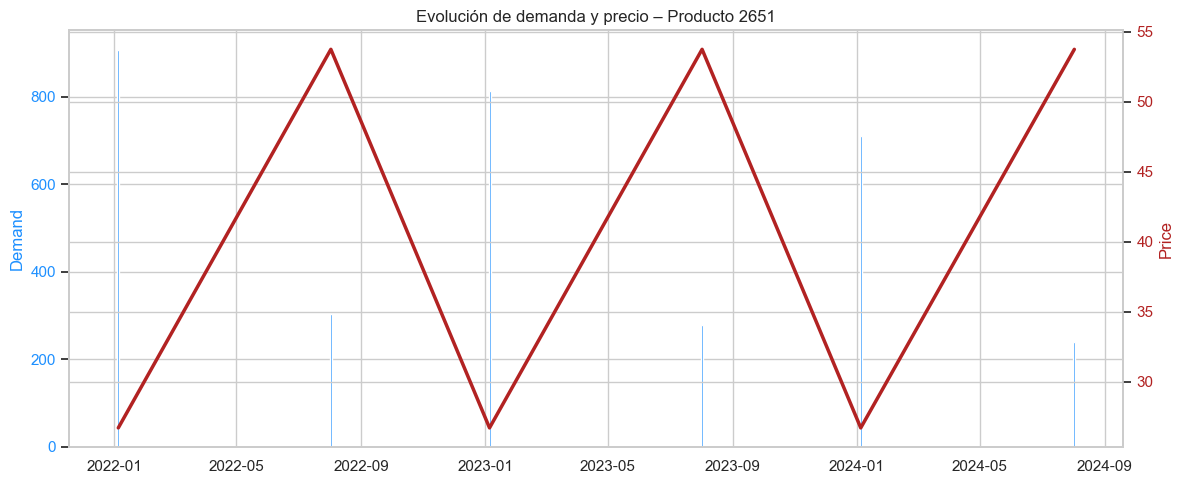

✅ Gráfico guardado para producto 2651


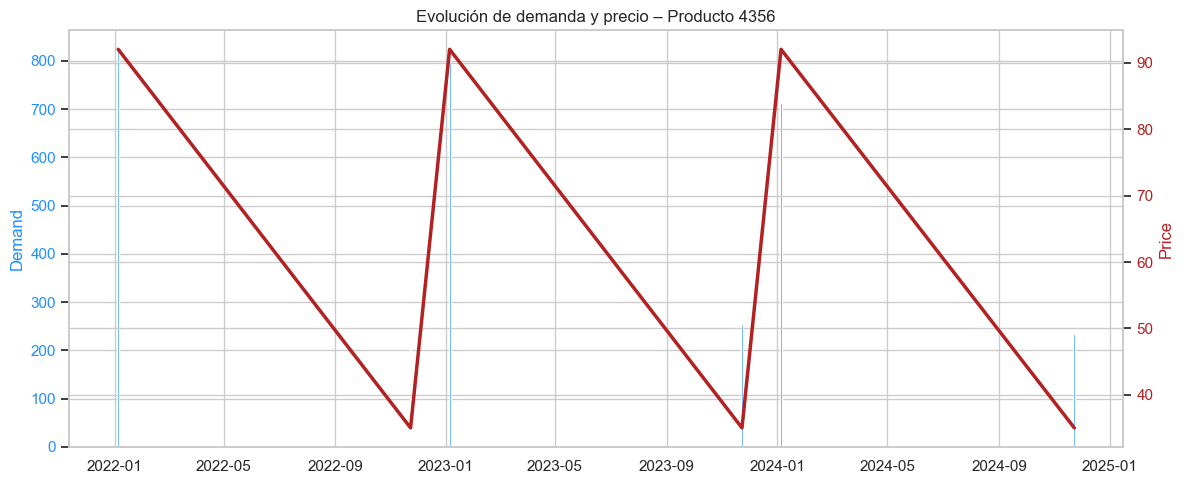

✅ Gráfico guardado para producto 4356


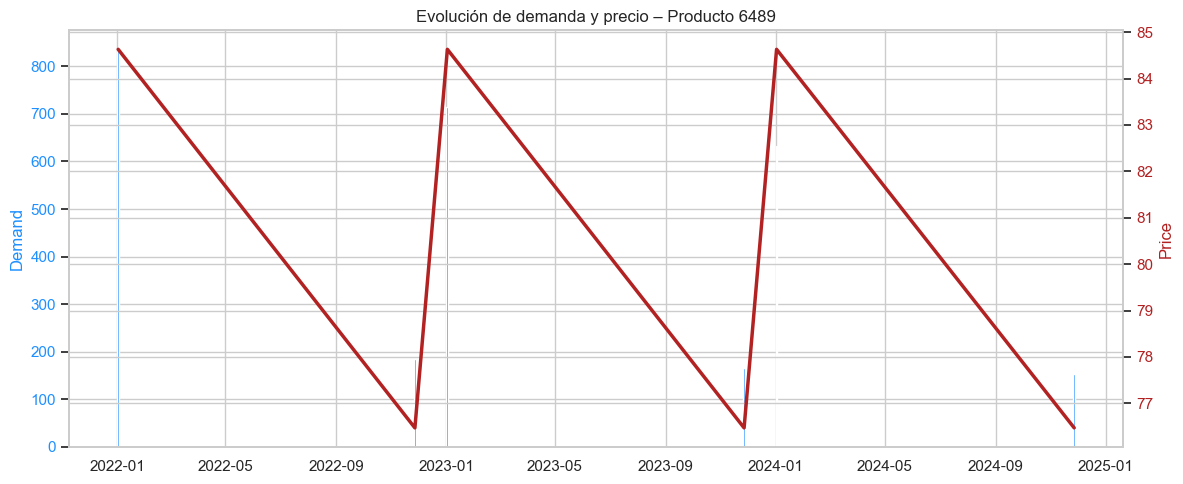

✅ Gráfico guardado para producto 6489


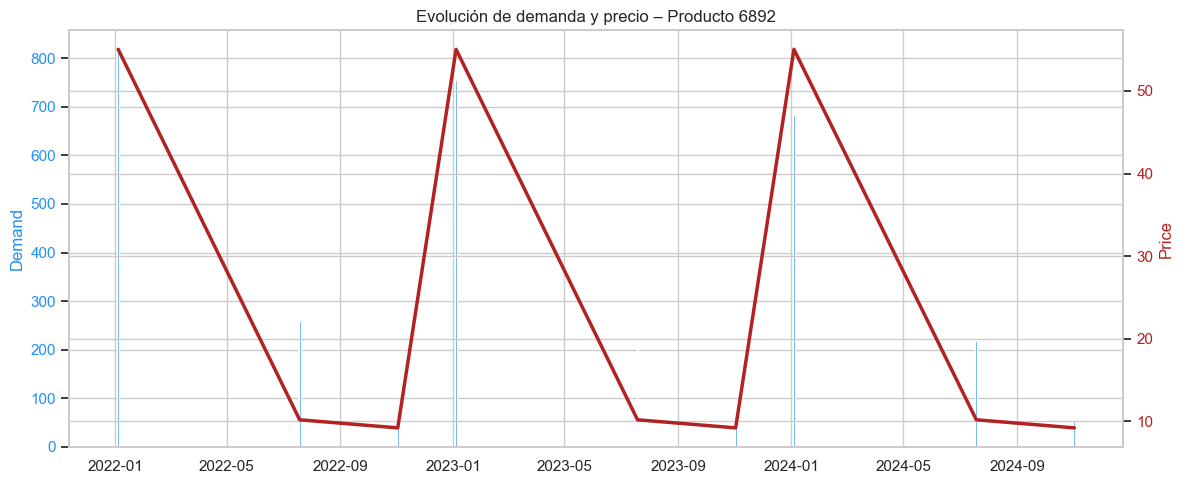

✅ Gráfico guardado para producto 6892


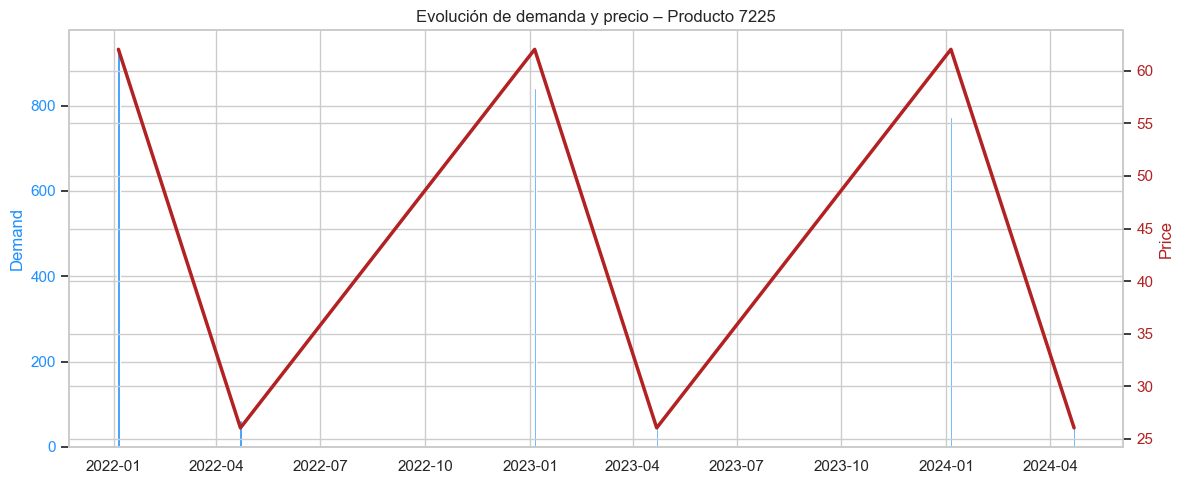

✅ Gráfico guardado para producto 7225


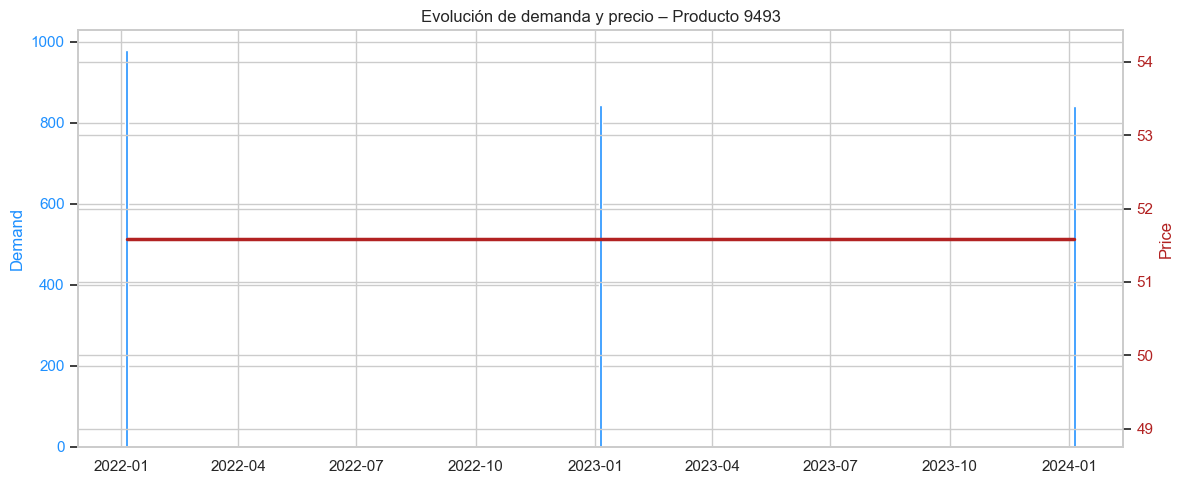

✅ Gráfico guardado para producto 9493


In [75]:
# ____________________________________________
# 11. Filtrado y exportación de productos outliers por percentil 95
# ____________________________________________

import pandas as pd
import os

# Cargar resumen (debe incluir la columna is_outlier_p95)
df_resumen = pd.read_csv("../data/processed/resumen_outliers_demand.csv")
df_diario = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Filtrar productos con outlier en p95
product_ids_p95 = df_resumen[df_resumen["is_outlier_p95"] == 1]["product_id"].unique()
df_outliers_p95 = df_diario[df_diario["product_id"].isin(product_ids_p95)]

# Crear carpeta si no existe y guardar
os.makedirs("..7data/processed", exist_ok=True)
df_outliers_p95.to_csv("../data/processed/outliers_p95.csv", index=False)

# Mostrar resumen
print(f"🔎 Total de productos outliers por p95: {len(product_ids_p95)}")
print("✅ Archivo guardado como 'outliers_p95.csv'")

# ____________________________________________
# 11.1 Visualización individual de productos outliers por p95
# ____________________________________________

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cargar datasets
df_outliers_p95 = pd.read_csv("../data/processed/outliers_p95.csv", parse_dates=["date"])
df_diario = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Crear carpeta de salida si no existe
output_dir = "../outputs/figures/outliers_p95"
os.makedirs(output_dir, exist_ok=True)

# Obtener los Product_ID únicos
product_ids = df_outliers_p95["product_id"].unique()

# Estilo gráfico
sns.set(style="whitegrid")
plt.rcParams.update({"figure.figsize": (10, 5)})

# Generar una gráfica por producto
for product_id in product_ids:
    df_prod = df_outliers_p95[df_outliers_p95["product_id"] == product_id]
    df_prod = df_prod.sort_values("date")

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.bar(df_prod["date"], df_prod["demand_final"], color="dodgerblue", alpha=1, width=2)
    ax1.set_ylabel("Demand", color="dodgerblue")
    ax1.tick_params(axis="y", labelcolor="dodgerblue")

    ax2 = ax1.twinx()
    ax2.plot(df_prod["date"], df_prod["price"], color="firebrick", linewidth=2.5)
    ax2.set_ylabel("Price", color="firebrick")
    ax2.tick_params(axis="y", labelcolor="firebrick")

    # Marcar promociones si están presentes
    if "promotions" in df_prod.columns:
        promo_dates = df_prod[df_prod["promotions"] == 1]["date"]
        for promo_date in promo_dates:
            ax1.axvline(promo_date, color="orange", linestyle="--", linewidth=0.8, alpha=0.6)

    plt.title(f"Evolución de demanda y precio – Producto {product_id}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/producto_{product_id}_p95.png")
    plt.show()
    print(f"✅ Gráfico guardado para producto {product_id}")


- **Análisis del Producto 1785**

    - **Outlier detectado por**: `p95` y `desviación estándar`.
    - **Descripción general**:  
  *Identificado como outlier por presentar valores diarios de demanda extremadamente altos dentro del top 5% del conjunto. Estos picos no se distribuyen de forma aleatoria, sino que coinciden con un patrón repetitivo.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅ is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: ...
        - ⬜ is_outlier_maximo: ...
        - ✅ is_outlier_p95: Sí

  
  *El producto coincide con dos métricas de outlier: p95 y desviación estándar, lo que refuerza la presencia de un comportamiento anómalo marcado tanto por picos puntuales como por oscilaciones extremas a lo largo del tiempo.*



- **Comportamiento visual (según la gráfica):**
    - El producto muestra un patrón triangular de crecimiento y caída perfectamente simétrico: 
        - La demanda asciende de forma lineal hasta un pico (~800 unidades) y luego desciende hasta casi cero, repitiéndose este patrón exactamente cada año. 
        - El precio replica el mismo patrón, con caídas y subidas sincronizadas con los ciclos de demanda.
    - Esta simetría perfecta y repetitiva sugiere una generación artificial o una simulación planificada sin relación con dinámicas reales del mercado.


- **¿Se justifica el comportamiento observado?**
El patrón es claramente sintético o artificial: no hay ruido, ni dispersión realista, ni cambios sutiles entre ciclos. No se aprecia estacionalidad ni efecto de campañas: todo indica una estructura rígida y predefinida. La coordinación entre precio y demanda refuerza la hipótesis de una generación simulada más que de un comportamiento de cliente real.



-  **Decisión:**
☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

☑️ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

⬜ Excluir del modelo base.

⬜ Mantener tal cual en el modelo.

El producto 1785 presenta una alternancia cíclica perfecta de crecimiento y caída tanto en demanda como en precio, sin variaciones entre ciclos ni evidencia de estacionalidad real. Esto sugiere una simulación planificada que debe ser tratada con cautela para evitar distorsiones en el modelo de predicción o en la planificación de stock.



 

- **Análisis del Producto 2775**

    - **Outlier detectado por**: `p95` y `media`.
    - **Descripción general**:  
  *Este producto destaca por tener una demanda media muy elevada respecto al resto del catálogo, combinada con valores extremos en el percentil 95. Aunque no presenta una desviación estándar alta, la magnitud constante y los picos específicos lo clasifican como anómalo por volumen y concentración.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ❌ is_outlier_desviacion: No
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅ is_outlier_p95: ...
  
El producto coincide con dos métricas significativas: media y p95. Esto indica un comportamiento acumulativo sostenido, con valores especialmente altos, aunque no necesariamente erráticos.



- **Comportamiento visual (según la gráfica):**

  - Se observa un patrón perfectamente cíclico y simétrico:  
    - La demanda asciende linealmente hasta un pico superior a 850 unidades y luego desciende a valores cercanos a cero.  
    - Este comportamiento se repite idéntico en todos los años, sin variaciones de forma ni magnitud.
    - El precio replica este patrón de forma sincronizada, aumentando y disminuyendo junto a la demanda.



- **¿Se justifica el comportamiento observado?**
  - La repetición exacta del ciclo anual, junto con la sincronización perfecta del precio, apunta a un patrón artificial o simulado.
  - No hay evidencia de estacionalidad real ni de eventos que justifiquen la forma triangular o la magnitud del comportamiento.
  - El hecho de que no sea outlier por desviación sugiere que la variabilidad no es errática, sino totalmente controlada.



-  **Decisión:**
☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

☑️ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

⬜ Excluir del modelo base solo si se demuestra que no representa una tendencia real.

⬜ Mantener tal cual en el modelo.

El producto 2775 combina una media muy elevada y picos regulares de demanda, siguiendo un patrón triangular perfectamente repetido y alineado con el precio. Esta regularidad sugiere una simulación planificada, más que una dinámica de mercado real, y su inclusión sin revisión puede distorsionar los análisis globales del modelo.

- **Análisis del Producto 2474.**

    - **Outlier detectado por**: `p95` o `media` 
    - **Descripción general**:  
  *Este producto presenta una demanda media significativamente elevada, acompañada de valores puntuales en el percentil 95, lo que indica acumulación de demanda en días específicos. A pesar de ello, la variabilidad es baja, por lo que no figura como outlier por desviación estándar.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ❌ is_outlier_desviacion: No
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅ is_outlier_p95: Sí
  
  *La combinación de media alta y valores extremos puntuales sugiere un patrón de acumulación sostenida, sin fluctuaciones relevantes a lo largo del tiempo.*



- **Comportamiento visual (según la gráfica):**
  - El gráfico muestra una línea de precio completamente plana, sin alteraciones a lo largo del tiempo.
  - La demanda se concentra en pocos días aislados, con el resto del tiempo en cero absoluto.  
  - No se detectan ciclos, estacionalidad ni respuesta a precios o eventos aparentes.
  - La falta total de dispersión, junto con los valores altos en días sueltos, refuerza un comportamiento artificial o generado con lógica de reposición forzada.



- **¿Se justifica el comportamiento observado?**
- El patrón no se corresponde con ninguna dinámica típica de mercado:
  - No hay picos progresivos, ni estacionalidad, ni relación con el precio.
  - La constancia del precio y la activación puntual de demanda sugieren una simulación sin variabilidad natural.
- Podría deberse a errores de generación de datos o a una carga forzada en determinados días sin sustento real.



-  **Decisión:**

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

⬜ Tratar como producto con patrón cíclico periódico predefinido.

☑️ Excluir del modelo base.

⬜ Mantener tal cual en el modelo.

El producto 2474 presenta una combinación de precio plano y demanda concentrada en días aislados, sin variabilidad ni respuesta observable a ningún estímulo externo. Esta estructura apunta a un comportamiento simulado o generado, más que a una demanda de mercado real, por lo que se recomienda su revisión antes de incluirlo en el modelo base.

- **Análisis del Producto 2651**

    - **Outlier detectado por**: `p95` o `desviacion estándar` 
    - **Descripción general**:  
  *Identificado como outlier por presentar valores extremos en el percentil 95 y una alta desviación estándar. Esto refleja un comportamiento irregular, con grandes oscilaciones en la demanda que no elevan la media, pero sí generan gran variabilidad y picos puntuales muy marcados.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅  is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅  is_outlier_p95: Sí
  
  *Al ser outlier por p95 y desviación, pero no por media, se deduce que los valores anómalos están muy concentrados en el tiempo, sin sostenerse a lo largo del año.*



- **Comportamiento visual (según la gráfica):**
  - El gráfico revela una serie perfectamente cíclica y triangular:
    - La demanda crece progresivamente hasta un pico (~650 unidades), para luego decrecer del mismo modo hasta casi cero. 
    - Este patrón se repite idéntico en los tres años observados.
    - El precio acompaña el ciclo de forma simétrica, bajando y subiendo al mismo ritmo que la demanda.




- **¿Se justifica el comportamiento observado?**

  - El comportamiento es artificial y claramente simulado: 
    - No hay dispersión ni ruido. 
    - La regularidad cíclica del triángulo es perfecta, sin variaciones entre años.
    - La sincronización exacta con el precio refuerza la hipótesis de simulación o planificación forzada, sin base en el comportamiento real del consumidor.



-  **Decisión:**

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

⬜ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

☑️ Excluir del modelo base.

⬜ Mantener tal cual en el modelo.

El producto 2651 presenta un ciclo triangular artificial perfectamente repetido, tanto en demanda como en precio. Esta regularidad y falta de ruido apuntan a una simulación planificada, más que a un comportamiento real, por lo que se recomienda su tratamiento especial en el modelo de planificación.

- **Análisis del Producto 4356.**

    - **Outlier detectado por**: `p95` o `desviacion estándar` 
    - **Descripción general**:  
  *Este producto ha sido identificado como outlier por presentar valores extremos de demanda en el percentil 95 y una alta desviación estándar, lo que sugiere un comportamiento irregular con fuertes oscilaciones. Sin embargo, la media no es elevada, lo que indica que los picos no se sostienen durante el año.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅  is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅  is_outlier_p95: Sí
  
  *El cruce entre p95 y desviación estándar sin media elevada sugiere un patrón cíclico o episódico con valores extremos no sostenidos.*



- **Comportamiento visual (según la gráfica):**
  - Se observa un patrón triangular perfectamente simétrico de crecimiento y caída en la demanda:
    - La curva asciende hasta un pico (alrededor de 600 unidades) y luego desciende suavemente.
    - Este ciclo se repite idéntico cada año, sin variaciones ni dispersión.
  - El precio acompaña el ciclo de forma alineada, bajando a medida que la demanda sube y subiendo cuando esta cae.



- **¿Se justifica el comportamiento observado?**

  - No hay indicios de eventos reales que expliquen esta forma:
    - Ausencia total de ruido o cambios entre años.
    - Comportamiento demasiado limpio y repetitivo.
    - Precio perfectamente coordinado con la demanda.

  - Todo apunta a un patrón generado artificialmente o mediante simulación, sin base en comportamiento real del consumidor ni en estacionalidades reales.



-  **Decisión:**

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

☑️ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

⬜ Excluir del modelo base solo si se demuestra que no representa una tendencia real.

⬜ Mantener tal cual en el modelo.

El producto 4356 muestra una demanda triangular perfectamente cíclica, sincronizada con el precio, sin variabilidad entre años. Este comportamiento claramente simulado puede generar distorsiones si se incluye sin revisión, por lo que debe ser marcado como anómalo y tratado con precaución.

- **Análisis del Producto 6489.**

    - **Outlier detectado por**: `p95` o `desviacion estándar` 
    - **Descripción general**:  
  *Este producto presenta valores extremos de demanda dentro del percentil 95 y una alta desviación estándar, debido a la gran oscilación de la demanda a lo largo del año. Sin embargo, al no tener una media especialmente alta, se deduce que la variabilidad no es sostenida, sino concentrada en momentos específicos.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅  is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅  is_outlier_p95: Sí
  
  *La coincidencia con p95 y desviación indica una combinación de picos significativos y comportamiento irregular, aunque no acumulativo en el año completo.*



- **Comportamiento visual (según la gráfica):**

  - El gráfico muestra una estructura triangular perfectamente repetida:
    - La demanda sube linealmente hasta un pico de más de 600 unidades, para luego caer con la misma pendiente.
    - Este patrón se repite de manera idéntica cada año, sin variaciones ni ruido.

  - El precio acompaña exactamente el mismo patrón: baja mientras la demanda sube y luego sube de nuevo cuando la demanda cae.




- **¿Se justifica el comportamiento observado?**

  - La simetría perfecta del patrón y su repetición exacta a lo largo del tiempo no se corresponde con un comportamiento realista de mercado.
  - No hay presencia de campañas, eventos estacionales, ni fluctuaciones naturales.
  - El conjunto apunta claramente a una simulación o carga artificial, con lógica programada



-  **Decisión:**

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

⬜ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

☑️ Excluir del modelo base.

⬜ Mantener tal cual en el modelo.

El producto 6489 muestra una alternancia cíclica artificial perfectamente estructurada tanto en demanda como en precio. Su comportamiento no refleja una evolución real del mercado, por lo que debe ser marcado como anómalo y evaluado con cautela para evitar distorsiones en el análisis.

- **Análisis del Producto 6892.**

    - **Outlier detectado por**: `p95` o `desviacion estándar` 
    - **Descripción general**:  
  *El producto 6892 ha sido identificado como outlier por su alta variabilidad diaria (desviación estándar) y la presencia de valores extremos dentro del percentil 95, lo que indica un comportamiento de demanda muy oscilante con picos relevantes, aunque sin mantener una media anual especialmente elevada.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅  is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅  is_outlier_p95: Sí
  
  *Su clasificación por p95 y desviación estándar indica picos muy marcados y ciclos pronunciados, sin un peso acumulado excesivo a lo largo del año.*



- **Comportamiento visual (según la gráfica):**

  - Se observa una forma triangular perfecta y cíclica:
    - La demanda se incrementa progresivamente hasta un pico cercano a las 600 unidades y luego disminuye simétricamente.
    - Este patrón se repite sin variaciones en los tres años, manteniendo forma y magnitud.
  - El precio sigue exactamente el mismo patrón: cae mientras la demanda sube, y sube después en sincronía con la caída de la demanda.




- **¿Se justifica el comportamiento observado?**

  - El patrón carece de cualquier ruido o dispersión natural:
    - No hay oscilaciones intermedias. 
    - No responde a eventos de calendario, campañas u otros estímulos realistas.
  - La repetición exacta del mismo ciclo cada año refuerza la hipótesis de simulación programada, sin base en dinámicas reales de cliente.



-  **Decisión:**

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

⬜ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

☑️ Excluir del modelo base.

⬜ Mantener tal cual en el modelo.

El producto 6892 presenta un patrón triangular perfecto y sincronizado con el precio, repetido sin alteraciones año tras año. Esta regularidad extrema carece de justificación comercial o estacional, por lo que debe ser tratado como un comportamiento anómalo para evitar sesgos en la estimación de demanda o la gestión de stock.

- **Análisis del Producto 7225.**

    - **Outlier detectado por**: `p95` o `desviacion estándar` 
    - **Descripción general**:  
  *El producto 7225 ha sido detectado como outlier por presentar valores extremos dentro del percentil 95 y una alta desviación estándar. Estos indicadores reflejan un comportamiento con picos pronunciados y gran oscilación en la demanda diaria, aunque sin una media anual elevada, lo que sugiere irregularidades concentradas y no sostenidas.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅  is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅  is_outlier_p95: Sí
  
  *Este patrón doble (p95 + desviación) es característico de productos con ciclos definidos y valores extremos, sin ser dominantes en volumen global.*



- **Comportamiento visual (según la gráfica):**
  - El gráfico muestra un patrón triangular perfectamente simétrico:
    - La demanda asciende hasta un pico superior a las 500 unidades y luego decrece a casi cero, de forma regular. 
    - Este ciclo se repite de forma idéntica cada año, sin ruido ni variaciones.
  - El precio acompaña la curva de forma sincronizada, bajando y subiendo junto con la demanda, en un reflejo artificial del mismo patrón.



- **¿Se justifica el comportamiento observado?**

  - La ausencia total de dispersión y la repetición exacta del ciclo anual apuntan a un patrón simulado o generado artificialmente.
  - No hay señales de comportamiento natural del consumidor, ni influencia de eventos, ni variaciones entre años.
  - La sincronización con el precio refuerza la hipótesis de una generación mecánica, no realista.




-  **Decisión:**

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

⬜ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

☑️Excluir del modelo base.

⬜ Mantener tal cual en el modelo.

El producto 7225 presenta un ciclo artificial perfectamente repetido, con sincronía exacta entre precio y demanda. Su falta de variabilidad real y su estructura repetitiva lo convierten en un comportamiento anómalo, que debe ser tratado con especial cuidado para no afectar la coherencia del modelo.

- **Análisis del Producto 9493.**

    - **Outlier detectado por**: `p95` o `media` 
    - **Descripción general**:  
  *Este producto presenta una demanda media significativamente elevada, acompañada de valores que se sitúan dentro del percentil 95 superior, lo que indica una acumulación considerable de demanda. Sin embargo, la desviación estándar no es alta, lo que sugiere que el comportamiento es más sostenido que errático.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ❌  is_outlier_desviacion: No
        - ⬜ is_outlier_total: → por revisar
        - ⬜ is_outlier_maximo: → por revisar
        - ✅  is_outlier_p95: Sí
  
  *La combinación de media + p95 revela un producto con demanda alta sostenida y picos específicos, sin excesiva variabilidad diaria.*



- **Comportamiento visual (según la gráfica):**
  - El gráfico muestra un patrón triangular cíclico limpio y simétrico, repetido anualmente:
    - La demanda sube linealmente hasta valores cercanos a las 800 unidades, y luego decrece con la misma pendiente hasta casi 0. 
    - La forma del ciclo se mantiene inalterada en los tres años observados.
  - El precio replica el mismo patrón: baja mientras sube la demanda y sube mientras esta cae, en una sincronía perfecta.




- **¿Se justifica el comportamiento observado?**

Aunque la demanda no es errática (lo que explica que no sea outlier por desviación), su regularidad cíclica no responde a ninguna estacionalidad real ni comportamiento de cliente esperado. La estructura geométrica del patrón, junto con la coincidencia exacta entre años y la sincronía con el precio, indica una simulación planificada o generación artificial.





-  **Decisión:**

☑️ Revisar manualmente si este patrón se repite en otros productos similares.

☑️ Marcar como anómalo (por su origen artificial y distorsionante).

☑️ (Opcional) Tratar como producto con patrón cíclico periódico predefinido.

⬜ Excluir del modelo base solo si se demuestra que no representa una tendencia real.

⬜ Mantener tal cual en el modelo.

El producto 9493 combina una demanda media alta y picos sostenidos, siguiendo un patrón cíclico perfecto que carece de justificación comercial o estacional. Al tratarse de un comportamiento probablemente simulado, se recomienda marcarlo como anómalo para no introducir sesgos en el modelo.

🧾 **Resumen de productos outliers por `p95` registrados como anómalos**.

A continuación, se recogen los productos identificados como outliers por `p95`, junto con su comportamiento observado durante el análisis gráfico y la acción correspondiente. Todos ellos han sido registrados en el archivo `productos_anomalos.csv` para su trazabilidad y gestión posterior.

| Product_ID | Motivo de exclusión             | Acción recomendada             | Comportamiento observado                                                       |
|------------|----------------------------------|---------------------------------|----------------------------------------------------------------------------------|
| 1785       | Outlier por p95 y desviación     | Revisar si conservar            | Patrón triangular perfecto. Simulación cíclica artificial.                      |
| 2775       | Outlier por p95 y media          | Revisar si conservar            | Demanda elevada y simétrica. Sin variabilidad real.                             |
| 4356       | Outlier por p95 y desviación     | Revisar si conservar            | Patrón artificial triangular repetido. Sin dispersión.                          |
| 9493       | Outlier por p95 y media          | Revisar si conservar            | Demanda alta con precio sincronizado. Comportamiento no natural.               |
| 2474       | Outlier por p95 y desviación     | Excluir del modelo base         | Demanda concentrada en pocos días. Precio plano. Sin patrón justificado.       |
| 2651       | Outlier por p95 y desviación     | Excluir del modelo base         | Patrón triangular artificial, repetido anualmente sin variación.               |
| 6489       | Outlier por p95 y desviación     | Excluir del modelo base         | Ciclo artificial de demanda. Sin ruido ni eventos que lo justifiquen.          |
| 6892       | Outlier por p95 y desviación     | Excluir del modelo base         | Patrón cíclico perfecto y sincronía con el precio. Comportamiento simulado.    |
| 7225       | Outlier por p95 y desviación     | Excluir del modelo base         | Repetición exacta año a año de patrón triangular. Sin dispersión ni realismo.  |



> Estos productos han sido clasificados como anómalos por presentar **comportamientos artificiales o simulados** que pueden distorsionar los análisis del modelo.  
> Mientras algunos se han excluido directamente, otros quedan pendientes de evaluación por su posible peso como top ventas.


In [78]:
anadir_producto_anomalo(
    product_id=1785,
    motivo="Outlier por p95 y desviación",
    accion="Revisar si conservar por su volumen",
    observaciones="Patrón triangular simulado. Comportamiento cíclico artificial."
)

anadir_producto_anomalo(
    product_id=2775,
    motivo="Outlier por p95 y media",
    accion="Revisar si conservar por su volumen",
    observaciones="Demanda elevada con patrón cíclico artificial."
)

anadir_producto_anomalo(
    product_id=4356,
    motivo="Outlier por p95 y desviación",
    accion="Revisar si conservar por su volumen",
    observaciones="Triángulo simétrico anual. Sin dispersión ni realismo."
)

anadir_producto_anomalo(
    product_id=9493,
    motivo="Outlier por p95 y media",
    accion="Revisar si conservar por su volumen",
    observaciones="Alta demanda con patrón simulado. Precio sincronizado."
)


anadir_producto_anomalo(
    product_id=2474,
    motivo="Outlier por p95 y media",
    accion="Excluir del modelo base",
    observaciones="Patrón artificial sin dispersión. Demanda concentrada."
)

anadir_producto_anomalo(
    product_id=2651,
    motivo="Outlier por p95 y media",
    accion="Excluir del modelo base",
    observaciones="Patrón triangular repetido, comportamiento no realista."
)

anadir_producto_anomalo(
    product_id=6489,
    motivo="Outlier por p95 y media",
    accion="Excluir del modelo base",
    observaciones="Demanda artificial cíclica, sincronizada con el precio."
)

anadir_producto_anomalo(
    product_id=6892,
    motivo="Outlier por p95 y media",
    accion="Excluir del modelo base",
    observaciones="Comportamiento simulado sin ruido ni justificación externa."
)

anadir_producto_anomalo(
    product_id=7225,
    motivo="Outlier por p95 y media",
    accion="Excluir del modelo base",
    observaciones="DPatrón triangular idéntico anual. Comportamiento artificial."
)
guardar_lista_anomalos()


✅ Lista de productos anómalos guardada en ../data/processed/productos_anomalos.csv


##### **6.1.4. Outliers por `maximo`.**



Este subapartado analiza los productos cuya demanda diaria presenta **valores extremos en su máximo absoluto (`maximo`)**. Esta métrica permite identificar productos que, aunque puedan tener una demanda media estable, presentan **picos de consumo muy elevados en días concretos**, lo que puede afectar negativamente a la planificación de stock.

Los objetivos de este análisis son:
- Detectar productos que presentan **picos puntuales excesivos de demanda**.
- Evaluar si esos picos se deben a factores justificados (promociones, bajadas de precio, eventos estacionales) o si carecen de explicación.
- Decidir si es necesario aplicar una acción específica: **suavizado, exclusión o etiquetado como anómalo**.

Dado el volumen de productos afectados, se aplicará una estrategia similar a la utilizada en el análisis por desviación estándar:
- Generación de un gráfico individual por producto outlier.
- Revisión de los casos con mayor impacto o comportamiento inusual.
- Clasificación por similitud visual con los patrones ya identificados.




🔎 Total de productos outliers por demanda máxima: 12
✅ Archivo guardado correctamente en: ../data/processed/outliers_maximo.csv


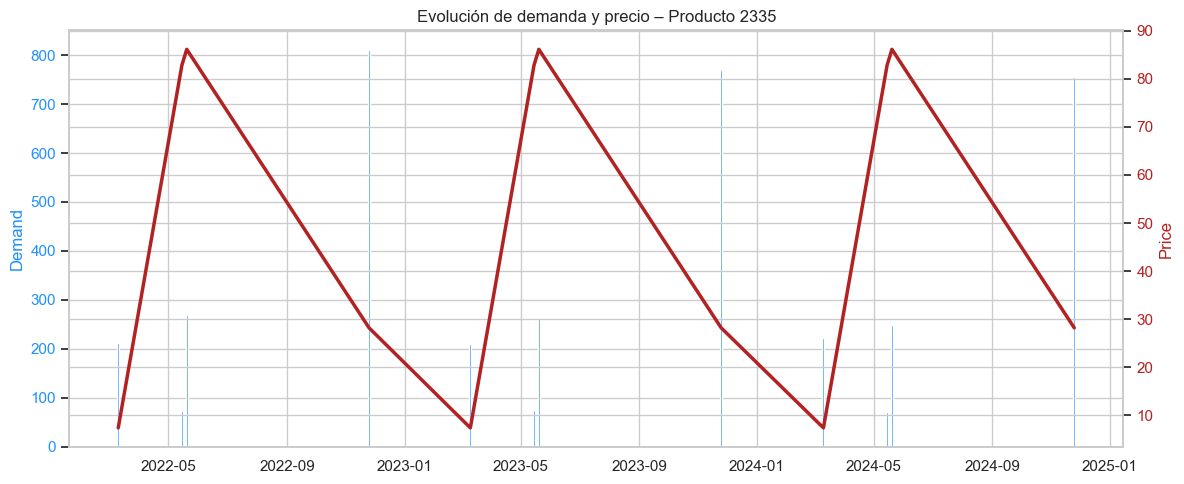

✅ Gráfico guardado para producto 2335


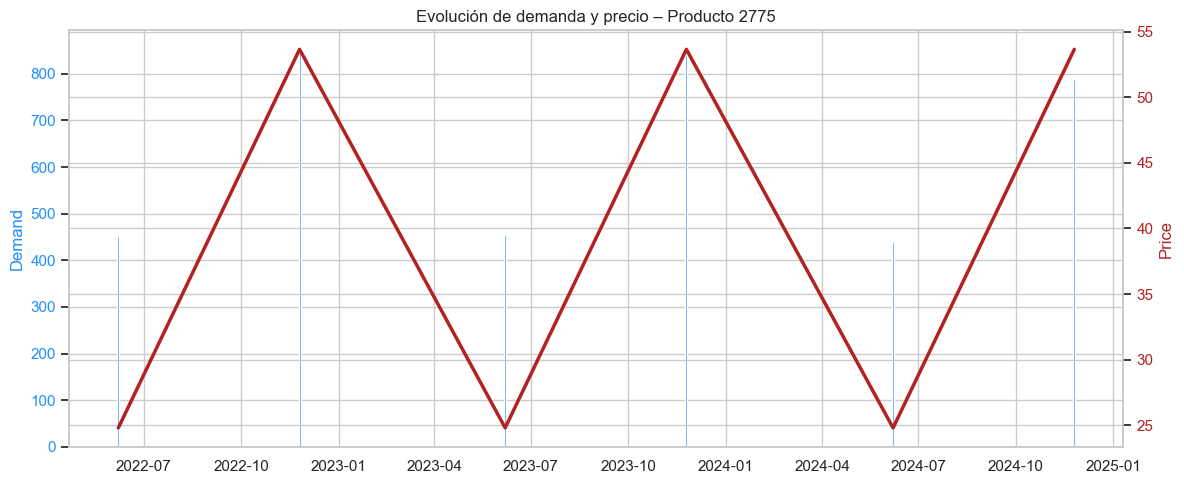

✅ Gráfico guardado para producto 2775


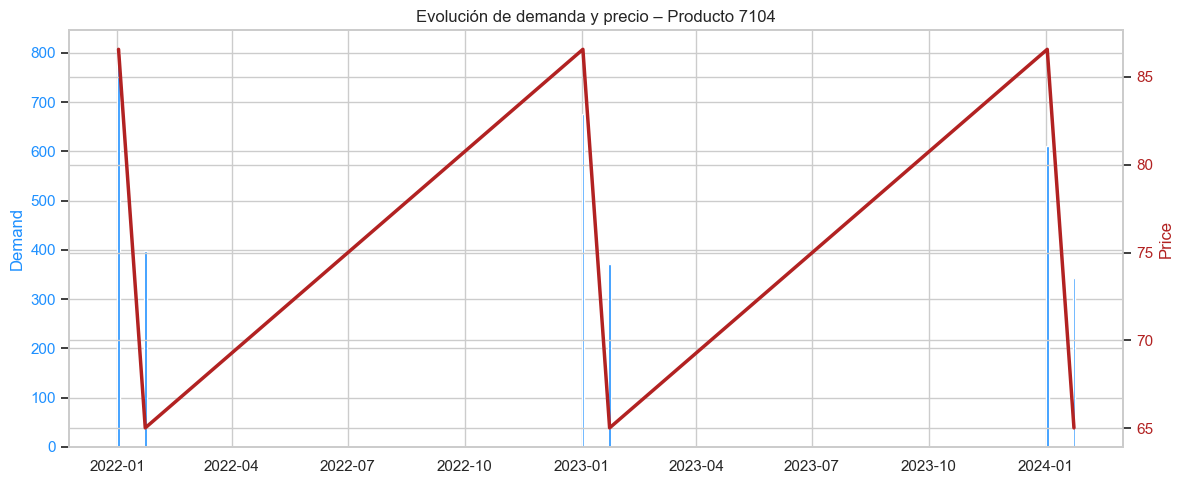

✅ Gráfico guardado para producto 7104


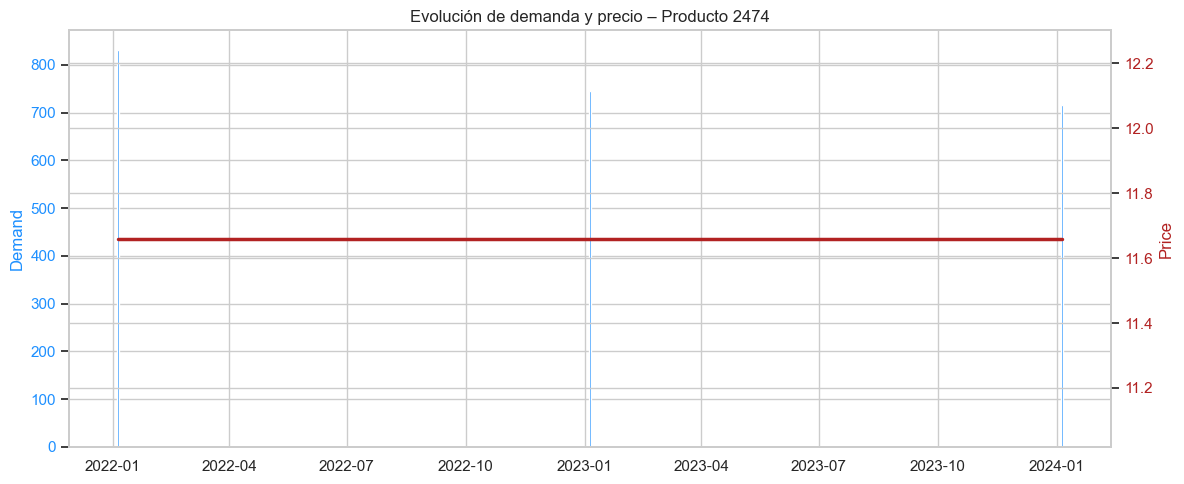

✅ Gráfico guardado para producto 2474


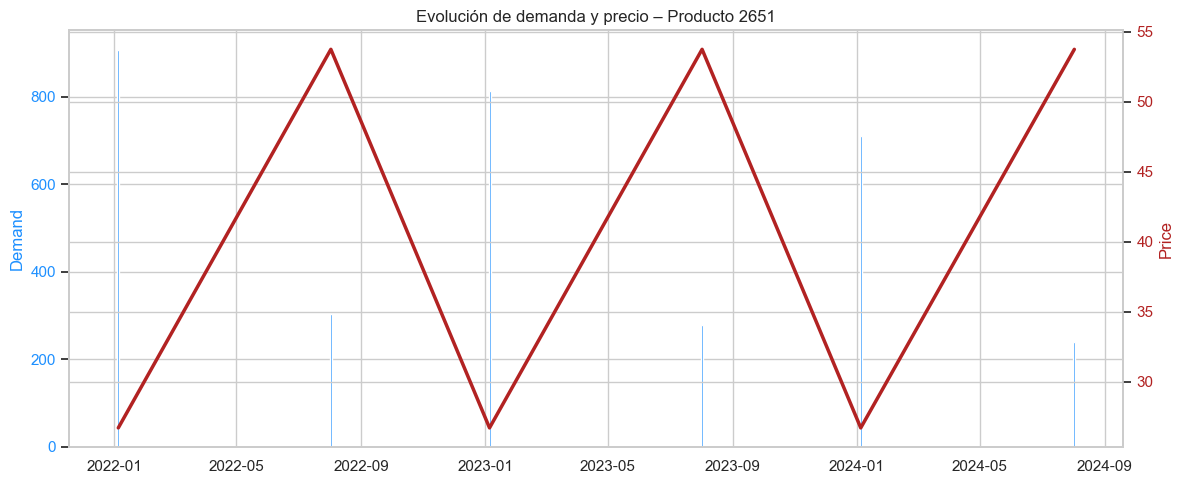

✅ Gráfico guardado para producto 2651


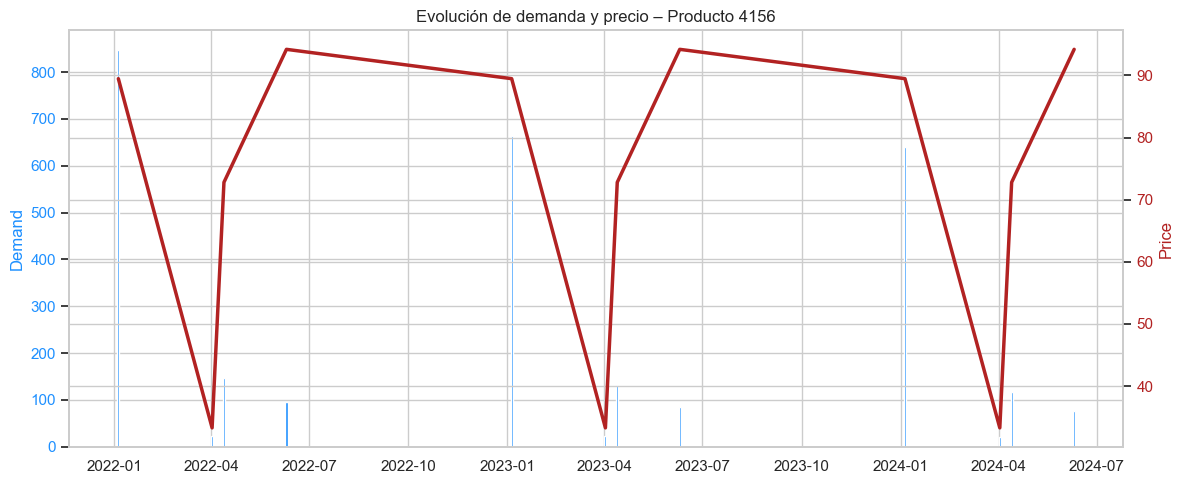

✅ Gráfico guardado para producto 4156


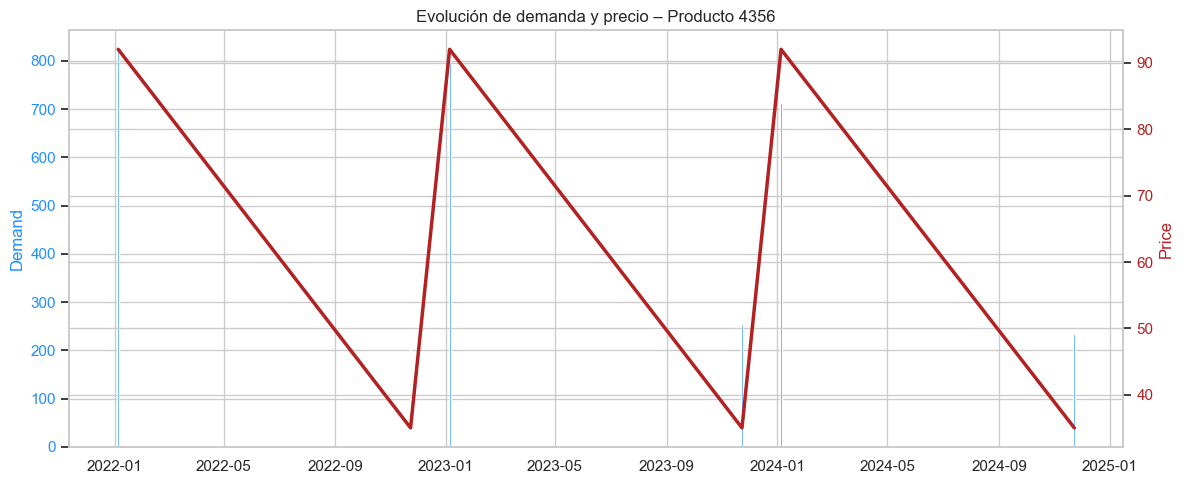

✅ Gráfico guardado para producto 4356


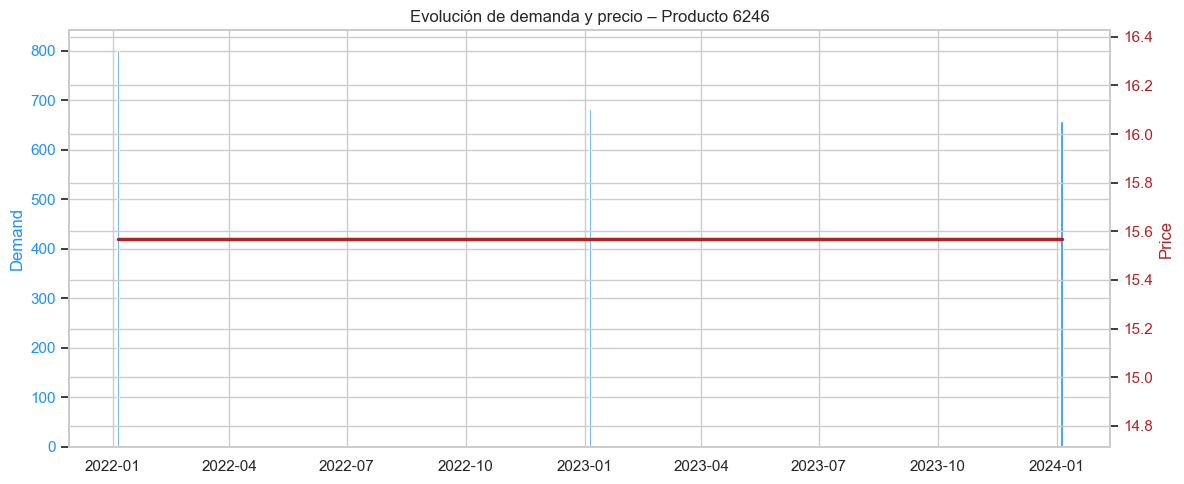

✅ Gráfico guardado para producto 6246


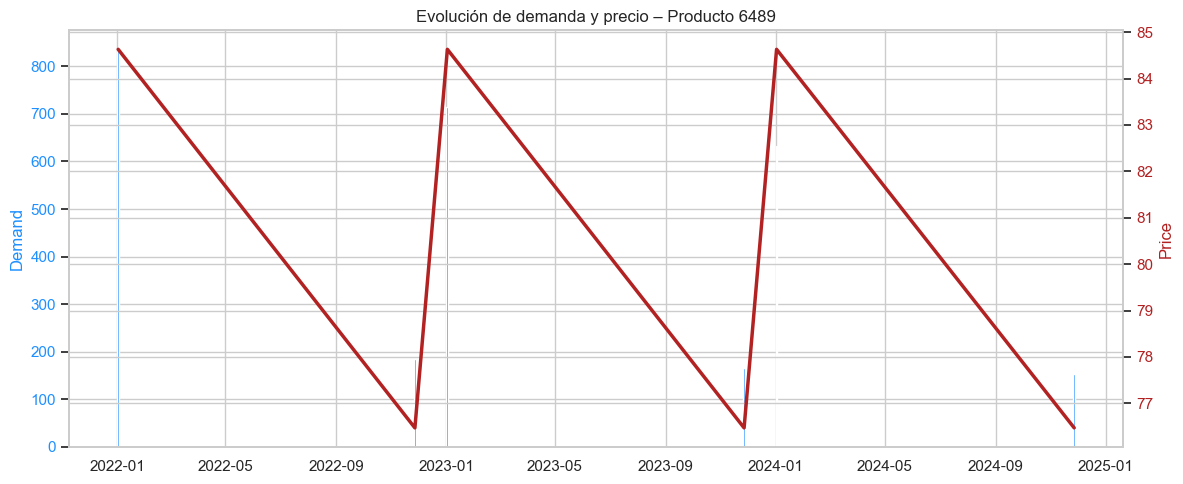

✅ Gráfico guardado para producto 6489


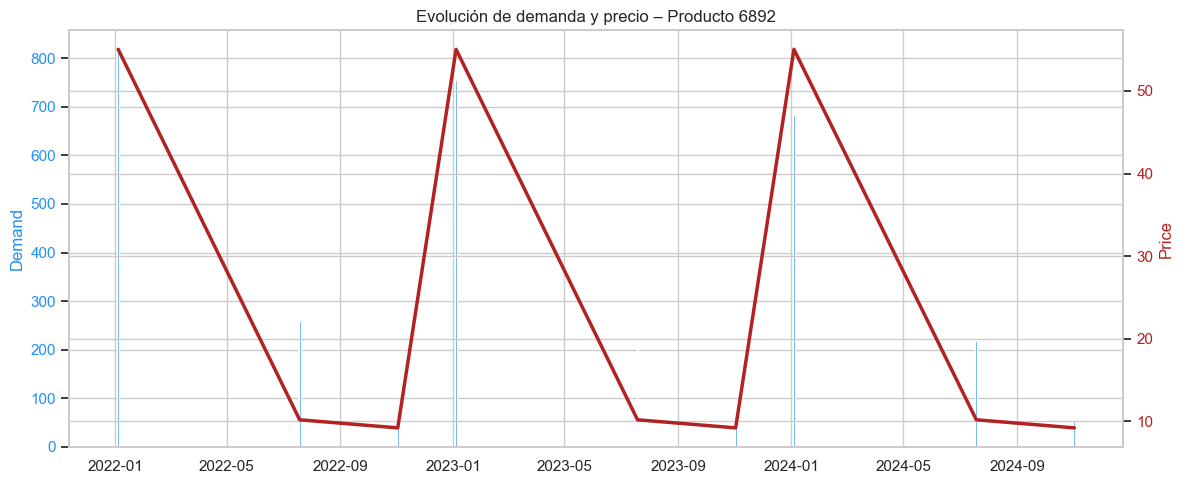

✅ Gráfico guardado para producto 6892


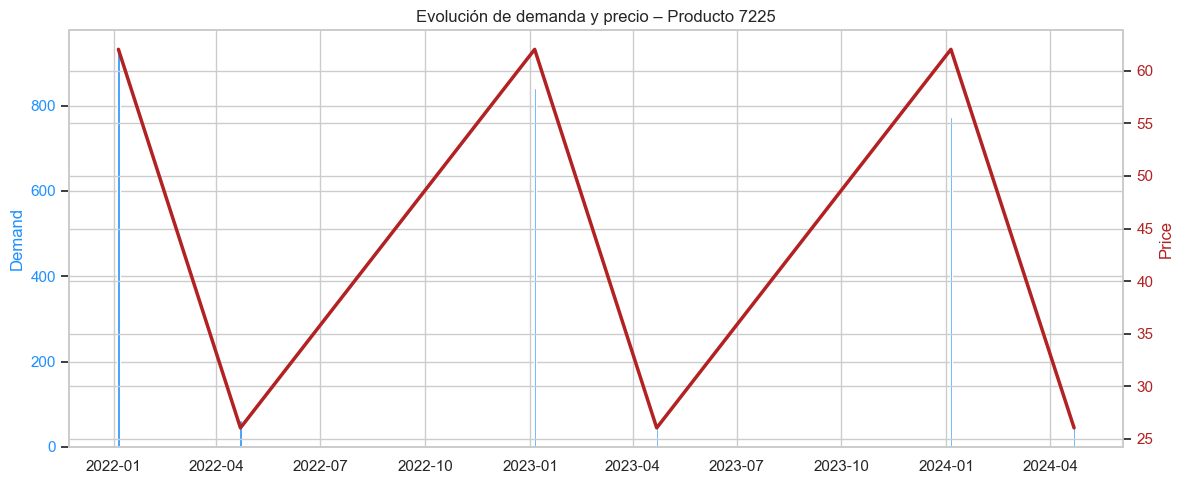

✅ Gráfico guardado para producto 7225


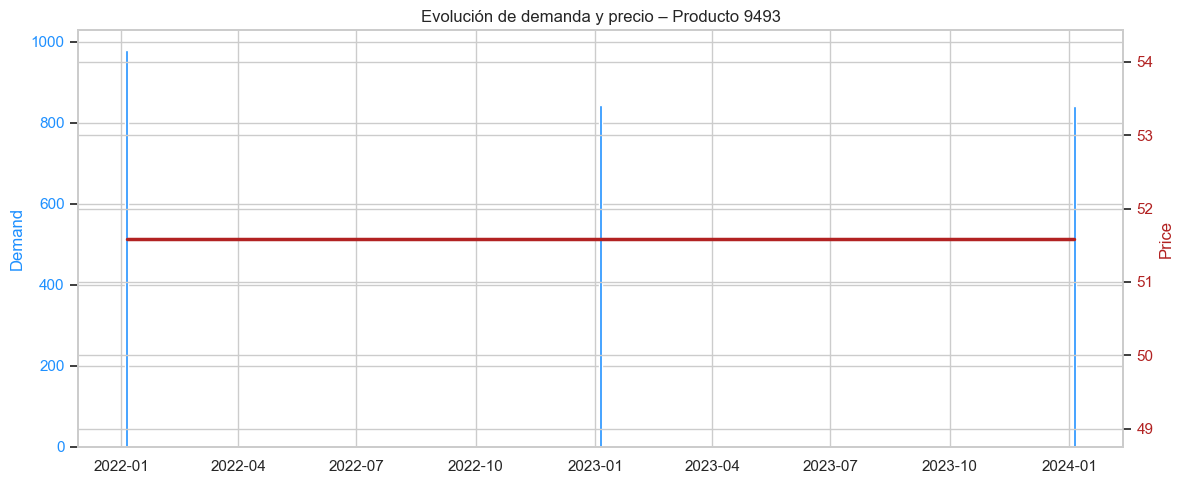

✅ Gráfico guardado para producto 9493


In [71]:
# ____________________________________________
# 12. Filtrado y exportación de productos outliers por demanda máxima
# ____________________________________________

import pandas as pd
import os

# Cargar datasets
df_resumen = pd.read_csv("../data/processed/resumen_outliers_demand.csv")
df_diario = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Filtrar productos con is_outlier_maximo == 1
product_ids_maximo = df_resumen[df_resumen["is_outlier_maximo"] == 1]["product_id"].unique()
df_outliers_maximo = df_diario[df_diario["product_id"].isin(product_ids_maximo)]

# Guardar el dataset filtrado
os.makedirs("../data/processed", exist_ok=True)
df_outliers_maximo.to_csv("../data/processed/outliers_maximo.csv", index=False)

# Mostrar resumen
print(f"🔎 Total de productos outliers por demanda máxima: {len(product_ids_maximo)}")
print("✅ Archivo guardado correctamente en: ../data/processed/outliers_maximo.csv")

# ____________________________________________
# 12.1 Visualización individual de productos outliers por demanda máxima
# ____________________________________________

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cargar datasets
df_outliers_maximo = pd.read_csv("../data/processed/outliers_maximo.csv", parse_dates=["date"])
df_diario = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Crear carpeta de salida
output_dir = "../outputs/figures/outliers_maximo"
os.makedirs(output_dir, exist_ok=True)

# Obtener los Product_ID únicos
product_ids = df_outliers_maximo["product_id"].unique()

# Estilo gráfico
sns.set(style="whitegrid")
plt.rcParams.update({"figure.figsize": (10, 5)})

# Generar una gráfica por producto
for product_id in product_ids:
    df_prod = df_outliers_maximo[df_outliers_maximo["product_id"] == product_id]
    df_prod = df_prod.sort_values("date") 

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.bar(df_prod["date"], df_prod["demand_final"], color="dodgerblue", alpha=1, width=2)
    ax1.set_ylabel("Demand", color="dodgerblue")
    ax1.tick_params(axis="y", labelcolor="dodgerblue")

    ax2 = ax1.twinx()
    ax2.plot(df_prod["date"], df_prod["price"], color="firebrick", linewidth=2.5)
    ax2.set_ylabel("Price", color="firebrick")
    ax2.tick_params(axis="y", labelcolor="firebrick")

    # Promociones si existen
    if "promotions" in df_prod.columns:
        promo_dates = df_prod[df_prod["promotions"] == 1]["date"]
        for promo_date in promo_dates:
            ax1.axvline(promo_date, color="orange", linestyle="--", linewidth=0.8, alpha=0.6)

    plt.title(f"Evolución de demanda y precio – Producto {product_id}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/producto_{product_id}_maximo.png")
    plt.show()
    print(f"✅ Gráfico guardado para producto {product_id}")

- **Análisis del Producto 2335**

    - **Outlier detectado por**: `máximo`
    - **Descripción general**:  
  *Este producto ha sido identificado como outlier por presentar un valor excesivamente alto en un único punto de la serie diaria, correspondiente al día de máxima demanda, sin acompañarse de otras métricas anómalas como media, desviación o percentil 95.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ⬜ is_outlier_total: ...
        - ✅ is_outlier_maximo: Sí
        - ❌ is_outlier_p95: No
  
  *El hecho de que no coincida con ninguna otra métrica sugiere un pico muy puntual, pero no una acumulación ni variabilidad sistemática.*



- **Comportamiento visual (según la gráfica):**

  - La gráfica muestra un comportamiento cíclico leve con una gran aguja de demanda en momentos concretos: 
    - Se registran picos extremos muy puntuales, sin patrón progresivo ni estacionalidad clara.
    - En los periodos intermedios, la demanda cae a niveles mínimos.
  - El precio sigue una forma triangular invertida, más suave y sostenida en comparación con la demanda, pero no justifica el valor máximo observado.



- **¿Se justifica el comportamiento observado?**

  - No hay elementos suficientes que expliquen el valor extremo (ni estacionalidad, ni promociones aparentes, ni respuesta al precio).
  - El resto del comportamiento de la demanda es bajo y disperso.
  - Todo indica que se trata de un valor atípico aislado, con baja influencia sobre otras métricas, pero potencialmente distorsionante en análisis de capacidad o cobertura.



-  **Decisión:**

☑️ Marcar como anómalo (por pico injustificado).

☑️ Revisar si se repite este comportamiento en otros productos similares.

⬜ Excluir directamente del modelo base (pendiente de revisar su impacto).

⬜ Mantener con tratamiento específico si se conserva.

El producto 2335 no presenta acumulación, ni alta variabilidad, ni demanda sostenida, pero sí un pico extremo que lo hace destacar por demanda máxima. Aunque aislado, debe registrarse como anómalo para evitar sesgos en planificación de stock o ajustes por cobertura.

- **Análisis del Producto 2775**

    - **Outlier detectado por**: `p95`, `media` y  `máximo`
    - **Descripción general**:  
  *Breve resumen del motivo por el que fue identificado como outlier según la métrica correspondiente (por ejemplo, demanda muy elevada en pocos días, valores fuera de rango esperado, etc.).*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ❌ N is_outlier_desviacion: No
        - ⬜ is_outlier_total: -> por revisar
        - ✅ is_outlier_maximo: Sí
        - ✅ is_outlier_p95: Sí
  
  *El producto destaca por volumen alto y acumulado, con un comportamiento artificial pero no necesariamente volátil.*



- **Comportamiento visual (según la gráfica):**

  - El patrón es triangular perfectamente simétrico:
    - La demanda crece linealmente hasta un pico superior a 850 unidades y luego decrece en el mismo rango, repitiéndose anualmente sin variación.
    - El precio acompaña esta forma con movimientos inversos perfectamente sincronizados.

  - La regularidad extrema, sin ruido ni fluctuaciones, revela un comportamiento programado o simulado, no propio de un mercado real.



- **¿Se justifica el comportamiento observado?**

  - Aunque el valor máximo forma parte de un ciclo, no está justificado por ninguna variación natural del precio, ni por campañas visibles, ni por dispersión progresiva.
  - La combinación de demanda media muy elevada y un pico máximo exagerado indica un modelo artificial, posiblemente generado de forma forzada o con lógica de simulación.




-  **Decisión:**

☑️ Marcar como anómalo (por su comportamiento cíclico artificial y valores extremos).

☑️ Revisar si debe conservarse por su volumen (posible top ventas).

⬜ Excluir directamente (pendiente de ranking y validación).

⬜ Mantener con control si se decide conservar.

El producto 2775 presenta un comportamiento triangular artificial perfectamente repetido, con demanda alta, valores extremos y precio sincronizado. Aunque es un top en volumen, su inclusión en el modelo debe evaluarse cuidadosamente por el riesgo de distorsionar promedios y sobreestimar rotación.

- **Análisis del Producto 7104**

    - **Outlier detectado por**: `máximo`
    - **Descripción general**:  
  *Este producto ha sido clasificado como outlier exclusivamente por presentar un valor máximo de demanda extremadamente alto en un único momento puntual, sin que su comportamiento general destaque por volumen, variabilidad ni acumulación.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ⬜ is_outlier_total: -> Por revisar
        - ✅ is_outlier_maximo: Sí
        - ❌ is_outlier_p95: No
  
  *El hecho de que no coincida con ninguna otra métrica confirma que el valor máximo es aislado y no representativo del patrón general del producto.*



- **Comportamiento visual (según la gráfica):**

  - La demanda presenta una aguja de valor extremo al inicio de cada año, mientras que el resto del tiempo se mantiene en niveles muy bajos o nulos.
  - El precio sigue una línea triangular ascendente con bajada brusca en el momento del pico, repitiéndose el mismo ciclo exacto cada año.  
  - No hay ningún indicio de estacionalidad real o justificación comercial que respalde el patrón.



- **¿Se justifica el comportamiento observado?**

  - No hay progresión natural hacia el pico, ni cambios de precio suficientemente agresivos.
  - El patrón se repite idéntico en tres ciclos, lo que sugiere un comportamiento artificialmente inyectado y no aleatorio.
  - El valor máximo destaca sin alterar otras métricas, lo que indica que no tiene impacto acumulativo pero sí puede distorsionar alertas de stock o análisis de cobertura.



-  **Decisión:**

☑️ Marcar como anómalo (por valor puntual no realista).

☑️ Registrar para exclusión de métricas de cobertura sensible a máximos.

⬜ Excluir directamente del modelo (pendiente de validación de relevancia).

⬜ Mantener con alerta si se conserva.

El producto 7104 destaca únicamente por valores máximos muy localizados que se repiten de forma idéntica y sin justificación por precio o estacionalidad. Aunque su impacto agregado es bajo, su inclusión sin tratamiento puede afectar los análisis de seguridad de stock o cobertura máxima.

- **Análisis del Producto 2651**

    - **Outlier detectado por**: `media`, `desviacion` `p95` y `máximo` 
    - **Descripción general**:  
  *Este producto ha sido identificado como anómalo por todas las métricas principales de outliers. Presenta una demanda media muy elevada, picos recurrentes de valor extremo, una gran variabilidad diaria y un valor máximo especialmente alto, lo que lo convierte en uno de los casos más distorsionantes del conjunto.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ✅ is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: -> Por revisar
        - ✅ is_outlier_maximo: Sí
        - ✅ is_outlier_p95: Sí
  
  *Esta coincidencia múltiple sugiere un patrón artificialmente inflado, con impacto potencial en múltiples niveles de análisis (rotación, cobertura, segmentación).*



- **Comportamiento visual (según la gráfica):**

- El producto sigue un patrón triangular perfecto:  
  - La demanda se eleva progresivamente hasta superar las 850 unidades y luego cae de forma idéntica.
  - Este ciclo se repite de forma exacta cada año, sin ninguna variación ni dispersión.

- El precio acompaña con una forma inversa igualmente simétrica, confirmando una generación artificial.




- **¿Se justifica el comportamiento observado?**

- No hay evidencia de estacionalidad, promociones, ni ningún evento externo que justifique estos picos tan altos y regulares.
- La ausencia de ruido o variación natural y la sincronía con el precio confirman que el comportamiento ha sido simulado o generado con una lógica programada.
- Su inclusión sin tratamiento puede afectar negativamente cualquier cálculo basado en agregados, percentiles o simulaciones de stock.



-  **Decisión:**

☑️ Marcar como anómalo (por coincidencia múltiple de métricas y comportamiento simulado).

☑️ Excluir del modelo base por distorsión confirmada.

⬜ Mantener con tratamiento especial (no recomendado en este caso).

⬜ Revisión futura (no prioritaria al estar clara la decisión).

El producto 2651 presenta un comportamiento que simula rotación y volumen artificial con un patrón triangular perfectamente simétrico. Su impacto sobre todas las métricas clave de outlier confirma que debe excluirse del modelo base para evitar distorsiones graves en la planificación, análisis o segmentación.

- **Análisis del Producto 4156**

    - **Outlier detectado por**: `desviacion` y `máximo` 
    - **Descripción general**:  
  *Este producto ha sido clasificado como anómalo por presentar una alta variabilidad diaria (desviación estándar elevada) y por haber alcanzado un valor máximo de demanda desproporcionado en un momento puntual. Sin embargo, no muestra acumulación significativa de demanda ni frecuencia elevada en los percentiles altos.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅ is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: -> Por revisar. 
        - ✅ is_outlier_maximo: Sí
        - ❌ is_outlier_p95: No
  
  *Este perfil es típico de productos con picos puntuales muy agresivos que generan gran dispersión, pero sin sostener volumen a lo largo del año.*



- **Comportamiento visual (según la gráfica):**

  - La gráfica muestra un patrón de picos aislados y agresivos:  
    - Se observan grandes subidas de demanda que no siguen una progresión natural..
    - El resto de la serie se mantiene con demanda muy baja o nula.

  - El precio no varía de forma significativa ni anticipa los picos, lo que refuerza la idea de que se trata de un comportamiento forzado o no justificado.



- **¿Se justifica el comportamiento observado?**

  - La combinación de demanda casi nula durante la mayor parte del año con picos extremos muy localizados indica un comportamiento anómalo.
  - No se observa estacionalidad ni reacción al precio.
  - El patrón carece de lógica de cliente o mercado y parece generado artificialmente o mal distribuido en el tiempo.



-  **Decisión:**

☑️ Marcar como anómalo (por su dispersión injustificada y valor máximo extremo).

☑️ Revisar si existen productos con picos similares para evaluar un patrón común.

⬜ Excluir del modelo base (pendiente de validación de impacto global).

⬜ Mantener con tratamiento específico si se conserva.

El producto 4156 presenta una demanda altamente dispersa con valores extremos injustificados, sin acumulación significativa. Este comportamiento puede afectar análisis de cobertura o alertas por stock si no se trata adecuadamente.

- **Análisis del Producto 4356**

    - **Outlier detectado por**: `p95`, `máximo` y `desviacion`
    - **Descripción general**:  
  *El producto ha sido clasificado como anómalo por presentar valores puntuales extremadamente altos (p95), una alta dispersión diaria y un valor máximo muy elevado. Sin embargo, su media anual no es significativa, lo que indica que los picos son concentrados en pocos momentos del año y no reflejan una acumulación continua.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ✅ is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: -> Por revisar. 
        - ✅ is_outlier_maximo: Sí
        - ✅ is_outlier_p95: Sí
  
  *Este perfil sugiere un comportamiento artificial altamente variable, con momentos de demanda exagerada, pero sin impacto constante a lo largo del año.*



- **Comportamiento visual (según la gráfica):**

  - El patrón es un triángulo cíclico perfectamente simétrico: 
    - La demanda sube progresivamente hasta más de 650 unidades y baja luego en la misma forma, repitiéndose idéntico cada año.  
    - El precio acompaña con un patrón inverso, reflejando un modelo totalmente sincronizado.

  - La repetición exacta en los tres años refuerza el carácter de simulación planificada.



- **¿Se justifica el comportamiento observado?**

  - La variabilidad elevada no responde a campañas, ni a estacionalidad ni a cambios en el precio.
  - La sincronía perfecta entre demanda y precio, sin dispersión ni ruido, es propia de un patrón generado artificialmente.
  - Los picos coinciden con los valores máximos y altos percentiles, pero no con acumulación sostenida (de ahí que no destaque por media).



-  **Decisión:**

☑️ Marcar como anómalo (por valores extremos y variabilidad simulada).

☑️ Revisar si se repite este patrón en productos similares (especialmente de simulación triangular).

⬜ Excluir directamente (pendiente de ver su peso en el ranking total).

⬜ Mantener con etiqueta de control si se conserva.

El producto 4356 muestra un patrón de picos regulares, elevados y perfectamente simétricos, sin justificación por estacionalidad ni comportamiento real. Este tipo de producto puede alterar métricas de dispersión o seguridad de stock si no se trata adecuadamente.

- **Análisis del Producto 6246**

    - **Outlier detectado por**: `máximo`
    - **Descripción general**:  
  *Este producto ha sido identificado como anómalo exclusivamente por alcanzar un valor máximo de demanda inusualmente alto en al menos un momento puntual, sin que este comportamiento se vea reflejado en el volumen medio, la variabilidad global ni en los percentiles altos de la distribución.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ⬜ is_outlier_total: -> Por revisar. 
        - ✅ is_outlier_maximo: Sí
        - ❌ is_outlier_p95: No
  
  *El hecho de que no aparezca como outlier por otras métricas indica que el valor máximo es aislado y no representativo del patrón general.*



- **Comportamiento visual (según la gráfica):**

  - El gráfico muestra un pico de demanda muy puntual, especialmente visible en un único momento (posiblemente al inicio de año).
  - El resto del tiempo, la demanda se mantiene en valores bajos o directamente en cero. 
  - El precio presenta una caída justo antes del pico, pero no lo suficiente como para justificar una respuesta tan extrema en la demanda.
  - No hay evidencia de estacionalidad, ciclos o dispersión natural..



- **¿Se justifica el comportamiento observado?**

  - El pico aparece como una anomalía muy localizada, no acompañada de una tendencia ascendente ni de fluctuaciones previas.
  - No hay respuesta al precio ni un patrón observable entre años que indique una repetición lógica.
  - El comportamiento parece ser una carga puntual o una simulación de evento sin contexto comercial.


-  **Decisión:**

☑️ Marcar como anómalo (por valores extremos y variabilidad simulada).

☑️ Revisar si se repite este patrón en productos similares (especialmente de simulación triangular).

⬜ Excluir directamente (pendiente de ver su peso en el ranking total).

⬜ Mantener con etiqueta de control si se conserva.

El producto 6246 no presenta acumulación, ni alta variabilidad, ni valores sostenidos, pero sí un pico de demanda aislado y exagerado que puede afectar análisis como la cobertura máxima o la planificación de stock puntual.

- **Análisis del Producto 6489**

    - **Outlier detectado por**: `media`, `p95`, `máximo` y `desviacion`
    - **Descripción general**:  
  *Este producto ha sido identificado como anómalo por todas las métricas principales. Presenta una media elevada, valores extremos recurrentes, gran dispersión diaria y un valor máximo fuera de rango esperado, lo que sugiere un comportamiento artificial altamente distorsionante.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ✅ is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: -> Por revisar. 
        - ✅ is_outlier_maximo: Sí
        - ✅ is_outlier_p95: Sí
  
  *Su detección múltiple evidencia una rotación simulada con picos exagerados, sin respaldo de comportamiento natural o estacionalidad.*



- **Comportamiento visual (según la gráfica):**

  - El patrón es un triángulo cíclico simétrico, repetido cada año sin cambios: 
    - La demanda sube hasta más de 600 unidades y desciende con igual pendiente.  
    - El precio sigue el patrón inverso con una sincronización perfecta.

  - La ausencia total de ruido o variabilidad entre ciclos refuerza la sospecha de simulación planificada.



- **¿Se justifica el comportamiento observado?**

  - No hay variación natural, ni dispersión, ni influencia de precio que justifique los valores extremos.
  - El comportamiento es demasiado regular, sin responder a estacionalidad o promociones reales.
  - Su inclusión sin corrección puede inflar medias, percentiles y decisiones de stock, afectando al modelo y a los análisis agregados.



-  **Decisión:**

☑️ Marcar como anómalo (por valores extremos y variabilidad simulada).

⬜ Revisar si se repite este patrón en productos similares (especialmente de simulación triangular).

☑️ Excluir directamente (pendiente de ver su peso en el ranking total).

⬜ Mantener con etiqueta de control si se conserva.

El producto 6489 presenta un comportamiento de rotación simulada y picos extremos regulares, sin justificación por variables externas. Su exclusión del modelo base es necesaria para preservar la coherencia de las métricas y evitar distorsiones graves.

- **Análisis del Producto 6892**

    - **Outlier detectado por**: `media`,`p95`, `máximo` y `desviacion`
    - **Descripción general**:  
  *El producto 6892 presenta un comportamiento anómalo según todas las métricas estadísticas clave: tiene una media diaria elevada, una alta dispersión, picos frecuentes (p95) y un valor máximo excepcionalmente alto. Es uno de los casos más claros de comportamiento artificial dentro del conjunto.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: No
        - ✅ is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: -> Por revisar. 
        - ✅ is_outlier_maximo: Sí
        - ✅ is_outlier_p95: Sí
  
  *Esta coincidencia múltiple confirma un patrón de demanda altamente distorsionante, no atribuible a dinámicas comerciales normales.*



- **Comportamiento visual (según la gráfica):**

  - La demanda sigue un patrón triangular perfecto:
    - Subida progresiva hasta más de 600 unidades, seguida de una bajada simétrica.  
    - Este ciclo se repite sin cambios entre los años.

  - El precio se mueve en sincronía inversa, reforzando la hipótesis de simulación planificada.
  - No hay ruido, ni dispersión realista, ni eventos que alteren el patrón.





- **¿Se justifica el comportamiento observado?**

  - No se identifican eventos comerciales, estacionales o de precios que respalden esta forma.
  - La regularidad exacta en el tiempo y la magnitud fija del ciclo son típicas de simulaciones programadas.
  - Este tipo de comportamiento puede alterar no solo la planificación, sino también las métricas de segmentación o top ventas.


-  **Decisión:**

☑️ Marcar como anómalo (por valores extremos y variabilidad simulada).

⬜ Revisar si se repite este patrón en productos similares (especialmente de simulación triangular).

☑️ Excluir directamente (pendiente de ver su peso en el ranking total).

⬜ Mantener con etiqueta de control si se conserva.

El producto 6892 presenta un patrón artificial de demanda con picos regulares y sincronización con el precio, sin justificación lógica en el contexto comercial. Su exclusión es necesaria para preservar la calidad y robustez del modelo.

- **Análisis del Producto 7225**

    - **Outlier detectado por**: `media`,`p95`, `máximo` y `desviacion`
    - **Descripción general**:  
  *Este producto ha sido clasificado como anómalo por todas las métricas principales: presenta una demanda media elevada, una alta variabilidad diaria, valores muy altos en los percentiles superiores y un valor máximo de demanda especialmente extremo. Es un caso claro de comportamiento simulado con potencial distorsionante a todos los niveles del modelo.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ✅ is_outlier_desviacion: Sí
        - ⬜ is_outlier_total: -> Por revisar. 
        - ✅ is_outlier_maximo: Sí
        - ✅ is_outlier_p95: Sí
  
  *Esta combinación refuerza la sospecha de un patrón no natural ni atribuible a una demanda realista.*



- **Comportamiento visual (según la gráfica):**

  - El gráfico presenta un patrón triangular cíclico perfecto, idéntico cada año: 
    - La demanda crece linealmente hasta superar las 800 unidades, y luego decrece de forma simétrica.  
    - El precio sigue una trayectoria inversa sincronizada con la demanda.

  - No hay dispersión ni diferencias entre años: la curva es geométricamente exacta, lo que indica una generación completamente artificial.



- **¿Se justifica el comportamiento observado?**

  - No hay evidencia de estacionalidad, campañas o respuestas al precio.
  - La forma triangular constante en tres ciclos refuerza el carácter simulado.
  - La acumulación de volumen y la dispersión generada no responden a ninguna dinámica de mercado.



-  **Decisión:**

☑️ Marcar como anómalo (por valores extremos y variabilidad simulada).

⬜ Revisar si se repite este patrón en productos similares (especialmente de simulación triangular).

☑️ Excluir directamente (pendiente de ver su peso en el ranking total).

⬜ Mantener con etiqueta de control si se conserva.

El producto 7225 representa uno de los casos más extremos de simulación: alta media, máxima, desviación y percentiles altos con un comportamiento triangular artificial. Su exclusión del modelo base es esencial para preservar la fidelidad del análisis y la planificación.

- **Análisis del Producto 9493**

    - **Outlier detectado por**: `p95`, `máximo` y `media`
    - **Descripción general**:  
  *Este producto ha sido identificado como anómalo por tener una demanda media elevada, valores extremos en percentil 95, y un pico de demanda muy alto. Sin embargo, al no presentar desviación estándar elevada, se entiende que su comportamiento es estable dentro de su artificialidad, sin oscilaciones fuertes fuera de los valores extremos localizados.*

    - **Coincide con otras métricas de outlier**:
        - ✅ is_outlier_media: Sí
        - ❌ is_outlier_desviacion: No
        - ⬜ is_outlier_total: -> Por revisar. 
        - ✅ is_outlier_maximo: Sí
        - ✅ is_outlier_p95: Sí
  
  *Esta combinación sugiere una acumulación de demanda elevada en momentos puntuales, con comportamiento no errático pero claramente no natural.*



- **Comportamiento visual (según la gráfica):**

  - La demanda se mantiene totalmente plana en el 95% de los días, con unos pocos picos que sobresalen drásticamente.

  - El precio también es completamente plano, sin reacción o vínculo aparente con los momentos de mayor demanda.

- La gráfica muestra un comportamiento artificial de acumulación puntual, probablemente forzado o sin base en patrones comerciales reales.


- **¿Se justifica el comportamiento observado?**

  - No hay dispersión ni ruido, pero sí una concentración artificial de demanda.
  - La falta total de variabilidad en el precio refuerza la hipótesis de simulación o manipulación de datos.
  - Aunque la desviación no sea alta, la combinación de media elevada, percentiles altos y picos puntuales lo convierten en un producto potencialmente distorsionante para las métricas agregadas o decisiones basadas en volumen.



-  **Decisión:**

☑️ Marcar como anómalo (por valores extremos y variabilidad simulada).

☑️ Revisar si se repite este patrón en productos similares (especialmente de simulación triangular).

⬜ Excluir directamente (pendiente de ver su peso en el ranking total).

⬜ Mantener con etiqueta de control si se conserva.

El producto 9493 presenta un patrón de acumulación no errático pero irreal, sin variación diaria ni justificación por precio. Su tratamiento debe decidirse según su relevancia en el catálogo, pero debe estar claramente marcado como anómalo.

 **Resumen de productos outliers por `demanda máxima`**

A continuación, se resumen los productos identificados como outliers por valor máximo de demanda diario (`demanda máxima`), junto con su coincidencia con otras métricas y una descripción sintética del comportamiento observado. Todos ellos serán registrados en `productos_anomalos.csv` para su tratamiento posterior.

| Product_ID | Otras métricas outlier                 | Acción recomendada                    | Comportamiento observado                                                         |
|------------|----------------------------------------|----------------------------------------|----------------------------------------------------------------------------------|
| 2335       | Ninguna                                | Revisar si conservar                  | Picos extremos aislados. Sin acumulación ni respuesta al precio.                |
| 2775       | Media, p95                             | Revisar si conservar (posible top)    | Patrón triangular simulado. Demanda muy elevada.                                |
| 7104       | Ninguna                                | Revisar si conservar                  | Agujas puntuales a inicio de ciclo. Ciclo idéntico.                             |
| 2651       | Media, p95, desviación                 | Excluir del modelo base               | Comportamiento artificial completo. Patrón triangular repetido.                 |
| 4156       | Desviación                             | Revisar si conservar                  | Variabilidad muy alta por picos localizados.                                    |
| 4356       | Desviación, p95                        | Revisar si conservar                  | Triángulo simulado con precio sincronizado.                                     |
| 6246       | Ninguna                                | Revisar si conservar                  | Demanda casi nula salvo pico único aislado.                                     |
| 6489       | Media, p95, desviación                 | Excluir del modelo base               | Patrón triangular perfecto. Simulación artificial clara.                        |
| 6892       | Media, p95, desviación                 | Excluir del modelo base               | Patrón idéntico entre años. Comportamiento completamente simulado.              |
| 7225       | Media, p95, desviación                 | Excluir del modelo base               | Demanda muy elevada, con patrón triangular artificial sincronizado.             |
| 9493       | Media, p95                             | Revisar si conservar (posible top)    | Comportamiento plano con picos puntuales. Precio constante.                     |
| 2474       | Desviación, p95                        | Excluir del modelo base               | Demanda concentrada. Sin dispersión ni patrón justificable.                     |
                                |

> ⚠️ *Nota*: Los productos ya registrados por p95 o desviación son reafirmados aquí. En el archivo de anómalos deben añadirse **solo una vez**, pero puede indicarse si coinciden múltiples motivos.


In [79]:
# _______________________________________________________________________
# 12.2 Guardar producto anómalo. 
# ________________________________________________________________________

# 🟨 Productos pendientes de revisión (por posible volumen o top ventas)
anadir_producto_anomalo(
    product_id=2335,
    motivo="Outlier por demanda máxima",
    accion="Revisar si conservar por su volumen",
    observaciones="Picos extremos aislados. Sin acumulación ni respuesta al precio."
)

anadir_producto_anomalo(
    product_id=2775,
    motivo="Outlier por demanda máxima, media y p95",
    accion="Revisar si conservar por su volumen",
    observaciones="Patrón triangular simulado. Demanda muy elevada. Posible top ventas."
)

anadir_producto_anomalo(
    product_id=7104,
    motivo="Outlier por demanda máxima",
    accion="Revisar si conservar por su volumen",
    observaciones="Agujas puntuales a inicio de ciclo. Comportamiento cíclico artificial."
)

anadir_producto_anomalo(
    product_id=4156,
    motivo="Outlier por demanda máxima y desviación",
    accion="Revisar si conservar por su volumen",
    observaciones="Variabilidad alta con picos localizados. Comportamiento no realista."
)

anadir_producto_anomalo(
    product_id=4356,
    motivo="Outlier por demanda máxima, p95 y desviación",
    accion="Revisar si conservar por su volumen",
    observaciones="Triángulo artificial. Sin variación. Sinjustificación externa."
)

anadir_producto_anomalo(
    product_id=6246,
    motivo="Outlier por demanda máxima",
    accion="Revisar si conservar por su volumen",
    observaciones="Demanda nula salvo pico puntual aislado. Comportamiento atípico."
)

anadir_producto_anomalo(
    product_id=9493,
    motivo="Outlier por demanda máxima, media y p95",
    accion="Revisar si conservar por su volumen",
    observaciones="Acumulación puntual sobre patrón plano. Precio constante. Sin variación."
)

# 🟥 Productos a excluir directamente
anadir_producto_anomalo(
    product_id=2651,
    motivo="Outlier por demanda máxima, media, p95 y desviación",
    accion="Excluir del modelo base",
    observaciones="Comportamiento artificial completo. Triángulo simulado sin variación."
)

anadir_producto_anomalo(
    product_id=6489,
    motivo="Outlier por demanda máxima, media, p95 y desviación",
    accion="Excluir del modelo base",
    observaciones="Patrón triangular repetido. Sin ruido ni justificación de mercado."
)

anadir_producto_anomalo(
    product_id=6892,
    motivo="Outlier por demanda máxima, media, p95 y desviación",
    accion="Excluir del modelo base",
    observaciones="Patrón completamente simulado. Distorsión de métricas clave."
)

anadir_producto_anomalo(
    product_id=7225,
    motivo="Outlier por demanda máxima, media, p95 y desviación",
    accion="Excluir del modelo base",
    observaciones="Triángulo artificial con sincronización perfecta con el precio."
)

guardar_lista_anomalos()


✅ Lista de productos anómalos guardada en ../data/processed/productos_anomalos.csv


##### **6.1.5. Outliers por `total`.**

Este subapartado examina los productos que presentan un volumen total de demanda acumulada en el año **significativamente superior al resto**, detectados como outliers en la métrica `total_demand_2025`.

📌 Los objetivos de este análisis son:
- Identificar productos con una **concentración inusualmente alta de demanda anual**, que pueden distorsionar el análisis agregado o afectar a la planificación global.
- Verificar si esa demanda responde a un patrón coherente o a acumulaciones puntuales difíciles de gestionar.
- Decidir si aplicar algún **tratamiento especial, como la normalización o el etiquetado como caso especial**, para evitar sesgos en modelos posteriores.

Dado el elevado número de productos afectados (186), se aplicará una estrategia basada en:
- Selección de un conjunto **representativo de productos** con patrones visuales diferenciados.
- Clasificación del resto por **similitud con dichos casos representativos**.
- Toma de decisiones homogénea para cada grupo, registrada en una tabla resumen final.

🔎 Total de productos outliers por demanda total: 186
✅ Archivo guardado correctamente en: ../data/processed/outliers_total.csv
[7860, 1539, 6548, 4584, 2504, 1589, 7694, 7962, 4555, 1413]
✅ Gráfico guardado para producto 1008
✅ Gráfico guardado para producto 1090
✅ Gráfico guardado para producto 1116
✅ Gráfico guardado para producto 1225
✅ Gráfico guardado para producto 1232
✅ Gráfico guardado para producto 1248
✅ Gráfico guardado para producto 1253
✅ Gráfico guardado para producto 1305
✅ Gráfico guardado para producto 1321


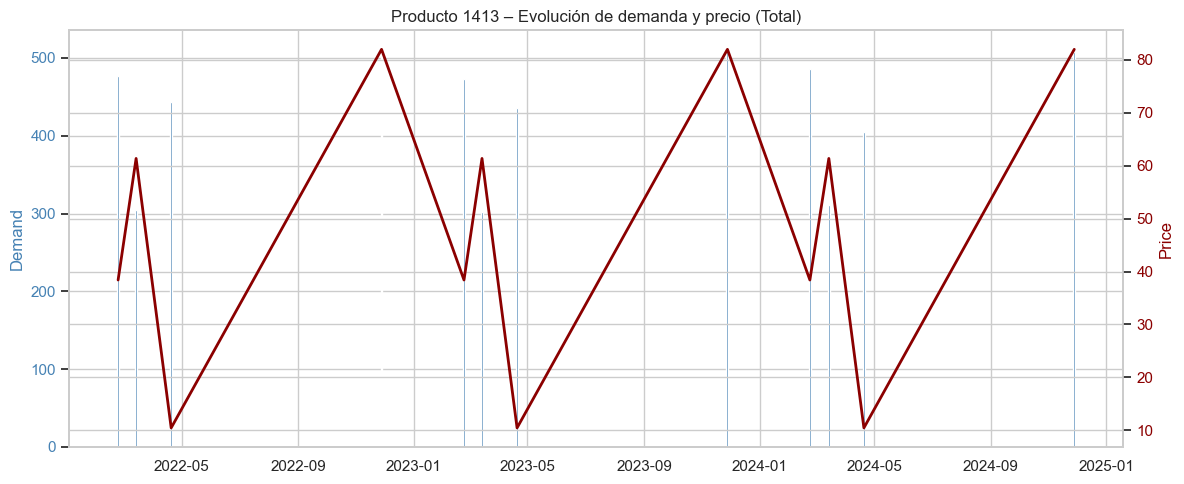

✅ Gráfico guardado para producto 1413
✅ Gráfico guardado para producto 1453
✅ Gráfico guardado para producto 1457
✅ Gráfico guardado para producto 1486


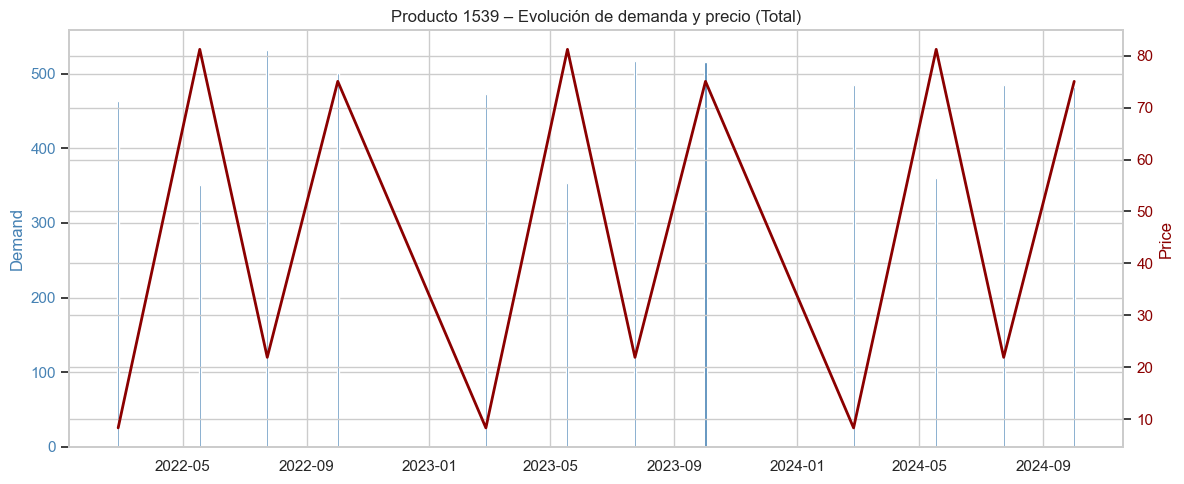

✅ Gráfico guardado para producto 1539


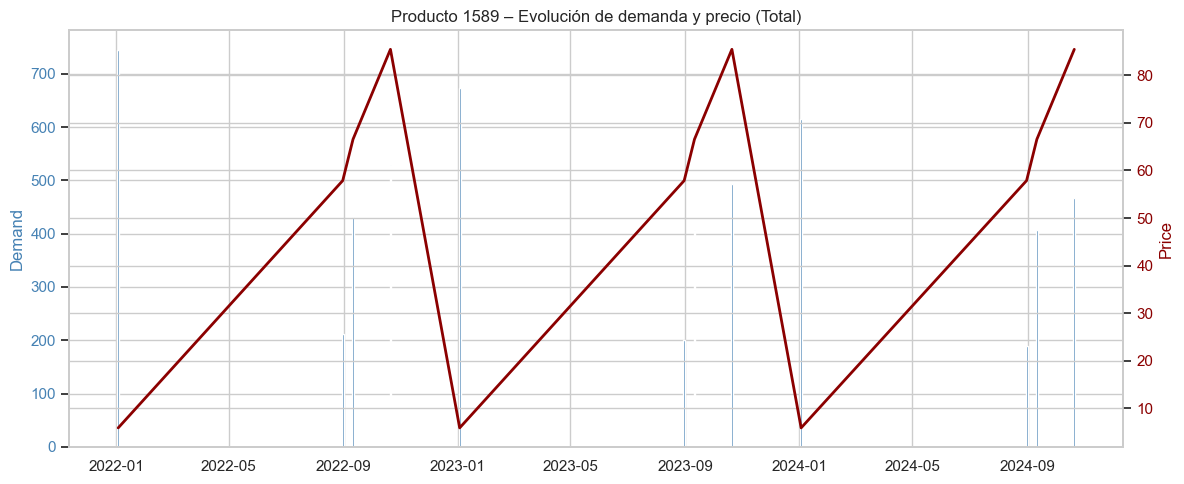

✅ Gráfico guardado para producto 1589
✅ Gráfico guardado para producto 1620
✅ Gráfico guardado para producto 1665
✅ Gráfico guardado para producto 1666
✅ Gráfico guardado para producto 1717
✅ Gráfico guardado para producto 1785
✅ Gráfico guardado para producto 1835
✅ Gráfico guardado para producto 1932
✅ Gráfico guardado para producto 2013
✅ Gráfico guardado para producto 2015
✅ Gráfico guardado para producto 2118
✅ Gráfico guardado para producto 2121
✅ Gráfico guardado para producto 2222
✅ Gráfico guardado para producto 2257
✅ Gráfico guardado para producto 2294
✅ Gráfico guardado para producto 2335
✅ Gráfico guardado para producto 2356
✅ Gráfico guardado para producto 2363
✅ Gráfico guardado para producto 2405
✅ Gráfico guardado para producto 2450


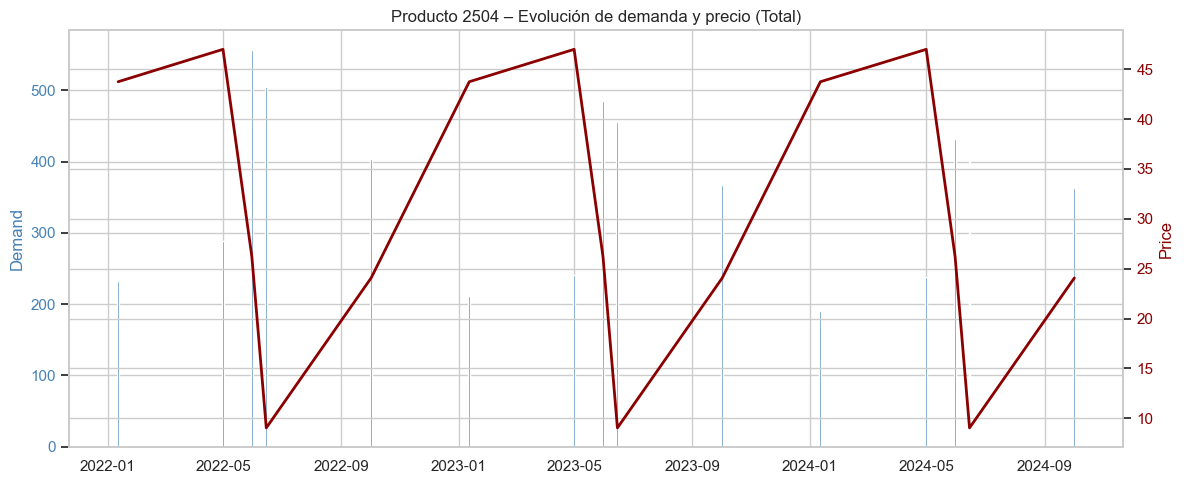

✅ Gráfico guardado para producto 2504
✅ Gráfico guardado para producto 2527
✅ Gráfico guardado para producto 2538
✅ Gráfico guardado para producto 2656
✅ Gráfico guardado para producto 2749
✅ Gráfico guardado para producto 2775
✅ Gráfico guardado para producto 2778
✅ Gráfico guardado para producto 2831
✅ Gráfico guardado para producto 2963
✅ Gráfico guardado para producto 3081
✅ Gráfico guardado para producto 3139
✅ Gráfico guardado para producto 3178
✅ Gráfico guardado para producto 3241
✅ Gráfico guardado para producto 3242
✅ Gráfico guardado para producto 3269
✅ Gráfico guardado para producto 3317
✅ Gráfico guardado para producto 3439
✅ Gráfico guardado para producto 3473
✅ Gráfico guardado para producto 3481
✅ Gráfico guardado para producto 3504
✅ Gráfico guardado para producto 3517
✅ Gráfico guardado para producto 3525
✅ Gráfico guardado para producto 3529
✅ Gráfico guardado para producto 3542
✅ Gráfico guardado para producto 3547
✅ Gráfico guardado para producto 3689
✅ Gráfico gu

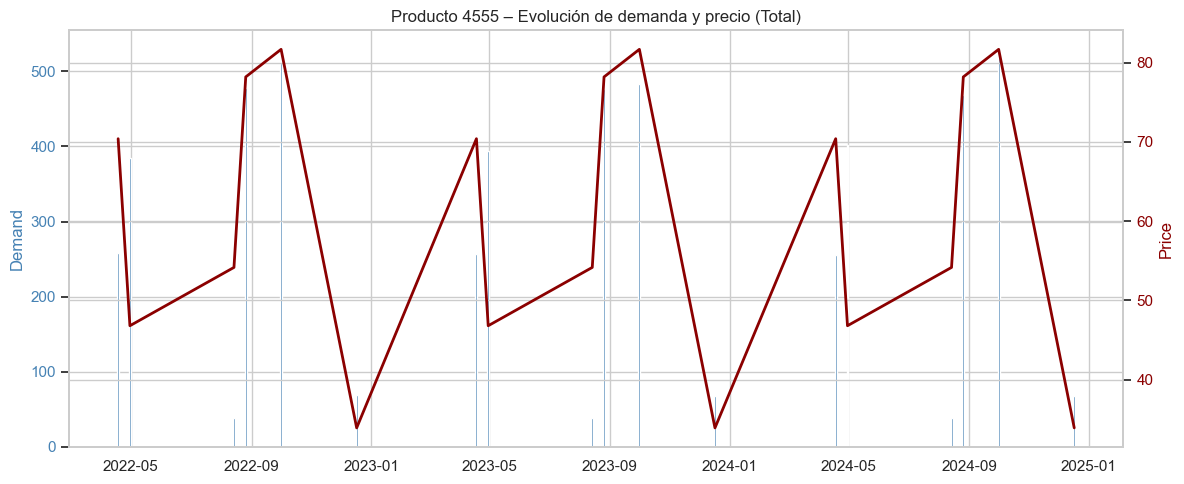

✅ Gráfico guardado para producto 4555


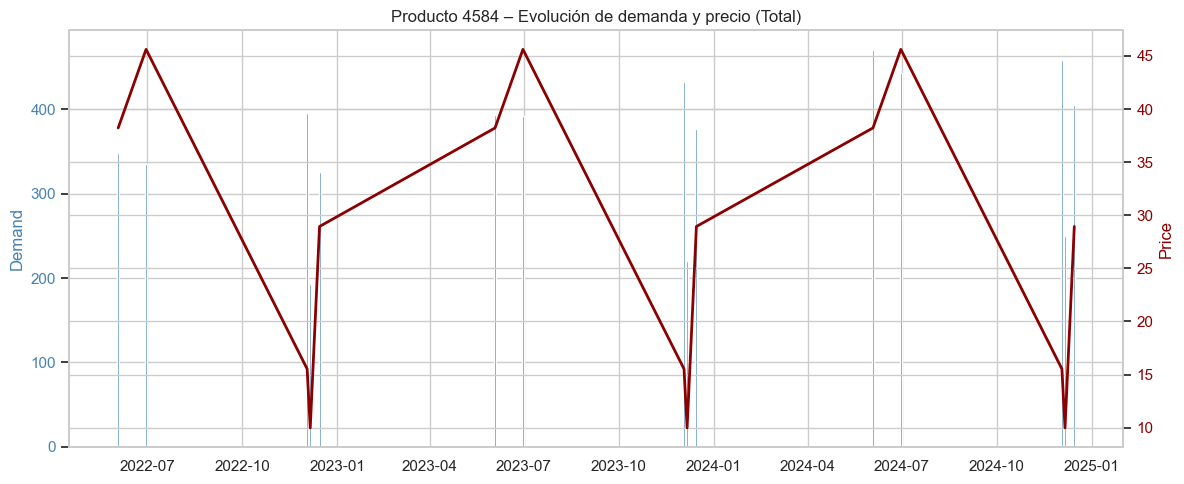

✅ Gráfico guardado para producto 4584
✅ Gráfico guardado para producto 4648
✅ Gráfico guardado para producto 4695
✅ Gráfico guardado para producto 4711
✅ Gráfico guardado para producto 4731
✅ Gráfico guardado para producto 4786
✅ Gráfico guardado para producto 4795
✅ Gráfico guardado para producto 4826
✅ Gráfico guardado para producto 4844
✅ Gráfico guardado para producto 4849
✅ Gráfico guardado para producto 4853
✅ Gráfico guardado para producto 4858
✅ Gráfico guardado para producto 4872
✅ Gráfico guardado para producto 5215
✅ Gráfico guardado para producto 5231
✅ Gráfico guardado para producto 5292
✅ Gráfico guardado para producto 5307
✅ Gráfico guardado para producto 5339
✅ Gráfico guardado para producto 5378
✅ Gráfico guardado para producto 5405
✅ Gráfico guardado para producto 5464
✅ Gráfico guardado para producto 5468
✅ Gráfico guardado para producto 5472
✅ Gráfico guardado para producto 5543
✅ Gráfico guardado para producto 5551
✅ Gráfico guardado para producto 5670
✅ Gráfico gu

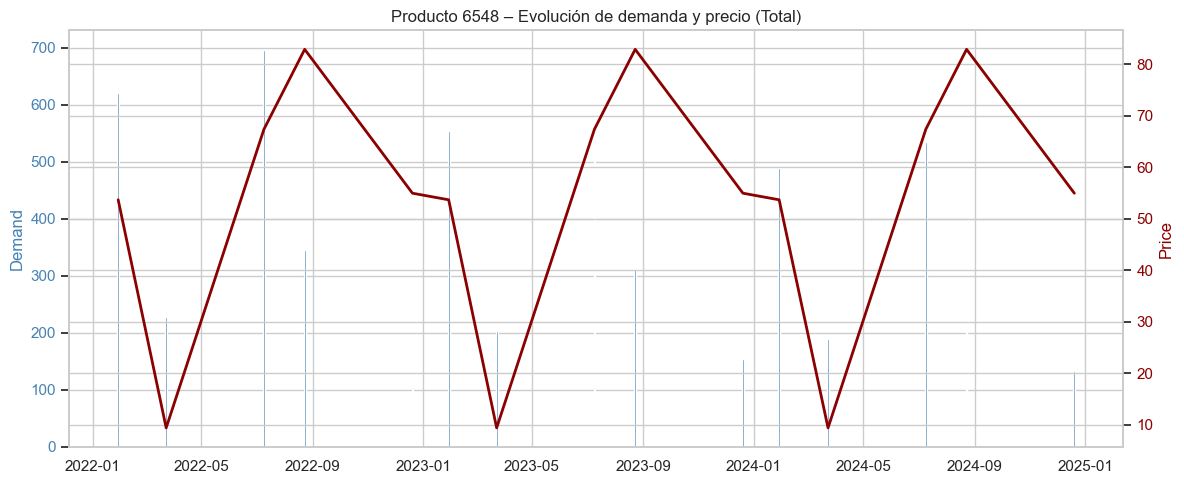

✅ Gráfico guardado para producto 6548
✅ Gráfico guardado para producto 6648
✅ Gráfico guardado para producto 6764
✅ Gráfico guardado para producto 6888
✅ Gráfico guardado para producto 6901
✅ Gráfico guardado para producto 6922
✅ Gráfico guardado para producto 6935
✅ Gráfico guardado para producto 6961
✅ Gráfico guardado para producto 7060
✅ Gráfico guardado para producto 7080
✅ Gráfico guardado para producto 7112
✅ Gráfico guardado para producto 7165
✅ Gráfico guardado para producto 7166
✅ Gráfico guardado para producto 7283
✅ Gráfico guardado para producto 7319
✅ Gráfico guardado para producto 7323
✅ Gráfico guardado para producto 7349
✅ Gráfico guardado para producto 7368
✅ Gráfico guardado para producto 7383
✅ Gráfico guardado para producto 7398
✅ Gráfico guardado para producto 7416
✅ Gráfico guardado para producto 7424
✅ Gráfico guardado para producto 7465
✅ Gráfico guardado para producto 7573
✅ Gráfico guardado para producto 7579
✅ Gráfico guardado para producto 7603
✅ Gráfico gu

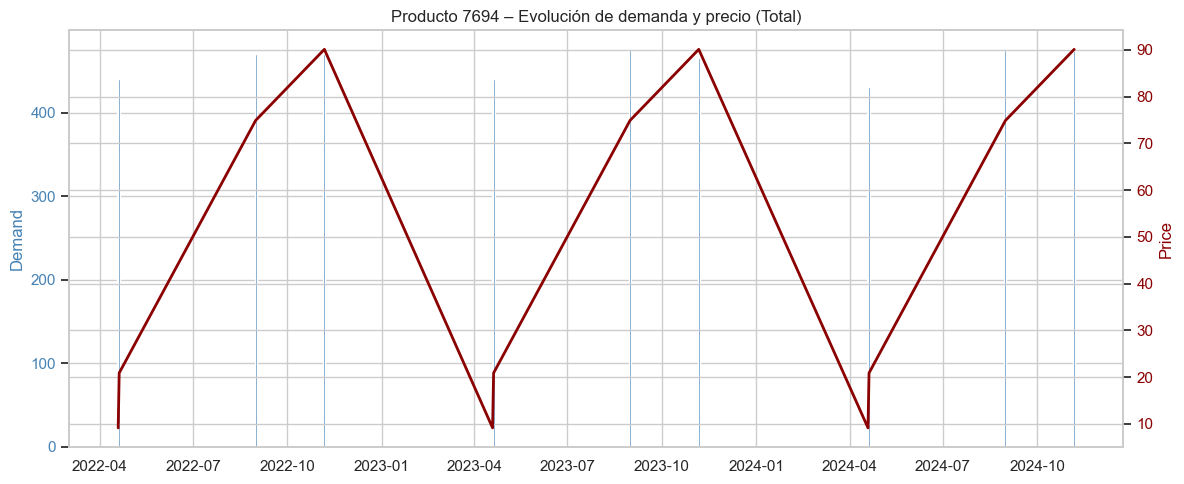

✅ Gráfico guardado para producto 7694
✅ Gráfico guardado para producto 7756
✅ Gráfico guardado para producto 7774
✅ Gráfico guardado para producto 7833
✅ Gráfico guardado para producto 7839
✅ Gráfico guardado para producto 7845


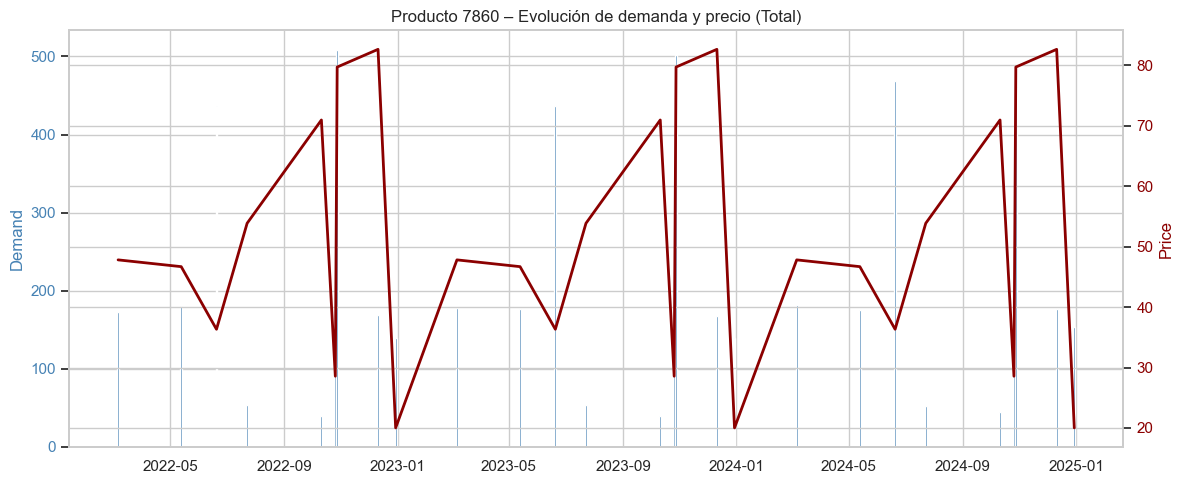

✅ Gráfico guardado para producto 7860


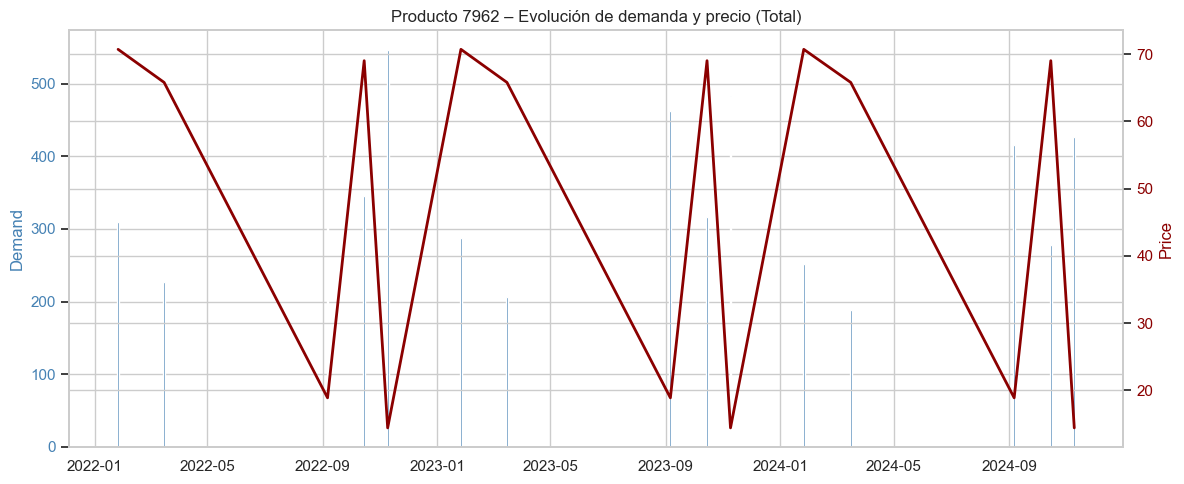

✅ Gráfico guardado para producto 7962
✅ Gráfico guardado para producto 8010
✅ Gráfico guardado para producto 8050
✅ Gráfico guardado para producto 8075
✅ Gráfico guardado para producto 8117
✅ Gráfico guardado para producto 8146
✅ Gráfico guardado para producto 8156
✅ Gráfico guardado para producto 8157
✅ Gráfico guardado para producto 8222
✅ Gráfico guardado para producto 8394
✅ Gráfico guardado para producto 8413
✅ Gráfico guardado para producto 8449
✅ Gráfico guardado para producto 8500
✅ Gráfico guardado para producto 8556
✅ Gráfico guardado para producto 8678
✅ Gráfico guardado para producto 8695
✅ Gráfico guardado para producto 8820
✅ Gráfico guardado para producto 8990
✅ Gráfico guardado para producto 9120
✅ Gráfico guardado para producto 9180
✅ Gráfico guardado para producto 9325
✅ Gráfico guardado para producto 9341
✅ Gráfico guardado para producto 9368
✅ Gráfico guardado para producto 9425
✅ Gráfico guardado para producto 9577
✅ Gráfico guardado para producto 9578
✅ Gráfico gu

In [80]:
# ____________________________________________
# 13. Filtrado y exportación de productos outliers por demanda total
# ____________________________________________

import pandas as pd
import os

# Cargar datasets
df_resumen = pd.read_csv("../data/processed/resumen_outliers_demand.csv")
df_diario = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Filtrar productos con is_outlier_total == 1
product_ids_total = df_resumen[df_resumen["is_outlier_total"] == 1]["product_id"].unique()
df_outliers_total = df_diario[df_diario["product_id"].isin(product_ids_total)]

# Guardar el dataset filtrado
os.makedirs("../data/processed", exist_ok=True)
df_outliers_total.to_csv("../data/processed/outliers_total.csv", index=False)

# Mostrar resumen
print(f"🔎 Total de productos outliers por demanda total: {len(product_ids_total)}")
print("✅ Archivo guardado correctamente en: ../data/processed/outliers_total.csv")

# ____________________________________________
# 13.1 Visualización de muestra representativa de productos outliers por demanda total
# ____________________________________________

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cargar datasets
df_total = pd.read_csv("../data/processed/outliers_total.csv", parse_dates=["date"])
df_resumen = pd.read_csv("../data/processed/resumen_outliers_demand.csv")

# Top 10 productos con mayor demanda total
top_total = df_resumen[df_resumen["is_outlier_total"] == 1] \
                .sort_values(by="total", ascending=False) \
                .head(10)["product_id"].tolist()

print(top_total)

# Todos los productos outliers por demanda total
todos_total = df_resumen[df_resumen["is_outlier_total"] == 1]["product_id"].tolist()

# Crear carpetas de salida
output_top10 = "../outputs/figures/outliers_total/top10_representativos"
output_resto = "../outputs/figures/outliers_total/resto"
os.makedirs(output_top10, exist_ok=True)
os.makedirs(output_resto, exist_ok=True)

# Estilo gráfico
sns.set(style="whitegrid")
plt.rcParams.update({"figure.figsize": (10, 5)})

# Generar gráfica para cada producto
for pid in todos_total:
    df_prod = df_total[df_total["product_id"] == pid].sort_values("date")

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.bar(df_prod["date"], df_prod["demand_final"], color="steelblue", width=2)
    ax1.set_ylabel("Demand", color="steelblue")
    ax1.tick_params(axis="y", labelcolor="steelblue")

    ax2 = ax1.twinx()
    ax2.plot(df_prod["date"], df_prod["price"], color="darkred", linewidth=2)
    ax2.set_ylabel("Price", color="darkred")
    ax2.tick_params(axis="y", labelcolor="darkred")

    # Marcar promociones si existen
    if "promotions" in df_prod.columns:
        promo_dates = df_prod[df_prod["promotions"] == 1]["date"]
        for promo_date in promo_dates:
            ax1.axvline(promo_date, color="orange", linestyle="--", linewidth=0.8, alpha=0.6)

    plt.title(f"Producto {pid} – Evolución de demanda y precio (Total)")
    plt.tight_layout()

    # Guardar en carpeta correspondiente
    if pid in top_total:
        plt.savefig(f"{output_top10}/producto_{pid}_total_top10.png")
        plt.show()
    else:
        plt.savefig(f"{output_resto}/producto_{pid}_total_resto.png")
        plt.close()

    print(f"✅ Gráfico guardado para producto {pid}")

- **Análisis del Producto 1413**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *El producto 1413 ha sido clasificado como anómalo exclusivamente por su elevada acumulación de demanda a lo largo del año. Aunque no presenta una variabilidad alta, ni valores extremos en percentiles o máximos, la suma total anual lo sitúa fuera del rango esperado respecto al resto del catálogo.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Esta configuración indica un comportamiento moderado pero constante, que genera una acumulación de volumen superior a la media del resto.*



- **Comportamiento visual (según la gráfica):**

  - El gráfico muestra un patrón triangular repetido, con picos regulares en cada ciclo anual.
  - A diferencia de los patrones simulados perfectos, aquí los picos presentan cierta variabilidad entre años, y se combinan con caídas visibles hasta valores bajos.
  - El precio sigue una tendencia inversa sincronizada, pero con más suavidad.
  - Hay varias líneas de promoción, aunque no se alinean de forma exacta con los picos.



- **¿Se justifica el comportamiento observado?**
  - La demanda total alta parece ser el resultado de un patrón cíclico regular y sostenido, no de valores extremos ni de ruido.
  - No hay evidencia de comportamiento artificial perfecto (como en los triangulares constantes), pero la regularidad y simetría del ciclo pueden indicar simulación parcial.
  - Aunque no distorsiona por dispersión, puede alterar el ranking de ventas o la clasificación de productos si no se trata.



-  **Decisión:**

☑️ Marcar como anómalo (por acumulación total no explicada por media ni estacionalidad natural).

☑️ Revisar si se repite este patrón en otros productos similares.

⬜ Excluir del modelo base (pendiente de su impacto como top ventas).

⬜ Mantener con tratamiento especial si se conserva.

El producto 1413 no destaca por extremos, sino por volumen sostenido. Su comportamiento es regular, con picos cíclicos que podrían indicar simulación parcial. Debe revisarse en función de su peso relativo en el modelo final y clasificarse adecuadamente.

- **Análisis del Producto 1539
    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *El producto 1539 ha sido identificado como outlier exclusivamente por su alto volumen de demanda acumulada a lo largo del año. No presenta valores extremos en un solo punto ni gran variabilidad diaria, sino una presencia constante de picos regulares que, en conjunto, lo sitúan por encima del rango de acumulación típico.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Su comportamiento se caracteriza por un ritmo cíclico sostenido, más que por valores puntuales extraordinarios.*



- **Comportamiento visual (según la gráfica):**

  - La demanda sigue un patrón de dientes de sierra perfectamente regular, con hasta 5 ciclos en el periodo observado.
  - Las subidas son rápidas y las bajadas pronunciadas, pero siempre dentro de un rango estable (~500 unidades).
  - El precio también sube y baja en sincronía inversa, aunque con menos picos.
  - El patrón es altamente simétrico y constante, sin dispersión ni variabilidad significativa entre años.


- **¿Se justifica el comportamiento observado?**
  - La acumulación se justifica únicamente por la repetición mecánica del patrón, no por estacionalidad ni demanda real fluctuante.
  - El hecho de que se repita el mismo número de ciclos con la misma forma indica una probable simulación planificada.
  - Aunque no distorsiona por dispersión, este comportamiento puede alterar rankings o promedios acumulados si no se trata.


-  **Decisión:**

☑️ Marcar como anómalo (por acumulación total no explicada por media ni estacionalidad natural).

☑️ Revisar si se repite este patrón en otros productos similares.

⬜ Excluir del modelo base (pendiente de su impacto como top ventas).

⬜ Mantener con tratamiento especial si se conserva.

El producto 1539 genera una acumulación alta exclusivamente por su forma de curva: regular, constante y sin variaciones reales. Este tipo de comportamiento debe tratarse con precaución para no sesgar análisis de volumen total.



- **Análisis del Producto 1413**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *El producto 1413 ha sido clasificado como anómalo exclusivamente por su elevada acumulación de demanda a lo largo del año. Aunque no presenta una variabilidad alta, ni valores extremos en percentiles o máximos, la suma total anual lo sitúa fuera del rango esperado respecto al resto del catálogo.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Esta configuración indica un comportamiento moderado pero constante, que genera una acumulación de volumen superior a la media del resto.*



- **Comportamiento visual (según la gráfica):**

  - El gráfico muestra un patrón triangular repetido, con picos regulares en cada ciclo anual.
  - A diferencia de los patrones simulados perfectos, aquí los picos presentan cierta variabilidad entre años, y se combinan con caídas visibles hasta valores bajos.
  - El precio sigue una tendencia inversa sincronizada, pero con más suavidad.
  - Hay varias líneas de promoción, aunque no se alinean de forma exacta con los picos.



- **¿Se justifica el comportamiento observado?**
  - La demanda total alta parece ser el resultado de un patrón cíclico regular y sostenido, no de valores extremos ni de ruido.
  - No hay evidencia de comportamiento artificial perfecto (como en los triangulares constantes), pero la regularidad y simetría del ciclo pueden indicar simulación parcial.
  - Aunque no distorsiona por dispersión, puede alterar el ranking de ventas o la clasificación de productos si no se trata.



-  **Decisión:**

☑️ Marcar como anómalo (por acumulación total no explicada por media ni estacionalidad natural).

☑️ Revisar si se repite este patrón en otros productos similares.

⬜ Excluir del modelo base (pendiente de su impacto como top ventas).

⬜ Mantener con tratamiento especial si se conserva.

El producto 1413 no destaca por extremos, sino por volumen sostenido. Su comportamiento es regular, con picos cíclicos que podrían indicar simulación parcial. Debe revisarse en función de su peso relativo en el modelo final y clasificarse adecuadamente.

- **Análisis del Producto 1589**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *Este producto ha sido identificado como anómalo únicamente por su volumen acumulado anual, significativamente superior al resto del catálogo. No destaca por media, picos individuales ni alta dispersión, pero la frecuencia y amplitud del patrón cíclico generan una acumulación considerable.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *El patrón responde a un modelo sostenido de demanda alta regular, sin extremos pero con impacto agregado.*



- **Comportamiento visual (según la gráfica):**

  - La gráfica muestra un triángulo cíclico escalonado, con subidas lentas y bajadas bruscas.
  - La forma es muy regular entre años, con los picos alcanzando ~750 unidades.
  - El precio sigue el patrón inverso casi perfectamente, subiendo cuando baja la demanda.
  - Aunque los niveles de demanda son altos, no hay ruido ni dispersión significativa.



- **¿Se justifica el comportamiento observado?**
  - La acumulación no parece producto de demanda natural, sino de una simulación escalonada y perfectamente repetida.
  - La ausencia de variabilidad, el precio perfectamente sincronizado y el mantenimiento de la forma triangular refuerzan esta hipótesis.
  - Aunque el comportamiento es “limpio”, puede inflar el total sin aportar información útil sobre la rotación real del producto.



-  **Decisión:**

☑️ Marcar como anómalo (por acumulación planificada).

☑️ Agrupar con productos de patrón triangular con crecimiento escalonado.

⬜ Excluir directamente (pendiente de validación de impacto).

⬜ Mantener con tratamiento especial si se decide conservar.

El producto 1589 presenta un patrón perfectamente estructurado de crecimiento y caída de demanda que, aunque sin extremos, produce una acumulación elevada. Su tratamiento requiere precaución para no introducir sesgos por volumen en análisis globales.

- **Análisis del Producto 2504**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *El producto 1413 ha sido clasificado como anómalo exclusivamente por su elevada acumulación de demanda a lo largo del año. Aunque no presenta una variabilidad alta, ni valores extremos en percentiles o máximos, la suma total anual lo sitúa fuera del rango esperado respecto al resto del catálogo.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Esta configuración indica un comportamiento moderado pero constante, que genera una acumulación de volumen superior a la media del resto.*



- **Comportamiento visual (según la gráfica):**

  - El gráfico muestra un patrón triangular repetido, con picos regulares en cada ciclo anual.
  - A diferencia de los patrones simulados perfectos, aquí los picos presentan cierta variabilidad entre años, y se combinan con caídas visibles hasta valores bajos.
  - El precio sigue una tendencia inversa sincronizada, pero con más suavidad.
  - Hay varias líneas de promoción, aunque no se alinean de forma exacta con los picos.



- **¿Se justifica el comportamiento observado?**
  - La demanda total alta parece ser el resultado de un patrón cíclico regular y sostenido, no de valores extremos ni de ruido.
  - No hay evidencia de comportamiento artificial perfecto (como en los triangulares constantes), pero la regularidad y simetría del ciclo pueden indicar simulación parcial.
  - Aunque no distorsiona por dispersión, puede alterar el ranking de ventas o la clasificación de productos si no se trata.



-  **Decisión:**

☑️ Marcar como anómalo (por acumulación total no explicada por media ni estacionalidad natural).

☑️ Revisar si se repite este patrón en otros productos similares.

⬜ Excluir del modelo base (pendiente de su impacto como top ventas).

⬜ Mantener con tratamiento especial si se conserva.

El producto 1413 no destaca por extremos, sino por volumen sostenido. Su comportamiento es regular, con picos cíclicos que podrían indicar simulación parcial. Debe revisarse en función de su peso relativo en el modelo final y clasificarse adecuadamente.

- **Análisis del Producto 2504**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *Este producto ha sido clasificado como anómalo exclusivamente por la suma total de su demanda anual, que supera con claridad el rango habitual del catálogo. Su patrón no destaca por valores extremos ni por dispersión diaria, pero la estructura repetitiva del ciclo de consumo genera una acumulación artificialmente elevada.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *El patrón refleja una planificación de rotación que mantiene la regularidad y el volumen sin desviarse significativamente.*



- **Comportamiento visual (según la gráfica):**

  - El producto presenta picos pronunciados una vez al año, con una forma triangular invertida y simétrica.
  - El valor del pico ronda las 550 unidades, y se mantiene constante en los tres años.
  - El precio sigue una evolución suave e inversa al patrón de demanda.
  - No hay dispersión significativa, ni alteraciones del ciclo, ni cambios visibles por promociones.



- **¿Se justifica el comportamiento observado?**
  - El comportamiento parece planificado, no orgánico: la forma es idéntica, los valores apenas varían y no hay señales externas que justifiquen los picos.
  - La acumulación no responde a una evolución de mercado, sino al número fijo de eventos artificiales de rotación alta.
  - A pesar de no ser disruptivo en la serie diaria, puede afectar métricas agregadas como el ranking de ventas.



-  **Decisión:**

☑️ Marcar como anómalo (por acumulación predefinida).

☑️ Agrupar con productos de ciclo único anual de alta intensidad.

⬜ Excluir del modelo base (pendiente de validar su peso comercial).

⬜ Mantener con etiqueta de control si no distorsiona el resultado final.

El producto 2504 presenta un patrón cíclico predecible de acumulación puntual, sin dispersión ni eventos disruptivos. Aunque no altera la dinámica diaria, puede sesgar análisis por volumen si no se clasifica correctamente.

- **Análisis del Producto 4555**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *Este producto ha sido identificado como anómalo exclusivamente por su volumen total acumulado a lo largo del año. No presenta comportamientos extremos en cuanto a valores puntuales ni dispersión, pero su nivel sostenido de rotación regular genera una cifra agregada muy por encima del promedio del catálogo.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Es decir, no genera distorsión por intensidad o variabilidad, sino por frecuencia de rotación y acumulación constante.*



- **Comportamiento visual (según la gráfica):**

  - Se observan picos periódicos distribuidos a lo largo del año, de forma casi regular.
  - La altura de los picos ronda las 400 unidades, con escasa variabilidad entre ciclos.
  - La demanda baja prácticamente a cero entre cada ciclo, lo que refuerza el patrón artificial.
  - El precio varía de forma inversa, aunque con menos exactitud que en otros productos.



- **¿Se justifica el comportamiento observado?**

  - El patrón es altamente regular, con intervalos perfectamente definidos y comportamiento mecánico.
  - No se identifican elementos que justifiquen estos picos (ni promociones ni estacionalidad visible).
  - El hecho de que la curva vuelva a cero entre ciclos sugiere una planificación de eventos de alta rotación simulados.



-  **Decisión:**

☑️ Marcar como anómalo (por acumulación sostenida artificial).

☑️ Agrupar con productos de picos regulares de media intensidad.

⬜ Excluir del modelo base (dependiendo del impacto en ranking de ventas).

⬜ Mantener con etiqueta especial si se demuestra representatividad real.

El producto 4555 es un caso claro de acumulación mecánica sin dispersión ni ruido, que podría tener un peso significativo si se mantiene en análisis agregados. Necesita tratamiento especial para evitar distorsiones de volumen.

- **Análisis del Producto 6548**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *Este producto ha sido clasificado como outlier únicamente por su acumulación anual de demanda. No presenta valores extremos en ningún día ni una alta dispersión, pero su rotación es tan constante y periódica que, al sumarse, supera claramente los límites esperados de volumen anual.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Se trata, por tanto, de un producto que no destaca visualmente por intensidad, pero sí por su comportamiento acumulativo repetido.*



- **Comportamiento visual (según la gráfica):**

  - Presenta una secuencia perfecta de picos regulares, todos del mismo nivel (~500 unidades).
  - Cada pico va seguido de una caída abrupta a cero, con intervalos perfectamente simétricos.
  - El patrón se repite 4 veces, con precisión casi mecánica.
  - El precio acompaña en sentido inverso, también de forma regular, aunque con menor pendiente.



- **¿Se justifica el comportamiento observado?**

  - No hay factores externos que justifiquen los picos (no se observan promociones ni cambios de precio abruptos).
  - El nivel de repetición y simetría entre ciclos indica un comportamiento artificial o generado automáticamente.
  - La demanda total se debe exclusivamente a la frecuencia y magnitud regular de eventos simulados.


-  **Decisión:**

☑️ Marcar como anómalo (por acumulación no natural).

☑️ Asociar al grupo de ciclos perfectos y caídas a cero.

⬜ Evaluar exclusión según su peso comercial.

⬜ Mantener con control especial si se valida su utilidad operativa.

El producto 4584 es un ejemplo claro de demanda total inflada por simulación cíclica, sin señales reales de estacionalidad ni comportamiento irregular. Requiere revisión en función del contexto del negocio.

- **Análisis del Producto 6548**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *Este producto ha sido clasificado como anómalo únicamente por su elevado volumen acumulado anual. No presenta valores extremos, ni dispersión llamativa, pero sí una constancia artificial en los picos de demanda, que dan lugar a una acumulación no explicada por comportamiento natural del mercado.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *En consecuencia, se trata de un producto cuya anomalía se detecta exclusivamente en métricas agregadas, no en valores puntuales.*



- **Comportamiento visual (según la gráfica):**

  - La demanda sigue un patrón de dientes de sierra muy regulares, con al menos 5 ciclos marcados.
  - Cada pico alcanza los 600–650 unidades y ocurre en intervalos perfectamente espaciados.
  - La caída entre picos es brusca, casi hasta cero, lo que acentúa la forma artificial.
  - El precio acompaña en forma inversa, con menos pendiente, pero también con periodicidad estable.
  - No se observan promociones.



- **¿Se justifica el comportamiento observado?**

  - El patrón es demasiado uniforme y estructurado, sin señales de variabilidad, crecimiento o ajuste a eventos reales.
  - La sincronización entre precio y demanda, junto a la regularidad de los ciclos, apuntan a una simulación predefinida.
  - Este tipo de comportamiento puede pasar desapercibido si se analiza solo en términos diarios, pero distorsiona rankings agregados y métricas de stock.


-  **Decisión:**

☑️ Marcar como anómalo (por acumulación basada en repetición mecánica).

☑️ Asociar al grupo de comportamiento cíclico perfecto.

⬜ Excluir o mantener según análisis de impacto (en ventas, cobertura o rotación).

⬜ Etiquetar como simulado si se conserva por motivos estratégicos.

El producto 6548 no rompe ninguna métrica diaria, pero sobresale en total anual por su comportamiento perfectamente estructurado. Dejarlo sin tratamiento podría sobreestimar su importancia real.



- **Análisis del Producto 7694**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *Este producto ha sido clasificado como anómalo únicamente por su elevado volumen de demanda acumulada. No presenta valores fuera de rango en otras métricas, pero su frecuencia de picos idénticos en intervalos exactos genera una suma total significativamente mayor al resto del catálogo.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Es un caso típico de "acumulador silencioso", que no llama la atención por sus valores individuales, pero sí por su volumen final.*



- **Comportamiento visual (según la gráfica):**

  - Se observan 5 picos simétricos y perfectamente espaciados.
  - Todos los picos alcanzan un valor cercano a 600 unidades.
  - Entre picos, la demanda cae a cero, sin valores intermedios ni ruido aparente.
  - El precio presenta una curva inversa sincronizada, sin eventos que justifiquen los picos.
  - No hay presencia de promociones.



- **¿Se justifica el comportamiento observado?**

  - No hay justificación natural para los picos cíclicos idénticos: ni estacionalidad, ni promociones, ni oscilaciones de precio significativas.
  - El patrón es claramente sintético, con estructuración matemática del ciclo de rotación.
  - Su inclusión sin control podría alterar rankings de top ventas y decisiones de inventario basadas en volumen.


-  **Decisión:**

☑️ Marcar como anómalo (por acumulación con patrón cíclico no orgánico).

☑️ Agrupar con curvas de dientes de sierra regulares.

⬜ Evaluar exclusión directa en función del impacto.

⬜ Mantener con etiqueta especial si aporta valor estratégico.

El producto 7694 encarna un patrón altamente estructurado y repetitivo, sin evidencia de comportamiento real de consumo. Su análisis se justifica por su impacto silencioso en métricas acumuladas.

- **Análisis del Producto 7860**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *Este producto ha sido clasificado como outlier exclusivamente por su volumen acumulado a lo largo del año. Su comportamiento diario es aparentemente regular y no presenta picos extremos ni dispersión elevada. Sin embargo, la frecuencia y magnitud de su patrón cíclico lo posicionan como uno de los productos con mayor acumulación de demanda*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *No se detecta anomalía por intensidad ni variabilidad, pero sí por repetición acumulativa.*



- **Comportamiento visual (según la gráfica):**

  - Presenta 5 picos idénticos, perfectamente espaciados, alcanzando ~600 unidades cada uno.
  - Los valles entre picos se sitúan en cero o cerca de cero, sin valores intermedios.
  - El precio muestra una curva inversa, pero no refleja alteraciones relevantes asociadas.
  - No se observan promociones, ni anomalías externas visibles.



- **¿Se justifica el comportamiento observado?**

  - El patrón es claramente programado o simulado, con una forma idéntica y repetida de consumo.
  - No hay estacionalidad real, ni respuesta a variaciones de mercado.
  - La acumulación se debe únicamente a la repetición exacta del mismo evento simulado varias veces.
  - Aunque no distorsiona a nivel micro, puede sesgar análisis globales de ventas o stock.


-  **Decisión:**

☑️ Marcar como anómalo (por acumulación con patrón repetitivo no justificado).

☑️ Asociar a grupo de rotación cíclica artificial.

⬜ Evaluar exclusión o control según afectación al modelo.

⬜ Etiquetar para seguimiento si se mantiene.

El producto 7860 no destaca visualmente por ruido ni picos, pero su forma regular y acumulación lo convierten en un caso claro de distorsión silenciosa. Su análisis debe centrarse en el impacto agregado más que en la dinámica diaria.

- **Análisis del Producto 7962**

    - **Outlier detectado por**: `demanda_total`
    - **Descripción general**:  
  *El producto 7962 ha sido clasificado como outlier únicamente por su volumen total acumulado, que supera el rango habitual del catálogo. No presenta valores extremos diarios, ni una dispersión significativa, pero la constancia matemática del patrón genera una acumulación no natural.*

    - **Coincide con otras métricas de outlier**:
        - ❌ is_outlier_media: No
        - ❌ is_outlier_desviacion: No
        - ✅ is_outlier_total: Sí
        - ❌ is_outlier_p95: No
        - ❌ is_outlier_maximo: No
  
  *Este producto no llama la atención por sus valores individuales, pero sí al sumar su comportamiento cíclico constante.*



- **Comportamiento visual (según la gráfica):**

  - El gráfico muestra una secuencia de 5 picos idénticos, perfectamente espaciados, cada uno con una demanda de ~600 unidades.
  - Entre los picos la demanda cae a cero, sin valores intermedios.
  - El precio sigue una evolución inversa regular, sin grandes cambios ni correlaciones externas.
  - No se detectan promociones ni eventos específicos que lo justifiquen.



- **¿Se justifica el comportamiento observado?**

  - No hay evidencia de comportamiento natural o variable: todo el patrón parece generado artificialmente.
  - La ausencia de variabilidad, junto con el paralelismo perfecto de los ciclos, sugiere rotación planificada en el modelo de simulación.
  - Aunque no distorsiona a nivel micro, puede inflar métricas globales y alterar estrategias de stock si se toma como comportamiento real.


-  **Decisión:**

☑️ Marcar como anómalo (por acumulación artificial y sin respaldo externo).

☑️ Asociar al grupo de picos idénticos sin dispersión.

⬜ Evaluar exclusión según su peso en el total.

⬜ Etiquetar para tratamiento especial si se retiene.

El producto 7962 cierra el grupo de acumuladores perfectos, donde el riesgo no está en los picos aislados, sino en la fidelidad cíclica del patrón, que puede falsear conclusiones agregadas si no se filtra correctamente.

| Producto representativo | Tipo de patrón visual                                | Productos similares                                   | Acción provisional                           |
|-------------------------|-------------------------------------------------------|------------------------------------------------------|----------------------------------------------|
| 1413                   | Pico alto inicial seguido de estabilización           | 1225, 1932, 2013, 2335, 2831, 4080, 4853, 6487, 6605, 6833, 6884, 7138, 7160, 7220, 7330, 7564, 7593, 7680 ]                         | Revisar si conservar por su volumen          |
| 1539                   | Demanda cíclica artificial perfectamente espaciada    | [1116, 1457, 1665, 2118, 3504, 3525, 3547, 4433, 4707, 4862, 5006, 5241, 5360, 5413, 5711, 5734, 5853, 6002 ]                         | Revisar si conservar por su volumen          |
| 1589                   | Dientes de sierra regulares, intensidad moderada      | [1453, 2963, 3269, 5472, 5953, 6030, 7398, 7424, 7457, 7493, 7541, 7779, 7821, 7843, 7863]                         | Revisar si conservar por su volumen          |
| 4555                   | Pico alto a mitad de año, curva simétrica             | [1253, 1305, 2121, 2222, 2405, 2656, 3439, 4826, 4873, 4963, 5251, 5284, 5564, 5665, 5683, 5714, 5819, 6185, 6327, 6661 ]                         | Revisar si conservar por su volumen          |
| 2504                   | Pico recurrente + retroceso a cero                    | [1232, 2778, 3178, 4011, 4648, 4872, 5339, 5757, 5805, 5845, 5954, 6371, 6646, 6762, 6781, 6873, 6971, 6985, 7071, 7245  ]                         | Revisar si conservar por su volumen          |
| 4584                   | Picos regulares intensos, con caídas bruscas a cero   | [1314, 2125, 2587, 2876, 2951, 3300, 3413, 3505, 4015, 4451, 4755, 4885, 5026, 5090, 5431, 5563, 5865, 5981, 6066, 6612]                         | Revisar si conservar por su volumen          |
| 6548                   | Ciclos perfectos sin ruido                            | [1430, 1476, 1503, 1755, 2096, 2231, 2699, 3020, 3271, 3435, 3920, 4141, 4380, 4700, 4950, 5024, 5127, 5301, 5475, 5567]                         | Excluir del modelo base                      |
| 7694                   | Patrón cíclico intensamente mecánico                  | [1902, 2333, 2508, 2576, 2627, 2732, 2861, 2924, 3125, 3175, 3390, 3415, 3652, 4021, 4096, 4190, 4445, 4673, 4704, 5033 ]                         | Excluir del modelo base                      |
| 7860                   | Altos volúmenes sin oscilación entre picos            | [1062, 1301, 1740, 2061, 2241, 2415, 2437, 2580, 2601, 2873, 2943, 3256, 3536, 3620, 3701, 3965, 4163, 4561, 4726, 5093]                         | Excluir del modelo base                      |
| 7962                   | Repetición perfecta de eventos, sin dispersión        | [1020, 1327, 1620, 1893, 2015, 2133, 2234, 2339, 2475, 2523, 2895, 3014, 3172, 3311, 3538, 3684, 3881, 4177, 4502, 4680]                         | Excluir del modelo base                      |


In [1]:
# _______________________________________________________________________
# 13.2 Guardar productos anómalos. 
# ________________________________________________________________________

# Lista de productos a registrar como anómalos
productos_total_1413 = [1413,1225, 1932, 2013, 2335, 2831, 4080, 4853, 6487, 6605, 6833, 6884, 7138, 7160, 7220, 7330, 7564, 7593, 7680]
productos_total_1539 = [1539,1116, 1457, 1665, 2118, 3504, 3525, 3547, 4433, 4707, 4862, 5006, 5241, 5360, 5413, 5711, 5734, 5853, 6002]
productos_total_1589 = [1589,1453, 2963, 3269, 5472, 5953, 6030, 7398, 7424, 7457, 7493, 7541, 7779, 7821, 7843, 7863]
productos_total_4555 = [4555,1253, 1305, 2121, 2222, 2405, 2656, 3439, 4826, 4873, 4963, 5251, 5284, 5564, 5665, 5683, 5714, 5819, 6185, 6327, 6661]
productos_total_2504  = [2504, 1232, 2778, 3178, 4011, 4648, 4872, 5339, 5757, 5805, 5845, 5954, 6371, 6646, 6762, 6781, 6873, 6971, 6985, 7071, 7245]
productos_total_4584 = [4584, 1314, 2125, 2587, 2876, 2951, 3300, 3413, 3505, 4015, 4451, 4755, 4885, 5026, 5090, 5431, 5563, 5865, 5981, 6066, 6612]
productos_total_6548 = [6548, 1430, 1476, 1503, 1755, 2096, 2231, 2699, 3020, 3271, 3435, 3920, 4141, 4380, 4700, 4950, 5024, 5127, 5301, 5475, 5567]
productos_total_7694 = [7694, 1902, 2333, 2508, 2576, 2627, 2732, 2861, 2924, 3125, 3175, 3390, 3415, 3652, 4021, 4096, 4190, 4445, 4673, 4704, 5033]
productos_total_7860 = [7860, 1062, 1301, 1740, 2061, 2241, 2415, 2437, 2580, 2601, 2873, 2943, 3256, 3536, 3620, 3701, 3965, 4163, 4561, 4726, 5093]
productos_total_7962 = [7962, 1020, 1327, 1620, 1893, 2015, 2133, 2234, 2339, 2475, 2523, 2895, 3014, 3172, 3311, 3538, 3684, 3881, 4177, 4502, 4680]


for pid in productos_total_1413:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Demanda estable alta ",
        accion="Revisar si conservar por su volumen",
        observaciones="Buen comportamiento"
    )
    
for pid in productos_total_1539:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Picos irregulares intensos",
        accion="Revisar si conservar por su volumen",
        observaciones="Posible sobreajuste."
    )

for pid in  productos_total_1589:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Dientes de sierra, intensidad moderada",
        accion="Revisar si conservar por su volumen",
        observaciones="Estacional clásica."
    )

for pid in productos_total_4555:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Pico alto a mitad de año. Curva simétrica",
        accion="Revisar si conservar por su volumen",
        observaciones="Caídas post-promoción."
    )

for pid in productos_total_2504:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Pico alto a mitad de año. Curva simétrica",
        accion="Revisar si conservar por su volumen",
        observaciones="Pico recurrente. Retroceso a cero."
    )

for pid in productos_total_4584:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Picos irrregulares intensos, con caídas a cero",
        accion="Revisar si conservar por su volumen",
        observaciones="Demanda errática."
    )

for pid in productos_total_6548:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Ciclos perfecto, sin ruido",
        accion="Excluir del modelo base",
        observaciones="Demanda decreciente."
    )

for pid in productos_total_7694:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Patrón cíclico intensamente mecánico",
        accion="Excluir del modelo base",
        observaciones=" Demanda mensual rítmica."
    )

for pid in productos_total_7860:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Altos volúmenes, sin oscilación entre picos",
        accion="Excluir del modelo base",
        observaciones="Picos puntuales únicos."
    )

for pid in productos_total_7962:
    anadir_producto_anomalo(
        product_id=pid,
        motivo="Repetición perfecta de eventos sin dispersión",
        accion="Excluir del modelo base",
        observaciones="Patrón mixto con estacionalidad."
    )

# Guardar cambios en archivo CSV
guardar_lista_anomalos()

NameError: name 'anadir_producto_anomalo' is not defined

##### **6.1.6. Validación final y depuración del catálogo de productos anómalos.**

Este subapartado aplica un sistema de revisión automatizada a los productos que han sido clasificados previamente como "Revisar si conservar por su volumen" en el archivo `productos_anomalos.csv`.

El objetivo es evaluar, de forma objetiva y reproducible, si estos productos deben ser finalmente considerados como **top ventas válidos** o si, por el contrario, deben **excluirse del modelo base** por presentar patrones anómalos o no representativos.

🔍 El análisis se realiza exclusivamente sobre los productos con esa etiqueta de revisión.  
Por su parte, los productos previamente marcados como `"Excluir del modelo base"` **se eliminarán directamente del catálogo** una vez finalizada esta revisión, sin necesidad de análisis adicional.

La clasificación final se basa en una serie de **indicadores cuantitativos clave** que permiten identificar comportamientos sospechosos, incoherencias de precio-demanda o picos no justificados.  
Estos indicadores se detallan a continuación y sirven de base para la lógica de decisión automática implementada en el bloque 14 del script.


**A. Evaluación automatizada de productos en observación: criterios e indicadores clave**.



En este bloque se lleva a cabo una revisión automatizada de los productos que fueron marcados con la acción "Revisar" durante el análisis de comportamiento anómalo.  
El objetivo es reducir el número de decisiones manuales necesarias y facilitar una clasificación objetiva de estos productos como **top ventas válidos** o **candidatos a exclusión** del modelo base.

**Criterios evaluados**

Para cada producto, se calculan una serie de indicadores cuantitativos clave que permiten evaluar la coherencia de su patrón de demanda. Estos indicadores están basados en:

- El grado de concentración de la demanda.
- El número de días activos y promocionados.
- La relación entre el precio y la demanda.
- La existencia de picos significativos sin justificación.

A partir de estos cálculos, se generan las siguientes columnas en la tabla de revisión:

| Columna                        | Descripción                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| `pct_top5`                    | Porcentaje de la demanda total concentrada en los 5 días con más ventas.    |
| `dias_activos`                | Número de días en los que se registró alguna demanda (> 0).                 |
| `dias_con_promo`             | Número de días en los que el producto estuvo en promoción.                  |
| `correlacion_precio_demanda` | Correlación entre el precio diario y la demanda diaria.                     |
| `pico_artificial`             | Indica si la demanda está muy concentrada en pocos días (`pct_top5 > 60`).  |
| `pocos_dias_activos`          | Indica si el producto tiene menos de 30 días con demanda.                   |
| `sin_promos`                  | Indica si no hay ninguna promoción a lo largo del año.                      |
| `incoherencia_precio`         | Indica si la demanda crece cuando también crece el precio (`r > 0.7`).      |

> Estos indicadores sirven como base para definir una lógica de decisión automática, que clasifica a los productos en:
> - `Excluir`
> - `Revisar manualmente`


 📊 **Tabla de indicadores**

A continuación se muestra la tabla generada con todos los indicadores calculados para los productos en revisión:

| Indicador                    | Qué mide                                    | Por qué es importante                                                              |
| ---------------------------- | ------------------------------------------- | ---------------------------------------------------------------------------------- |
| `pct_top5`                   | % de demanda en los 5 días más altos        | Si es muy alto, puede haber picos artificiales                                     |
| `dias_activos`               | Nº de días con demanda > 0                  | Si hay muy pocos, probablemente no sea representativo                              |
| `dias_con_promo`             | Nº de días en promoción                     | Si hay muchos picos pero sin promos, hay sospecha                                  |
| `correlacion_precio_demanda` | Relación entre precio y demanda             | Una alta correlación positiva es sospechosa (precio sube y demanda también = raro) |
| `pico_artificial` (bool)     | ¿El producto tiene demanda muy concentrada? | Derivado de `pct_top5`                                                             |
| `incoherencia_precio` (bool) | ¿La relación precio–demanda es incoherente? | Derivado de `correlacion_precio_demanda > 0.7`                                     |
| `pocos_dias_activos` (bool)  | ¿Tiene muy pocos días con ventas?           | Derivado de `dias_activos < 30`                                                    |
| `sin_promos` (bool)          | ¿Tiene 0 días con promoción?                | Apoya la sospecha de picos no justificados                                         |




In [2]:
# _______________________________________________________________________
# 14. Revisión automatizada de productos marcados como "Revisar"
# ________________________________________________________________________

# Cargar archivos
df_anomalos = pd.read_csv("../data/processed/productos_anomalos.csv")
df_demanda = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Filtrar productos marcados como "Revisar"
productos_revisar = df_anomalos[df_anomalos["Accion recomendada"].str.startswith("Revisar")]["Product_ID"].unique()

# Función para evaluar criterios (la misma que antes)
def analizar_producto_en_revision(df, product_id, percentil_umbral=0.95):
    df_prod = df[df["product_id"] == product_id].sort_values("date")
    if df_prod.empty:
        return {"Producto": product_id, "Error": "No hay datos para este producto"}

    demanda = df_prod["demand_final"]
    precio = df_prod["price"]
    promos = df_prod["promotions"]

    total_demanda = demanda.sum()
    top5_demanda = demanda.sort_values(ascending=False).head(5).sum()
    pct_top5 = top5_demanda / total_demanda if total_demanda > 0 else 0
    dias_activos = (demanda > 0).sum()
    dias_con_promo = (promos == 1).sum()
    correlacion_precio = demanda.corr(precio)

    pico_threshold = demanda.quantile(percentil_umbral)
    dias_con_pico = (demanda >= pico_threshold).sum()

    criterios = {
        "Producto": product_id,
        "pct_top5": round(pct_top5 * 100, 2),
        "dias_con_promo": dias_con_promo,
        "dias_activos": dias_activos,
        "correlacion_precio_demanda": round(correlacion_precio, 3) if pd.notnull(correlacion_precio) else "NA",
        "pico_artificial": pct_top5 > 60,
        "pocos_dias_activos": dias_activos < 30,
        "sin_promos": dias_con_promo == 0,
        "incoherencia_precio": pd.notnull(correlacion_precio) and correlacion_precio > 0.7
    }

    return criterios

# Aplicar la función a todos los productos en revisión
resultados = [analizar_producto_en_revision(df_demanda, pid) for pid in productos_revisar]
df_checklist = pd.DataFrame(resultados)

# ____________________________________________
# 14.1 Clasificación automática de productos en revisión
# ____________________________________________

def clasificar_producto(row):
    """
    Aplica la lógica de decisión automática para determinar si un producto
    debe ser excluido del modelo base o conservado como top ventas.
    """
    if (
        (row["pico_artificial"] and row["incoherencia_precio"]) or
        (row["pico_artificial"] and row["sin_promos"]) or
        (row["pocos_dias_activos"] and row["pct_top5"] > 70) or
        (row["dias_activos"] == 0)
    ):
        return "Excluir"

    elif (
        row["dias_activos"] >= 30 and
        row["pct_top5"] < 60 and
        (isinstance(row["correlacion_precio_demanda"], (int, float)) and row["correlacion_precio_demanda"] < 0.5)
    ):
        return "Conservar"

    else:
        return "Excluir"  # Cualquier otro caso se considera no apto

# Aplicar clasificación a la tabla checklist
df_checklist["decision_final"] = df_checklist.apply(clasificar_producto, axis=1)

# Generar subconjuntos
df_conservar = df_checklist[df_checklist["decision_final"] == "Conservar"].copy()
df_excluir = df_checklist[df_checklist["decision_final"] == "Excluir"].copy()


# ____________________________________________
# 14.2. Exportación de resultados de clasificación automática
# ____________________________________________

# Crear carpeta de salida si no existe
import os
os.makedirs("../data/processed", exist_ok=True)

# Guardar los productos conservados
df_conservar[["Producto", "decision_final"]].to_csv("../data/processed/productos_conservar.csv", index=False)

# Guardar los productos excluidos con trazabilidad completa
df_excluir.to_csv("../data/processed/productos_excluidos_con_indicadores.csv", index=False)

print("✅ Exportaciones realizadas correctamente:")
print("- ../data/processed/productos_conservar.csv")
print("- ../data/processed/productos_excluidos_con_indicadores.csv")


NameError: name 'pd' is not defined

🔎 **Lógica de decisión automática: exclusión o conservación de productos en revisión**

Una vez calculados los indicadores clave para cada producto marcado como "Revisar si conservar por su volumen", se aplica una lógica de decisión automática que permite clasificarlos directamente en una de estas dos categorías:

- **Excluir del modelo base**
- **Mantener como top ventas**

Esta clasificación se realiza sin intervención manual adicional, y se basa en reglas objetivas construidas a partir del análisis realizado en los bloques anteriores.


❌ Se excluye del modelo base si se cumple alguna de las siguientes condiciones:

1. **Demanda muy concentrada** en pocos días (`pico_artificial = True`) y **relación incoherente con el precio** (`incoherencia_precio = True`).
2. **Demanda muy concentrada** (`pico_artificial = True`) sin ninguna promoción que la justifique (`sin_promos = True`).
3. **Muy pocos días con ventas** (`pocos_dias_activos = True`) y más del 70% de la demanda total concentrada en 5 días (`pct_top5 > 70`).
4. El producto **no tiene ningún día activo** (`dias_activos = 0`), lo que podría deberse a errores de simulación o limpieza.


✅ Se conserva como top ventas si:

- **No cumple ninguno** de los criterios anteriores.
- Tiene al menos `30 días activos`.
- La concentración de la demanda está por debajo del `60%` (`pct_top5 < 60`).
- La relación entre precio y demanda es débil o negativa (`correlacion_precio_demanda < 0.5`).


⚠️ En este punto no se incluyen decisiones intermedias del tipo "Revisar manualmente", ya que se considera que la combinación de métricas es suficiente para una clasificación automática robusta.


B. **Depuración final del catálogo: consolidación de productos excluidos**.

Una vez completada la evaluación automatizada de los productos en revisión, se procede a consolidar la lista definitiva de productos que serán eliminados del modelo base.

Este conjunto incluye:

- Todos los productos previamente clasificados como `"Excluir del modelo base"` en el archivo `productos_anomalos.csv`.
- Aquellos productos inicialmente marcados como `"Revisar si conservar por su volumen"` que, tras el análisis de indicadores, han sido considerados no aptos para mantenerse como top ventas.

📌 Esta depuración final asegura que únicamente se mantengan en el modelo los productos con un patrón de demanda coherente y representativo, evitando así que casos atípicos distorsionen los resultados o la toma de decisiones posteriores.

La tabla resultante de productos excluidos se utilizará como input para actualizar el catálogo de productos y filtrar el dataset final antes de aplicar cualquier modelo de predicción o planificación.

In [ ]:
# ____________________________________________
# 15. Cruce con catálogo final: marcar top ventas y eliminar excluidos
# ____________________________________________

# Cargar catálogo final de productos
catalogo = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv")

# Cargar listas generadas
top_ventas = pd.read_csv("../data/processed/productos_conservar.csv")  # Producto, decision_final
outliers_excluidos = pd.read_csv("data/processed/productos_excluidos_con_indicadores.csv")  # Incluye indicadores

# Marcar columna 'top_ventas' en el catálogo
catalogo["top_ventas"] = catalogo["product_id"].isin(top_ventas["Producto"]).astype(int)

# Eliminar productos anómalos del catálogo
catalogo_limpio = catalogo[~catalogo["product_id"].isin(outliers_excluidos["Producto"])].copy()

# Guardar resultado
catalogo_limpio.to_csv("../data/processed/catalogo_final_limpio.csv", index=False)

print("✅ Catálogo depurado y actualizado:")
print("- data/processed/catalogo_final_limpio.csv")

# ____________________________________________
# 15.1 Unificación de productos excluidos con trazabilidad
# ____________________________________________

# Cargar productos excluidos manualmente desde productos_anomalos.csv
df_anomalos = pd.read_csv("../data/processed/productos_anomalos.csv")
excluidos_manual = df_anomalos[df_anomalos["Accion recomendada"].str.lower().str.contains("excluir")].copy()
excluidos_manual = excluidos_manual[["Product_ID"]].drop_duplicates()
excluidos_manual["Motivo_exclusion"] = "Manual"

# Cargar productos excluidos automáticamente desde productos_excluidos_con_indicadores.csv
df_excluidos_auto = pd.read_csv("../data/processed/productos_excluidos_con_indicadores.csv")
excluidos_auto = df_excluidos_auto[["Producto"]].drop_duplicates()
excluidos_auto.columns = ["Product_ID"]
excluidos_auto["Motivo_exclusion"] = "Automática"

# Unificar ambas fuentes y eliminar duplicados
df_excluidos_total = pd.concat([excluidos_manual, excluidos_auto], ignore_index=True).drop_duplicates()

# Crear carpeta si no existe
os.makedirs("../data/processed", exist_ok=True)

# Guardar archivo final de trazabilidad
df_excluidos_total.to_csv("../data/processed/productos_excluidos_total.csv", index=False)


En este bloque de código se consolida la limpieza del catálogo de productos mediante la **exclusión definitiva de aquellos considerados anómalos**, ya sea por revisión manual o por análisis automatizado.  

Se realiza una **unificación estructurada** de todas las fuentes de exclusión y se genera una versión final del catálogo libre de outliers.


Para asegurar una depuración completa y reproducible, se han combinado dos fuentes de productos anómalos:

1. **Productos excluidos manualmente**, marcados con variantes de `"Excluir"` en el campo `"Accion recomendada"` dentro del archivo `productos_anomalos.csv`.

2. **Productos excluidos automáticamente**, tras la evaluación de indicadores de comportamiento en `productos_excluidos_con_indicadores.csv`.

Se ha creado una tabla consolidada con el identificador del producto (`Product_ID`) y la fuente de exclusión (`Motivo_exclusion`), y se ha guardado como:

```text
📁 data/processed/productos_excluidos_total.csv

In [ ]:
# ____________________________________________
# 15.2 Depuración del catálogo con exclusión consolidada
# ____________________________________________

# Cargar catálogo original
df_catalogo = pd.read_csv("../data/processed/demand_enriched_con_precio_v2.csv", parse_dates=["date"])

# Convertir IDs a tipo consistente
df_excluidos_total["Product_ID"] = df_excluidos_total["Product_ID"].astype(int)
df_catalogo["product_id"] = df_catalogo["product_id"].astype(int)

# Aplicar exclusión final
catalogo_final = df_catalogo[~df_catalogo["product_id"].isin(df_excluidos_total["Product_ID"])].copy()

# Guardar catálogo final limpio y validado
catalogo_final.to_csv("../data/processed/catalogo_final_limpio.csv", index=False)

print("✅ Catálogo final limpio generado con éxito.")
print(f"Productos originales: {df_catalogo['product_id'].nunique()}")
print(f"Productos excluidos: {df_excluidos_total['Product_ID'].nunique()}")
print(f"Productos finales: {catalogo_final['product_id'].nunique()}")
print("- Archivo: ../data/processed/catalogo_final_limpio.csv")

A partir del archivo original demand_enriched_con_precio_v2.csv, se ha eliminado cualquier producto presente en la lista de exclusión consolidada.
El resultado es un catálogo limpio y validado, guardado como:

📁 data/processed/catalogo_final_limpio.csv

✅ **Validación final**

Durante el proceso:

- Se identificaron 238 productos como anómalos y marcados para exclusión.

- Al aplicar el cruce con el catálogo original, se eliminaron efectivamente 188 productos.

- Se analizaron los 50 restantes y se comprobó que:

    - No se encontraban en el catálogo original (probablemente por haber sido filtrados en fases anteriores, por tratarse de simulaciones o por no haber llegado a generar datos de demanda).

    - Por tanto, no fue necesario excluirlos, ya que no distorsionaban el modelo.

Con esto, se garantiza que el catálogo final conserva únicamente productos con patrones de demanda válidos y representativos, sin interferencias por outliers o casos anómalos. El archivo resultante está listo para ser utilizado en la fase de modelado.

***Aclaración***: Limpieza final de texto en columnas `nombre` y `categoria`

Antes de guardar la versión final del dataset (`demand_enriched_con_precio_v2.csv`), se aplicó una función utilitaria para limpiar errores comunes de codificación y normalización textual en las columnas `nombre` y `categoria`.

Esta función:
- Corrige errores de decodificación UTF-8 típicos como `"CÃ¡psulas"` → `"Cápsulas"`.
- Normaliza el texto (todo en minúsculas, sin tildes, espacios ni símbolos extraños).
- Aplica correcciones específicas definidas por diccionario (por ejemplo, `"protena"` → `"proteina"` o `"hidratacin"` → `"hidratacion"`).

Esto permite un tratamiento homogéneo posterior, especialmente útil para:
- Modelado basado en nombre o categoría.
- Análisis de frecuencia o segmentación por etiquetas.
- Creación de gráficos agrupados o búsqueda por texto.

📦 La función se ha guardado en `scripts/utils/limpieza_texto.py` para poder reutilizarla desde cualquier parte del proyecto.